## Tutorial 8 - Tilt Stopped Rotor Vtail eVTOL Aircraft Simulation
Welcome to this tutorial on simulating a tilt stopped rotor vtail eVTOL aircraft aircraft using RCAIDE. This guide will walk you through the code, explain its components, and highlight where modifications can be made to customize the simulation for different vehicle designs.

---

## 1. Header and Imports


The **Imports** section is divided into two parts: simulation-specific libraries and general-purpose Python libraries.

The **RCAIDE Imports** section includes the core modules needed for the simulation. These libraries provide specialized classes and tools for building, analyzing, and running aircraft models.


In [1]:
''' 
# Tilt_Stopped_Rotor.py
# 
# Created: May 2019, M Clarke
#          Sep 2020, M. Clarke 

'''
#----------------------------------------------------------------------
#   Imports
# ---------------------------------------------------------------------
import RCAIDE
from RCAIDE.Framework.Core import Units
from RCAIDE.Library.Methods.Geometry.Planform                                  import wing_segmented_planform     
from RCAIDE.Library.Methods.Powertrain.Converters.Motor                        import design_DC_motor 
from RCAIDE.Library.Methods.Powertrain.Converters.Rotor                        import design_prop_rotor , design_lift_rotor
from RCAIDE.Library.Methods.Mass_Properties.Weight_Buildups.Electric.VTOL.Physics_Based      import converge_physics_based_weight_buildup 
from RCAIDE.Library.Methods.Mass_Properties.Weight_Buildups.Electric.Common      import compute_motor_weight 
from RCAIDE.Library.Methods.Mass_Properties.Moment_of_Inertia                  import compute_aircraft_moment_of_inertia
from RCAIDE.Library.Methods.Mass_Properties.Center_of_Gravity                  import compute_vehicle_center_of_gravity
from RCAIDE.Library.Plots                                                      import * 
from RCAIDE import  load 
from RCAIDE import  save  

import os
import numpy as np 
from copy import deepcopy
import matplotlib.pyplot as plt 
import  pickle
import sys
sys.path.insert(0,(os.path.dirname(os.getcwd())))
 

## Vehicle Setup

The **`vehicle_setup`** function defines the baseline configuration of the aircraft. This section builds the vehicle step-by-step by specifying its components, geometric properties, and high-level parameters.

---

### 1. Creating the Vehicle Instance

The setup begins by creating a vehicle instance and assigning it a **tag**. The tag is a unique string identifier used to reference the vehicle during analysis or in post-processing steps.

---

### 2. Defining High-Level Vehicle Parameters

The high-level parameters describe the aircraft’s key operational characteristics, such as:

- **Maximum Takeoff Weight**: The heaviest allowable weight of the aircraft for safe flight.
- **Operating Empty Weight**: The aircraft weight without fuel, passengers, or payload.
- **Payload**: The weight of cargo and passengers.
- **Max Zero Fuel Weight**: The maximum weight of the aircraft excluding fuel.

Units for these parameters can be converted automatically using the `Units` module to ensure consistency and reduce errors.

---

### 3. Defining the Landing Gear

Landing gear parameters, such as the number of main and nose wheels, are set for the aircraft. While not used in this tutorial, these values can be applied in advanced analyses, such as **ground loads** or **noise prediction**.

---

### 4. Main Wing Setup

The main wing is added using the **`Main_Wing`** class. This designation ensures that the primary lifting surface is recognized correctly by the analysis tools. Key properties of the wing include:

- **Area**: The total wing surface area.
- **Span**: The length of the wing from tip to tip.
- **Aspect Ratio**: A ratio of span to average chord, determining wing efficiency.
- **Segments**: Divisions of the wing geometry (e.g., root and tip sections).
- **Control Surfaces**: High-lift devices like flaps and ailerons, defined by span fractions and deflections.

---

### 5. Horizontal and Vertical Stabilizers

The stabilizers provide stability and control for the aircraft:

- **Horizontal Stabilizer**: Defined using the `Horizontal_Tail` class. It follows a similar setup to the main wing but acts as a stabilizing surface.
- **Vertical Stabilizer**: Defined using the `Vertical_Tail` class, with an additional option to designate the tail as a **T-tail** for weight calculations.

---

### 6. Fuselage Definition

The fuselage is modeled by specifying its geometric parameters, such as:

- **Length**: The overall length of the aircraft body.
- **Width**: The widest part of the fuselage cross-section.
- **Height**: The height of the fuselage.

These values influence drag calculations and overall structural weight.

---

### 7. Energy Network

The **energy network** models the propulsion system. The energy network determines the engine’s thrust, bypass ratio, and fuel type. These parameters are essential for performance and fuel efficiency analyses.

---

In [2]:
def vehicle_setup() : 

    ospath                                = os.path.abspath(os.path.join('Notebook'))
    separator                             = os.path.sep
    airfoil_path = os.path.dirname(ospath) + separator + '..' + separator + '..' + separator + 'Regressions' + separator + 'Vehicles' + separator 
    
    print(airfoil_path)
    # ------------------------------------------------------------------
    #   Initialize the Vehicle
    # ------------------------------------------------------------------             
    vehicle               = RCAIDE.Vehicle()
    vehicle.tag           = 'Tilt_Stopped_Rotor_V_Tail'
    vehicle.configuration = 'eVTOL'
     
    #------------------------------------------------------------------------------------------------------------------------------------
    # ################################################# Vehicle-level Properties #####################################################  
    #------------------------------------------------------------------------------------------------------------------------------------ 
    # mass properties 
    vehicle.mass_properties.max_takeoff       = 2700 
    vehicle.mass_properties.takeoff           = vehicle.mass_properties.max_takeoff
    vehicle.mass_properties.operating_empty   = vehicle.mass_properties.max_takeoff
    vehicle.mass_properties.center_of_gravity = [[ 2.1345, 0 , 0 ]] 
    vehicle.mass_properties.moments_of_inertia.tensor = np.array([[164627.7,0.0,0.0],[0.0,471262.4,0.0],[0.0,0.0,554518.7]])
    vehicle.flight_envelope.ultimate_load            = 5.7   
    vehicle.flight_envelope.positive_limit_load      = 3.  
    vehicle.passengers                        = 5 
        
    #------------------------------------------------------------------------------------------------------------------------------------
    # ######################################################## Wings ####################################################################  
    #------------------------------------------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------
    #   Main Wing
    # ------------------------------------------------------------------
    wing                          = RCAIDE.Library.Components.Wings.Main_Wing() 
    wing.aspect_ratio             = 8.95198  # will  be overwritten
    wing.sweeps.quarter_chord     = 0.0  
    wing.thickness_to_chord       = 0.14 
    wing.taper                    = 0.292
    wing.spans.projected          = 11.82855
    wing.total_length             = 1.75
    wing.chords.root              = 1.75
    wing.chords.tip               = 1.0
    wing.chords.mean_aerodynamic  = 1.5
    wing.dihedral                 = 0.0  
    wing.areas.reference          = 15.629
    wing.twists.root              = 4. * Units.degrees
    wing.twists.tip               = 0. 
    wing.origin                   = [[1.5, 0., 0.991]]
    wing.aerodynamic_center       = [ 1.567, 0., 0.991]    
    wing.winglet_fraction         = 0.0  
    wing.symmetric                = True
    wing.vertical                 = False
    airfoil                       = RCAIDE.Library.Components.Airfoils.Airfoil()
    airfoil.coordinate_file       = airfoil_path + 'Airfoils' + separator + 'NACA_63_412.txt'
    
    # Segment                                  
    segment                       = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                   = 'Section_1'   
    segment.percent_span_location = 0.0
    segment.twist                 = 4. * Units.degrees 
    segment.root_chord_percent    = 1. 
    segment.dihedral_outboard     = 8 * Units.degrees
    segment.sweeps.quarter_chord  = 0.9  * Units.degrees 
    segment.thickness_to_chord    = 0.16  
    segment.append_airfoil(airfoil)
    wing.append_segment(segment)               
    
    # Segment                                   
    segment                       = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                   = 'Section_2'    
    segment.percent_span_location = 3.5/wing.spans.projected
    segment.twist                 = 3. * Units.degrees 
    segment.root_chord_percent    = 1.4000/1.7500
    segment.dihedral_outboard     = 0.0 * Units.degrees
    segment.sweeps.quarter_chord  = 1.27273 * Units.degrees 
    segment.thickness_to_chord    = 0.16  
    segment.append_airfoil(airfoil)
    wing.append_segment(segment)               
     
    # Segment                                  
    segment                       = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                   = 'Section_3'   
    segment.percent_span_location = 11.3/wing.spans.projected 
    segment.twist                 = 2.0 * Units.degrees 
    segment.root_chord_percent    = 1.000/1.7500
    segment.dihedral_outboard     = 35.000* Units.degrees 
    segment.sweeps.quarter_chord  = 45.000* Units.degrees 
    segment.thickness_to_chord    = 0.16  
    segment.append_airfoil(airfoil)
    wing.append_segment(segment)     
    
    # Segment                                  
    segment                       = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                   = 'Section_4'   
    segment.percent_span_location = 11.6/wing.spans.projected 
    segment.twist                 = 0.0 * Units.degrees 
    segment.root_chord_percent    = 0.9/1.7500
    segment.dihedral_outboard     = 60. * Units.degrees 
    segment.sweeps.quarter_chord  = 70.0 * Units.degrees 
    segment.thickness_to_chord    = 0.16  
    segment.append_airfoil(airfoil)
    wing.append_segment(segment)  
    
    # Segment                                  
    segment                       = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                   = 'Section_5'   
    segment.percent_span_location = 1.0
    segment.twist                 = 0.0 * Units.degrees 
    segment.root_chord_percent    = 0.35/1.7500
    segment.dihedral_outboard     = 0  * Units.degrees 
    segment.sweeps.quarter_chord  = 0  * Units.degrees 
    segment.thickness_to_chord    = 0.16  
    segment.append_airfoil(airfoil)
    wing.append_segment(segment)                 
    
    
    # compute reference properties 
    wing_segmented_planform(wing, overwrite_reference = True )  
    vehicle.reference_area        = wing.areas.reference  
    wing.areas.wetted             = wing.areas.reference  * 2 
    wing.areas.exposed            = wing.areas.reference  * 2  

                                          
    # control surfaces ------------------------------------------- 
    flap                          = RCAIDE.Library.Components.Wings.Control_Surfaces.Flap()
    flap.tag                      = 'flap'
    flap.span_fraction_start      = 0.2
    flap.span_fraction_end        = 0.5
    flap.deflection               = 0.0 * Units.degrees 
    flap.chord_fraction           = 0.20
    wing.append_control_surface(flap)  
    

    aileron                       = RCAIDE.Library.Components.Wings.Control_Surfaces.Aileron()
    aileron.tag                   = 'aileron'
    aileron.span_fraction_start   = 0.7
    aileron.span_fraction_end     = 0.9 
    aileron.deflection            = 0.0 * Units.degrees
    aileron.chord_fraction        = 0.2
    wing.append_control_surface(aileron)      

        
    # add to vehicle 
    wing_segmented_planform(wing, overwrite_reference = True ) 
    vehicle.append_component(wing)  
    
    
    #------------------------------------------------------------------------------------------------------------------------------------  
    #   Horizontal Tail
    #------------------------------------------------------------------------------------------------------------------------------------
    wing                          = RCAIDE.Library.Components.Wings.Horizontal_Tail() 
    wing.aspect_ratio             = 3.04444
    wing.sweeps.quarter_chord     = 17. * Units.degrees
    wing.thickness_to_chord       = 0.12 
    wing.spans.projected          = 2.71805
    wing.chords.root              = 0.94940
    wing.total_length             = 0.94940
    wing.chords.tip               = 0.62731 
    wing.chords.mean_aerodynamic  = 0.809 
    wing.dihedral                 = 20 *Units.degrees
    wing.taper                    = wing.chords.tip / wing.chords.root 
    wing.areas.reference          = 2.14279
    wing.areas.wetted             = 2.14279   * 2
    wing.areas.exposed            = 2.14279   * 2
    wing.twists.root              = 0.0
    wing.twists.tip               = 0.0
    wing.origin                   = [[  5.374 ,0.0 ,  0.596]]
    wing.aerodynamic_center       = [   5.374, 0.0,   0.596]  
    wing.symmetric                = True     

    elevator                              = RCAIDE.Library.Components.Wings.Control_Surfaces.Elevator()
    elevator.tag                          = 'elevator'
    elevator.span_fraction_start          = 0.6
    elevator.span_fraction_end            = 0.9
    elevator.deflection                   = 0.0  * Units.deg
    elevator.chord_fraction               = 0.4
    wing.append_control_surface(elevator)       
    

    rudder                                = RCAIDE.Library.Components.Wings.Control_Surfaces.Rudder()
    rudder.tag                            = 'rudder'
    rudder.span_fraction_start            = 0.1
    rudder.span_fraction_end              = 0.5
    rudder.deflection                     = 0.0  * Units.deg
    rudder.chord_fraction                 = 0.4
    wing.append_control_surface(rudder)  
        
    # add to vehicle  
    vehicle.append_component(wing)     
      
    #------------------------------------------------------------------------------------------------------------------------------------
    # ##########################################################   Fuselage  ############################################################   
    #------------------------------------------------------------------------------------------------------------------------------------ 
    fuselage                                    = RCAIDE.Library.Components.Fuselages.Fuselage()
    fuselage.tag                                = 'fuselage' 
    fuselage.seats_abreast                      = 2.  
    fuselage.seat_pitch                         = 3.  
    fuselage.fineness.nose                      = 0.88   
    fuselage.fineness.tail                      = 1.13   
    fuselage.lengths.nose                       = 0.5  
    fuselage.lengths.tail                       = 1.5
    fuselage.lengths.cabin                      = 4.46 
    fuselage.lengths.total                      = 6.46
    fuselage.width                              = 1.75
    fuselage.heights.maximum                    = 4.65 * Units.feet      # change 
    fuselage.heights.at_quarter_length          = 3.75 * Units.feet      # change 
    fuselage.heights.at_wing_root_quarter_chord = 4.65 * Units.feet      # change 
    fuselage.heights.at_three_quarters_length   = 4.26 * Units.feet      # change 
    fuselage.areas.wetted                       = 236. * Units.feet**2   # change 
    fuselage.areas.front_projected              = 0.14 * Units.feet**2   # change 
    fuselage.effective_diameter                 = 1.276     # change 
    fuselage.differential_pressure              = 0. 
    
    # Segment  
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment() 
    segment.tag                                 = 'segment_0'    
    segment.percent_x_location                  = 0.0 
    segment.percent_z_location                  = 0.     # change  
    segment.height                              = 0.049 
    segment.width                               = 0.032 
    fuselage.append_segment(segment)                     
                                                
    # Segment                                             
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_1'   
    segment.percent_x_location                  = 0.10912/fuselage.lengths.total 
    segment.percent_z_location                  = 0.00849
    segment.height                              = 0.481 
    segment.width                               = 0.553 
    fuselage.append_segment(segment)           
                                                
    # Segment                                             
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_2'   
    segment.percent_x_location                  = 0.47804/fuselage.lengths.total
    segment.percent_z_location                  = 0.02874
    segment.height                              = 1.00
    segment.width                               = 0.912 
    fuselage.append_segment(segment)                     
                                                
    # Segment                                            
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_3'   
    segment.percent_x_location                  = 0.161  
    segment.percent_z_location                  = 0.04348  
    segment.height                              = 1.41
    segment.width                               = 1.174  
    fuselage.append_segment(segment)                     
                                                
    # Segment                                             
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_4'   
    segment.percent_x_location                  = 0.284 
    segment.percent_z_location                  = 0.05435 
    segment.height                              = 1.62
    segment.width                               = 1.276  
    fuselage.append_segment(segment)              
                                                
    # Segment                                             
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_5'   
    segment.percent_x_location                  = 3.43026/fuselage.lengths.total
    segment.percent_z_location                  = 0.31483/fuselage.lengths.total 
    segment.height                              = 1.409
    segment.width                               = 1.121 
    fuselage.append_segment(segment)                     
                                                
    # Segment                                             
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_6'   
    segment.percent_x_location                  = 4.20546/fuselage.lengths.total
    segment.percent_z_location                  = 0.32216/fuselage.lengths.total
    segment.height                              = 1.11
    segment.width                               = 0.833
    fuselage.append_segment(segment)                  
                                                
    # Segment                                             
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_7'   
    segment.percent_x_location                  = 4.99358/fuselage.lengths.total
    segment.percent_z_location                  = 0.37815/fuselage.lengths.total
    segment.height                              = 0.78
    segment.width                               = 0.512 
    fuselage.append_segment(segment)                  
                                                
    # Segment                                             
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_8'   
    segment.percent_x_location                  = 1.
    segment.percent_z_location                  = 0.55/fuselage.lengths.total
    segment.height                              = 0.195  
    segment.width                               = 0.130 
    fuselage.append_segment(segment)                   
                                                
    vehicle.append_component(fuselage) 
    
    #------------------------------------------------------------------------------------------------------------------------------------
    # ##########################################################  Booms  ################################################################  
    #------------------------------------------------------------------------------------------------------------------------------------          
    boom                                    = RCAIDE.Library.Components.Booms.Boom()
    boom.tag                                = 'boom_1r'
    boom.configuration                      = 'boom'  
    boom.origin                             = [[   0.036, 2.25,  1]]  
    boom.seats_abreast                      = 0.  
    boom.seat_pitch                         = 0.0 
    boom.fineness.nose                      = 0.950   
    boom.fineness.tail                      = 1.029   
    boom.lengths.nose                       = 0.2 
    boom.lengths.tail                       = 0.2
    boom.lengths.cabin                      = 4.15
    boom.lengths.total                      = 4.2
    boom.width                              = 0.15 
    boom.heights.maximum                    = 0.15  
    boom.heights.at_quarter_length          = 0.15  
    boom.heights.at_three_quarters_length   = 0.15 
    boom.heights.at_wing_root_quarter_chord = 0.15 
    boom.areas.wetted                       = 0.018
    boom.areas.front_projected              = 0.018 
    boom.effective_diameter                 = 0.15  
    boom.differential_pressure              = 0.  
    boom.symmetric                          = True 
    boom.index                              = 1
    
    # Segment  
    segment                           = RCAIDE.Library.Components.Fuselages.Segments.Segment() 
    segment.tag                       = 'segment_1'   
    segment.percent_x_location        = 0.
    segment.percent_z_location        = 0.0 
    segment.height                    = 0.05  
    segment.width                     = 0.05   
    boom.append_segment(segment)           
    
    # Segment                                   
    segment                           = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                       = 'segment_2'   
    segment.percent_x_location        = 0.03
    segment.percent_z_location        = 0. 
    segment.height                    = 0.15 
    segment.width                     = 0.15 
    boom.append_segment(segment) 
    
    # Segment                                   
    segment                           = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                       = 'segment_3'    
    segment.percent_x_location        = 0.97
    segment.percent_z_location        = 0. 
    segment.height                    = 0.15
    segment.width                     = 0.15
    boom.append_segment(segment)           
    
    # Segment                                  
    segment                           = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                       = 'segment_4'   
    segment.percent_x_location        = 1.   
    segment.percent_z_location        = 0.   
    segment.height                    = 0.05   
    segment.width                     = 0.05   
    boom.append_segment(segment)           
    
    # add to vehicle
    vehicle.append_component(boom)   
    
    # add left long boom 
    boom              = deepcopy(vehicle.booms.boom_1r)
    boom.origin[0][1] = -boom.origin[0][1]
    boom.tag          = 'boom_1l' 
    vehicle.append_component(boom)         
     
    # add left long boom 
    boom              = deepcopy(vehicle.booms.boom_1r)
    boom.origin       = [[     0.110,    2.25,   1.050]] 
    boom.tag          = 'boom_2r' 
    boom.lengths.total                      = 4.16
    vehicle.append_component(boom)  
     
    # add inner left boom 
    boom              = deepcopy(vehicle.booms.boom_1r)
    boom.origin       = [[     0.110, - 5.7 ,    1.050 ]]   
    boom.lengths.total                      = 4.16
    boom.tag          = 'boom_2l' 
    vehicle.append_component(boom)
    

    # add left long boom 
    boom              = deepcopy(vehicle.booms.boom_1r)
    boom.origin       = [[     0.110, 9.2,   1.050]] 
    boom.tag          = 'boom_3r' 
    boom.lengths.total                      = 4.16
    vehicle.append_component(boom)  
     
    # add inner left boom 
    boom              = deepcopy(vehicle.booms.boom_1r)
    boom.origin       = [[     0.110, -  9.2,    1.050 ]]   
    boom.lengths.total                      = 4.16
    boom.tag          = 'boom_3l' 
    vehicle.append_component(boom)    
    
    
    
    #------------------------------------------------------------------------------------------------------------------------------------
    # ########################################################  Energy Network  ######################################################### 
    #------------------------------------------------------------------------------------------------------------------------------------ 
    network                                                = RCAIDE.Framework.Networks.Electric()   
    #==================================================================================================================================== 
    # Tilt Rotor Bus 
    #====================================================================================================================================          
    prop_rotor_bus                           = RCAIDE.Library.Components.Powertrain.Distributors.Electrical_Bus()
    prop_rotor_bus.tag                       = 'prop_rotor_bus'
    prop_rotor_bus.origin                    =  [[2.43775609, 0 , 1.2]]
    prop_rotor_bus.number_of_battery_modules =  2    

    #------------------------------------------------------------------------------------------------------------------------------------  
    # Bus Battery
    #------------------------------------------------------------------------------------------------------------------------------------ 
    battery_module                                                    = RCAIDE.Library.Components.Powertrain.Sources.Battery_Modules.Lithium_Ion_NMC() 
    battery_module.tag                                                = 'bus_battery'
    battery_module.electrical_configuration.series                    = 140  
    battery_module.electrical_configuration.parallel                  = 30  
    battery_module.geometrtic_configuration.normal_count              = 168
    battery_module.geometrtic_configuration.parallel_count            = 25
     
    modules_origins = [[0.25 , 0.0, 0.0],[1.5 , 0.0, 0.0]]  # large prop-rotor modules are beneath floor
    for m_i in range(prop_rotor_bus.number_of_battery_modules):
        module =  deepcopy(battery_module)
        module.tag = 'nmc_module_' + str(m_i+1) 
        module.origin = [modules_origins[m_i]]
        prop_rotor_bus.battery_modules.append(module) 
    prop_rotor_bus.initialize_bus_properties()

    
    #------------------------------------------------------------------------------------------------------------------------------------  
    # Front Propulsors 
    #------------------------------------------------------------------------------------------------------------------------------------    
     
    # Define Lift Propulsor Container 
    front_propulsor                                = RCAIDE.Library.Components.Powertrain.Propulsors.Electric_Rotor()
    front_propulsor.tag                            = 'front_propulsor'       
              
    # Electronic Speed Controller           
    prop_rotor_esc                                = RCAIDE.Library.Components.Powertrain.Modulators.Electronic_Speed_Controller()
    prop_rotor_esc.efficiency                     = 0.95    
    prop_rotor_esc.tag                            = 'prop_rotor_esc_1'  
    front_propulsor.electronic_speed_controller         = prop_rotor_esc  
    
    # Lift Rotor Design
    g                                             = 9.81                                    # gravitational acceleration   
    Hover_Load                                    = vehicle.mass_properties.takeoff*g *1.1  # hover load   

    prop_rotor                                    = RCAIDE.Library.Components.Powertrain.Converters.Prop_Rotor()   
    prop_rotor.tag                                = 'prop_rotor'   
    prop_rotor.tip_radius                         = 1.51
    prop_rotor.hub_radius                         = 0.15 * prop_rotor.tip_radius
    prop_rotor.number_of_blades                   = 4

    prop_rotor.hover.design_altitude              = 40 * Units.feet  
    prop_rotor.hover.design_thrust                = Hover_Load/12
    prop_rotor.hover.design_freestream_velocity   = np.sqrt(prop_rotor.hover.design_thrust/(2*1.2*np.pi*(prop_rotor.tip_radius**2)))
    
    prop_rotor.oei.design_altitude                = 40 * Units.feet  
    prop_rotor.oei.design_thrust                  = Hover_Load/11 
    prop_rotor.oei.design_freestream_velocity     = np.sqrt(prop_rotor.oei.design_thrust/(2*1.2*np.pi*(prop_rotor.tip_radius**2)))
    
    prop_rotor.cruise.design_altitude             = 1500 * Units.feet
    prop_rotor.cruise.design_thrust               = 3150 / 6
    prop_rotor.cruise.design_freestream_velocity  = 130.* Units['mph']      
    
    airfoil                                       = RCAIDE.Library.Components.Airfoils.Airfoil()   
    airfoil.coordinate_file                       =  airfoil_path + 'Airfoils' + separator + 'NACA_4412.txt'
    airfoil.polar_files                           = [airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_50000.txt' ,
                                                     airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_100000.txt' ,
                                                     airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_200000.txt' ,
                                                     airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_500000.txt' ,
                                                     airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_1000000.txt',
                                                     airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_3500000.txt',
                                                     airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_5000000.txt',
                                                     airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_7500000.txt' ]
    prop_rotor.append_airfoil(airfoil)                
    prop_rotor.airfoil_polar_stations             = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]    
    prop_rotor.fidelity                           = "Blade_Element_Momentum_Theory_Helmholtz"  
     
    design_prop_rotor(prop_rotor) 
        
    front_propulsor.rotor =  prop_rotor 
    
    
    #------------------------------------------------------------------------------------------------------------------------------------               
    # Front Rotor Motor  
    #------------------------------------------------------------------------------------------------------------------------------------    
    prop_rotor_motor                         = RCAIDE.Library.Components.Powertrain.Converters.DC_Motor()
    prop_rotor_motor.efficiency              = 0.95
    prop_rotor_motor.nominal_voltage         = prop_rotor_bus.voltage * 0.75
    prop_rotor_motor.prop_rotor_radius       = prop_rotor.tip_radius 
    prop_rotor_motor.no_load_current         = 0.01 
    prop_rotor_motor.rotor_radius            = prop_rotor.tip_radius
    prop_rotor_motor.design_torque           = prop_rotor.hover.design_torque
    prop_rotor_motor.angular_velocity        = prop_rotor.hover.design_angular_velocity/prop_rotor_motor.gear_ratio  
    design_DC_motor(prop_rotor_motor) 
    prop_rotor_motor.mass_properties.mass    = 0.75 *  compute_motor_weight(prop_rotor_motor)     
    front_propulsor.motor                          = prop_rotor_motor
     

    #------------------------------------------------------------------------------------------------------------------------------------               
    # Lift Rotor Nacelle
    #------------------------------------------------------------------------------------------------------------------------------------     
    nacelle                           = RCAIDE.Library.Components.Nacelles.Nacelle() 
    nacelle.length                    = 0.45
    nacelle.diameter                  = 0.3 
    nacelle.orientation_euler_angles  = [0,-90*Units.degrees,0.]   
    nacelle.flow_through              = False  
    front_propulsor.nacelle           = nacelle  

    # Front Rotors Locations 
    origins =  [[-0.073, -2.25 ,1.2],  [-0.073, 2.25 ,1.2] , [ -0.073 , -5.7  , 1.2] ,[ -0.073 ,  5.7, 1.2], [ -0.073 , -9.2  , 1.2] ,[ -0.073 , 9.2, 1.2]]
   
    assigned_propulsor_list = []         
    for i in range(len(origins)): 
        propulsor_i                                       = deepcopy(front_propulsor)
        propulsor_i.tag                                   = 'prop_rotor_propulsor_' + str(i + 1)
        propulsor_i.rotor.tag                             = 'prop_rotor_' + str(i + 1) 
        propulsor_i.rotor.origin                          = [origins[i]]  
        propulsor_i.motor.tag                             = 'prop_rotor_motor_' + str(i + 1)   
        propulsor_i.motor.origin                          = [origins[i]]  
        propulsor_i.electronic_speed_controller.tag       = 'prop_rotor_esc_' + str(i + 1)  
        propulsor_i.electronic_speed_controller.origin    = [origins[i]]  
        propulsor_i.nacelle.tag                           = 'prop_rotor_nacelle_' + str(i + 1)  
        propulsor_i.nacelle.origin                        = [origins[i]]   
        network.propulsors.append(propulsor_i) 
        assigned_propulsor_list.append(propulsor_i.tag) 
    prop_rotor_bus.assigned_propulsors = [assigned_propulsor_list]
 
    #------------------------------------------------------------------------------------------------------------------------------------  
    # Additional Bus Loads
    #------------------------------------------------------------------------------------------------------------------------------------     
    # Payload   
    payload                        = RCAIDE.Library.Components.Powertrain.Systems.Avionics()
    payload.power_draw             = 10. # Watts 
    payload.mass_properties.mass   = 1.0 * Units.kg
    prop_rotor_bus.payload         = payload 
    
    # Avionics   
    avionics                       = RCAIDE.Library.Components.Powertrain.Systems.Avionics()
    avionics.power_draw            = 10. # Watts  
    avionics.mass_properties.mass  = 1.0 * Units.kg
    prop_rotor_bus.avionics            = avionics    

    # append forward bus
    network.busses.append(prop_rotor_bus)    
    
        
    #==================================================================================================================================== 
    # Rear Bus 
    #====================================================================================================================================          
    lift_rotor_bus                           = RCAIDE.Library.Components.Powertrain.Distributors.Electrical_Bus()
    lift_rotor_bus.tag                       = 'lift_rotor_bus'  
    lift_rotor_bus.number_of_battery_modules =  2
    #------------------------------------------------------------------------------------------------------------------------------------  
    # Bus Battery
    #------------------------------------------------------------------------------------------------------------------------------------ 
    battery_module                                                    = RCAIDE.Library.Components.Powertrain.Sources.Battery_Modules.Lithium_Ion_NMC() 
    battery_module.tag                                                = 'lift_bus_battery'
    battery_module.electrical_configuration.series                    = 140   
    battery_module.electrical_configuration.parallel                  = 10  
    battery_module.geometrtic_configuration.normal_count              = 56
    battery_module.geometrtic_configuration.parallel_count            = 25

    modules_origins = [[4, 0.0, 0.0],[4, 0.0, 0.2 ]]  # rear modules are stacked inside cabin
    for m_i in range(lift_rotor_bus.number_of_battery_modules):
        module =  deepcopy(battery_module)
        module.tag = 'nmc_module_' + str(m_i+1) 
        module.origin = [modules_origins[m_i]]
        lift_rotor_bus.battery_modules.append(module) 
    lift_rotor_bus.initialize_bus_properties()
    
    #------------------------------------------------------------------------------------------------------------------------------------  
    # Lift Propulsors 
    #------------------------------------------------------------------------------------------------------------------------------------    
     
    # Define Lift Propulsor Container 
    lift_propulsor                                        = RCAIDE.Library.Components.Powertrain.Propulsors.Electric_Rotor()  
              
    # Electronic Speed Controller           
    lift_rotor_esc                                         = RCAIDE.Library.Components.Powertrain.Modulators.Electronic_Speed_Controller() 
    lift_rotor_esc.efficiency                              = 0.95      
    lift_propulsor.electronic_speed_controller             = lift_rotor_esc 
           
    # Lift Rotor Design              
    lift_rotor                                             = RCAIDE.Library.Components.Powertrain.Converters.Lift_Rotor()   
    lift_rotor.tip_radius                                  = 1.51
    lift_rotor.hub_radius                                  = 0.15* lift_rotor.tip_radius 
    lift_rotor.number_of_blades                            = 3

    lift_rotor.hover.design_altitude                       = 40 * Units.feet  
    lift_rotor.hover.design_thrust                         = Hover_Load/12
    lift_rotor.hover.design_freestream_velocity            = np.sqrt(lift_rotor.hover.design_thrust/(2*1.2*np.pi*(lift_rotor.tip_radius**2)))
               
    lift_rotor.oei.design_altitude                         = 40 * Units.feet  
    lift_rotor.oei.design_thrust                           = Hover_Load/11
    lift_rotor.oei.design_freestream_velocity              = np.sqrt(lift_rotor.oei.design_thrust/(2*1.2*np.pi*(lift_rotor.tip_radius**2)))
     
    airfoil                                                = RCAIDE.Library.Components.Airfoils.Airfoil()   
    airfoil.coordinate_file                                = airfoil_path + 'Airfoils' + separator + 'NACA_4412.txt'
    airfoil.polar_files                                    = [airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_50000.txt' ,
                                                             airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_100000.txt' ,
                                                              airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_200000.txt' ,
                                                              airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_500000.txt' ,
                                                              airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_1000000.txt',
                                                              airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_3500000.txt',
                                                              airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_5000000.txt',
                                                              airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_7500000.txt' ]
    lift_rotor.append_airfoil(airfoil)                         
    lift_rotor.airfoil_polar_stations                      = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]  
     
    design_lift_rotor(lift_rotor)         
            
    lift_propulsor.rotor =  lift_rotor          
    
    #------------------------------------------------------------------------------------------------------------------------------------               
    # Lift Rotor Motor  
    #------------------------------------------------------------------------------------------------------------------------------------    
    lift_rotor_motor                                       = RCAIDE.Library.Components.Powertrain.Converters.DC_Motor()
    lift_rotor_motor.efficiency                            = 0.9
    lift_rotor_motor.nominal_voltage                       = lift_rotor_bus.voltage*3/4  
    lift_rotor_motor.propeller_radius                      = lift_rotor.tip_radius 
    lift_rotor_motor.no_load_current                       = 0.01   
    lift_rotor_motor.rotor_radius                          = lift_rotor.tip_radius
    lift_rotor_motor.design_torque                         = lift_rotor.hover.design_torque
    lift_rotor_motor.angular_velocity                      = lift_rotor.hover.design_angular_velocity/lift_rotor_motor.gear_ratio  
    design_DC_motor(lift_rotor_motor)
    lift_rotor_motor.mass_properties.mass                  = 0.75 *  compute_motor_weight(lift_rotor_motor)     
    lift_propulsor.motor                                   = lift_rotor_motor 

    #------------------------------------------------------------------------------------------------------------------------------------               
    # Lift Rotor Nacelle
    #------------------------------------------------------------------------------------------------------------------------------------     
    nacelle                           = RCAIDE.Library.Components.Nacelles.Nacelle() 
    nacelle.length                    = 0.45
    nacelle.diameter                  = 0.3
    nacelle.orientation_euler_angles  = [0,-90*Units.degrees,0.]    
    nacelle.flow_through              = False     
    lift_propulsor.nacelle          =  nacelle  

 
    # Front Rotors Locations
    origins =  [[ 4.196, -2.25 ,1.2],  [ 4.196, 2.25 ,1.2] , [ 4.196, -5.7  , 1.2] ,[ 4.196,  5.7, 1.2], [ 4.196, -9.2  , 1.2] ,[  4.196 , 9.2, 1.2]] 
    orientation_euler_angles = [[0,-90*Units.degrees,0.] ,[0,-90*Units.degrees,0.]  ,[0,-90*Units.degrees,0.] , [0,-90*Units.degrees,0.] ,[0,-90*Units.degrees,0.] , [0,-90*Units.degrees,0.]  ]  

    
    assigned_propulsor_list = []          
    for i in range(len(origins)): 
        propulsor_i                                       = deepcopy(lift_propulsor)
        propulsor_i.tag                                   = 'lift_rotor_propulsor_' + str(i + 1)
        propulsor_i.rotor.tag                             = 'lift_rotor_' + str(i + 1) 
        propulsor_i.rotor.origin                          = [origins[i]] 
        propulsor_i.rotor.orientation_euler_angle         = orientation_euler_angles[i]
        propulsor_i.motor.tag                             = 'lift_rotor_motor_' + str(i + 1)   
        propulsor_i.motor.origin                          = [origins[i]]  
        propulsor_i.electronic_speed_controller.tag       = 'lift_rotor_esc_' + str(i + 1)  
        propulsor_i.electronic_speed_controller.origin    = [origins[i]]  
        propulsor_i.nacelle.tag                           = 'lift_rotor_nacelle_' + str(i + 1)  
        propulsor_i.nacelle.origin                        = [origins[i]]    
        network.propulsors.append(propulsor_i) 
        assigned_propulsor_list.append(propulsor_i.tag) 
    lift_rotor_bus.assigned_propulsors = [assigned_propulsor_list] 

    #------------------------------------------------------------------------------------------------------------------------------------  
    # Additional Bus Loads
    #------------------------------------------------------------------------------------------------------------------------------------            
    # Payload   
    payload                                                 = RCAIDE.Library.Components.Powertrain.Systems.Avionics()
    payload.power_draw                                      = 10. # Watts 
    payload.mass_properties.mass                            = 1.0 * Units.kg
    lift_rotor_bus.payload                                        = payload 
                             
    # Avionics                            
    avionics                                                = RCAIDE.Library.Components.Powertrain.Systems.Avionics()
    avionics.power_draw                                     = 10. # Watts  
    avionics.mass_properties.mass                           = 1.0 * Units.kg
    lift_rotor_bus.avionics                                       = avionics    

   
    network.busses.append(lift_rotor_bus)       
        
    # append energy network 
    vehicle.append_energy_network(network)
    

    #------------------------------------------------------------------------------------------------------------------------------------
    # ##################################   Determine Vehicle Mass Properties Using Physic Based Methods  ################################ 
    #------------------------------------------------------------------------------------------------------------------------------------   
    converged_vehicle, breakdown = converge_physics_based_weight_buildup(vehicle)  
    print(breakdown) 
     
    # ------------------------------------------------------------------
    #   CG Location
    # ------------------------------------------------------------------    
    _ , _ =  compute_vehicle_center_of_gravity(converged_vehicle) 
    CG_location  = converged_vehicle.mass_properties.center_of_gravity
    
    # ------------------------------------------------------------------
    #   Operating Aircraft MOI
    # ------------------------------------------------------------------    
    _, _ = compute_aircraft_moment_of_inertia(converged_vehicle, CG_location) 

    return converged_vehicle
 

## Configurations Setup

The **`configs_setup`** function defines the different vehicle configurations (referred to as **configs**) used during the simulation. Configurations allow for modifications to the baseline vehicle, such as altering control surface settings, without redefining the entire vehicle.

---

### 1. Base Configuration

The **base configuration** serves as the foundation for all other configurations. It is defined to match the baseline vehicle created in the `vehicle_setup` function. Configurations in RCAIDE are created as **containers** using **RCAIDE Data classes**. These classes provide additional functionality, such as the ability to **append** new configurations or modifications.

---

### 2. Cruise Configuration

The **cruise configuration** demonstrates that new configurations can inherit properties directly from existing configurations (e.g., the base config). This avoids redundancy and ensures consistency across configurations.

- The cruise configuration typically reflects the clean flight condition, with no high-lift devices like flaps or slats deployed.
  
---

### 3. Remaining Configurations

The remaining configurations, such as **climb**, **approach**, and **hover**, follow a similar pattern:

- Hover Climb
- Hover-to-Cruise
- Approach
- Hover

Each configuration is built upon the previous one or the base configuration, ensuring modularity and easy customization.

---

In [3]:
 
def configs_setup(vehicle):
    '''
    The configration set up below the scheduling of the nacelle angle and vehicle speed.
    Since one prop_rotor operates at varying flight conditions, one must perscribe  the 
    pitch command of the prop_rotor which us used in the variable pitch model in the analyses
    Note: low pitch at take off & low speeds, high pitch at cruise
    '''
    # ------------------------------------------------------------------
    #   Initialize Configurations
    # ------------------------------------------------------------------ 
    configs = RCAIDE.Library.Components.Configs.Config.Container() 
    base_config                                                       = RCAIDE.Library.Components.Configs.Config(vehicle)
    base_config.tag                                                   = 'base'     
    configs.append(base_config)
    

    propulsor =  vehicle.networks.electric.propulsors['prop_rotor_propulsor_1'] 
 
    # ------------------------------------------------------------------
    #   Hover Climb Configuration
    # ------------------------------------------------------------------
    config                                                 = RCAIDE.Library.Components.Configs.Config(vehicle)
    config.tag                                             = 'vertical_flight'
    vector_angle                                           = 90.0 * Units.degrees   
    config.networks.electric.propulsors['prop_rotor_propulsor_1'].rotor.orientation_euler_angles =  [0, vector_angle, 0]
    config.networks.electric.propulsors['prop_rotor_propulsor_2'].rotor.orientation_euler_angles =  [0, vector_angle, 0]
    config.networks.electric.propulsors['prop_rotor_propulsor_3'].rotor.orientation_euler_angles =  [0, vector_angle, 0]
    config.networks.electric.propulsors['prop_rotor_propulsor_4'].rotor.orientation_euler_angles =  [0, vector_angle, 0]
    config.networks.electric.propulsors['prop_rotor_propulsor_5'].rotor.orientation_euler_angles =  [0, vector_angle, 0]
    config.networks.electric.propulsors['prop_rotor_propulsor_6'].rotor.orientation_euler_angles =  [0, vector_angle, 0]
    configs.append(config)

    # ------------------------------------------------------------------
    #    
    # ------------------------------------------------------------------
    config                                            = RCAIDE.Library.Components.Configs.Config(vehicle)
    vector_angle                                      = 75.0  * Units.degrees   
    config.tag                                        = 'vertical_transition'
    config.networks.electric.propulsors['prop_rotor_propulsor_1'].rotor.orientation_euler_angles =  [0, vector_angle, 0]
    config.networks.electric.propulsors['prop_rotor_propulsor_2'].rotor.orientation_euler_angles =  [0, vector_angle, 0]
    config.networks.electric.propulsors['prop_rotor_propulsor_3'].rotor.orientation_euler_angles =  [0, vector_angle, 0]
    config.networks.electric.propulsors['prop_rotor_propulsor_4'].rotor.orientation_euler_angles =  [0, vector_angle, 0]
    config.networks.electric.propulsors['prop_rotor_propulsor_5'].rotor.orientation_euler_angles =  [0, vector_angle, 0]
    config.networks.electric.propulsors['prop_rotor_propulsor_6'].rotor.orientation_euler_angles =  [0, vector_angle, 0]
    config.networks.electric.propulsors['prop_rotor_propulsor_1'].rotor.pitch_command   = propulsor.rotor.hover.design_pitch_command 
    config.networks.electric.propulsors['prop_rotor_propulsor_2'].rotor.pitch_command   = propulsor.rotor.hover.design_pitch_command 
    config.networks.electric.propulsors['prop_rotor_propulsor_3'].rotor.pitch_command   = propulsor.rotor.hover.design_pitch_command 
    config.networks.electric.propulsors['prop_rotor_propulsor_4'].rotor.pitch_command   = propulsor.rotor.hover.design_pitch_command 
    config.networks.electric.propulsors['prop_rotor_propulsor_5'].rotor.pitch_command   = propulsor.rotor.hover.design_pitch_command 
    config.networks.electric.propulsors['prop_rotor_propulsor_6'].rotor.pitch_command   = propulsor.rotor.hover.design_pitch_command  
    configs.append(config) 
 
    # ------------------------------------------------------------------
    #   Hover-to-Cruise Configuration
    # ------------------------------------------------------------------
    config                                            = RCAIDE.Library.Components.Configs.Config(vehicle)
    config.tag                                        = 'descent_transtion'
    vector_angle                                      = 65.0  * Units.degrees    
    config.networks.electric.propulsors['lift_rotor_propulsor_1'].rotor.orientation_euler_angles =  [0, vector_angle, 0]
    config.networks.electric.propulsors['lift_rotor_propulsor_2'].rotor.orientation_euler_angles =  [0, vector_angle, 0]
    config.networks.electric.propulsors['lift_rotor_propulsor_3'].rotor.orientation_euler_angles =  [0, vector_angle, 0]
    config.networks.electric.propulsors['lift_rotor_propulsor_4'].rotor.orientation_euler_angles =  [0, vector_angle, 0]
    config.networks.electric.propulsors['lift_rotor_propulsor_5'].rotor.orientation_euler_angles =  [0, vector_angle, 0]
    config.networks.electric.propulsors['lift_rotor_propulsor_6'].rotor.orientation_euler_angles =  [0, vector_angle, 0]
    config.networks.electric.propulsors['lift_rotor_propulsor_1'].rotor.pitch_command   = propulsor.rotor.cruise.design_pitch_command  * 0.5 
    config.networks.electric.propulsors['lift_rotor_propulsor_2'].rotor.pitch_command   = propulsor.rotor.cruise.design_pitch_command  * 0.5 
    config.networks.electric.propulsors['lift_rotor_propulsor_3'].rotor.pitch_command   = propulsor.rotor.cruise.design_pitch_command  * 0.5 
    config.networks.electric.propulsors['lift_rotor_propulsor_4'].rotor.pitch_command   = propulsor.rotor.cruise.design_pitch_command  * 0.5 
    config.networks.electric.propulsors['lift_rotor_propulsor_5'].rotor.pitch_command   = propulsor.rotor.cruise.design_pitch_command  * 0.5 
    config.networks.electric.propulsors['lift_rotor_propulsor_6'].rotor.pitch_command   = propulsor.rotor.cruise.design_pitch_command  * 0.5   
    configs.append(config)    


    # ------------------------------------------------------------------
    #   Hover-to-Cruise Configuration
    # ------------------------------------------------------------------
    config                                            = RCAIDE.Library.Components.Configs.Config(vehicle)
    config.tag                                        = 'climb_transtion'
    vector_angle                                      = 85.0  * Units.degrees 
    config.networks.electric.propulsors['prop_rotor_propulsor_1'].rotor.orientation_euler_angles =  [0, vector_angle, 0]
    config.networks.electric.propulsors['prop_rotor_propulsor_2'].rotor.orientation_euler_angles =  [0, vector_angle, 0]
    config.networks.electric.propulsors['prop_rotor_propulsor_3'].rotor.orientation_euler_angles =  [0, vector_angle, 0]
    config.networks.electric.propulsors['prop_rotor_propulsor_4'].rotor.orientation_euler_angles =  [0, vector_angle, 0]
    config.networks.electric.propulsors['prop_rotor_propulsor_5'].rotor.orientation_euler_angles =  [0, vector_angle, 0]
    config.networks.electric.propulsors['prop_rotor_propulsor_6'].rotor.orientation_euler_angles =  [0, vector_angle, 0]
    config.networks.electric.propulsors['prop_rotor_propulsor_1'].rotor.pitch_command   = propulsor.rotor.cruise.design_pitch_command  
    config.networks.electric.propulsors['prop_rotor_propulsor_2'].rotor.pitch_command   = propulsor.rotor.cruise.design_pitch_command  
    config.networks.electric.propulsors['prop_rotor_propulsor_3'].rotor.pitch_command   = propulsor.rotor.cruise.design_pitch_command  
    config.networks.electric.propulsors['prop_rotor_propulsor_4'].rotor.pitch_command   = propulsor.rotor.cruise.design_pitch_command  
    config.networks.electric.propulsors['prop_rotor_propulsor_5'].rotor.pitch_command   = propulsor.rotor.cruise.design_pitch_command  
    config.networks.electric.propulsors['prop_rotor_propulsor_6'].rotor.pitch_command   = propulsor.rotor.cruise.design_pitch_command  
     
    configs.append(config) 
  
    # ------------------------------------------------------------------
    #   Cruise Configuration
    # ------------------------------------------------------------------
    config                                                 = RCAIDE.Library.Components.Configs.Config(vehicle)
    config.tag                                             = 'forward_flight'   
    vector_angle                                           = 0.0 * Units.degrees   
    config.networks.electric.busses.lift_rotor_bus.active  = False   
    config.networks.electric.propulsors['prop_rotor_propulsor_1'].rotor.orientation_euler_angles =  [0, vector_angle, 0]
    config.networks.electric.propulsors['prop_rotor_propulsor_2'].rotor.orientation_euler_angles =  [0, vector_angle, 0]
    config.networks.electric.propulsors['prop_rotor_propulsor_3'].rotor.orientation_euler_angles =  [0, vector_angle, 0]
    config.networks.electric.propulsors['prop_rotor_propulsor_4'].rotor.orientation_euler_angles =  [0, vector_angle, 0]
    config.networks.electric.propulsors['prop_rotor_propulsor_5'].rotor.orientation_euler_angles =  [0, vector_angle, 0]
    config.networks.electric.propulsors['prop_rotor_propulsor_6'].rotor.orientation_euler_angles =  [0, vector_angle, 0]
    config.networks.electric.propulsors['prop_rotor_propulsor_1'].rotor.pitch_command   = propulsor.rotor.cruise.design_pitch_command  
    config.networks.electric.propulsors['prop_rotor_propulsor_2'].rotor.pitch_command   = propulsor.rotor.cruise.design_pitch_command  
    config.networks.electric.propulsors['prop_rotor_propulsor_3'].rotor.pitch_command   = propulsor.rotor.cruise.design_pitch_command  
    config.networks.electric.propulsors['prop_rotor_propulsor_4'].rotor.pitch_command   = propulsor.rotor.cruise.design_pitch_command  
    config.networks.electric.propulsors['prop_rotor_propulsor_5'].rotor.pitch_command   = propulsor.rotor.cruise.design_pitch_command  
    config.networks.electric.propulsors['prop_rotor_propulsor_6'].rotor.pitch_command   = propulsor.rotor.cruise.design_pitch_command   
    configs.append(config)       

    return configs
 


## Base Analysis

The **`base_analysis`** function defines the analyses required for evaluating the aircraft. Each analysis addresses a specific aspect of the vehicle’s performance or characteristics. Below are the key analyses, their purpose, and considerations for their use.

---

### 1. Weights Analysis

The **weights analysis** calculates the distribution of the aircraft's weight across various components. This method is based on **empirical correlations** designed for **tube-and-wing transport aircraft** configurations.

- Provides a breakdown of component weights (e.g., wings, fuselage, engines).
- While informative, the results of this analysis are **not directly used** in the performance evaluation.

---

### 2. Aerodynamics Analysis

The **aerodynamics analysis** evaluates the aerodynamic performance of the aircraft. It uses RCAIDE's **fidelity zero** method:

- **Fidelity Zero**: This is RCAIDE's baseline aerodynamic analysis method, suitable for **subsonic transport aircraft**.
- Similar to aerodynamic methods found in conceptual design texts.
- Provides estimates for lift, drag, and other aerodynamic coefficients.

> Note: Higher-fidelity aerodynamic methods are available for more detailed analyses if needed.

---

### 3. Stability Analysis

The **stability analysis** calculates stability derivatives for the aircraft. While it is **not used** in the current mission setup, it can be run post-mission for checks or additional analysis.

- Like the aerodynamic method, it uses **fidelity zero** for baseline stability analysis.
- Applicable for basic stability checks of subsonic transport aircraft.

---

### 4. Energy Analysis

The **energy analysis** runs the energy network attached to the vehicle. For this turboprop-powered aircraft:

- The analysis evaluates the **turboprop energy network**.
- Ensures the propulsion system behavior, such as thrust and fuel consumption, is accounted for.

---

### 5. Planet Analysis

The **planet analysis** defines the planetary environment the vehicle operates in. This setup allows for the attachment of an atmospheric model.

---

### 6. Atmosphere Analysis

The **atmosphere analysis** sets the atmospheric conditions for the simulation. A common choice is the **US 1976 Standard Atmosphere**, which provides:

- Standard temperature, pressure, and density profiles with altitude.
- Consistent atmospheric conditions for performance evaluations.

---


In [4]:

def base_analysis(vehicle):

    # ------------------------------------------------------------------
    #   Initialize the Analyses
    # ------------------------------------------------------------------     
    analyses = RCAIDE.Framework.Analyses.Vehicle() 
    
    # ------------------------------------------------------------------
    #  Weights
    weights         = RCAIDE.Framework.Analyses.Weights.Electric()
    weights.vehicle = vehicle
    analyses.append(weights)

    # ------------------------------------------------------------------
    #  Aerodynamics Analysis
    aerodynamics         = RCAIDE.Framework.Analyses.Aerodynamics.Vortex_Lattice_Method() 
    aerodynamics.vehicle = vehicle
    aerodynamics.settings.drag_coefficient_increment = 0.0000
    analyses.append(aerodynamics)   

    # ------------------------------------------------------------------
    #  Stability Analysis
    stability         = RCAIDE.Framework.Analyses.Stability.Vortex_Lattice_Method() 
    stability.vehicle = vehicle 
    analyses.append(stability)
    
    # ------------------------------------------------------------------
    #  Energy
    energy          = RCAIDE.Framework.Analyses.Energy.Energy()
    energy.vehicle = vehicle 
    analyses.append(energy)

    # ------------------------------------------------------------------
    #  Planet Analysis
    planet = RCAIDE.Framework.Analyses.Planets.Earth()
    analyses.append(planet)

    # ------------------------------------------------------------------
    #  Atmosphere Analysis
    atmosphere = RCAIDE.Framework.Analyses.Atmospheric.US_Standard_1976()
    atmosphere.features.planet = planet.features
    analyses.append(atmosphere)   

    # done!
    return analyses    





## Analyses Setup

The **`analyses_setup`** function assigns a set of analyses to each vehicle configuration. Analyses are used to evaluate the aircraft’s performance, aerodynamics, energy systems, and other characteristics for a given configuration.

---

### 1. Overview of Analyses Assignment

In this tutorial, **all configurations** share the same set of analyses. However, this function provides the flexibility to assign a unique set of analyses to any specific configuration.

---

### 2. Purpose of Analyses Assignment

The analyses ensure that the defined vehicle configurations (e.g., **cruise**, **takeoff**, **landing**) are evaluated correctly during the simulation. Each configuration can have:

- **Common Analyses**: Shared across multiple configurations for simplicity.
- **Custom Analyses**: Tailored to a specific phase of flight or performance evaluation.

---

### 3. Typical Analyses Included

The following analyses are typically assigned to each configuration:

- **Weights Analysis**: Computes weight distribution across components.
- **Aerodynamics Analysis**: Estimates lift, drag, and aerodynamic coefficients.
- **Stability Analysis**: Evaluates stability derivatives for flight control assessments.
- **Energy Analysis**: Runs the energy network (e.g., turboprop engine) for thrust and fuel performance.
- **Atmosphere Analysis**: Sets atmospheric conditions using standard atmospheric models.

By assigning these analyses, the vehicle's behavior under different configurations (e.g., **cruise**, **takeoff**, **landing**) can be comprehensively evaluated.

---

### 4. Customizing Analyses

To assign a **custom analysis set** for a specific configuration:

1. Define a new analysis function tailored to the desired evaluation.
2. Replace the default analyses for the target configuration by calling the custom function.

For example, the **takeoff configuration** might use a modified aerodynamic analysis to account for flap and slat deployment.

---

In [5]:
def analyses_setup(configs):

    analyses = RCAIDE.Framework.Analyses.Analysis.Container()

    # build a base analysis for each config
    for tag,config in configs.items():
        analysis = base_analysis(config)
        analyses[tag] = analysis

    return analyses


## Mission Setup

The **`mission_setup`** function defines the **mission profile** used to compute the aircraft's performance. A mission profile consists of sequential **segments** that represent different phases of flight, such as climb, cruise, and descent.

---

### 1. Mission Profile Overview

A mission profile is made up of individual flight segments. Each segment specifies the aircraft's flight conditions, such as:

- **Altitude**
- **Speed**
- **Range**
- **Time**

These segments are simulated sequentially, allowing for a detailed performance analysis of the vehicle across all phases of flight.

---

### 2. Segments in the Mission Profile

Common segments in a mission profile include:

- **Taxi**: Ground movement of the aircraft before takeoff and after landing.
- **Takeoff**: Acceleration and lift-off phase with high-lift devices deployed.
- **Climb**: Gradual ascent to cruise altitude, often with reduced flap/slat deployment.
- **Cruise**: Level flight at a constant altitude and speed for fuel-efficient operation.
- **Descent**: Controlled reduction in altitude as the aircraft prepares for landing.
- **Landing**: Final phase of flight with maximum flap and slat deployment for touchdown.

Each segment defines specific performance conditions and parameters, such as speed, altitude, and duration.


For more information on the mission solver and its implementation, refer to the relevant RCAIDE documentation.

---

In [6]:

def mission_setup(analyses):
    
    number_of_cpts         =  16
    radius_Vert1           = 3600*Units.feet
    radius_Vert2           = 3600*Units.feet
    dep_heading            = 0 * Units.feet 
    app_heading            = 180 *  Units.degrees 
    dep_sector             =  90 *  Units.degrees 
    app_sector             =  90 *  Units.degrees 
    path_heading           = 180 *  Units.degrees 
    level_cruise_distance  =  40 * Units.nmi
    cruise_altitude        =  1000 * Units.feet
    
    # ------------------------------------------------------------------
    #   Initialize the Mission
    # ------------------------------------------------------------------
    mission = RCAIDE.Framework.Mission.Sequential_Segments()
    mission.tag = 'mission'

    # unpack Segments module
    Segments = RCAIDE.Framework.Mission.Segments
    
    
    base_segment = Segments.Segment()
    base_segment.state.numerics.number_of_control_points    = number_of_cpts
    

    # ------------------------------------------------------------------
    #   Mission Constants
    # ------------------------------------------------------------------
    hover_altitude = 50.0 * Units.ft
    
    pattern_speed    = 100. * Units['mph'] 
    cruise_speed     = 125. * Units['mph']
    transition_speed = 35.  * Units['mph']
    
    transition_climb_rate = 824.0 * Units['ft/min']
    
    cruise_climb_rate =  500. * Units['ft/min']
    pattern_altitude  =  500.0 * Units.ft
    
    # ------------------------------------------------------------------
    #   Vertical Climb from vertiport A
    # ------------------------------------------------------------------ 
    segment                                            = Segments.Vertical_Flight.Climb(base_segment)
    segment.tag                                        = "Vertical_Climb"   
    segment.analyses.extend(analyses.vertical_flight) 
    segment.altitude_start                             = 0.0  * Units.ft  
    segment.altitude_end                               = hover_altitude   
    segment.climb_rate                                 = 500. * Units['ft/min'] 
    segment.initial_battery_state_of_charge            = 1.0 
    segment.true_course                                = 0   * Units.degree # this is the true couse of the starting value  
            
    # define flight dynamics to model  
    segment.flight_dynamics.force_z                        = True   
    segment.flight_dynamics.moment_y                       = True
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['prop_rotor_propulsor_1','prop_rotor_propulsor_2','prop_rotor_propulsor_3',
                                                                         'prop_rotor_propulsor_4','prop_rotor_propulsor_5','prop_rotor_propulsor_6'],
                                                                        ['lift_rotor_propulsor_1','lift_rotor_propulsor_2','lift_rotor_propulsor_3',
                                                                         'lift_rotor_propulsor_4', 'lift_rotor_propulsor_5', 'lift_rotor_propulsor_6']]
       
    mission.append_segment(segment)
    
    # ------------------------------------------------------------------
    #  Horizontal Transition
    # ------------------------------------------------------------------ 
    segment                                               = Segments.Cruise.Constant_Acceleration_Constant_Altitude(base_segment)
    segment.tag                                           = "Horizontal_Transition"  
    segment.analyses.extend( analyses.vertical_transition)   
    segment.air_speed_end                                 = transition_speed    
    segment.acceleration                                  = 1.0
    segment.true_course                                   = dep_heading  

    # define flight dynamics to model 
    segment.flight_dynamics.force_x                        = True  
    segment.flight_dynamics.force_z                        = True  
    segment.flight_dynamics.moment_y                       = True     
    
    # define flight controls
    segment.assigned_control_variables.body_angle.active             = True
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['prop_rotor_propulsor_1','prop_rotor_propulsor_2','prop_rotor_propulsor_3',
                                                                         'prop_rotor_propulsor_4','prop_rotor_propulsor_5','prop_rotor_propulsor_6'],
                                                                        ['lift_rotor_propulsor_1','lift_rotor_propulsor_2','lift_rotor_propulsor_3',
                                                                         'lift_rotor_propulsor_4', 'lift_rotor_propulsor_5', 'lift_rotor_propulsor_6']]
    # IF NEEDED ADD   segment.assigned_control_variables.body_angle.active             = True 
    mission.append_segment(segment) 
     
    # ------------------------------------------------------------------
    #  Transition and climb to departure pattern High-speed
    # ------------------------------------------------------------------ 
    segment                          = Segments.Climb.Linear_Speed_Constant_Rate(base_segment)
    segment.tag                      = "Climb_Transition" 
    segment.analyses.extend(analyses.climb_transtion) 
    segment.climb_rate               = transition_climb_rate 
    segment.air_speed_end            = pattern_speed
    segment.altitude_end             = pattern_altitude
    segment.true_course              = dep_heading
            
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True 
    segment.flight_dynamics.moment_y                      = True     
    
    # define flight controls 
    segment.assigned_control_variables.body_angle.active             = True
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['prop_rotor_propulsor_1','prop_rotor_propulsor_2','prop_rotor_propulsor_3',
                                                                         'prop_rotor_propulsor_4','prop_rotor_propulsor_5','prop_rotor_propulsor_6'],
                                                                        ['lift_rotor_propulsor_1','lift_rotor_propulsor_2','lift_rotor_propulsor_3',
                                                                         'lift_rotor_propulsor_4', 'lift_rotor_propulsor_5', 'lift_rotor_propulsor_6']]
                
    mission.append_segment(segment)   
  
    
    # ------------------------------------------------------------------
    #   Climb to cruise altitude from pattern
    # ------------------------------------------------------------------ 
    segment                           = Segments.Climb.Linear_Speed_Constant_Rate(base_segment)
    segment.tag                       = "Cruise_Climb"  
    segment.analyses.extend(analyses.forward_flight) 
    segment.climb_rate                = cruise_climb_rate
    segment.air_speed_start           = pattern_speed
    segment.air_speed_end             = cruise_speed
    segment.altitude_end              = cruise_altitude
    segment.true_course               = path_heading    

    # define flight dynamics to model   
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['prop_rotor_propulsor_1','prop_rotor_propulsor_2','prop_rotor_propulsor_3',
                                                                         'prop_rotor_propulsor_4','prop_rotor_propulsor_5','prop_rotor_propulsor_6'] ] 
    segment.assigned_control_variables.body_angle.active             = True                
                 
    mission.append_segment(segment)  

     # ------------------------------------------------------------------
    #  Cruise 
    # ------------------------------------------------------------------ 
    segment                          = Segments.Cruise.Constant_Speed_Constant_Altitude(base_segment)
    segment.tag                      = "Cruise"  
    segment.analyses.extend(analyses.forward_flight) 
    segment.altitude                 = cruise_altitude
    segment.air_speed                = cruise_speed
    segment.distance                 = level_cruise_distance
    segment.true_course              = path_heading
                                                                     
    # define flight dynamics to model                                
    segment.flight_dynamics.force_x                                  = True  
    segment.flight_dynamics.force_z                                  = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['prop_rotor_propulsor_1','prop_rotor_propulsor_2','prop_rotor_propulsor_3',
                                                                         'prop_rotor_propulsor_4','prop_rotor_propulsor_5','prop_rotor_propulsor_6'] ] 
    segment.assigned_control_variables.body_angle.active             = True                
         
    mission.append_segment(segment)   
    
    # ------------------------------------------------------------------
    #  Descent from cruise to approach pattern
    # ------------------------------------------------------------------ 
    segment                          = Segments.Climb.Linear_Speed_Constant_Rate(base_segment)
    segment.tag                      = "Cruise_Descent"  
    segment.analyses.extend(analyses.forward_flight)
    segment.climb_rate               = -cruise_climb_rate
    segment.air_speed_start          = cruise_speed
    segment.air_speed_end            = pattern_speed
    segment.altitude_start           = cruise_altitude
    segment.altitude_end             = pattern_altitude
    segment.true_course              = path_heading
            
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['prop_rotor_propulsor_1','prop_rotor_propulsor_2','prop_rotor_propulsor_3',
                                                                         'prop_rotor_propulsor_4','prop_rotor_propulsor_5','prop_rotor_propulsor_6'] ] 
    segment.assigned_control_variables.body_angle.active             = True                
       
    mission.append_segment(segment)  
     
         
    # ------------------------------------------------------------------
    #  Transition and descent to vertiport
    # ------------------------------------------------------------------ 
    segment                          = Segments.Descent.Linear_Speed_Constant_Rate(base_segment)
    segment.tag                      = "Transition_Descend" 
    segment.analyses.extend(analyses.descent_transtion)
    
    segment.descent_rate             = transition_climb_rate    
    segment.air_speed_start          = pattern_speed
    segment.air_speed_end            = transition_speed   
    segment.altitude_end             = hover_altitude
    segment.true_course              = app_heading

    # define flight dynamics to model 
    segment.flight_dynamics.force_x                        = True  
    segment.flight_dynamics.force_z                        = True  
    segment.flight_dynamics.moment_y                       = True     
    
    # define flight controls
    segment.assigned_control_variables.body_angle.active             = True
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['prop_rotor_propulsor_1','prop_rotor_propulsor_2','prop_rotor_propulsor_3',
                                                                         'prop_rotor_propulsor_4','prop_rotor_propulsor_5','prop_rotor_propulsor_6'],
                                                                        ['lift_rotor_propulsor_1','lift_rotor_propulsor_2','lift_rotor_propulsor_3',
                                                                         'lift_rotor_propulsor_4', 'lift_rotor_propulsor_5', 'lift_rotor_propulsor_6']]
    mission.append_segment(segment)   
    
    # ------------------------------------------------------------------
    #  Horizontal Transition
    # ------------------------------------------------------------------ 
    segment                                               = Segments.Cruise.Constant_Acceleration_Constant_Altitude(base_segment)
    segment.tag                                           = "Horizontal_Transition_Approach"  
    segment.analyses.extend( analyses.vertical_transition)   
    segment.air_speed_end                                 = 0  
    segment.acceleration                                  = -1.0
    segment.true_course                                   = dep_heading  

    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True
    segment.flight_dynamics.moment_y                       = True  
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True
    segment.assigned_control_variables.body_angle.active             = True # added this line!!
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['prop_rotor_propulsor_1','prop_rotor_propulsor_2','prop_rotor_propulsor_3',
                                                                         'prop_rotor_propulsor_4','prop_rotor_propulsor_5','prop_rotor_propulsor_6'],
                                                                        ['lift_rotor_propulsor_1','lift_rotor_propulsor_2','lift_rotor_propulsor_3',
                                                                         'lift_rotor_propulsor_4', 'lift_rotor_propulsor_5', 'lift_rotor_propulsor_6']]
    mission.append_segment(segment)   
    
    #------------------------------------------------------------------------------------------------------------------------------------ 
    # Vertical Descent 
    #------------------------------------------------------------------------------------------------------------------------------------ 
    segment                                                         = Segments.Vertical_Flight.Descent(base_segment)
    segment.tag                                                     = "Vertical_Descent" 
    segment.analyses.extend( analyses.vertical_flight)                
    segment.altitude_end                                            = 0.   * Units.ft  
    segment.descent_rate                                            = 300. * Units['ft/min'] 
    segment.true_course                                             = app_heading
     
    # define flight dynamics to model  
    segment.flight_dynamics.force_z                        = True   
    segment.flight_dynamics.moment_y                       = True  
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['prop_rotor_propulsor_1','prop_rotor_propulsor_2','prop_rotor_propulsor_3',
                                                                         'prop_rotor_propulsor_4','prop_rotor_propulsor_5','prop_rotor_propulsor_6'],
                                                                        ['lift_rotor_propulsor_1','lift_rotor_propulsor_2','lift_rotor_propulsor_3',
                                                                         'lift_rotor_propulsor_4', 'lift_rotor_propulsor_5', 'lift_rotor_propulsor_6']]
       
    mission.append_segment(segment)  
    
    
    return mission 
 


## Missions Setup

The `missions_setup` function is responsible for setting up a list of missions. This allows multiple missions to be incorporated if desired, but only one is used here.

1. **Initialize Missions Object**: It creates an empty `Missions` object from the `RCAIDE.Framework.Mission` module.
2. **Tag the Mission**: It assigns the tag `'base_mission'` to the provided `mission` object. This tag is used to identify the mission.
3. **Add Mission to List**: It adds the tagged `mission` to the `Missions` object.
4. **Return Missions Object**: Finally, it returns the `Missions` object, which now contains the tagged mission.

---

In [7]:

def missions_setup(mission): 
 
    missions         = RCAIDE.Framework.Mission.Missions()
    
    # base mission 
    mission.tag  = 'base_mission'
    missions.append(mission)
 
    return missions 


## Plot Mission

The last function in this file is used to plot the performance results from the mission evaluation. The results shown are not an exhaustive list of RCAIDE outputs, and custom plotting routines can be created.

In [8]:

def plot_results(results): 
    # Plots fligh conditions 
    plot_flight_conditions(results) 
    
    # Plot arcraft trajectory
    plot_flight_trajectory(results)
    
    # Plot Aerodynamic Coefficients
    plot_aerodynamic_coefficients(results)  
     
    # Plot Aircraft Stability
    plot_longitudinal_stability(results) 
    
    # Plot Aircraft Electronics 
    plot_battery_temperature(results)
    plot_battery_cell_conditions(results) 
    plot_battery_degradation(results) 
    plot_electric_propulsor_efficiencies(results) 
    
    # Plot Propeller Conditions 
    plot_rotor_conditions(results) 
    plot_disc_and_power_loading(results) 
      
    return


## Save Aircraft Geometry

**`save_aircraft_geometry`** is a function that saves an aircraft geometry to a pickle (.pkl) file. This is useful for saving the geometry to a file for later use.

---

In [9]:

def save_aircraft_geometry(geometry,filename): 
    pickle_file  = filename + '.pkl'
    with open(pickle_file, 'wb') as file:
        pickle.dump(geometry, file) 
    return 



## Load Aircraft Geometry

**`load_aircraft_geometry`** is a function that loads an aircraft geometry from a pickle (.pkl)file. This geometry may have been created earlier or in a separate file. 

---

In [10]:

def load_aircraft_geometry(filename):  
    load_file = filename + '.pkl' 
    with open(load_file, 'rb') as file:
        results = pickle.load(file) 
    return results


## Load Rotor

**`load_rotor`** is a function that loads a rotor from a file. This rotor may have been created earlier or in a separate file. Documentation for the load function can be found in the RCAIDE documentation.

In [11]:

def load_rotor(filename):
    rotor =  load(filename)
    return rotor


## Save Rotor

**`save_rotor`** is a function that saves a rotor to a file. This is useful for saving the rotor to a file for later use.

---

In [12]:

def save_rotor(rotor, filename):
    save(rotor, filename)
    return 
 


## Main Script

The main script is used to call each of the functions defined above to execute the mission. A main script is used to run the functions for increased readability and maintainability.

---


/home/runner/work/RCAIDE_LEADS/RCAIDE_LEADS/Tutorials/Missions/../../Regressions/Vehicles/


Inputs
[ 0.151       2.          1.          0.0755      0.52359878  1.
  0.5         0.52359878  0.5         0.5         0.52359878  0.3
 -0.52359878]
Obj
[0.08936649]
Inputs
[ 0.151001    2.          1.          0.0755      0.52359878  1.
  0.5         0.52359878  0.5         0.5         0.52359878  0.3
 -0.52359878]
Obj
[0.08936512]
Inputs
[ 0.151       1.999999    1.          0.0755      0.52359878  1.
  0.5         0.52359878  0.5         0.5         0.52359878  0.3
 -0.52359878]
Obj
[0.08936652]
Inputs
[ 0.151       2.          1.000001    0.0755      0.52359878  1.
  0.5         0.52359878  0.5         0.5         0.52359878  0.3
 -0.52359878]
Obj
[0.08936653]
Inputs
[ 0.151       2.          1.          0.075501    0.52359878  1.
  0.5         0.52359878  0.5         0.5         0.52359878  0.3
 -0.52359878]
Obj
[0.08936568]
Inputs
[ 0.151       2.          1.          0.0755      0.52359978  1.
  0.5         0.52359878  0.5         0.5         0.52359878  0.3
 -0.52359878]
Obj

Obj
[0.08936659]
Inputs
[ 0.151       2.          1.          0.0755      0.52359878  1.
  0.500001    0.52359878  0.5         0.5         0.52359878  0.3
 -0.52359878]
Obj
[0.08936624]
Inputs
[ 0.151       2.          1.          0.0755      0.52359878  1.
  0.5         0.52359978  0.5         0.5         0.52359878  0.3
 -0.52359878]
Obj
[0.08936699]
Inputs
[ 0.151       2.          1.          0.0755      0.52359878  1.
  0.5         0.52359878  0.500001    0.5         0.52359878  0.3
 -0.52359878]
Obj
[0.08936643]
Inputs
[ 0.151       2.          1.          0.0755      0.52359878  1.
  0.5         0.52359878  0.5         0.500001    0.52359878  0.3
 -0.52359878]
Obj
[0.08936649]
Inputs
[ 0.151       2.          1.          0.0755      0.52359878  1.
  0.5         0.52359878  0.5         0.5         0.52359778  0.3
 -0.52359878]
Obj
[0.08936649]
Inputs
[ 0.151       2.          1.          0.0755      0.52359878  1.
  0.5         0.52359878  0.5         0.5         0.52359878  0.30

Obj
[0.08936678]
Inputs
[ 0.151       2.          1.          0.0755      0.52359878  1.
  0.5         0.52359878  0.5         0.5         0.52359878  0.3
 -0.52359778]
Obj
[0.08936682]


Inputs
[ 0.0755      0.25        0.87499988  0.0302      0.78539816  2.
  0.25        0.67519453  0.3         0.5         0.52359878  0.3
 -0.52359878]
Obj
[0.18369507]
Inputs
[ 0.075501    0.25        0.87499988  0.0302      0.78539816  2.
  0.25        0.67519453  0.3         0.5         0.52359878  0.3
 -0.52359878]
Obj
[0.18369682]
Inputs
[ 0.0755      0.250001    0.87499988  0.0302      0.78539816  2.
  0.25        0.67519453  0.3         0.5         0.52359878  0.3
 -0.52359878]
Obj
[0.18369547]
Inputs
[ 0.0755      0.25        0.87500088  0.0302      0.78539816  2.
  0.25        0.67519453  0.3         0.5         0.52359878  0.3
 -0.52359878]
Obj
[0.18369491]
Inputs
[ 0.0755      0.25        0.87499988  0.030201    0.78539816  2.
  0.25        0.67519453  0.3         0.5         0.52359878  0.3
 -0.52359878]


Obj
[0.18369165]
Inputs
[ 0.0755      0.25        0.87499988  0.0302      0.78539716  2.
  0.25        0.67519453  0.3         0.5         0.52359878  0.3
 -0.52359878]
Obj
[0.18369807]
Inputs
[ 0.0755      0.25        0.87499988  0.0302      0.78539816  1.999999
  0.25        0.67519453  0.3         0.5         0.52359878  0.3
 -0.52359878]
Obj
[0.18369529]
Inputs
[ 0.0755      0.25        0.87499988  0.0302      0.78539816  2.
  0.250001    0.67519453  0.3         0.5         0.52359878  0.3
 -0.52359878]
Obj
[0.18369758]
Inputs
[ 0.0755      0.25        0.87499988  0.0302      0.78539816  2.
  0.25        0.67519553  0.3         0.5         0.52359878  0.3
 -0.52359878]
Obj
[0.18369197]
Inputs
[ 0.0755      0.25        0.87499988  0.0302      0.78539816  2.
  0.25        0.67519453  0.300001    0.5         0.52359878  0.3
 -0.52359878]


Obj
[0.18369505]
Inputs
[ 0.0755      0.25        0.87499988  0.0302      0.78539816  2.
  0.25        0.67519453  0.3         0.500001    0.52359878  0.3
 -0.52359878]
Obj
[0.18369507]
Inputs
[ 0.0755      0.25        0.87499988  0.0302      0.78539816  2.
  0.25        0.67519453  0.3         0.5         0.52359778  0.3
 -0.52359878]
Obj
[0.18369507]
Inputs
[ 0.0755      0.25        0.87499988  0.0302      0.78539816  2.
  0.25        0.67519453  0.3         0.5         0.52359878  0.300001
 -0.52359878]
Obj
[0.1836887]
Inputs
[ 0.0755      0.25        0.87499988  0.0302      0.78539816  2.
  0.25        0.67519453  0.3         0.5         0.52359878  0.3
 -0.52359778]
Obj
[0.18369104]


Inputs
[0.0755     0.25       0.80796137 0.0302     0.11702443 2.
 0.25       0.24497422 0.3        0.5        0.52359878 0.3
 0.34501245]
Obj
[-0.10195855]
Inputs
[ 0.0755      0.25        0.86344404  0.0302      0.67018647  2.
  0.25        0.60103481  0.3         0.5         0.52359878  0.3
 -0.37387092]
Obj
[0.15789959]
Inputs
[ 0.0755      0.25        0.86881991  0.0302      0.72378396  2.
  0.25        0.63553457  0.3         0.5         0.52359878  0.3
 -0.44352563]
Obj
[0.17013211]
Inputs
[ 0.075501    0.25        0.86881991  0.0302      0.72378396  2.
  0.25        0.63553457  0.3         0.5         0.52359878  0.3
 -0.44352563]
Obj
[0.17013402]
Inputs
[ 0.0755      0.250001    0.86881991  0.0302      0.72378396  2.
  0.25        0.63553457  0.3         0.5         0.52359878  0.3
 -0.44352563]


Obj
[0.17013254]
Inputs
[ 0.0755      0.25        0.86882091  0.0302      0.72378396  2.
  0.25        0.63553457  0.3         0.5         0.52359878  0.3
 -0.44352563]
Obj
[0.17013195]
Inputs
[ 0.0755      0.25        0.86881991  0.030201    0.72378396  2.
  0.25        0.63553457  0.3         0.5         0.52359878  0.3
 -0.44352563]
Obj
[0.17012814]
Inputs
[ 0.0755      0.25        0.86881991  0.0302      0.72378496  2.
  0.25        0.63553457  0.3         0.5         0.52359878  0.3
 -0.44352563]
Obj
[0.17012887]
Inputs
[ 0.0755      0.25        0.86881991  0.0302      0.72378396  1.999999
  0.25        0.63553457  0.3         0.5         0.52359878  0.3
 -0.44352563]
Obj
[0.17013233]
Inputs
[ 0.0755      0.25        0.86881991  0.0302      0.72378396  2.
  0.250001    0.63553457  0.3         0.5         0.52359878  0.3
 -0.44352563]


Obj
[0.17013456]
Inputs
[ 0.0755      0.25        0.86881991  0.0302      0.72378396  2.
  0.25        0.63553557  0.3         0.5         0.52359878  0.3
 -0.44352563]
Obj
[0.17012881]
Inputs
[ 0.0755      0.25        0.86881991  0.0302      0.72378396  2.
  0.25        0.63553457  0.300001    0.5         0.52359878  0.3
 -0.44352563]
Obj
[0.17013209]
Inputs
[ 0.0755      0.25        0.86881991  0.0302      0.72378396  2.
  0.25        0.63553457  0.3         0.500001    0.52359878  0.3
 -0.44352563]
Obj
[0.17013211]
Inputs
[ 0.0755      0.25        0.86881991  0.0302      0.72378396  2.
  0.25        0.63553457  0.3         0.5         0.52359778  0.3
 -0.44352563]
Obj
[0.17013211]
Inputs
[ 0.0755      0.25        0.86881991  0.0302      0.72378396  2.
  0.25        0.63553457  0.3         0.5         0.52359878  0.300001
 -0.44352563]


Obj
[0.17012524]
Inputs
[ 0.0755      0.25        0.86881991  0.0302      0.72378396  2.
  0.25        0.63553457  0.3         0.5         0.52359878  0.3
 -0.44352463]
Obj
[0.1701278]


Inputs
[ 0.12584095  0.43306401  1.36809409  0.03138124  0.72544575  2.
  0.37762118  0.78539816  0.3         0.51098609  0.48544611  0.3
 -0.45133882]
Obj
[0.01715028]
Inputs
[ 0.08053409  0.2683064   0.91874733  0.03031812  0.72395014  2.
  0.26276212  0.65052093  0.3         0.50109861  0.51978351  0.3
 -0.44430695]
Obj
[0.16340427]
Inputs
[ 0.08053509  0.2683064   0.91874733  0.03031812  0.72395014  2.
  0.26276212  0.65052093  0.3         0.50109861  0.51978351  0.3
 -0.44430695]
Obj
[0.16340626]
Inputs
[ 0.08053409  0.2683074   0.91874733  0.03031812  0.72395014  2.
  0.26276212  0.65052093  0.3         0.50109861  0.51978351  0.3
 -0.44430695]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.16340473]
Inputs
[ 0.08053409  0.2683064   0.91874833  0.03031812  0.72395014  2.
  0.26276212  0.65052093  0.3         0.50109861  0.51978351  0.3
 -0.44430695]


Obj
[0.16340409]
Inputs
[ 0.08053409  0.2683064   0.91874733  0.03031912  0.72395014  2.
  0.26276212  0.65052093  0.3         0.50109861  0.51978351  0.3
 -0.44430695]
Obj
[0.16339985]
Inputs
[ 0.08053409  0.2683064   0.91874733  0.03031812  0.72395114  2.
  0.26276212  0.65052093  0.3         0.50109861  0.51978351  0.3
 -0.44430695]
Obj
[0.16340078]
Inputs
[ 0.08053409  0.2683064   0.91874733  0.03031812  0.72395014  1.999999
  0.26276212  0.65052093  0.3         0.50109861  0.51978351  0.3
 -0.44430695]
Obj
[0.16340451]
Inputs
[ 0.08053409  0.2683064   0.91874733  0.03031812  0.72395014  2.
  0.26276312  0.65052093  0.3         0.50109861  0.51978351  0.3
 -0.44430695]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.16340681]
Inputs
[ 0.08053409  0.2683064   0.91874733  0.03031812  0.72395014  2.
  0.26276212  0.65052193  0.3         0.50109861  0.51978351  0.3
 -0.44430695]


Obj
[0.16340073]
Inputs
[ 0.08053409  0.2683064   0.91874733  0.03031812  0.72395014  2.
  0.26276212  0.65052093  0.300001    0.50109861  0.51978351  0.3
 -0.44430695]
Obj
[0.16340425]
Inputs
[ 0.08053409  0.2683064   0.91874733  0.03031812  0.72395014  2.
  0.26276212  0.65052093  0.3         0.50109961  0.51978351  0.3
 -0.44430695]
Obj
[0.16340427]
Inputs
[ 0.08053409  0.2683064   0.91874733  0.03031812  0.72395014  2.
  0.26276212  0.65052093  0.3         0.50109861  0.51978451  0.3
 -0.44430695]
Obj
[0.16340427]
Inputs
[ 0.08053409  0.2683064   0.91874733  0.03031812  0.72395014  2.
  0.26276212  0.65052093  0.3         0.50109861  0.51978351  0.300001
 -0.44430695]
Obj
[0.16339682]
Inputs
[ 0.08053409  0.2683064   0.91874733  0.03031812  0.72395014  2.
  0.26276212  0.65052093  0.3         0.50109861  0.51978351  0.3
 -0.44430595]


Obj
[0.16339961]
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Inputs
[ 0.302       0.25        0.84298768  0.11986895  0.78539816  2.
  0.50809865  0.78539816  0.5428524   0.54008101  0.37684489  0.3
 -0.35714386]
Obj
[0.67584567]
Inputs
[ 0.10268069  0.26647576  0.91117137  0.03927321  0.73009494  2.
  0.28729577  0.66400865  0.32428524  0.50499685  0.50548965  0.3
 -0.43559064]
Obj
[0.11165338]
Inputs
[ 0.09248275  0.26731872  0.9146599   0.03514962  0.72726542  2.
  0.27599866  0.6577979   0.31310251  0.50320181  0.5120716   0.3
 -0.43960428]
Obj
[0.1388504]
Inputs
[ 0.09248375  0.26731872  0.9146599   0.03514962  0.72726542  2.
  0.27599866  0.6577979   0.31310251  0.50320181  0.5120716   0.3
 -0.43960428]
Obj
[0.13885289]
Inputs
[ 0.09248275  0.26731972  0.9146599   0.03514962  0.72726542  2.
  0.27599866  0.6577979   0.31310251  0.50320181  0.5120716   0.3
 -0.43960428]
Obj
[0.13885107]
Inputs
[ 0.09248275  0.26731872  0.9146609   0.03514962  0.72726542  2.
  0.27599866  0.6577979   0.31310251  0.50320181  0.5120716   0.3
 -0.43960428]


Obj
[0.13885015]
Inputs
[ 0.09248275  0.26731872  0.9146599   0.03515062  0.72726542  2.
  0.27599866  0.6577979   0.31310251  0.50320181  0.5120716   0.3
 -0.43960428]
Obj
[0.13884589]
Inputs
[ 0.09248275  0.26731872  0.9146599   0.03514962  0.72726642  2.
  0.27599866  0.6577979   0.31310251  0.50320181  0.5120716   0.3
 -0.43960428]
Obj
[0.13884584]
Inputs
[ 0.09248275  0.26731872  0.9146599   0.03514962  0.72726542  1.999999
  0.27599866  0.6577979   0.31310251  0.50320181  0.5120716   0.3
 -0.43960428]
Obj
[0.13885073]
Inputs
[ 0.09248275  0.26731872  0.9146599   0.03514962  0.72726542  2.
  0.27599966  0.6577979   0.31310251  0.50320181  0.5120716   0.3
 -0.43960428]
Obj
[0.13885364]
Inputs
[ 0.09248275  0.26731872  0.9146599   0.03514962  0.72726542  2.
  0.27599866  0.6577989   0.31310251  0.50320181  0.5120716   0.3
 -0.43960428]


Obj
[0.13884581]
Inputs
[ 0.09248275  0.26731872  0.9146599   0.03514962  0.72726542  2.
  0.27599866  0.6577979   0.31310351  0.50320181  0.5120716   0.3
 -0.43960428]
Obj
[0.13885038]
Inputs
[ 0.09248275  0.26731872  0.9146599   0.03514962  0.72726542  2.
  0.27599866  0.6577979   0.31310251  0.50320281  0.5120716   0.3
 -0.43960428]
Obj
[0.1388504]
Inputs
[ 0.09248275  0.26731872  0.9146599   0.03514962  0.72726542  2.
  0.27599866  0.6577979   0.31310251  0.50320181  0.5120726   0.3
 -0.43960428]
Obj
[0.1388504]
Inputs
[ 0.09248275  0.26731872  0.9146599   0.03514962  0.72726542  2.
  0.27599866  0.6577979   0.31310251  0.50320181  0.5120716   0.300001
 -0.43960428]
Obj
[0.13884057]
Inputs
[ 0.09248275  0.26731872  0.9146599   0.03514962  0.72726542  2.
  0.27599866  0.6577979   0.31310251  0.50320181  0.5120716   0.3
 -0.43960328]


Obj
[0.13884428]


Inputs
[ 0.0755      0.95678273  0.34843628  0.11217391  0.78539816  2.
  0.53295443  0.78539816  0.31635224  0.50380916  0.50994535  0.3
 -0.36896993]
Obj
[0.63617834]
Inputs
[ 0.09078448  0.33626512  0.85803754  0.04285205  0.7330787   2.
  0.30169423  0.67055793  0.31342749  0.50326254  0.51185898  0.3
 -0.43254084]
Obj
[0.08238878]
Inputs
[ 0.09231292  0.27421336  0.90899767  0.03591986  0.72784675  2.
  0.27856821  0.6590739   0.31313501  0.50320788  0.51205034  0.3
 -0.43889793]
Obj
[0.13622485]
Inputs
[ 0.09231392  0.27421336  0.90899767  0.03591986  0.72784675  2.
  0.27856821  0.6590739   0.31313501  0.50320788  0.51205034  0.3
 -0.43889793]
Obj
[0.13622743]
Inputs
[ 0.09231292  0.27421436  0.90899767  0.03591986  0.72784675  2.
  0.27856821  0.6590739   0.31313501  0.50320788  0.51205034  0.3
 -0.43889793]


Obj
[0.13622551]
Inputs
[ 0.09231292  0.27421336  0.90899867  0.03591986  0.72784675  2.
  0.27856821  0.6590739   0.31313501  0.50320788  0.51205034  0.3
 -0.43889793]
Obj
[0.1362246]
Inputs
[ 0.09231292  0.27421336  0.90899767  0.03592086  0.72784675  2.
  0.27856821  0.6590739   0.31313501  0.50320788  0.51205034  0.3
 -0.43889793]
Obj
[0.13622018]
Inputs
[ 0.09231292  0.27421336  0.90899767  0.03591986  0.72784775  2.
  0.27856821  0.6590739   0.31313501  0.50320788  0.51205034  0.3
 -0.43889793]
Obj
[0.13622009]
Inputs
[ 0.09231292  0.27421336  0.90899767  0.03591986  0.72784675  1.999999
  0.27856821  0.6590739   0.31313501  0.50320788  0.51205034  0.3
 -0.43889793]
Obj
[0.1362252]
Inputs
[ 0.09231292  0.27421336  0.90899767  0.03591986  0.72784675  2.
  0.27856921  0.6590739   0.31313501  0.50320788  0.51205034  0.3
 -0.43889793]
Obj
[0.13622821]
Inputs
[ 0.09231292  0.27421336  0.90899767  0.03591986  0.72784675  2.
  0.27856821  0.6590749   0.31313501  0.50320788  0.51205034  

Obj
[0.13622006]
Inputs
[ 0.09231292  0.27421336  0.90899767  0.03591986  0.72784675  2.
  0.27856821  0.6590739   0.31313601  0.50320788  0.51205034  0.3
 -0.43889793]
Obj
[0.13622484]
Inputs
[ 0.09231292  0.27421336  0.90899767  0.03591986  0.72784675  2.
  0.27856821  0.6590739   0.31313501  0.50320888  0.51205034  0.3
 -0.43889793]
Obj
[0.13622485]
Inputs
[ 0.09231292  0.27421336  0.90899767  0.03591986  0.72784675  2.
  0.27856821  0.6590739   0.31313501  0.50320788  0.51205134  0.3
 -0.43889793]
Obj
[0.13622485]
Inputs
[ 0.09231292  0.27421336  0.90899767  0.03591986  0.72784675  2.
  0.27856821  0.6590739   0.31313501  0.50320788  0.51205034  0.300001
 -0.43889793]
Obj
[0.13621454]
Inputs
[ 0.09231292  0.27421336  0.90899767  0.03591986  0.72784675  2.
  0.27856821  0.6590739   0.31313501  0.50320788  0.51205034  0.3
 -0.43889693]


Obj
[0.13621846]


Inputs
[ 0.19264646  0.8672192   0.25        0.151       0.7236604   2.
  0.5377373   0.47151028  0.3         0.45858264  0.52359878  0.3
 -0.04043187]
Obj
[0.5006342]
Inputs
[ 0.10234628  0.33351395  0.8430979   0.04742788  0.72742811  2.
  0.30448512  0.64031754  0.31182151  0.49874536  0.51320518  0.3
 -0.39905133]
Obj
[-1.91403511e-05]
Inputs
[ 0.09331626  0.28014342  0.90240769  0.03707067  0.72780488  2.
  0.2811599   0.65719827  0.31300366  0.50276163  0.51216582  0.3
 -0.43491327]
Obj
[0.13127758]
Inputs
[ 0.09275193  0.27680806  0.90611423  0.0364234   0.72782843  2.
  0.27970221  0.65825322  0.31307754  0.50301263  0.51210087  0.3
 -0.43715445]
Obj
[0.13408636]
Inputs
[ 0.09275293  0.27680806  0.90611423  0.0364234   0.72782843  2.
  0.27970221  0.65825322  0.31307754  0.50301263  0.51210087  0.3
 -0.43715445]


Obj
[0.13408901]
Inputs
[ 0.09275193  0.27680906  0.90611423  0.0364234   0.72782843  2.
  0.27970221  0.65825322  0.31307754  0.50301263  0.51210087  0.3
 -0.43715445]
Obj
[0.13408703]
Inputs
[ 0.09275193  0.27680806  0.90611523  0.0364234   0.72782843  2.
  0.27970221  0.65825322  0.31307754  0.50301263  0.51210087  0.3
 -0.43715445]
Obj
[0.1340861]
Inputs
[ 0.09275193  0.27680806  0.90611423  0.0364244   0.72782843  2.
  0.27970221  0.65825322  0.31307754  0.50301263  0.51210087  0.3
 -0.43715445]
Obj
[0.13408165]
Inputs
[ 0.09275193  0.27680806  0.90611423  0.0364234   0.72782943  2.
  0.27970221  0.65825322  0.31307754  0.50301263  0.51210087  0.3
 -0.43715445]
Obj
[0.13408147]
Inputs
[ 0.09275193  0.27680806  0.90611423  0.0364234   0.72782843  1.999999
  0.27970221  0.65825322  0.31307754  0.50301263  0.51210087  0.3
 -0.43715445]


Obj
[0.13408672]
Inputs
[ 0.09275193  0.27680806  0.90611423  0.0364234   0.72782843  2.
  0.27970321  0.65825322  0.31307754  0.50301263  0.51210087  0.3
 -0.43715445]
Obj
[0.1340898]
Inputs
[ 0.09275193  0.27680806  0.90611423  0.0364234   0.72782843  2.
  0.27970221  0.65825422  0.31307754  0.50301263  0.51210087  0.3
 -0.43715445]
Obj
[0.13408145]
Inputs
[ 0.09275193  0.27680806  0.90611423  0.0364234   0.72782843  2.
  0.27970221  0.65825322  0.31307854  0.50301263  0.51210087  0.3
 -0.43715445]
Obj
[0.13408634]
Inputs
[ 0.09275193  0.27680806  0.90611423  0.0364234   0.72782843  2.
  0.27970221  0.65825322  0.31307754  0.50301363  0.51210087  0.3
 -0.43715445]
Obj
[0.13408636]
Inputs
[ 0.09275193  0.27680806  0.90611423  0.0364234   0.72782843  2.
  0.27970221  0.65825322  0.31307754  0.50301263  0.51210187  0.3
 -0.43715445]


Obj
[0.13408636]
Inputs
[ 0.09275193  0.27680806  0.90611423  0.0364234   0.72782843  2.
  0.27970221  0.65825322  0.31307754  0.50301263  0.51210087  0.300001
 -0.43715445]
Obj
[0.13407578]
Inputs
[ 0.09275193  0.27680806  0.90611423  0.0364234   0.72782843  2.
  0.27970221  0.65825322  0.31307754  0.50301263  0.51210087  0.3
 -0.43715345]
Obj
[0.1340798]


Inputs
[ 0.15410464  0.46329318  1.5         0.04171147  0.70379904  2.
  0.40936516  0.78539816  0.3         0.50301504  0.51258831  0.3
 -0.42251127]
Obj
[-0.1178599]
Inputs
[ 0.0988872   0.29545657  0.9655028   0.0369522   0.72542549  2.
  0.2926685   0.67096771  0.31176978  0.50301287  0.51214961  0.3
 -0.43569013]
Obj
[0.12862337]
Inputs
[ 0.09336546  0.27867291  0.91205308  0.03647628  0.72758814  2.
  0.28099884  0.65952467  0.31294676  0.50301265  0.51210574  0.3
 -0.43700802]
Obj
[0.13360348]
Inputs
[ 0.09336646  0.27867291  0.91205308  0.03647628  0.72758814  2.
  0.28099884  0.65952467  0.31294676  0.50301265  0.51210574  0.3
 -0.43700802]
Obj
[0.13360613]
Inputs
[ 0.09336546  0.27867391  0.91205308  0.03647628  0.72758814  2.
  0.28099884  0.65952467  0.31294676  0.50301265  0.51210574  0.3
 -0.43700802]


Obj
[0.13360416]
Inputs
[ 0.09336546  0.27867291  0.91205408  0.03647628  0.72758814  2.
  0.28099884  0.65952467  0.31294676  0.50301265  0.51210574  0.3
 -0.43700802]
Obj
[0.13360322]
Inputs
[ 0.09336546  0.27867291  0.91205308  0.03647728  0.72758814  2.
  0.28099884  0.65952467  0.31294676  0.50301265  0.51210574  0.3
 -0.43700802]
Obj
[0.13359874]
Inputs
[ 0.09336546  0.27867291  0.91205308  0.03647628  0.72758914  2.
  0.28099884  0.65952467  0.31294676  0.50301265  0.51210574  0.3
 -0.43700802]
Obj
[0.13359858]
Inputs
[ 0.09336546  0.27867291  0.91205308  0.03647628  0.72758814  1.999999
  0.28099884  0.65952467  0.31294676  0.50301265  0.51210574  0.3
 -0.43700802]
Obj
[0.13360384]
Inputs
[ 0.09336546  0.27867291  0.91205308  0.03647628  0.72758814  2.
  0.28099984  0.65952467  0.31294676  0.50301265  0.51210574  0.3
 -0.43700802]


Obj
[0.13360692]
Inputs
[ 0.09336546  0.27867291  0.91205308  0.03647628  0.72758814  2.
  0.28099884  0.65952567  0.31294676  0.50301265  0.51210574  0.3
 -0.43700802]
Obj
[0.13359856]
Inputs
[ 0.09336546  0.27867291  0.91205308  0.03647628  0.72758814  2.
  0.28099884  0.65952467  0.31294776  0.50301265  0.51210574  0.3
 -0.43700802]
Obj
[0.13360346]
Inputs
[ 0.09336546  0.27867291  0.91205308  0.03647628  0.72758814  2.
  0.28099884  0.65952467  0.31294676  0.50301365  0.51210574  0.3
 -0.43700802]
Obj
[0.13360348]
Inputs
[ 0.09336546  0.27867291  0.91205308  0.03647628  0.72758814  2.
  0.28099884  0.65952467  0.31294676  0.50301265  0.51210674  0.3
 -0.43700802]
Obj
[0.13360348]
Inputs
[ 0.09336546  0.27867291  0.91205308  0.03647628  0.72758814  2.
  0.28099884  0.65952467  0.31294676  0.50301265  0.51210574  0.300001
 -0.43700802]


Obj
[0.13359286]
Inputs
[ 0.09336546  0.27867291  0.91205308  0.03647628  0.72758814  2.
  0.28099884  0.65952467  0.31294676  0.50301265  0.51210574  0.3
 -0.43700702]
Obj
[0.1335969]


Inputs
[ 0.18374542  0.50912037  1.5         0.08421351  0.72945633  2.
  0.39539743  0.78539816  0.3         0.50414012  0.5108887   0.3
 -0.43949579]
Obj
[-6.59174354]
Inputs
[ 0.10240346  0.30171765  0.97084778  0.04125     0.72777496  2.
  0.2924387   0.67211202  0.31165209  0.5031254   0.51198404  0.3
 -0.43725679]
Obj
[0.10991667]
Inputs
[ 0.09426926  0.28097738  0.91793255  0.03695365  0.72760682  2.
  0.28214282  0.6607834   0.3128173   0.50302392  0.51209357  0.3
 -0.43703289]
Obj
[0.13156277]
Inputs
[ 0.09427026  0.28097738  0.91793255  0.03695365  0.72760682  2.
  0.28214282  0.6607834   0.3128173   0.50302392  0.51209357  0.3
 -0.43703289]
Obj
[0.13156545]
Inputs
[ 0.09426926  0.28097838  0.91793255  0.03695365  0.72760682  2.
  0.28214282  0.6607834   0.3128173   0.50302392  0.51209357  0.3
 -0.43703289]


Obj
[0.13156346]
Inputs
[ 0.09426926  0.28097738  0.91793355  0.03695365  0.72760682  2.
  0.28214282  0.6607834   0.3128173   0.50302392  0.51209357  0.3
 -0.43703289]
Obj
[0.1315625]
Inputs
[ 0.09426926  0.28097738  0.91793255  0.03695465  0.72760682  2.
  0.28214282  0.6607834   0.3128173   0.50302392  0.51209357  0.3
 -0.43703289]
Obj
[0.13155798]
Inputs
[ 0.09426926  0.28097738  0.91793255  0.03695365  0.72760782  2.
  0.28214282  0.6607834   0.3128173   0.50302392  0.51209357  0.3
 -0.43703289]
Obj
[0.13155777]
Inputs
[ 0.09426926  0.28097738  0.91793255  0.03695365  0.72760682  1.999999
  0.28214282  0.6607834   0.3128173   0.50302392  0.51209357  0.3
 -0.43703289]
Obj
[0.13156313]
Inputs
[ 0.09426926  0.28097738  0.91793255  0.03695365  0.72760682  2.
  0.28214382  0.6607834   0.3128173   0.50302392  0.51209357  0.3
 -0.43703289]


Obj
[0.13156627]
Inputs
[ 0.09426926  0.28097738  0.91793255  0.03695365  0.72760682  2.
  0.28214282  0.6607844   0.3128173   0.50302392  0.51209357  0.3
 -0.43703289]
Obj
[0.13155774]
Inputs
[ 0.09426926  0.28097738  0.91793255  0.03695365  0.72760682  2.
  0.28214282  0.6607834   0.3128183   0.50302392  0.51209357  0.3
 -0.43703289]
Obj
[0.13156275]
Inputs
[ 0.09426926  0.28097738  0.91793255  0.03695365  0.72760682  2.
  0.28214282  0.6607834   0.3128173   0.50302492  0.51209357  0.3
 -0.43703289]
Obj
[0.13156277]
Inputs
[ 0.09426926  0.28097738  0.91793255  0.03695365  0.72760682  2.
  0.28214282  0.6607834   0.3128173   0.50302392  0.51209457  0.3
 -0.43703289]
Obj
[0.13156277]
Inputs
[ 0.09426926  0.28097738  0.91793255  0.03695365  0.72760682  2.
  0.28214282  0.6607834   0.3128173   0.50302392  0.51209357  0.300001
 -0.43703289]
Obj
[0.13155193]
Inputs
[ 0.09426926  0.28097738  0.91793255  0.03695365  0.72760682  2.
  0.28214282  0.6607834   0.3128173   0.50302392  0.51209357 

Obj
[0.13155605]


Inputs
[ 0.1860212   0.51671045  1.49999996  0.08601192  0.73108782  2.
  0.39480936  0.78539815  0.3         0.50420416  0.51079746  0.3
 -0.44063287]
Obj
[-7.17984082]
Inputs
[ 0.10344445  0.30455069  0.97613929  0.04185948  0.72795492  2.
  0.29340948  0.67324488  0.31153557  0.50314195  0.51196396  0.3
 -0.43739289]
Obj
[0.10643103]
Inputs
[ 0.09518678  0.28333471  0.92375323  0.03744423  0.72764163  2.
  0.28326949  0.66202955  0.31268912  0.50303573  0.51208061  0.3
 -0.43706889]
Obj
[0.12951079]
Inputs
[ 0.09518778  0.28333471  0.92375323  0.03744423  0.72764163  2.
  0.28326949  0.66202955  0.31268912  0.50303573  0.51208061  0.3
 -0.43706889]
Obj
[0.12951351]
Inputs
[ 0.09518678  0.28333571  0.92375323  0.03744423  0.72764163  2.
  0.28326949  0.66202955  0.31268912  0.50303573  0.51208061  0.3
 -0.43706889]


Obj
[0.12951149]
Inputs
[ 0.09518678  0.28333471  0.92375423  0.03744423  0.72764163  2.
  0.28326949  0.66202955  0.31268912  0.50303573  0.51208061  0.3
 -0.43706889]
Obj
[0.12951052]
Inputs
[ 0.09518678  0.28333471  0.92375323  0.03744523  0.72764163  2.
  0.28326949  0.66202955  0.31268912  0.50303573  0.51208061  0.3
 -0.43706889]
Obj
[0.12950596]
Inputs
[ 0.09518678  0.28333471  0.92375323  0.03744423  0.72764263  2.
  0.28326949  0.66202955  0.31268912  0.50303573  0.51208061  0.3
 -0.43706889]
Obj
[0.1295057]
Inputs
[ 0.09518678  0.28333471  0.92375323  0.03744423  0.72764163  1.999999
  0.28326949  0.66202955  0.31268912  0.50303573  0.51208061  0.3
 -0.43706889]
Obj
[0.12951116]
Inputs
[ 0.09518678  0.28333471  0.92375323  0.03744423  0.72764163  2.
  0.28327049  0.66202955  0.31268912  0.50303573  0.51208061  0.3
 -0.43706889]


Obj
[0.12951435]
Inputs
[ 0.09518678  0.28333471  0.92375323  0.03744423  0.72764163  2.
  0.28326949  0.66203055  0.31268912  0.50303573  0.51208061  0.3
 -0.43706889]
Obj
[0.12950566]
Inputs
[ 0.09518678  0.28333471  0.92375323  0.03744423  0.72764163  2.
  0.28326949  0.66202955  0.31269012  0.50303573  0.51208061  0.3
 -0.43706889]
Obj
[0.12951077]
Inputs
[ 0.09518678  0.28333471  0.92375323  0.03744423  0.72764163  2.
  0.28326949  0.66202955  0.31268912  0.50303673  0.51208061  0.3
 -0.43706889]
Obj
[0.12951079]
Inputs
[ 0.09518678  0.28333471  0.92375323  0.03744423  0.72764163  2.
  0.28326949  0.66202955  0.31268912  0.50303573  0.51208161  0.3
 -0.43706889]
Obj
[0.12951079]
Inputs
[ 0.09518678  0.28333471  0.92375323  0.03744423  0.72764163  2.
  0.28326949  0.66202955  0.31268912  0.50303573  0.51208061  0.300001
 -0.43706889]


Obj
[0.12949972]
Inputs
[ 0.09518678  0.28333471  0.92375323  0.03744423  0.72764163  2.
  0.28326949  0.66202955  0.31268912  0.50303573  0.51208061  0.3
 -0.43706789]
Obj
[0.12950394]


Inputs
[ 0.18833067  0.52551483  1.49997485  0.08795748  0.73284687  2.
  0.39412373  0.78539271  0.30000052  0.50427124  0.51070225  0.3
 -0.44187013]
Obj
[-7.91848333]
Inputs
[ 0.10450117  0.30755272  0.98137539  0.04249556  0.72816215  2.
  0.29435491  0.67436587  0.31142026  0.50315928  0.51194278  0.3
 -0.43754902]
Obj
[0.10243536]
Inputs
[ 0.09611822  0.28575651  0.92951544  0.03794937  0.72769368  2.
  0.28437803  0.66326318  0.31256224  0.50304808  0.51206683  0.3
 -0.43711691]
Obj
[0.12744201]
Inputs
[ 0.09611922  0.28575651  0.92951544  0.03794937  0.72769368  2.
  0.28437803  0.66326318  0.31256224  0.50304808  0.51206683  0.3
 -0.43711691]
Obj
[0.12744476]
Inputs
[ 0.09611822  0.28575751  0.92951544  0.03794937  0.72769368  2.
  0.28437803  0.66326318  0.31256224  0.50304808  0.51206683  0.3
 -0.43711691]


Obj
[0.12744273]
Inputs
[ 0.09611822  0.28575651  0.92951644  0.03794937  0.72769368  2.
  0.28437803  0.66326318  0.31256224  0.50304808  0.51206683  0.3
 -0.43711691]
Obj
[0.12744174]
Inputs
[ 0.09611822  0.28575651  0.92951544  0.03795037  0.72769368  2.
  0.28437803  0.66326318  0.31256224  0.50304808  0.51206683  0.3
 -0.43711691]
Obj
[0.1274371]
Inputs
[ 0.09611822  0.28575651  0.92951544  0.03794937  0.72769468  2.
  0.28437803  0.66326318  0.31256224  0.50304808  0.51206683  0.3
 -0.43711691]
Obj
[0.12743682]
Inputs
[ 0.09611822  0.28575651  0.92951544  0.03794937  0.72769368  1.999999
  0.28437803  0.66326318  0.31256224  0.50304808  0.51206683  0.3
 -0.43711691]
Obj
[0.1274424]
Inputs
[ 0.09611822  0.28575651  0.92951544  0.03794937  0.72769368  2.
  0.28437903  0.66326318  0.31256224  0.50304808  0.51206683  0.3
 -0.43711691]


Obj
[0.12744564]
Inputs
[ 0.09611822  0.28575651  0.92951544  0.03794937  0.72769368  2.
  0.28437803  0.66326418  0.31256224  0.50304808  0.51206683  0.3
 -0.43711691]
Obj
[0.12743678]
Inputs
[ 0.09611822  0.28575651  0.92951544  0.03794937  0.72769368  2.
  0.28437803  0.66326318  0.31256324  0.50304808  0.51206683  0.3
 -0.43711691]
Obj
[0.12744199]
Inputs
[ 0.09611822  0.28575651  0.92951544  0.03794937  0.72769368  2.
  0.28437803  0.66326318  0.31256224  0.50304908  0.51206683  0.3
 -0.43711691]
Obj
[0.12744201]
Inputs
[ 0.09611822  0.28575651  0.92951544  0.03794937  0.72769368  2.
  0.28437803  0.66326318  0.31256224  0.50304808  0.51206783  0.3
 -0.43711691]
Obj
[0.12744201]
Inputs
[ 0.09611822  0.28575651  0.92951544  0.03794937  0.72769368  2.
  0.28437803  0.66326318  0.31256224  0.50304808  0.51206683  0.300001
 -0.43711691]
Obj
[0.12743071]
Inputs
[ 0.09611822  0.28575651  0.92951544  0.03794937  0.72769368  2.
  0.28437803  0.66326318  0.31256224  0.50304808  0.51206683 

Obj
[0.12743502]


Inputs
[ 0.19077693  0.48056694  1.5         0.08349496  0.72945499  2.
  0.39642037  0.78539816  0.3         0.50426651  0.51072911  0.3
 -0.43927863]
Obj
[-7.32209233]
Inputs
[ 0.10558409  0.30523756  0.9865639   0.04250392  0.72786981  2.
  0.29558226  0.67547668  0.31130601  0.50316993  0.51193306  0.3
 -0.43733308]
Obj
[0.10049843]
Inputs
[ 0.0970648   0.28770462  0.93522029  0.03840482  0.72771129  2.
  0.28549845  0.66448453  0.31243661  0.50306027  0.51205345  0.3
 -0.43713852]
Obj
[0.12537776]
Inputs
[ 0.09655282  0.28665094  0.93213469  0.03815848  0.72770177  2.
  0.28489245  0.66382394  0.31250456  0.50305368  0.51206069  0.3
 -0.43712683]
Obj
[0.12649909]
Inputs
[ 0.09632633  0.28618481  0.93076968  0.0380495   0.72769755  2.
  0.28462436  0.6635317   0.31253462  0.50305076  0.51206389  0.3
 -0.43712166]


Obj
[0.1269915]
Inputs
[ 0.09622611  0.28597856  0.93016568  0.03800128  0.72769569  2.
  0.28450574  0.66340239  0.31254792  0.50304947  0.5120653   0.3
 -0.43711937]
Obj
[0.12720868]
Inputs
[ 0.09622711  0.28597856  0.93016568  0.03800128  0.72769569  2.
  0.28450574  0.66340239  0.31254792  0.50304947  0.5120653   0.3
 -0.43711937]
Obj
[0.12721144]
Inputs
[ 0.09622611  0.28597956  0.93016568  0.03800128  0.72769569  2.
  0.28450574  0.66340239  0.31254792  0.50304947  0.5120653   0.3
 -0.43711937]
Obj
[0.1272094]
Inputs
[ 0.09622611  0.28597856  0.93016668  0.03800128  0.72769569  2.
  0.28450574  0.66340239  0.31254792  0.50304947  0.5120653   0.3
 -0.43711937]
Obj
[0.12720841]
Inputs
[ 0.09622611  0.28597856  0.93016568  0.03800228  0.72769569  2.
  0.28450574  0.66340239  0.31254792  0.50304947  0.5120653   0.3
 -0.43711937]


Obj
[0.12720377]
Inputs
[ 0.09622611  0.28597856  0.93016568  0.03800128  0.72769669  2.
  0.28450574  0.66340239  0.31254792  0.50304947  0.5120653   0.3
 -0.43711937]
Obj
[0.12720349]
Inputs
[ 0.09622611  0.28597856  0.93016568  0.03800128  0.72769569  1.999999
  0.28450574  0.66340239  0.31254792  0.50304947  0.5120653   0.3
 -0.43711937]
Obj
[0.12720907]
Inputs
[ 0.09622611  0.28597856  0.93016568  0.03800128  0.72769569  2.
  0.28450674  0.66340239  0.31254792  0.50304947  0.5120653   0.3
 -0.43711937]
Obj
[0.12721232]
Inputs
[ 0.09622611  0.28597856  0.93016568  0.03800128  0.72769569  2.
  0.28450574  0.66340339  0.31254792  0.50304947  0.5120653   0.3
 -0.43711937]
Obj
[0.12720345]
Inputs
[ 0.09622611  0.28597856  0.93016568  0.03800128  0.72769569  2.
  0.28450574  0.66340239  0.31254892  0.50304947  0.5120653   0.3
 -0.43711937]


Obj
[0.12720867]
Inputs
[ 0.09622611  0.28597856  0.93016568  0.03800128  0.72769569  2.
  0.28450574  0.66340239  0.31254792  0.50305047  0.5120653   0.3
 -0.43711937]
Obj
[0.12720868]
Inputs
[ 0.09622611  0.28597856  0.93016568  0.03800128  0.72769569  2.
  0.28450574  0.66340239  0.31254792  0.50304947  0.5120663   0.3
 -0.43711937]
Obj
[0.12720868]
Inputs
[ 0.09622611  0.28597856  0.93016568  0.03800128  0.72769569  2.
  0.28450574  0.66340239  0.31254792  0.50304947  0.5120653   0.300001
 -0.43711937]
Obj
[0.12719736]
Inputs
[ 0.09622611  0.28597856  0.93016568  0.03800128  0.72769569  2.
  0.28450574  0.66340239  0.31254792  0.50304947  0.5120653   0.3
 -0.43711837]
Obj
[0.12720168]


Inputs
[ 0.14653138  0.65318803  1.5         0.08337691  0.72954231  2.
  0.39217659  0.78100078  0.3         0.50340998  0.51178553  0.3
 -0.43836108]
Obj
[-3.66233238]
Inputs
[ 0.10125664  0.32269951  0.98714911  0.04253884  0.72788035  2.
  0.29527282  0.67516223  0.31129313  0.50308552  0.51203733  0.3
 -0.43724354]
Obj
[0.10076629]
Inputs
[ 0.09672916  0.28965065  0.93586402  0.03845503  0.72771416  2.
  0.28558244  0.66457838  0.31242244  0.50305308  0.51206251  0.3
 -0.43713179]
Obj
[0.12517842]
Inputs
[ 0.09673016  0.28965065  0.93586402  0.03845503  0.72771416  2.
  0.28558244  0.66457838  0.31242244  0.50305308  0.51206251  0.3
 -0.43713179]
Obj
[0.12518123]
Inputs
[ 0.09672916  0.28965165  0.93586402  0.03845503  0.72771416  2.
  0.28558244  0.66457838  0.31242244  0.50305308  0.51206251  0.3
 -0.43713179]


Obj
[0.12517915]
Inputs
[ 0.09672916  0.28965065  0.93586502  0.03845503  0.72771416  2.
  0.28558244  0.66457838  0.31242244  0.50305308  0.51206251  0.3
 -0.43713179]
Obj
[0.12517815]
Inputs
[ 0.09672916  0.28965065  0.93586402  0.03845603  0.72771416  2.
  0.28558244  0.66457838  0.31242244  0.50305308  0.51206251  0.3
 -0.43713179]
Obj
[0.12517346]
Inputs
[ 0.09672916  0.28965065  0.93586402  0.03845503  0.72771516  2.
  0.28558244  0.66457838  0.31242244  0.50305308  0.51206251  0.3
 -0.43713179]
Obj
[0.12517313]
Inputs
[ 0.09672916  0.28965065  0.93586402  0.03845503  0.72771416  1.999999
  0.28558244  0.66457838  0.31242244  0.50305308  0.51206251  0.3
 -0.43713179]
Obj
[0.12517882]
Inputs
[ 0.09672916  0.28965065  0.93586402  0.03845503  0.72771416  2.
  0.28558344  0.66457838  0.31242244  0.50305308  0.51206251  0.3
 -0.43713179]
Obj
[0.12518212]
Inputs
[ 0.09672916  0.28965065  0.93586402  0.03845503  0.72771416  2.
  0.28558244  0.66457938  0.31242244  0.50305308  0.51206251

Obj
[0.12517309]
Inputs
[ 0.09672916  0.28965065  0.93586402  0.03845503  0.72771416  2.
  0.28558244  0.66457838  0.31242344  0.50305308  0.51206251  0.3
 -0.43713179]
Obj
[0.12517841]
Inputs
[ 0.09672916  0.28965065  0.93586402  0.03845503  0.72771416  2.
  0.28558244  0.66457838  0.31242244  0.50305408  0.51206251  0.3
 -0.43713179]
Obj
[0.12517842]
Inputs
[ 0.09672916  0.28965065  0.93586402  0.03845503  0.72771416  2.
  0.28558244  0.66457838  0.31242244  0.50305308  0.51206351  0.3
 -0.43713179]
Obj
[0.12517842]
Inputs
[ 0.09672916  0.28965065  0.93586402  0.03845503  0.72771416  2.
  0.28558244  0.66457838  0.31242244  0.50305308  0.51206251  0.300001
 -0.43713179]
Obj
[0.12516688]
Inputs
[ 0.09672916  0.28965065  0.93586402  0.03845503  0.72771416  2.
  0.28558244  0.66457838  0.31242244  0.50305308  0.51206251  0.3
 -0.43713079]
Obj
[0.12517129]


Inputs
[ 0.14940557  0.62057409  1.49999999  0.07616387  0.72893012  1.84865387
  0.39004924  0.78539816  0.3         0.50284201  0.51222727  0.3
 -0.43601712]
Obj
[-1.1271456]
Inputs
[ 0.1019968   0.322743    0.99227762  0.04222592  0.72783575  1.98486539
  0.29602912  0.67666035  0.3111802   0.50303197  0.51207898  0.3
 -0.43702032]
Obj
[0.10284621]
Inputs
[ 0.09725593  0.29295989  0.94150538  0.03883212  0.72772631  1.99848654
  0.28662711  0.66578657  0.31229821  0.50305097  0.51206415  0.3
 -0.43712064]
Obj
[0.12348998]
Inputs
[ 0.09678184  0.28998158  0.93642816  0.03849274  0.72771537  1.99984865
  0.28568691  0.6646992   0.31241002  0.50305287  0.51206267  0.3
 -0.43713067]
Obj
[0.12501054]
Inputs
[ 0.09673443  0.28968374  0.93592044  0.03845881  0.72771428  1.99998487
  0.28559289  0.66459046  0.3124212   0.50305306  0.51206252  0.3
 -0.43713168]


Obj
[0.12516164]
Inputs
[ 0.09673543  0.28968374  0.93592044  0.03845881  0.72771428  1.99998487
  0.28559289  0.66459046  0.3124212   0.50305306  0.51206252  0.3
 -0.43713168]
Obj
[0.12516445]
Inputs
[ 0.09673443  0.28968474  0.93592044  0.03845881  0.72771428  1.99998487
  0.28559289  0.66459046  0.3124212   0.50305306  0.51206252  0.3
 -0.43713168]
Obj
[0.12516237]
Inputs
[ 0.09673443  0.28968374  0.93592144  0.03845881  0.72771428  1.99998487
  0.28559289  0.66459046  0.3124212   0.50305306  0.51206252  0.3
 -0.43713168]
Obj
[0.12516137]
Inputs
[ 0.09673443  0.28968374  0.93592044  0.03845981  0.72771428  1.99998487
  0.28559289  0.66459046  0.3124212   0.50305306  0.51206252  0.3
 -0.43713168]
Obj
[0.12515668]
Inputs
[ 0.09673443  0.28968374  0.93592044  0.03845881  0.72771528  1.99998487
  0.28559289  0.66459046  0.3124212   0.50305306  0.51206252  0.3
 -0.43713168]
Obj
[0.12515635]
Inputs
[ 0.09673443  0.28968374  0.93592044  0.03845881  0.72771428  1.99998587
  0.28559289  0.66

Obj
[0.12516125]
Inputs
[ 0.09673443  0.28968374  0.93592044  0.03845881  0.72771428  1.99998487
  0.28559389  0.66459046  0.3124212   0.50305306  0.51206252  0.3
 -0.43713168]
Obj
[0.12516534]
Inputs
[ 0.09673443  0.28968374  0.93592044  0.03845881  0.72771428  1.99998487
  0.28559289  0.66459146  0.3124212   0.50305306  0.51206252  0.3
 -0.43713168]
Obj
[0.12515631]
Inputs
[ 0.09673443  0.28968374  0.93592044  0.03845881  0.72771428  1.99998487
  0.28559289  0.66459046  0.3124222   0.50305306  0.51206252  0.3
 -0.43713168]
Obj
[0.12516163]
Inputs
[ 0.09673443  0.28968374  0.93592044  0.03845881  0.72771428  1.99998487
  0.28559289  0.66459046  0.3124212   0.50305406  0.51206252  0.3
 -0.43713168]
Obj
[0.12516164]
Inputs
[ 0.09673443  0.28968374  0.93592044  0.03845881  0.72771428  1.99998487
  0.28559289  0.66459046  0.3124212   0.50305306  0.51206352  0.3
 -0.43713168]


Obj
[0.12516164]
Inputs
[ 0.09673443  0.28968374  0.93592044  0.03845881  0.72771428  1.99998487
  0.28559289  0.66459046  0.3124212   0.50305306  0.51206252  0.300001
 -0.43713168]
Obj
[0.1251501]
Inputs
[ 0.09673443  0.28968374  0.93592044  0.03845881  0.72771428  1.99998487
  0.28559289  0.66459046  0.3124212   0.50305306  0.51206252  0.3
 -0.43713068]
Obj
[0.12515451]


Inputs
[ 0.14840024  0.61872091  1.5         0.07476324  0.72873387  1.82665257
  0.38917404  0.78539816  0.3         0.50273156  0.5123259   0.3
 -0.43551385]
Obj
[-0.96761818]
Inputs
[ 0.10190101  0.32258746  0.99232839  0.04208925  0.72781624  1.98265164
  0.29595101  0.67667123  0.31117908  0.50302091  0.51208886  0.3
 -0.43696989]
Obj
[0.10379819]
Inputs
[ 0.09725109  0.29297412  0.94156123  0.03882185  0.72772447  1.99825154
  0.2866287   0.66579853  0.31229698  0.50304984  0.51206516  0.3
 -0.4371155 ]
Obj
[0.12353047]
Inputs
[ 0.0967861   0.29001278  0.93648452  0.03849511  0.7277153   1.99981153
  0.28569647  0.66471127  0.31240878  0.50305273  0.51206279  0.3
 -0.43713006]
Obj
[0.12499942]
Inputs
[ 0.0967396   0.28971665  0.93597684  0.03846244  0.72771438  1.99996753
  0.28560325  0.66460254  0.31241995  0.50305302  0.51206255  0.3
 -0.43713151]


Obj
[0.12514543]
Inputs
[ 0.0967406   0.28971665  0.93597684  0.03846244  0.72771438  1.99996753
  0.28560325  0.66460254  0.31241995  0.50305302  0.51206255  0.3
 -0.43713151]
Obj
[0.12514823]
Inputs
[ 0.0967396   0.28971765  0.93597684  0.03846244  0.72771438  1.99996753
  0.28560325  0.66460254  0.31241995  0.50305302  0.51206255  0.3
 -0.43713151]
Obj
[0.12514616]
Inputs
[ 0.0967396   0.28971665  0.93597784  0.03846244  0.72771438  1.99996753
  0.28560325  0.66460254  0.31241995  0.50305302  0.51206255  0.3
 -0.43713151]
Obj
[0.12514515]
Inputs
[ 0.0967396   0.28971665  0.93597684  0.03846344  0.72771438  1.99996753
  0.28560325  0.66460254  0.31241995  0.50305302  0.51206255  0.3
 -0.43713151]
Obj
[0.12514047]
Inputs
[ 0.0967396   0.28971665  0.93597684  0.03846244  0.72771538  1.99996753
  0.28560325  0.66460254  0.31241995  0.50305302  0.51206255  0.3
 -0.43713151]
Obj
[0.12514014]
Inputs
[ 0.0967396   0.28971665  0.93597684  0.03846244  0.72771438  1.99996853
  0.28560325  0.66

Obj
[0.12514504]
Inputs
[ 0.0967396   0.28971665  0.93597684  0.03846244  0.72771438  1.99996753
  0.28560425  0.66460254  0.31241995  0.50305302  0.51206255  0.3
 -0.43713151]
Obj
[0.12514913]
Inputs
[ 0.0967396   0.28971665  0.93597684  0.03846244  0.72771438  1.99996753
  0.28560325  0.66460354  0.31241995  0.50305302  0.51206255  0.3
 -0.43713151]
Obj
[0.12514009]
Inputs
[ 0.0967396   0.28971665  0.93597684  0.03846244  0.72771438  1.99996753
  0.28560325  0.66460254  0.31242095  0.50305302  0.51206255  0.3
 -0.43713151]
Obj
[0.12514541]
Inputs
[ 0.0967396   0.28971665  0.93597684  0.03846244  0.72771438  1.99996753
  0.28560325  0.66460254  0.31241995  0.50305402  0.51206255  0.3
 -0.43713151]
Obj
[0.12514543]
Inputs
[ 0.0967396   0.28971665  0.93597684  0.03846244  0.72771438  1.99996753
  0.28560325  0.66460254  0.31241995  0.50305302  0.51206355  0.3
 -0.43713151]


Obj
[0.12514543]
Inputs
[ 0.0967396   0.28971665  0.93597684  0.03846244  0.72771438  1.99996753
  0.28560325  0.66460254  0.31241995  0.50305302  0.51206255  0.300001
 -0.43713151]
Obj
[0.12513388]
Inputs
[ 0.0967396   0.28971665  0.93597684  0.03846244  0.72771438  1.99996753
  0.28560325  0.66460254  0.31241995  0.50305302  0.51206255  0.3
 -0.43713051]
Obj
[0.12513829]


Inputs
[ 0.14830266  0.61804088  1.5         0.07448426  0.72870453  1.82201347
  0.38899825  0.78539816  0.3         0.50271054  0.51234375  0.3
 -0.43541704]
Obj
[-0.93705669]
Inputs
[ 0.1018959   0.32254907  0.99237916  0.04206462  0.72781339  1.98217213
  0.29594275  0.6766821   0.31117796  0.50301877  0.51209067  0.3
 -0.43696007]
Obj
[0.10397447]
Inputs
[ 0.09725523  0.29299989  0.94161708  0.03882265  0.72772428  1.99818799
  0.2866372   0.66581049  0.31229575  0.5030496   0.51206536  0.3
 -0.43711437]
Obj
[0.12352696]
Inputs
[ 0.09679116  0.29004497  0.93654087  0.03849846  0.72771537  1.99978958
  0.28570664  0.66472333  0.31240753  0.50305268  0.51206283  0.3
 -0.4371298 ]
Obj
[0.12498446]
Inputs
[ 0.09674475  0.28974948  0.93603325  0.03846604  0.72771448  1.99994974
  0.28561359  0.66461462  0.31241871  0.50305299  0.51206258  0.3
 -0.43713134]


Obj
[0.12512934]
Inputs
[ 0.09674575  0.28974948  0.93603325  0.03846604  0.72771448  1.99994974
  0.28561359  0.66461462  0.31241871  0.50305299  0.51206258  0.3
 -0.43713134]
Obj
[0.12513214]
Inputs
[ 0.09674475  0.28975048  0.93603325  0.03846604  0.72771448  1.99994974
  0.28561359  0.66461462  0.31241871  0.50305299  0.51206258  0.3
 -0.43713134]
Obj
[0.12513007]
Inputs
[ 0.09674475  0.28974948  0.93603425  0.03846604  0.72771448  1.99994974
  0.28561359  0.66461462  0.31241871  0.50305299  0.51206258  0.3
 -0.43713134]
Obj
[0.12512906]
Inputs
[ 0.09674475  0.28974948  0.93603325  0.03846704  0.72771448  1.99994974
  0.28561359  0.66461462  0.31241871  0.50305299  0.51206258  0.3
 -0.43713134]
Obj
[0.12512438]
Inputs
[ 0.09674475  0.28974948  0.93603325  0.03846604  0.72771548  1.99994974
  0.28561359  0.66461462  0.31241871  0.50305299  0.51206258  0.3
 -0.43713134]


Obj
[0.12512405]
Inputs
[ 0.09674475  0.28974948  0.93603325  0.03846604  0.72771448  1.99995074
  0.28561359  0.66461462  0.31241871  0.50305299  0.51206258  0.3
 -0.43713134]
Obj
[0.12512895]
Inputs
[ 0.09674475  0.28974948  0.93603325  0.03846604  0.72771448  1.99994974
  0.28561459  0.66461462  0.31241871  0.50305299  0.51206258  0.3
 -0.43713134]
Obj
[0.12513304]
Inputs
[ 0.09674475  0.28974948  0.93603325  0.03846604  0.72771448  1.99994974
  0.28561359  0.66461562  0.31241871  0.50305299  0.51206258  0.3
 -0.43713134]
Obj
[0.125124]
Inputs
[ 0.09674475  0.28974948  0.93603325  0.03846604  0.72771448  1.99994974
  0.28561359  0.66461462  0.31241971  0.50305299  0.51206258  0.3
 -0.43713134]
Obj
[0.12512932]
Inputs
[ 0.09674475  0.28974948  0.93603325  0.03846604  0.72771448  1.99994974
  0.28561359  0.66461462  0.31241871  0.50305399  0.51206258  0.3
 -0.43713134]


Obj
[0.12512934]
Inputs
[ 0.09674475  0.28974948  0.93603325  0.03846604  0.72771448  1.99994974
  0.28561359  0.66461462  0.31241871  0.50305299  0.51206358  0.3
 -0.43713134]
Obj
[0.12512934]
Inputs
[ 0.09674475  0.28974948  0.93603325  0.03846604  0.72771448  1.99994974
  0.28561359  0.66461462  0.31241871  0.50305299  0.51206258  0.300001
 -0.43713134]
Obj
[0.12511779]
Inputs
[ 0.09674475  0.28974948  0.93603325  0.03846604  0.72771448  1.99994974
  0.28561359  0.66461462  0.31241871  0.50305299  0.51206258  0.3
 -0.43713034]
Obj
[0.1251222]


Inputs
[ 0.1480651   0.61793348  1.5         0.07408714  0.72864335  1.8145913
  0.38886966  0.78539816  0.3         0.50267435  0.51237593  0.3
 -0.43524949]
Obj
[-0.88400991]
Inputs
[ 0.10187679  0.32256788  0.99242992  0.04202815  0.72780737  1.98141389
  0.2959392   0.67669297  0.31117684  0.50301512  0.51209391  0.3
 -0.43694316]
Obj
[0.10433368]
Inputs
[ 0.09725796  0.29303132  0.94167291  0.03882225  0.72772377  1.99809615
  0.28664615  0.66582245  0.31229453  0.5030492   0.51206571  0.3
 -0.43711252]
Obj
[0.12353924]
Inputs
[ 0.09679607  0.29007766  0.93659721  0.03850166  0.72771541  1.99976438
  0.28571684  0.6647354   0.31240629  0.50305261  0.51206289  0.3
 -0.43712946]
Obj
[0.12497117]
Inputs
[ 0.09674988  0.2897823   0.93608964  0.0384696   0.72771457  1.9999312
  0.28562391  0.6646267   0.31241747  0.50305295  0.51206261  0.3
 -0.43713115]


Obj
[0.12511353]
Inputs
[ 0.09675088  0.2897823   0.93608964  0.0384696   0.72771457  1.9999312
  0.28562391  0.6646267   0.31241747  0.50305295  0.51206261  0.3
 -0.43713115]
Obj
[0.12511634]
Inputs
[ 0.09674988  0.2897833   0.93608964  0.0384696   0.72771457  1.9999312
  0.28562391  0.6646267   0.31241747  0.50305295  0.51206261  0.3
 -0.43713115]
Obj
[0.12511426]
Inputs
[ 0.09674988  0.2897823   0.93609064  0.0384696   0.72771457  1.9999312
  0.28562391  0.6646267   0.31241747  0.50305295  0.51206261  0.3
 -0.43713115]
Obj
[0.12511326]
Inputs
[ 0.09674988  0.2897823   0.93608964  0.0384706   0.72771457  1.9999312
  0.28562391  0.6646267   0.31241747  0.50305295  0.51206261  0.3
 -0.43713115]
Obj
[0.12510857]
Inputs
[ 0.09674988  0.2897823   0.93608964  0.0384696   0.72771557  1.9999312
  0.28562391  0.6646267   0.31241747  0.50305295  0.51206261  0.3
 -0.43713115]
Obj
[0.12510824]
Inputs
[ 0.09674988  0.2897823   0.93608964  0.0384696   0.72771457  1.9999322
  0.28562391  0.6646267 

Obj
[0.12511314]
Inputs
[ 0.09674988  0.2897823   0.93608964  0.0384696   0.72771457  1.9999312
  0.28562491  0.6646267   0.31241747  0.50305295  0.51206261  0.3
 -0.43713115]
Obj
[0.12511723]
Inputs
[ 0.09674988  0.2897823   0.93608964  0.0384696   0.72771457  1.9999312
  0.28562391  0.6646277   0.31241747  0.50305295  0.51206261  0.3
 -0.43713115]
Obj
[0.12510819]
Inputs
[ 0.09674988  0.2897823   0.93608964  0.0384696   0.72771457  1.9999312
  0.28562391  0.6646267   0.31241847  0.50305295  0.51206261  0.3
 -0.43713115]
Obj
[0.12511351]
Inputs
[ 0.09674988  0.2897823   0.93608964  0.0384696   0.72771457  1.9999312
  0.28562391  0.6646267   0.31241747  0.50305395  0.51206261  0.3
 -0.43713115]
Obj
[0.12511353]
Inputs
[ 0.09674988  0.2897823   0.93608964  0.0384696   0.72771457  1.9999312
  0.28562391  0.6646267   0.31241747  0.50305295  0.51206361  0.3
 -0.43713115]


Obj
[0.12511353]
Inputs
[ 0.09674988  0.2897823   0.93608964  0.0384696   0.72771457  1.9999312
  0.28562391  0.6646267   0.31241747  0.50305295  0.51206261  0.300001
 -0.43713115]
Obj
[0.12510198]
Inputs
[ 0.09674988  0.2897823   0.93608964  0.0384696   0.72771457  1.9999312
  0.28562391  0.6646267   0.31241747  0.50305295  0.51206261  0.3
 -0.43713015]
Obj
[0.12510639]


Inputs
[ 0.13510545  0.53575601  1.36066884  0.06493884  0.7283702   1.85497165
  0.36288958  0.75551939  0.30304936  0.50274083  0.512322    0.30000629
 -0.43558507]
Obj
[-0.36498327]
Inputs
[ 0.10058544  0.31437967  0.97854756  0.04111652  0.72778013  1.98543525
  0.29335048  0.67371597  0.31148066  0.50302174  0.51208855  0.30000063
 -0.43697655]
Obj
[0.11111995]
Inputs
[ 0.09713344  0.29224204  0.94033543  0.03873429  0.72772113  1.99848161
  0.28639657  0.66553562  0.31232379  0.50304983  0.5120652   0.30000006
 -0.43711569]
Obj
[0.12391779]
Inputs
[ 0.09678824  0.29002827  0.93651422  0.03849607  0.72771523  1.99978624
  0.28570118  0.66471759  0.3124081   0.50305264  0.51206287  0.30000001
 -0.43712961]
Obj
[0.12499443]
Inputs
[ 0.09675372  0.2898069   0.9361321   0.03847225  0.72771464  1.9999167
  0.28563164  0.66463579  0.31241653  0.50305292  0.51206263  0.3
 -0.437131  ]


Obj
[0.12510163]
Inputs
[ 0.09675472  0.2898069   0.9361321   0.03847225  0.72771464  1.9999167
  0.28563164  0.66463579  0.31241653  0.50305292  0.51206263  0.3
 -0.437131  ]
Obj
[0.12510443]
Inputs
[ 0.09675372  0.2898079   0.9361321   0.03847225  0.72771464  1.9999167
  0.28563164  0.66463579  0.31241653  0.50305292  0.51206263  0.3
 -0.437131  ]
Obj
[0.12510235]
Inputs
[ 0.09675372  0.2898069   0.9361331   0.03847225  0.72771464  1.9999167
  0.28563164  0.66463579  0.31241653  0.50305292  0.51206263  0.3
 -0.437131  ]
Obj
[0.12510135]
Inputs
[ 0.09675372  0.2898069   0.9361321   0.03847325  0.72771464  1.9999167
  0.28563164  0.66463579  0.31241653  0.50305292  0.51206263  0.3
 -0.437131  ]
Obj
[0.12509666]
Inputs
[ 0.09675372  0.2898069   0.9361321   0.03847225  0.72771564  1.9999167
  0.28563164  0.66463579  0.31241653  0.50305292  0.51206263  0.3
 -0.437131  ]
Obj
[0.12509633]
Inputs
[ 0.09675372  0.2898069   0.9361321   0.03847225  0.72771464  1.9999177
  0.28563164  0.66463579

Obj
[0.12510123]
Inputs
[ 0.09675372  0.2898069   0.9361321   0.03847225  0.72771464  1.9999167
  0.28563264  0.66463579  0.31241653  0.50305292  0.51206263  0.3
 -0.437131  ]
Obj
[0.12510533]
Inputs
[ 0.09675372  0.2898069   0.9361321   0.03847225  0.72771464  1.9999167
  0.28563164  0.66463679  0.31241653  0.50305292  0.51206263  0.3
 -0.437131  ]
Obj
[0.12509629]
Inputs
[ 0.09675372  0.2898069   0.9361321   0.03847225  0.72771464  1.9999167
  0.28563164  0.66463579  0.31241753  0.50305292  0.51206263  0.3
 -0.437131  ]
Obj
[0.12510161]
Inputs
[ 0.09675372  0.2898069   0.9361321   0.03847225  0.72771464  1.9999167
  0.28563164  0.66463579  0.31241653  0.50305392  0.51206263  0.3
 -0.437131  ]
Obj
[0.12510163]
Inputs
[ 0.09675372  0.2898069   0.9361321   0.03847225  0.72771464  1.9999167
  0.28563164  0.66463579  0.31241653  0.50305292  0.51206363  0.3
 -0.437131  ]
Obj
[0.12510163]
Inputs
[ 0.09675372  0.2898069   0.9361321   0.03847225  0.72771464  1.9999167
  0.28563164  0.66463579

Obj
[0.12509008]
Inputs
[ 0.09675372  0.2898069   0.9361321   0.03847225  0.72771464  1.9999167
  0.28563164  0.66463579  0.31241653  0.50305292  0.51206263  0.3
 -0.43713   ]
Obj
[0.12509449]


Inputs
[ 0.302       2.          1.5         0.151       0.78539816  0.25
  1.5         0.78539816  0.3         0.46090635  0.52359878  0.30009182
 -0.22712216]
Obj
[-0.08617845]
Inputs
[ 0.11727835  0.46082621  0.99251889  0.04972502  0.73348299  1.82492503
  0.40706848  0.67671202  0.31117488  0.49883826  0.51321625  0.30000918
 -0.41613012]
Obj
[0.24854069]
Inputs
[ 0.09880618  0.30690883  0.94177078  0.03959752  0.72829147  1.98241754
  0.29777532  0.66584341  0.31229237  0.50263145  0.512178    0.30000092
 -0.43503091]
Obj
[0.15925388]
Inputs
[ 0.09695897  0.29151709  0.93669597  0.03858477  0.72777232  1.99816679
  0.28684601  0.66475655  0.31240412  0.50301077  0.51207417  0.30000009
 -0.43692099]
Obj
[0.12890091]
Inputs
[ 0.09677424  0.28997792  0.93618849  0.0384835   0.7277204   1.99974171
  0.28575308  0.66464786  0.31241529  0.50304871  0.51206379  0.30000001
 -0.43711   ]


Obj
[0.12548492]
Inputs
[ 0.09675577  0.289824    0.93613774  0.03847337  0.72771521  1.99989921
  0.28564378  0.66463699  0.31241641  0.5030525   0.51206275  0.3
 -0.4371289 ]
Obj
[0.12513999]
Inputs
[ 0.09675677  0.289824    0.93613774  0.03847337  0.72771521  1.99989921
  0.28564378  0.66463699  0.31241641  0.5030525   0.51206275  0.3
 -0.4371289 ]
Obj
[0.12514279]
Inputs
[ 0.09675577  0.289825    0.93613774  0.03847337  0.72771521  1.99989921
  0.28564378  0.66463699  0.31241641  0.5030525   0.51206275  0.3
 -0.4371289 ]
Obj
[0.12514072]
Inputs
[ 0.09675577  0.289824    0.93613874  0.03847337  0.72771521  1.99989921
  0.28564378  0.66463699  0.31241641  0.5030525   0.51206275  0.3
 -0.4371289 ]
Obj
[0.12513971]
Inputs
[ 0.09675577  0.289824    0.93613774  0.03847437  0.72771521  1.99989921
  0.28564378  0.66463699  0.31241641  0.5030525   0.51206275  0.3
 -0.4371289 ]


Obj
[0.12513503]
Inputs
[ 0.09675577  0.289824    0.93613774  0.03847337  0.72771621  1.99989921
  0.28564378  0.66463699  0.31241641  0.5030525   0.51206275  0.3
 -0.4371289 ]
Obj
[0.1251347]
Inputs
[ 0.09675577  0.289824    0.93613774  0.03847337  0.72771521  1.99990021
  0.28564378  0.66463699  0.31241641  0.5030525   0.51206275  0.3
 -0.4371289 ]
Obj
[0.1251396]
Inputs
[ 0.09675577  0.289824    0.93613774  0.03847337  0.72771521  1.99989921
  0.28564478  0.66463699  0.31241641  0.5030525   0.51206275  0.3
 -0.4371289 ]
Obj
[0.12514369]
Inputs
[ 0.09675577  0.289824    0.93613774  0.03847337  0.72771521  1.99989921
  0.28564378  0.66463799  0.31241641  0.5030525   0.51206275  0.3
 -0.4371289 ]
Obj
[0.12513465]
Inputs
[ 0.09675577  0.289824    0.93613774  0.03847337  0.72771521  1.99989921
  0.28564378  0.66463699  0.31241741  0.5030525   0.51206275  0.3
 -0.4371289 ]


Obj
[0.12513997]
Inputs
[ 0.09675577  0.289824    0.93613774  0.03847337  0.72771521  1.99989921
  0.28564378  0.66463699  0.31241641  0.5030535   0.51206275  0.3
 -0.4371289 ]
Obj
[0.12513999]
Inputs
[ 0.09675577  0.289824    0.93613774  0.03847337  0.72771521  1.99989921
  0.28564378  0.66463699  0.31241641  0.5030525   0.51206375  0.3
 -0.4371289 ]
Obj
[0.12513999]
Inputs
[ 0.09675577  0.289824    0.93613774  0.03847337  0.72771521  1.99989921
  0.28564378  0.66463699  0.31241641  0.5030525   0.51206275  0.300001
 -0.4371289 ]
Obj
[0.12512844]
Inputs
[ 0.09675577  0.289824    0.93613774  0.03847337  0.72771521  1.99989921
  0.28564378  0.66463699  0.31241641  0.5030525   0.51206275  0.3
 -0.4371279 ]
Obj
[0.12513285]


Inputs
[0.0755     2.         0.25       0.0302     0.78539816 0.25
 1.5        0.         0.7        0.3        0.52359878 0.30668831
 0.52359878]
Obj
[0.25929211]
Inputs
[0.075501   2.         0.25       0.0302     0.78539816 0.25
 1.5        0.         0.7        0.3        0.52359878 0.30668831
 0.52359878]
Obj
[0.25929137]
Inputs
[0.0755     1.999999   0.25       0.0302     0.78539816 0.25
 1.5        0.         0.7        0.3        0.52359878 0.30668831
 0.52359878]
Obj
[0.25929211]
Inputs
[0.0755     2.         0.250001   0.0302     0.78539816 0.25
 1.5        0.         0.7        0.3        0.52359878 0.30668831
 0.52359878]
Obj
[0.25929214]
Inputs
[0.0755     2.         0.25       0.030201   0.78539816 0.25
 1.5        0.         0.7        0.3        0.52359878 0.30668831
 0.52359878]
Obj
[0.25929168]
Inputs
[0.0755     2.         0.25       0.0302     0.78539716 0.25
 1.5        0.         0.7        0.3        0.52359878 0.30668831
 0.52359878]


Obj
[0.25929222]
Inputs
[0.0755     2.         0.25       0.0302     0.78539816 0.250001
 1.5        0.         0.7        0.3        0.52359878 0.30668831
 0.52359878]
Obj
[0.2592916]
Inputs
[0.0755     2.         0.25       0.0302     0.78539816 0.25
 1.499999   0.         0.7        0.3        0.52359878 0.30668831
 0.52359878]
Obj
[0.25929191]
Inputs
[7.55000000e-02 2.00000000e+00 2.50000000e-01 3.02000000e-02
 7.85398163e-01 2.50000000e-01 1.50000000e+00 1.00000000e-06
 7.00000000e-01 3.00000000e-01 5.23598776e-01 3.06688308e-01
 5.23598776e-01]
Obj
[0.25928837]
Inputs
[0.0755     2.         0.25       0.0302     0.78539816 0.25
 1.5        0.         0.699999   0.3        0.52359878 0.30668831
 0.52359878]
Obj
[0.25929257]
Inputs
[0.0755     2.         0.25       0.0302     0.78539816 0.25
 1.5        0.         0.7        0.300001   0.52359878 0.30668831
 0.52359878]
Obj
[0.25929211]
Inputs
[0.0755     2.         0.25       0.0302     0.78539816 0.25
 1.5        0.         0.7  

Obj
[0.25929211]
Inputs
[0.0755     2.         0.25       0.0302     0.78539816 0.25
 1.5        0.         0.7        0.3        0.52359878 0.30668931
 0.52359878]
Obj
[0.25929022]
Inputs
[0.0755     2.         0.25       0.0302     0.78539816 0.25
 1.5        0.         0.7        0.3        0.52359878 0.30668831
 0.52359778]
Obj
[0.25929334]


Inputs
[0.07629808 1.91277421 0.4509195  0.06026785 0.78539816 0.86472802
 1.35709346 0.05320589 0.65929202 0.43435762 0.50723992 0.32846898
 0.52359878]
Obj
[0.24636391]
Inputs
[0.07557981 1.99127742 0.27009195 0.03320678 0.78539816 0.3114728
 1.48570935 0.00532059 0.6959292  0.31343576 0.52196289 0.30886638
 0.52359878]
Obj
[0.20156439]
Inputs
[0.07558081 1.99127742 0.27009195 0.03320678 0.78539816 0.3114728
 1.48570935 0.00532059 0.6959292  0.31343576 0.52196289 0.30886638
 0.52359878]
Obj
[0.20156365]
Inputs
[0.07557981 1.99127842 0.27009195 0.03320678 0.78539816 0.3114728
 1.48570935 0.00532059 0.6959292  0.31343576 0.52196289 0.30886638
 0.52359878]
Obj
[0.20156438]
Inputs
[0.07557981 1.99127742 0.27009295 0.03320678 0.78539816 0.3114728
 1.48570935 0.00532059 0.6959292  0.31343576 0.52196289 0.30886638
 0.52359878]
Obj
[0.20156444]
Inputs
[0.07557981 1.99127742 0.27009195 0.03320778 0.78539816 0.3114728
 1.48570935 0.00532059 0.6959292  0.31343576 0.52196289 0.30886638
 0.523598

Obj
[0.20156375]
Inputs
[0.07557981 1.99127742 0.27009195 0.03320678 0.78539716 0.3114728
 1.48570935 0.00532059 0.6959292  0.31343576 0.52196289 0.30886638
 0.52359878]
Obj
[0.20156453]
Inputs
[0.07557981 1.99127742 0.27009195 0.03320678 0.78539816 0.3114738
 1.48570935 0.00532059 0.6959292  0.31343576 0.52196289 0.30886638
 0.52359878]
Obj
[0.20156387]
Inputs
[0.07557981 1.99127742 0.27009195 0.03320678 0.78539816 0.3114728
 1.48571035 0.00532059 0.6959292  0.31343576 0.52196289 0.30886638
 0.52359878]
Obj
[0.20156463]
Inputs
[0.07557981 1.99127742 0.27009195 0.03320678 0.78539816 0.3114728
 1.48570935 0.00532159 0.6959292  0.31343576 0.52196289 0.30886638
 0.52359878]
Obj
[0.20156066]
Inputs
[0.07557981 1.99127742 0.27009195 0.03320678 0.78539816 0.3114728
 1.48570935 0.00532059 0.6959302  0.31343576 0.52196289 0.30886638
 0.52359878]
Obj
[0.20156397]
Inputs
[0.07557981 1.99127742 0.27009195 0.03320678 0.78539816 0.3114728
 1.48570935 0.00532059 0.6959292  0.31343676 0.52196289 0.30

Obj
[0.20156439]
Inputs
[0.07557981 1.99127742 0.27009195 0.03320678 0.78539816 0.3114728
 1.48570935 0.00532059 0.6959292  0.31343576 0.52196389 0.30886638
 0.52359878]
Obj
[0.20156439]
Inputs
[0.07557981 1.99127742 0.27009195 0.03320678 0.78539816 0.3114728
 1.48570935 0.00532059 0.6959292  0.31343576 0.52196289 0.30886738
 0.52359878]
Obj
[0.20156143]
Inputs
[0.07557981 1.99127742 0.27009195 0.03320678 0.78539816 0.3114728
 1.48570935 0.00532059 0.6959292  0.31343576 0.52196289 0.30886638
 0.52359778]
Obj
[0.20156631]


Inputs
[0.0755     2.         0.25       0.0302     0.78539816 0.25
 1.5        0.         0.7        0.57785175 0.497604   0.41316176
 0.52359878]
Obj
[0.51812981]
Inputs
[0.075501   2.         0.25       0.0302     0.78539816 0.25
 1.5        0.         0.7        0.57785175 0.497604   0.41316176
 0.52359878]
Obj
[0.51813036]
Inputs
[0.0755     1.999999   0.25       0.0302     0.78539816 0.25
 1.5        0.         0.7        0.57785175 0.497604   0.41316176
 0.52359878]
Obj
[0.51812981]
Inputs
[0.0755     2.         0.250001   0.0302     0.78539816 0.25
 1.5        0.         0.7        0.57785175 0.497604   0.41316176
 0.52359878]
Obj
[0.51812985]
Inputs
[0.0755     2.         0.25       0.030201   0.78539816 0.25
 1.5        0.         0.7        0.57785175 0.497604   0.41316176
 0.52359878]


Obj
[0.51812957]
Inputs
[0.0755     2.         0.25       0.0302     0.78539716 0.25
 1.5        0.         0.7        0.57785175 0.497604   0.41316176
 0.52359878]
Obj
[0.51813002]
Inputs
[0.0755     2.         0.25       0.0302     0.78539816 0.250001
 1.5        0.         0.7        0.57785175 0.497604   0.41316176
 0.52359878]
Obj
[0.51812894]
Inputs
[0.0755     2.         0.25       0.0302     0.78539816 0.25
 1.499999   0.         0.7        0.57785175 0.497604   0.41316176
 0.52359878]
Obj
[0.51812952]
Inputs
[7.55000000e-02 2.00000000e+00 2.50000000e-01 3.02000000e-02
 7.85398163e-01 2.50000000e-01 1.50000000e+00 1.00000000e-06
 7.00000000e-01 5.77851750e-01 4.97604003e-01 4.13161763e-01
 5.23598776e-01]
Obj
[0.51812635]
Inputs
[0.0755     2.         0.25       0.0302     0.78539816 0.25
 1.5        0.         0.699999   0.57785175 0.497604   0.41316176
 0.52359878]


Obj
[0.51813028]
Inputs
[0.0755     2.         0.25       0.0302     0.78539816 0.25
 1.5        0.         0.7        0.57785275 0.497604   0.41316176
 0.52359878]
Obj
[0.51812981]
Inputs
[0.0755     2.         0.25       0.0302     0.78539816 0.25
 1.5        0.         0.7        0.57785175 0.497605   0.41316176
 0.52359878]
Obj
[0.51812981]
Inputs
[0.0755     2.         0.25       0.0302     0.78539816 0.25
 1.5        0.         0.7        0.57785175 0.497604   0.41316276
 0.52359878]
Obj
[0.51812822]
Inputs
[0.0755     2.         0.25       0.0302     0.78539816 0.25
 1.5        0.         0.7        0.57785175 0.497604   0.41316176
 0.52359778]
Obj
[0.51813122]


Inputs
[0.07936347 2.         0.25       0.0302     0.7747113  0.45112311
 0.94862064 0.         0.7        0.56256387 0.50704843 0.33051367
 0.52359878]
Obj
[0.28892065]
Inputs
[0.07936447 2.         0.25       0.0302     0.7747113  0.45112311
 0.94862064 0.         0.7        0.56256387 0.50704843 0.33051367
 0.52359878]
Obj
[0.28892049]
Inputs
[0.07936347 1.999999   0.25       0.0302     0.7747113  0.45112311
 0.94862064 0.         0.7        0.56256387 0.50704843 0.33051367
 0.52359878]
Obj
[0.28892065]
Inputs
[0.07936347 2.         0.250001   0.0302     0.7747113  0.45112311
 0.94862064 0.         0.7        0.56256387 0.50704843 0.33051367
 0.52359878]
Obj
[0.28892067]
Inputs
[0.07936347 2.         0.25       0.030201   0.7747113  0.45112311
 0.94862064 0.         0.7        0.56256387 0.50704843 0.33051367
 0.52359878]
Obj
[0.28892039]
Inputs
[0.07936347 2.         0.25       0.0302     0.7747123  0.45112311
 0.94862064 0.         0.7        0.56256387 0.50704843 0.33051367
 0.5

Obj
[0.28892034]
Inputs
[0.07936347 2.         0.25       0.0302     0.7747113  0.45112411
 0.94862064 0.         0.7        0.56256387 0.50704843 0.33051367
 0.52359878]
Obj
[0.28892024]
Inputs
[0.07936347 2.         0.25       0.0302     0.7747113  0.45112311
 0.94862164 0.         0.7        0.56256387 0.50704843 0.33051367
 0.52359878]
Obj
[0.28892098]
Inputs
[7.93634705e-02 2.00000000e+00 2.50000000e-01 3.02000000e-02
 7.74711298e-01 4.51123111e-01 9.48620638e-01 1.00000000e-06
 7.00000000e-01 5.62563873e-01 5.07048425e-01 3.30513673e-01
 5.23598776e-01]
Obj
[0.28891968]
Inputs
[0.07936347 2.         0.25       0.0302     0.7747113  0.45112311
 0.94862064 0.         0.699999   0.56256387 0.50704843 0.33051367
 0.52359878]
Obj
[0.28892088]
Inputs
[0.07936347 2.         0.25       0.0302     0.7747113  0.45112311
 0.94862064 0.         0.7        0.56256487 0.50704843 0.33051367
 0.52359878]
Obj
[0.28892065]
Inputs
[0.07936347 2.         0.25       0.0302     0.7747113  0.45112311
 

Obj
[0.28892065]
Inputs
[0.07936347 2.         0.25       0.0302     0.7747113  0.45112311
 0.94862064 0.         0.7        0.56256387 0.50704843 0.33051467
 0.52359878]
Obj
[0.28891971]
Inputs
[0.07936347 2.         0.25       0.0302     0.7747113  0.45112311
 0.94862064 0.         0.7        0.56256387 0.50704843 0.33051367
 0.52359778]
Obj
[0.28892131]


Inputs
[0.12883002 1.57959439 0.47444173 0.03098855 0.78387684 0.32501042
 0.55722741 0.00892507 0.60149542 0.44612264 0.52359878 0.31800308
 0.51915325]
Obj
[0.24398807]
Inputs
[8.81838234e-02 1.92503771e+00 2.90020079e-01 3.03406055e-02
 7.76345601e-01 4.28636029e-01 8.78831533e-01 1.59142373e-03
 6.82435704e-01 5.41801303e-01 5.09999509e-01 3.28282916e-01
 5.22806096e-01]
Obj
[0.27940641]
Inputs
[8.81848234e-02 1.92503771e+00 2.90020079e-01 3.03406055e-02
 7.76345601e-01 4.28636029e-01 8.78831533e-01 1.59142373e-03
 6.82435704e-01 5.41801303e-01 5.09999509e-01 3.28282916e-01
 5.22806096e-01]
Obj
[0.27940628]
Inputs
[8.81838234e-02 1.92503871e+00 2.90020079e-01 3.03406055e-02
 7.76345601e-01 4.28636029e-01 8.78831533e-01 1.59142373e-03
 6.82435704e-01 5.41801303e-01 5.09999509e-01 3.28282916e-01
 5.22806096e-01]
Obj
[0.27940641]
Inputs
[8.81838234e-02 1.92503771e+00 2.90021079e-01 3.03406055e-02
 7.76345601e-01 4.28636029e-01 8.78831533e-01 1.59142373e-03
 6.82435704e-01 5.41801303e-

Obj
[0.27940619]
Inputs
[8.81838234e-02 1.92503771e+00 2.90020079e-01 3.03406055e-02
 7.76346601e-01 4.28636029e-01 8.78831533e-01 1.59142373e-03
 6.82435704e-01 5.41801303e-01 5.09999509e-01 3.28282916e-01
 5.22806096e-01]
Obj
[0.27940612]
Inputs
[8.81838234e-02 1.92503771e+00 2.90020079e-01 3.03406055e-02
 7.76345601e-01 4.28637029e-01 8.78831533e-01 1.59142373e-03
 6.82435704e-01 5.41801303e-01 5.09999509e-01 3.28282916e-01
 5.22806096e-01]
Obj
[0.27940603]
Inputs
[8.81838234e-02 1.92503771e+00 2.90020079e-01 3.03406055e-02
 7.76345601e-01 4.28636029e-01 8.78832533e-01 1.59142373e-03
 6.82435704e-01 5.41801303e-01 5.09999509e-01 3.28282916e-01
 5.22806096e-01]
Obj
[0.27940673]
Inputs
[8.81838234e-02 1.92503771e+00 2.90020079e-01 3.03406055e-02
 7.76345601e-01 4.28636029e-01 8.78831533e-01 1.59242373e-03
 6.82435704e-01 5.41801303e-01 5.09999509e-01 3.28282916e-01
 5.22806096e-01]
Obj
[0.2794056]
Inputs
[8.81838234e-02 1.92503771e+00 2.90020079e-01 3.03406055e-02
 7.76345601e-01 4.28

Obj
[0.27940641]
Inputs
[8.81838234e-02 1.92503771e+00 2.90020079e-01 3.03406055e-02
 7.76345601e-01 4.28636029e-01 8.78831533e-01 1.59142373e-03
 6.82435704e-01 5.41801303e-01 5.10000509e-01 3.28282916e-01
 5.22806096e-01]
Obj
[0.27940641]
Inputs
[8.81838234e-02 1.92503771e+00 2.90020079e-01 3.03406055e-02
 7.76345601e-01 4.28636029e-01 8.78831533e-01 1.59142373e-03
 6.82435704e-01 5.41801303e-01 5.09999509e-01 3.28283916e-01
 5.22806096e-01]
Obj
[0.27940565]
Inputs
[8.81838234e-02 1.92503771e+00 2.90020079e-01 3.03406055e-02
 7.76345601e-01 4.28636029e-01 8.78831533e-01 1.59142373e-03
 6.82435704e-01 5.41801303e-01 5.09999509e-01 3.28282916e-01
 5.22807096e-01]
Obj
[0.27940588]


Inputs
[ 0.302       0.25        1.5         0.151       0.78539816  0.25
  0.25        0.78539816  0.3         0.3         0.52359878  0.3
 -0.52359878]
Obj
[0.2727442]
Inputs
[0.10956544 1.75753394 0.41101807 0.04240654 0.77725086 0.41077243
 0.81594838 0.0799721  0.64419213 0.51762117 0.51135944 0.32545462
 0.41816561]
Obj
[0.36288266]
Inputs
[0.09032199 1.90828733 0.30211988 0.0315472  0.77643613 0.42684967
 0.87254322 0.00942949 0.67861135 0.53938329 0.5101355  0.32800009
 0.51234205]
Obj
[0.27854763]
Inputs
[0.08839764 1.92336267 0.29123006 0.03046126 0.77635465 0.42845739
 0.8782027  0.00237523 0.68205327 0.5415595  0.51001311 0.32825463
 0.52175969]
Obj
[0.27928006]
Inputs
[8.82052051e-02 1.92487021e+00 2.90141077e-01 3.03526714e-02
 7.76346506e-01 4.28618165e-01 8.78768650e-01 1.66980441e-03
 6.82397461e-01 5.41777123e-01 5.10000869e-01 3.28280088e-01
 5.22701456e-01]
Obj
[0.27939347]
Inputs
[8.81859616e-02 1.92502096e+00 2.90032179e-01 3.03418120e-02
 7.76345692e-01 4.2863424

Obj
[0.27940511]
Inputs
[8.81840373e-02 1.92503604e+00 2.90021289e-01 3.03407261e-02
 7.76345610e-01 4.28635850e-01 8.78830904e-01 1.59220754e-03
 6.82435322e-01 5.41801061e-01 5.09999523e-01 3.28282888e-01
 5.22805050e-01]
Obj
[0.27940628]
Inputs
[8.81838448e-02 1.92503754e+00 2.90020200e-01 3.03406175e-02
 7.76345602e-01 4.28636011e-01 8.78831470e-01 1.59150211e-03
 6.82435666e-01 5.41801279e-01 5.09999510e-01 3.28282913e-01
 5.22805992e-01]
Obj
[0.2794064]
Inputs
[8.81838256e-02 1.92503770e+00 2.90020091e-01 3.03406067e-02
 7.76345601e-01 4.28636027e-01 8.78831526e-01 1.59143157e-03
 6.82435700e-01 5.41801301e-01 5.09999509e-01 3.28282916e-01
 5.22806086e-01]
Obj
[0.27940641]
Inputs
[8.81838237e-02 1.92503771e+00 2.90020080e-01 3.03406056e-02
 7.76345601e-01 4.28636029e-01 8.78831532e-01 1.59142452e-03
 6.82435704e-01 5.41801303e-01 5.09999509e-01 3.28282916e-01
 5.22806095e-01]
Obj
[0.27940641]
Inputs
[8.81838235e-02 1.92503771e+00 2.90020079e-01 3.03406055e-02
 7.76345601e-01 4.28

Obj
[0.27940628]
Inputs
[8.81838235e-02 1.92503871e+00 2.90020079e-01 3.03406055e-02
 7.76345601e-01 4.28636029e-01 8.78831533e-01 1.59142381e-03
 6.82435704e-01 5.41801303e-01 5.09999509e-01 3.28282916e-01
 5.22806096e-01]
Obj
[0.27940641]
Inputs
[8.81838235e-02 1.92503771e+00 2.90021079e-01 3.03406055e-02
 7.76345601e-01 4.28636029e-01 8.78831533e-01 1.59142381e-03
 6.82435704e-01 5.41801303e-01 5.09999509e-01 3.28282916e-01
 5.22806096e-01]
Obj
[0.27940643]
Inputs
[8.81838235e-02 1.92503771e+00 2.90020079e-01 3.03416055e-02
 7.76345601e-01 4.28636029e-01 8.78831533e-01 1.59142381e-03
 6.82435704e-01 5.41801303e-01 5.09999509e-01 3.28282916e-01
 5.22806096e-01]
Obj
[0.27940619]
Inputs
[8.81838235e-02 1.92503771e+00 2.90020079e-01 3.03406055e-02
 7.76346601e-01 4.28636029e-01 8.78831533e-01 1.59142381e-03
 6.82435704e-01 5.41801303e-01 5.09999509e-01 3.28282916e-01
 5.22806096e-01]
Obj
[0.27940612]
Inputs
[8.81838235e-02 1.92503771e+00 2.90020079e-01 3.03406055e-02
 7.76345601e-01 4.2

Obj
[0.27940673]
Inputs
[8.81838235e-02 1.92503771e+00 2.90020079e-01 3.03406055e-02
 7.76345601e-01 4.28636029e-01 8.78831533e-01 1.59242381e-03
 6.82435704e-01 5.41801303e-01 5.09999509e-01 3.28282916e-01
 5.22806096e-01]
Obj
[0.2794056]
Inputs
[8.81838235e-02 1.92503771e+00 2.90020079e-01 3.03406055e-02
 7.76345601e-01 4.28636029e-01 8.78831533e-01 1.59142381e-03
 6.82436704e-01 5.41801303e-01 5.09999509e-01 3.28282916e-01
 5.22806096e-01]
Obj
[0.27940618]
Inputs
[8.81838235e-02 1.92503771e+00 2.90020079e-01 3.03406055e-02
 7.76345601e-01 4.28636029e-01 8.78831533e-01 1.59142381e-03
 6.82435704e-01 5.41802303e-01 5.09999509e-01 3.28282916e-01
 5.22806096e-01]
Obj
[0.27940641]
Inputs
[8.81838235e-02 1.92503771e+00 2.90020079e-01 3.03406055e-02
 7.76345601e-01 4.28636029e-01 8.78831533e-01 1.59142381e-03
 6.82435704e-01 5.41801303e-01 5.10000509e-01 3.28282916e-01
 5.22806096e-01]
Obj
[0.27940641]
Inputs
[8.81838235e-02 1.92503771e+00 2.90020079e-01 3.03406055e-02
 7.76345601e-01 4.28

Obj
[0.27940588]


Inputs
[ 0.0755      2.          0.25        0.151       0.          2.
  1.5         0.78539816  0.7         0.85       -0.52359878  0.7
 -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[-0.28116851]
Inputs
[0.08691544 1.93253394 0.28601807 0.04240654 0.69871104 0.58577243
 0.94094838 0.0799721  0.68419213 0.57262117 0.40663968 0.36545462
 0.41816561]
Obj
[0.24726763]
Inputs
[0.08805699 1.92578733 0.28961988 0.0315472  0.76858215 0.44434967
 0.88504322 0.00942949 0.68261135 0.54488329 0.49966353 0.33200009
 0.51234205]
Obj
[0.27405261]
Inputs
[0.08817114 1.92511267 0.28998006 0.03046126 0.77556926 0.43020739
 0.8794527  0.00237523 0.68245327 0.5421095  0.50896591 0.32865463
 0.52175969]
Obj
[0.27884249]
Inputs
[8.81803663e-02 1.92505814e+00 2.90009171e-01 3.03734934e-02
 7.76133994e-01 4.29064334e-01 8.79000844e-01 1.80506499e-03
 6.82440492e-01 5.41885308e-01 5.09717782e-01 3.28384235e-01
 5.22520879e-01]


Obj
[0.27925244]
Inputs
[8.81828961e-02 1.92504319e+00 2.90017153e-01 3.03494276e-02
 7.76288838e-01 4.28750921e-01 8.78876950e-01 1.64873257e-03
 6.82436988e-01 5.41823837e-01 5.09923936e-01 3.28310095e-01
 5.22729587e-01]
Obj
[0.27936506]
Inputs
[8.81835753e-02 1.92503918e+00 2.90019296e-01 3.03429658e-02
 7.76330414e-01 4.28666768e-01 8.78843684e-01 1.60675660e-03
 6.82436048e-01 5.41807332e-01 5.09979290e-01 3.28290188e-01
 5.22785627e-01]
Obj
[0.27939534]
Inputs
[8.81837571e-02 1.92503810e+00 2.90019870e-01 3.03412365e-02
 7.76341541e-01 4.28644247e-01 8.78834781e-01 1.59552318e-03
 6.82435796e-01 5.41802915e-01 5.09994103e-01 3.28284860e-01
 5.22800623e-01]
Obj
[0.27940345]
Inputs
[8.81838057e-02 1.92503782e+00 2.90020023e-01 3.03407742e-02
 7.76344516e-01 4.28638226e-01 8.78832401e-01 1.59251961e-03
 6.82435729e-01 5.41801734e-01 5.09998064e-01 3.28283436e-01
 5.22804633e-01]
Obj
[0.27940562]
Inputs
[8.81838187e-02 1.92503774e+00 2.90020064e-01 3.03406506e-02
 7.76345311e-01 4.2

Obj
[0.27940635]
Inputs
[8.81848222e-02 1.92503772e+00 2.90020075e-01 3.03406175e-02
 7.76345524e-01 4.28636186e-01 8.78831595e-01 1.59150210e-03
 6.82435706e-01 5.41801334e-01 5.09999406e-01 3.28282953e-01
 5.22805992e-01]
Obj
[0.27940622]
Inputs
[8.81838222e-02 1.92503872e+00 2.90020075e-01 3.03406175e-02
 7.76345524e-01 4.28636186e-01 8.78831595e-01 1.59150210e-03
 6.82435706e-01 5.41801334e-01 5.09999406e-01 3.28282953e-01
 5.22805992e-01]
Obj
[0.27940635]
Inputs
[8.81838222e-02 1.92503772e+00 2.90021075e-01 3.03406175e-02
 7.76345524e-01 4.28636186e-01 8.78831595e-01 1.59150210e-03
 6.82435706e-01 5.41801334e-01 5.09999406e-01 3.28282953e-01
 5.22805992e-01]
Obj
[0.27940637]
Inputs
[8.81838222e-02 1.92503772e+00 2.90020075e-01 3.03416175e-02
 7.76345524e-01 4.28636186e-01 8.78831595e-01 1.59150210e-03
 6.82435706e-01 5.41801334e-01 5.09999406e-01 3.28282953e-01
 5.22805992e-01]
Obj
[0.27940613]
Inputs
[8.81838222e-02 1.92503772e+00 2.90020075e-01 3.03406175e-02
 7.76346524e-01 4.2

Obj
[0.27940597]
Inputs
[8.81838222e-02 1.92503772e+00 2.90020075e-01 3.03406175e-02
 7.76345524e-01 4.28636186e-01 8.78832595e-01 1.59150210e-03
 6.82435706e-01 5.41801334e-01 5.09999406e-01 3.28282953e-01
 5.22805992e-01]
Obj
[0.27940667]
Inputs
[8.81838222e-02 1.92503772e+00 2.90020075e-01 3.03406175e-02
 7.76345524e-01 4.28636186e-01 8.78831595e-01 1.59250210e-03
 6.82435706e-01 5.41801334e-01 5.09999406e-01 3.28282953e-01
 5.22805992e-01]
Obj
[0.27940555]
Inputs
[8.81838222e-02 1.92503772e+00 2.90020075e-01 3.03406175e-02
 7.76345524e-01 4.28636186e-01 8.78831595e-01 1.59150210e-03
 6.82436706e-01 5.41801334e-01 5.09999406e-01 3.28282953e-01
 5.22805992e-01]
Obj
[0.27940612]
Inputs
[8.81838222e-02 1.92503772e+00 2.90020075e-01 3.03406175e-02
 7.76345524e-01 4.28636186e-01 8.78831595e-01 1.59150210e-03
 6.82435706e-01 5.41802334e-01 5.09999406e-01 3.28282953e-01
 5.22805992e-01]
Obj
[0.27940635]
Inputs
[8.81838222e-02 1.92503772e+00 2.90020075e-01 3.03406175e-02
 7.76345524e-01 4.2

Obj
[0.2794056]
Inputs
[8.81838222e-02 1.92503772e+00 2.90020075e-01 3.03406175e-02
 7.76345524e-01 4.28636186e-01 8.78831595e-01 1.59150210e-03
 6.82435706e-01 5.41801334e-01 5.09999406e-01 3.28282953e-01
 5.22806992e-01]
Obj
[0.27940582]


Inputs
[0.302      0.25       1.5        0.0302     0.78539816 0.25
 0.25       0.         0.3        0.3        0.52359878 0.3
 0.52359878]
Obj
[0.38754501]
Inputs
[1.09596242e-01 1.75729264e+00 4.11192376e-01 3.03265355e-02
 7.77252092e-01 4.10746833e-01 8.15857846e-01 1.43212262e-03
 6.44137042e-01 5.17586367e-01 5.11361302e-01 3.25450584e-01
 5.22885384e-01]
Obj
[0.27754983]
Inputs
[1.09597242e-01 1.75729264e+00 4.11192376e-01 3.03265355e-02
 7.77252092e-01 4.10746833e-01 8.15857846e-01 1.43212262e-03
 6.44137042e-01 5.17586367e-01 5.11361302e-01 3.25450584e-01
 5.22885384e-01]
Obj
[0.27754976]
Inputs
[1.09596242e-01 1.75729364e+00 4.11192376e-01 3.03265355e-02
 7.77252092e-01 4.10746833e-01 8.15857846e-01 1.43212262e-03
 6.44137042e-01 5.17586367e-01 5.11361302e-01 3.25450584e-01
 5.22885384e-01]
Obj
[0.27754983]
Inputs
[1.09596242e-01 1.75729264e+00 4.11193376e-01 3.03265355e-02
 7.77252092e-01 4.10746833e-01 8.15857846e-01 1.43212262e-03
 6.44137042e-01 5.17586367e-01 5.11361302

Obj
[0.27754963]
Inputs
[1.09596242e-01 1.75729264e+00 4.11192376e-01 3.03265355e-02
 7.77253092e-01 4.10746833e-01 8.15857846e-01 1.43212262e-03
 6.44137042e-01 5.17586367e-01 5.11361302e-01 3.25450584e-01
 5.22885384e-01]
Obj
[0.27754954]
Inputs
[1.09596242e-01 1.75729264e+00 4.11192376e-01 3.03265355e-02
 7.77252092e-01 4.10747833e-01 8.15857846e-01 1.43212262e-03
 6.44137042e-01 5.17586367e-01 5.11361302e-01 3.25450584e-01
 5.22885384e-01]
Obj
[0.27754946]
Inputs
[1.09596242e-01 1.75729264e+00 4.11192376e-01 3.03265355e-02
 7.77252092e-01 4.10746833e-01 8.15858846e-01 1.43212262e-03
 6.44137042e-01 5.17586367e-01 5.11361302e-01 3.25450584e-01
 5.22885384e-01]
Obj
[0.27755016]
Inputs
[1.09596242e-01 1.75729264e+00 4.11192376e-01 3.03265355e-02
 7.77252092e-01 4.10746833e-01 8.15857846e-01 1.43312262e-03
 6.44137042e-01 5.17586367e-01 5.11361302e-01 3.25450584e-01
 5.22885384e-01]
Obj
[0.27754911]
Inputs
[1.09596242e-01 1.75729264e+00 4.11192376e-01 3.03265355e-02
 7.77252092e-01 4.1

Obj
[0.27754983]
Inputs
[1.09596242e-01 1.75729264e+00 4.11192376e-01 3.03265355e-02
 7.77252092e-01 4.10746833e-01 8.15857846e-01 1.43212262e-03
 6.44137042e-01 5.17586367e-01 5.11362302e-01 3.25450584e-01
 5.22885384e-01]
Obj
[0.27754983]
Inputs
[1.09596242e-01 1.75729264e+00 4.11192376e-01 3.03265355e-02
 7.77252092e-01 4.10746833e-01 8.15857846e-01 1.43212262e-03
 6.44137042e-01 5.17586367e-01 5.11361302e-01 3.25451584e-01
 5.22885384e-01]
Obj
[0.27754914]
Inputs
[1.09596242e-01 1.75729264e+00 4.11192376e-01 3.03265355e-02
 7.77252092e-01 4.10746833e-01 8.15857846e-01 1.43212262e-03
 6.44137042e-01 5.17586367e-01 5.11361302e-01 3.25450584e-01
 5.22886384e-01]
Obj
[0.27754934]


Inputs
[0.302      0.25       1.5        0.0302     0.78539816 0.25
 0.25       0.         0.3        0.3        0.52359878 0.3
 0.52359878]
Obj
[0.38754501]
Inputs
[1.28836618e-01 1.60656338e+00 5.20073139e-01 3.03138820e-02
 7.78066699e-01 3.94672150e-01 7.59272062e-01 1.28891036e-03
 6.09723338e-01 4.95827730e-01 5.12585049e-01 3.22905525e-01
 5.22956723e-01]
Obj
[0.27658377]
Inputs
[1.28837618e-01 1.60656338e+00 5.20073139e-01 3.03138820e-02
 7.78066699e-01 3.94672150e-01 7.59272062e-01 1.28891036e-03
 6.09723338e-01 4.95827730e-01 5.12585049e-01 3.22905525e-01
 5.22956723e-01]
Obj
[0.2765837]
Inputs
[1.28836618e-01 1.60656438e+00 5.20073139e-01 3.03138820e-02
 7.78066699e-01 3.94672150e-01 7.59272062e-01 1.28891036e-03
 6.09723338e-01 4.95827730e-01 5.12585049e-01 3.22905525e-01
 5.22956723e-01]
Obj
[0.27658377]
Inputs
[1.28836618e-01 1.60656338e+00 5.20074139e-01 3.03138820e-02
 7.78066699e-01 3.94672150e-01 7.59272062e-01 1.28891036e-03
 6.09723338e-01 4.95827730e-01 5.12585049e

Obj
[0.27658355]
Inputs
[1.28836618e-01 1.60656338e+00 5.20073139e-01 3.03138820e-02
 7.78067699e-01 3.94672150e-01 7.59272062e-01 1.28891036e-03
 6.09723338e-01 4.95827730e-01 5.12585049e-01 3.22905525e-01
 5.22956723e-01]
Obj
[0.27658349]
Inputs
[1.28836618e-01 1.60656338e+00 5.20073139e-01 3.03138820e-02
 7.78066699e-01 3.94673150e-01 7.59272062e-01 1.28891036e-03
 6.09723338e-01 4.95827730e-01 5.12585049e-01 3.22905525e-01
 5.22956723e-01]
Obj
[0.27658342]
Inputs
[1.28836618e-01 1.60656338e+00 5.20073139e-01 3.03138820e-02
 7.78066699e-01 3.94672150e-01 7.59273062e-01 1.28891036e-03
 6.09723338e-01 4.95827730e-01 5.12585049e-01 3.22905525e-01
 5.22956723e-01]
Obj
[0.2765841]
Inputs
[1.28836618e-01 1.60656338e+00 5.20073139e-01 3.03138820e-02
 7.78066699e-01 3.94672150e-01 7.59272062e-01 1.28991036e-03
 6.09723338e-01 4.95827730e-01 5.12585049e-01 3.22905525e-01
 5.22956723e-01]
Obj
[0.27658314]
Inputs
[1.28836618e-01 1.60656338e+00 5.20073139e-01 3.03138820e-02
 7.78066699e-01 3.94

Obj
[0.27658377]
Inputs
[1.28836618e-01 1.60656338e+00 5.20073139e-01 3.03138820e-02
 7.78066699e-01 3.94672150e-01 7.59272062e-01 1.28891036e-03
 6.09723338e-01 4.95827730e-01 5.12586049e-01 3.22905525e-01
 5.22956723e-01]
Obj
[0.27658377]
Inputs
[1.28836618e-01 1.60656338e+00 5.20073139e-01 3.03138820e-02
 7.78066699e-01 3.94672150e-01 7.59272062e-01 1.28891036e-03
 6.09723338e-01 4.95827730e-01 5.12585049e-01 3.22906525e-01
 5.22956723e-01]
Obj
[0.27658316]
Inputs
[1.28836618e-01 1.60656338e+00 5.20073139e-01 3.03138820e-02
 7.78066699e-01 3.94672150e-01 7.59272062e-01 1.28891036e-03
 6.09723338e-01 4.95827730e-01 5.12585049e-01 3.22905525e-01
 5.22957723e-01]
Obj
[0.27658334]


Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338016]
Inputs
[0.13394992 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338014]
Inputs
[0.13394892 1.5124944  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338016]
Inputs
[0.13394892 1.5124934  0.53207738 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338018]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355911 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29337995]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539716 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.5235987

Obj
[0.29338054]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696594
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29337968]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80131055 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338058]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383947 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.2933793]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119116 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29337988]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505143 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338016]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359778 0.31

Obj
[0.29338016]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155793
 0.52359878]
Obj
[0.29337907]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359778]
Obj
[0.29338089]


Inputs
[0.17307571 1.08217287 0.8975573  0.0694445  0.78539816 0.31103703
 0.41741179 0.         0.50681209 0.3935352  0.52359878 0.3
 0.52359878]
Obj
[0.24914459]
Inputs
[0.1378616  1.46946135 0.56862447 0.04614675 0.78539816 0.39737215
 0.76291977 0.00345462 0.57375235 0.44889891 0.52359878 0.31402047
 0.52359878]
Obj
[0.2866602]
Inputs
[0.13434018 1.50819019 0.53573119 0.04381698 0.78539816 0.40600567
 0.79747057 0.00380008 0.58044638 0.45443528 0.52359878 0.31542252
 0.52359878]
Obj
[0.29269551]
Inputs
[0.13398804 1.51206308 0.53244186 0.043584   0.78539816 0.40686902
 0.80092565 0.00383463 0.58111578 0.45498891 0.52359878 0.31556273
 0.52359878]
Obj
[0.29331164]
Inputs
[0.13395283 1.51245037 0.53211293 0.0435607  0.78539816 0.40695535
 0.80127116 0.00383808 0.58118272 0.45504428 0.52359878 0.31557675
 0.52359878]
Obj
[0.29337331]
Inputs
[0.13394931 1.5124891  0.53208004 0.04355837 0.78539816 0.40696399
 0.80130571 0.00383843 0.58118941 0.45504981 0.52359878 0.31557815
 0.52359878]

Obj
[0.29337948]
Inputs
[0.13394895 1.51249297 0.53207675 0.04355814 0.78539816 0.40696485
 0.80130917 0.00383846 0.58119008 0.45505037 0.52359878 0.31557829
 0.52359878]
Obj
[0.29338009]
Inputs
[0.13394892 1.51249336 0.53207642 0.04355811 0.78539816 0.40696493
 0.80130951 0.00383847 0.58119015 0.45505042 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338015]
Inputs
[0.13394892 1.51249339 0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338016]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338016]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338016]
Inputs
[0.13394992 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.

Obj
[0.29338014]
Inputs
[0.13394892 1.5124944  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338016]
Inputs
[0.13394892 1.5124934  0.53207738 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338018]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355911 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29337995]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539716 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338054]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696594
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29337968]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80131055 0.00383847 0.58119016 0.45505043 0.52359878 0.3

Obj
[0.29338058]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383947 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.2933793]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119116 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29337988]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505143 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338016]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359778 0.3155783
 0.52359878]
Obj
[0.29338016]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155793
 0.52359878]
Obj
[0.29337907]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.31

Obj
[0.29338089]


Inputs
[0.0755     2.         0.25       0.0302     0.71880171 2.
 1.5        0.24226639 0.7        0.85       0.34239356 0.7
 0.12812735]
Obj
[0.30255379]
Inputs
[0.12810402 1.56124406 0.50386874 0.0422223  0.77873852 0.56626845
 0.87117859 0.02768126 0.59307114 0.49454539 0.50547825 0.35402047
 0.48405163]
Obj
[0.25378737]
Inputs
[0.13336443 1.51736847 0.52925562 0.04342453 0.7847322  0.42289529
 0.80829645 0.00622275 0.58237826 0.45899992 0.52178672 0.31942252
 0.51964406]
Obj
[0.28591995]
Inputs
[0.13389047 1.51298091 0.5317943  0.04354475 0.78533157 0.40855798
 0.80200824 0.00407689 0.58130897 0.45544538 0.52341757 0.31596273
 0.5232033 ]
Obj
[0.2925648]
Inputs
[0.13394307 1.51254215 0.53204817 0.04355678 0.7853915  0.40712425
 0.80137942 0.00386231 0.58120204 0.45508992 0.52358066 0.31561675
 0.52355923]
Obj
[0.29329791]
Inputs
[0.13394833 1.51249827 0.53207356 0.04355798 0.7853975  0.40698087
 0.80131654 0.00384085 0.58119135 0.45505438 0.52359696 0.31558215
 0.52359482]


Obj
[0.29337193]
Inputs
[0.13394886 1.51249389 0.5320761  0.0435581  0.7853981  0.40696654
 0.80131025 0.0038387  0.58119028 0.45505082 0.52359859 0.31557869
 0.52359838]
Obj
[0.29337934]
Inputs
[0.13394891 1.51249345 0.53207635 0.04355811 0.78539816 0.4069651
 0.80130962 0.00383849 0.58119017 0.45505047 0.52359876 0.31557834
 0.52359874]
Obj
[0.29338008]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696496
 0.80130956 0.00383847 0.58119016 0.45505043 0.52359877 0.31557831
 0.52359877]
Obj
[0.29338015]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696495
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338016]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338016]
Inputs
[0.13394992 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0

Obj
[0.29338014]
Inputs
[0.13394892 1.5124944  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338016]
Inputs
[0.13394892 1.5124934  0.53207738 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338018]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355911 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29337995]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539716 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338054]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696594
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29337968]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80131055 0.00383847 0.58119016 0.45505043 0.52359878 0.3

Obj
[0.29338058]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383947 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.2933793]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119116 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29337988]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505143 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338016]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359778 0.3155783
 0.52359878]
Obj
[0.29338016]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155793
 0.52359878]
Obj
[0.29337907]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.31

Obj
[0.29338089]


Inputs
[0.0755     2.         0.25       0.0302     0.77429961 0.88337652
 1.5        0.04509137 0.7        0.85       0.49340024 0.40526193
 0.45769196]
Obj
[0.25569605]
Inputs
[0.12810402 1.56124406 0.50386874 0.0422223  0.78428831 0.4546061
 0.87117859 0.00796376 0.59307114 0.49454539 0.52057892 0.32454667
 0.51700809]
Obj
[0.28783158]
Inputs
[0.13336443 1.51736847 0.52925562 0.04342453 0.78528718 0.41172906
 0.80829645 0.004251   0.58237826 0.45899992 0.52329679 0.31647514
 0.52293971]
Obj
[0.29281104]
Inputs
[0.13389047 1.51298091 0.5317943  0.04354475 0.78538706 0.40744136
 0.80200824 0.00387972 0.58130897 0.45544538 0.52356858 0.31566799
 0.52353287]
Obj
[0.29332313]
Inputs
[0.13394307 1.51254215 0.53204817 0.04355678 0.78539705 0.40701259
 0.80137942 0.00384259 0.58120204 0.45508992 0.52359576 0.31558727
 0.52359218]
Obj
[0.29337446]
Inputs
[0.13394833 1.51249827 0.53207356 0.04355798 0.78539805 0.40696971
 0.80131654 0.00383888 0.58119135 0.45505438 0.52359847 0.3155792
 0.523

Obj
[0.29337959]
Inputs
[0.13394886 1.51249389 0.5320761  0.0435581  0.78539815 0.40696542
 0.80131025 0.00383851 0.58119028 0.45505082 0.52359875 0.31557839
 0.52359871]
Obj
[0.2933801]
Inputs
[0.13394891 1.51249345 0.53207635 0.04355811 0.78539816 0.40696499
 0.80130962 0.00383847 0.58119017 0.45505047 0.52359877 0.31557831
 0.52359877]
Obj
[0.29338016]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696495
 0.80130956 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359877]
Obj
[0.29338016]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696495
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338016]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338016]
Inputs
[0.13394992 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.

Obj
[0.29338014]
Inputs
[0.13394892 1.5124944  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338016]
Inputs
[0.13394892 1.5124934  0.53207738 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338018]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355911 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29337995]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539716 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338054]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696594
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29337968]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80131055 0.00383847 0.58119016 0.45505043 0.52359878 0.3

Obj
[0.29338058]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383947 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.2933793]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119116 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29337988]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505143 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338016]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359778 0.3155783
 0.52359878]
Obj
[0.29338016]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155793
 0.52359878]
Obj
[0.29337907]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.31

Obj
[0.29338089]


Inputs
[0.15820268 1.16577218 0.85139733 0.08455473 0.78539816 0.32890625
 0.55301556 0.00244081 0.53872054 0.44992724 0.52359878 0.3
 0.52359878]
Obj
[0.25860588]
Inputs
[0.13637429 1.47782128 0.56400848 0.04765777 0.78539816 0.39915907
 0.77648015 0.0036987  0.5769432  0.45453811 0.52359878 0.31402047
 0.52359878]
Obj
[0.28974134]
Inputs
[0.13420178 1.50887862 0.5354055  0.04398553 0.78539816 0.40615113
 0.79872093 0.00382389 0.58074739 0.45499702 0.52359878 0.31541589
 0.52359878]
Obj
[0.29300454]
Inputs
[0.13397659 1.51209784 0.53244068 0.04360488 0.78539816 0.40687589
 0.80102628 0.00383687 0.58114171 0.45504458 0.52359878 0.31556053
 0.52359878]
Obj
[0.29333911]
Inputs
[0.13395196 1.5124499  0.53211645 0.04356326 0.78539816 0.40695515
 0.8012784  0.00383829 0.58118483 0.45504979 0.52359878 0.31557635
 0.52359878]
Obj
[0.29337565]
Inputs
[0.13394925 1.51248861 0.53208079 0.04355868 0.78539816 0.40696387
 0.80130612 0.00383845 0.58118957 0.45505036 0.52359878 0.31557809
 0.52359878

Obj
[0.29337966]
Inputs
[0.13394895 1.51249287 0.53207687 0.04355817 0.78539816 0.40696483
 0.80130917 0.00383846 0.58119009 0.45505042 0.52359878 0.31557828
 0.52359878]
Obj
[0.29338011]
Inputs
[0.13394892 1.51249334 0.53207643 0.04355812 0.78539816 0.40696493
 0.80130951 0.00383847 0.58119015 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338015]
Inputs
[0.13394892 1.51249339 0.53207639 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338016]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338016]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338016]
Inputs
[0.13394992 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.

Obj
[0.29338014]
Inputs
[0.13394892 1.5124944  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338016]
Inputs
[0.13394892 1.5124934  0.53207738 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338018]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355911 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29337995]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539716 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338054]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696594
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29337968]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80131055 0.00383847 0.58119016 0.45505043 0.52359878 0.3

Obj
[0.29338058]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383947 0.58119016 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.2933793]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119116 0.45505043 0.52359878 0.3155783
 0.52359878]
Obj
[0.29337988]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505143 0.52359878 0.3155783
 0.52359878]
Obj
[0.29338016]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359778 0.3155783
 0.52359878]
Obj
[0.29338016]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.3155793
 0.52359878]
Obj
[0.29337907]
Inputs
[0.13394892 1.5124934  0.53207638 0.04355811 0.78539816 0.40696494
 0.80130955 0.00383847 0.58119016 0.45505043 0.52359878 0.31

Obj
[0.29338089]


Inputs
[0.14516467 1.2158796  0.86620826 0.10577455 0.78231764 0.32282897
 0.64807096 0.         0.57636323 0.4916253  0.50951283 0.30000039
 0.52359878]
Obj
[0.285299]
Inputs
[0.13602064 1.45770422 0.59379573 0.05505045 0.78482914 0.39142372
 0.773004   0.00312944 0.58029855 0.46180638 0.52099688 0.31270082
 0.52359878]
Obj
[0.29242065]
Inputs
[0.13602164 1.45770422 0.59379573 0.05505045 0.78482914 0.39142372
 0.773004   0.00312944 0.58029855 0.46180638 0.52099688 0.31270082
 0.52359878]
Obj
[0.29242065]
Inputs
[0.13602064 1.45770522 0.59379573 0.05505045 0.78482914 0.39142372
 0.773004   0.00312944 0.58029855 0.46180638 0.52099688 0.31270082
 0.52359878]
Obj
[0.29242065]
Inputs
[0.13602064 1.45770422 0.59379673 0.05505045 0.78482914 0.39142372
 0.773004   0.00312944 0.58029855 0.46180638 0.52099688 0.31270082
 0.52359878]
Obj
[0.29242067]
Inputs
[0.13602064 1.45770422 0.59379573 0.05505145 0.78482914 0.39142372
 0.773004   0.00312944 0.58029855 0.46180638 0.52099688 0.31270082
 0.523

Obj
[0.29242045]
Inputs
[0.13602064 1.45770422 0.59379573 0.05505045 0.78483014 0.39142372
 0.773004   0.00312944 0.58029855 0.46180638 0.52099688 0.31270082
 0.52359878]
Obj
[0.29242026]
Inputs
[0.13602064 1.45770422 0.59379573 0.05505045 0.78482914 0.39142472
 0.773004   0.00312944 0.58029855 0.46180638 0.52099688 0.31270082
 0.52359878]
Obj
[0.29242015]
Inputs
[0.13602064 1.45770422 0.59379573 0.05505045 0.78482914 0.39142372
 0.773005   0.00312944 0.58029855 0.46180638 0.52099688 0.31270082
 0.52359878]
Obj
[0.29242109]
Inputs
[0.13602064 1.45770422 0.59379573 0.05505045 0.78482914 0.39142372
 0.773004   0.00313044 0.58029855 0.46180638 0.52099688 0.31270082
 0.52359878]
Obj
[0.29241979]
Inputs
[0.13602064 1.45770422 0.59379573 0.05505045 0.78482914 0.39142372
 0.773004   0.00312944 0.58029955 0.46180638 0.52099688 0.31270082
 0.52359878]
Obj
[0.29242038]
Inputs
[0.13602064 1.45770422 0.59379573 0.05505045 0.78482914 0.39142372
 0.773004   0.00312944 0.58029855 0.46180738 0.5209968

Obj
[0.29242065]
Inputs
[0.13602064 1.45770422 0.59379573 0.05505045 0.78482914 0.39142372
 0.773004   0.00312944 0.58029855 0.46180638 0.52099788 0.31270082
 0.52359878]
Obj
[0.29242065]
Inputs
[0.13602064 1.45770422 0.59379573 0.05505045 0.78482914 0.39142372
 0.773004   0.00312944 0.58029855 0.46180638 0.52099688 0.31270182
 0.52359878]
Obj
[0.2924195]
Inputs
[0.13602064 1.45770422 0.59379573 0.05505045 0.78482914 0.39142372
 0.773004   0.00312944 0.58029855 0.46180638 0.52099688 0.31270082
 0.52359778]
Obj
[0.29242142]


Inputs
[0.13822654 1.36532647 0.69154153 0.07762468 0.78410249 0.36620981
 0.73314879 0.         0.58113947 0.4290815  0.51972274 0.30846156
 0.52359878]
Obj
[0.2931607]
Inputs
[0.13822754 1.36532647 0.69154153 0.07762468 0.78410249 0.36620981
 0.73314879 0.         0.58113947 0.4290815  0.51972274 0.30846156
 0.52359878]
Obj
[0.29316074]
Inputs
[0.13822654 1.36532747 0.69154153 0.07762468 0.78410249 0.36620981
 0.73314879 0.         0.58113947 0.4290815  0.51972274 0.30846156
 0.52359878]
Obj
[0.29316069]
Inputs
[0.13822654 1.36532647 0.69154253 0.07762468 0.78410249 0.36620981
 0.73314879 0.         0.58113947 0.4290815  0.51972274 0.30846156
 0.52359878]
Obj
[0.29316071]
Inputs
[0.13822654 1.36532647 0.69154153 0.07762568 0.78410249 0.36620981
 0.73314879 0.         0.58113947 0.4290815  0.51972274 0.30846156
 0.52359878]
Obj
[0.29316052]
Inputs
[0.13822654 1.36532647 0.69154153 0.07762468 0.78410349 0.36620981
 0.73314879 0.         0.58113947 0.4290815  0.51972274 0.30846156
 0.52

Obj
[0.29316028]
Inputs
[0.13822654 1.36532647 0.69154153 0.07762468 0.78410249 0.36621081
 0.73314879 0.         0.58113947 0.4290815  0.51972274 0.30846156
 0.52359878]
Obj
[0.29316014]
Inputs
[0.13822654 1.36532647 0.69154153 0.07762468 0.78410249 0.36620981
 0.73314979 0.         0.58113947 0.4290815  0.51972274 0.30846156
 0.52359878]
Obj
[0.29316119]
Inputs
[1.38226541e-01 1.36532647e+00 6.91541525e-01 7.76246846e-02
 7.84102486e-01 3.66209808e-01 7.33148794e-01 1.00000000e-06
 5.81139466e-01 4.29081499e-01 5.19722743e-01 3.08461557e-01
 5.23598776e-01]
Obj
[0.29315978]
Inputs
[0.13822654 1.36532647 0.69154153 0.07762468 0.78410249 0.36620981
 0.73314879 0.         0.58114047 0.4290815  0.51972274 0.30846156
 0.52359878]
Obj
[0.29316043]
Inputs
[0.13822654 1.36532647 0.69154153 0.07762468 0.78410249 0.36620981
 0.73314879 0.         0.58113947 0.4290825  0.51972274 0.30846156
 0.52359878]
Obj
[0.2931607]
Inputs
[0.13822654 1.36532647 0.69154153 0.07762468 0.78410249 0.36620981
 0

Obj
[0.2931607]
Inputs
[0.13822654 1.36532647 0.69154153 0.07762468 0.78410249 0.36620981
 0.73314879 0.         0.58113947 0.4290815  0.51972274 0.30846256
 0.52359878]
Obj
[0.29315938]
Inputs
[0.13822654 1.36532647 0.69154153 0.07762468 0.78410249 0.36620981
 0.73314879 0.         0.58113947 0.4290815  0.51972274 0.30846156
 0.52359778]
Obj
[0.29316156]


Inputs
[0.13921936 1.39658122 0.65872879 0.06535143 0.78532928 0.37583971
 0.75184291 0.00282369 0.57560258 0.44195797 0.51579452 0.31045824
 0.52359878]
Obj
[0.29449193]
Inputs
[0.13922036 1.39658122 0.65872879 0.06535143 0.78532928 0.37583971
 0.75184291 0.00282369 0.57560258 0.44195797 0.51579452 0.31045824
 0.52359878]
Obj
[0.29449195]
Inputs
[0.13921936 1.39658222 0.65872879 0.06535143 0.78532928 0.37583971
 0.75184291 0.00282369 0.57560258 0.44195797 0.51579452 0.31045824
 0.52359878]
Obj
[0.29449192]
Inputs
[0.13921936 1.39658122 0.65872979 0.06535143 0.78532928 0.37583971
 0.75184291 0.00282369 0.57560258 0.44195797 0.51579452 0.31045824
 0.52359878]
Obj
[0.29449195]
Inputs
[0.13921936 1.39658122 0.65872879 0.06535243 0.78532928 0.37583971
 0.75184291 0.00282369 0.57560258 0.44195797 0.51579452 0.31045824
 0.52359878]
Obj
[0.29449173]
Inputs
[0.13921936 1.39658122 0.65872879 0.06535143 0.78533028 0.37583971
 0.75184291 0.00282369 0.57560258 0.44195797 0.51579452 0.31045824
 0.5

Obj
[0.29449152]
Inputs
[0.13921936 1.39658122 0.65872879 0.06535143 0.78532928 0.37584071
 0.75184291 0.00282369 0.57560258 0.44195797 0.51579452 0.31045824
 0.52359878]
Obj
[0.29449138]
Inputs
[0.13921936 1.39658122 0.65872879 0.06535143 0.78532928 0.37583971
 0.75184391 0.00282369 0.57560258 0.44195797 0.51579452 0.31045824
 0.52359878]
Obj
[0.2944924]
Inputs
[0.13921936 1.39658122 0.65872879 0.06535143 0.78532928 0.37583971
 0.75184291 0.00282469 0.57560258 0.44195797 0.51579452 0.31045824
 0.52359878]
Obj
[0.29449103]
Inputs
[0.13921936 1.39658122 0.65872879 0.06535143 0.78532928 0.37583971
 0.75184291 0.00282369 0.57560358 0.44195797 0.51579452 0.31045824
 0.52359878]
Obj
[0.29449165]
Inputs
[0.13921936 1.39658122 0.65872879 0.06535143 0.78532928 0.37583971
 0.75184291 0.00282369 0.57560258 0.44195897 0.51579452 0.31045824
 0.52359878]
Obj
[0.29449193]
Inputs
[0.13921936 1.39658122 0.65872879 0.06535143 0.78532928 0.37583971
 0.75184291 0.00282369 0.57560258 0.44195797 0.51579552

Obj
[0.29449193]
Inputs
[0.13921936 1.39658122 0.65872879 0.06535143 0.78532928 0.37583971
 0.75184291 0.00282369 0.57560258 0.44195797 0.51579452 0.31045924
 0.52359878]
Obj
[0.29449066]
Inputs
[0.13921936 1.39658122 0.65872879 0.06535143 0.78532928 0.37583971
 0.75184291 0.00282369 0.57560258 0.44195797 0.51579452 0.31045824
 0.52359778]
Obj
[0.29449276]


Inputs
[0.12741776 1.07115811 0.9833842  0.151      0.77316519 0.2853535
 0.57453339 0.         0.63153715 0.30742956 0.52359878 0.3
 0.51649035]
Obj
[0.25939582]
Inputs
[0.1380392  1.3640389  0.69119433 0.07391628 0.78411287 0.36679109
 0.73411195 0.00254132 0.58119604 0.42850513 0.51657495 0.30941242
 0.52288793]
Obj
[0.29105588]
Inputs
[0.13908142 1.39277781 0.66252323 0.06635245 0.78518711 0.37478215
 0.74977059 0.00279069 0.57625632 0.44038566 0.51588574 0.31033601
 0.5235157 ]
Obj
[0.29409436]
Inputs
[0.13920184 1.39609812 0.65921075 0.06547857 0.78531122 0.37570538
 0.75157969 0.0028195  0.57568562 0.44175826 0.51580611 0.31044271
 0.52358822]
Obj
[0.29444146]
Inputs
[0.13921708 1.39651845 0.6587914  0.06536795 0.78532693 0.37582226
 0.75180871 0.00282314 0.57561337 0.44193202 0.51579603 0.31045622
 0.5235974 ]
Obj
[0.29448537]
Inputs
[0.13921906 1.39657306 0.65873693 0.06535357 0.78532897 0.37583744
 0.75183846 0.00282362 0.57560399 0.4419546  0.51579472 0.31045798
 0.5235986 ]

Obj
[0.29449107]
Inputs
[0.13921932 1.39658016 0.65872985 0.06535171 0.78532924 0.37583942
 0.75184233 0.00282368 0.57560277 0.44195753 0.51579455 0.3104582
 0.52359875]
Obj
[0.29449182]
Inputs
[0.13921935 1.39658108 0.65872893 0.06535146 0.78532927 0.37583967
 0.75184283 0.00282369 0.57560261 0.44195791 0.51579453 0.31045823
 0.52359877]
Obj
[0.29449191]
Inputs
[0.13921936 1.3965812  0.65872881 0.06535143 0.78532927 0.37583971
 0.7518429  0.00282369 0.57560259 0.44195796 0.51579452 0.31045824
 0.52359878]
Obj
[0.29449192]
Inputs
[0.13921936 1.39658121 0.65872879 0.06535143 0.78532928 0.37583971
 0.7518429  0.00282369 0.57560259 0.44195797 0.51579452 0.31045824
 0.52359878]
Obj
[0.29449193]
Inputs
[0.13921936 1.39658121 0.65872879 0.06535143 0.78532928 0.37583971
 0.75184291 0.00282369 0.57560258 0.44195797 0.51579452 0.31045824
 0.52359878]
Obj
[0.29449193]
Inputs
[0.13922036 1.39658121 0.65872879 0.06535143 0.78532928 0.37583971
 0.75184291 0.00282369 0.57560258 0.44195797 0.51579452

Obj
[0.29449195]
Inputs
[0.13921936 1.39658221 0.65872879 0.06535143 0.78532928 0.37583971
 0.75184291 0.00282369 0.57560258 0.44195797 0.51579452 0.31045824
 0.52359878]
Obj
[0.29449192]
Inputs
[0.13921936 1.39658121 0.65872979 0.06535143 0.78532928 0.37583971
 0.75184291 0.00282369 0.57560258 0.44195797 0.51579452 0.31045824
 0.52359878]
Obj
[0.29449195]
Inputs
[0.13921936 1.39658121 0.65872879 0.06535243 0.78532928 0.37583971
 0.75184291 0.00282369 0.57560258 0.44195797 0.51579452 0.31045824
 0.52359878]
Obj
[0.29449173]
Inputs
[0.13921936 1.39658121 0.65872879 0.06535143 0.78533028 0.37583971
 0.75184291 0.00282369 0.57560258 0.44195797 0.51579452 0.31045824
 0.52359878]
Obj
[0.29449152]
Inputs
[0.13921936 1.39658121 0.65872879 0.06535143 0.78532928 0.37584071
 0.75184291 0.00282369 0.57560258 0.44195797 0.51579452 0.31045824
 0.52359878]
Obj
[0.29449138]
Inputs
[0.13921936 1.39658121 0.65872879 0.06535143 0.78532928 0.37583971
 0.75184391 0.00282369 0.57560258 0.44195797 0.5157945

Obj
[0.2944924]
Inputs
[0.13921936 1.39658121 0.65872879 0.06535143 0.78532928 0.37583971
 0.75184291 0.00282469 0.57560258 0.44195797 0.51579452 0.31045824
 0.52359878]
Obj
[0.29449103]
Inputs
[0.13921936 1.39658121 0.65872879 0.06535143 0.78532928 0.37583971
 0.75184291 0.00282369 0.57560358 0.44195797 0.51579452 0.31045824
 0.52359878]
Obj
[0.29449165]
Inputs
[0.13921936 1.39658121 0.65872879 0.06535143 0.78532928 0.37583971
 0.75184291 0.00282369 0.57560258 0.44195897 0.51579452 0.31045824
 0.52359878]
Obj
[0.29449193]
Inputs
[0.13921936 1.39658121 0.65872879 0.06535143 0.78532928 0.37583971
 0.75184291 0.00282369 0.57560258 0.44195797 0.51579552 0.31045824
 0.52359878]
Obj
[0.29449193]
Inputs
[0.13921936 1.39658121 0.65872879 0.06535143 0.78532928 0.37583971
 0.75184291 0.00282369 0.57560258 0.44195797 0.51579452 0.31045924
 0.52359878]
Obj
[0.29449066]
Inputs
[0.13921936 1.39658121 0.65872879 0.06535143 0.78532928 0.37583971
 0.75184291 0.00282369 0.57560258 0.44195797 0.51579452

Obj
[0.29449276]


Inputs
[1.60659319e-01 1.39909890e+00 6.49665719e-01 1.25703818e-01
 7.85398163e-01 4.65695785e-01 7.63335742e-01 5.44269491e-16
 4.75527919e-01 4.41957968e-01 5.15794522e-01 3.53478645e-01
 5.03187110e-01]
Obj
[0.29417986]
Inputs
[0.14687511 1.39748023 0.65549256 0.08690197 0.78535387 0.40792539
 0.75594675 0.00181541 0.53986807 0.44195797 0.51579452 0.3258199
 0.51631021]
Obj
[0.28410058]
Inputs
[0.14687611 1.39748023 0.65549256 0.08690197 0.78535387 0.40792539
 0.75594675 0.00181541 0.53986807 0.44195797 0.51579452 0.3258199
 0.51631021]
Obj
[0.28410056]
Inputs
[0.14687511 1.39748123 0.65549256 0.08690197 0.78535387 0.40792539
 0.75594675 0.00181541 0.53986807 0.44195797 0.51579452 0.3258199
 0.51631021]
Obj
[0.28410057]
Inputs
[0.14687511 1.39748023 0.65549356 0.08690197 0.78535387 0.40792539
 0.75594675 0.00181541 0.53986807 0.44195797 0.51579452 0.3258199
 0.51631021]
Obj
[0.28410058]
Inputs
[0.14687511 1.39748023 0.65549256 0.08690297 0.78535387 0.40792539
 0.75594675 0.00181541

Obj
[0.28410052]
Inputs
[0.14687511 1.39748023 0.65549256 0.08690197 0.78535487 0.40792539
 0.75594675 0.00181541 0.53986807 0.44195797 0.51579452 0.3258199
 0.51631021]
Obj
[0.28410032]
Inputs
[0.14687511 1.39748023 0.65549256 0.08690197 0.78535387 0.40792639
 0.75594675 0.00181541 0.53986807 0.44195797 0.51579452 0.3258199
 0.51631021]
Obj
[0.28410027]
Inputs
[0.14687511 1.39748023 0.65549256 0.08690197 0.78535387 0.40792539
 0.75594775 0.00181541 0.53986807 0.44195797 0.51579452 0.3258199
 0.51631021]
Obj
[0.28410086]
Inputs
[0.14687511 1.39748023 0.65549256 0.08690197 0.78535387 0.40792539
 0.75594675 0.00181641 0.53986807 0.44195797 0.51579452 0.3258199
 0.51631021]
Obj
[0.28410001]
Inputs
[0.14687511 1.39748023 0.65549256 0.08690197 0.78535387 0.40792539
 0.75594675 0.00181541 0.53986907 0.44195797 0.51579452 0.3258199
 0.51631021]
Obj
[0.28410028]
Inputs
[0.14687511 1.39748023 0.65549256 0.08690197 0.78535387 0.40792539
 0.75594675 0.00181541 0.53986807 0.44195897 0.51579452 0.3

Obj
[0.28410058]
Inputs
[0.14687511 1.39748023 0.65549256 0.08690197 0.78535387 0.40792539
 0.75594675 0.00181541 0.53986807 0.44195797 0.51579552 0.3258199
 0.51631021]
Obj
[0.28410058]
Inputs
[0.14687511 1.39748023 0.65549256 0.08690197 0.78535387 0.40792539
 0.75594675 0.00181541 0.53986807 0.44195797 0.51579452 0.3258209
 0.51631021]
Obj
[0.28410024]
Inputs
[0.14687511 1.39748023 0.65549256 0.08690197 0.78535387 0.40792539
 0.75594675 0.00181541 0.53986807 0.44195797 0.51579452 0.3258199
 0.51631121]
Obj
[0.28410032]


Inputs
[0.13989521 1.39577605 0.66785203 0.0302     0.74595877 0.36990387
 0.74099272 0.02602751 0.57704874 0.44195797 0.51579452 0.31633266
 0.52359878]
Obj
[0.29295245]
Inputs
[0.13989621 1.39577605 0.66785203 0.0302     0.74595877 0.36990387
 0.74099272 0.02602751 0.57704874 0.44195797 0.51579452 0.31633266
 0.52359878]
Obj
[0.29295239]
Inputs
[0.13989521 1.39577705 0.66785203 0.0302     0.74595877 0.36990387
 0.74099272 0.02602751 0.57704874 0.44195797 0.51579452 0.31633266
 0.52359878]
Obj
[0.29295244]
Inputs
[0.13989521 1.39577605 0.66785303 0.0302     0.74595877 0.36990387
 0.74099272 0.02602751 0.57704874 0.44195797 0.51579452 0.31633266
 0.52359878]
Obj
[0.29295248]
Inputs
[0.13989521 1.39577605 0.66785203 0.030201   0.74595877 0.36990387
 0.74099272 0.02602751 0.57704874 0.44195797 0.51579452 0.31633266
 0.52359878]
Obj
[0.29295203]
Inputs
[0.13989521 1.39577605 0.66785203 0.0302     0.74595977 0.36990387
 0.74099272 0.02602751 0.57704874 0.44195797 0.51579452 0.31633266
 0.5

Obj
[0.29295207]
Inputs
[0.13989521 1.39577605 0.66785203 0.0302     0.74595877 0.36990487
 0.74099272 0.02602751 0.57704874 0.44195797 0.51579452 0.31633266
 0.52359878]
Obj
[0.29295198]
Inputs
[0.13989521 1.39577605 0.66785203 0.0302     0.74595877 0.36990387
 0.74099372 0.02602751 0.57704874 0.44195797 0.51579452 0.31633266
 0.52359878]
Obj
[0.29295285]
Inputs
[0.13989521 1.39577605 0.66785203 0.0302     0.74595877 0.36990387
 0.74099272 0.02602851 0.57704874 0.44195797 0.51579452 0.31633266
 0.52359878]
Obj
[0.29295171]
Inputs
[0.13989521 1.39577605 0.66785203 0.0302     0.74595877 0.36990387
 0.74099272 0.02602751 0.57704974 0.44195797 0.51579452 0.31633266
 0.52359878]
Obj
[0.29295217]
Inputs
[0.13989521 1.39577605 0.66785203 0.0302     0.74595877 0.36990387
 0.74099272 0.02602751 0.57704874 0.44195897 0.51579452 0.31633266
 0.52359878]
Obj
[0.29295245]
Inputs
[0.13989521 1.39577605 0.66785203 0.0302     0.74595877 0.36990387
 0.74099272 0.02602751 0.57704874 0.44195797 0.5157955

Obj
[0.29295245]
Inputs
[0.13989521 1.39577605 0.66785203 0.0302     0.74595877 0.36990387
 0.74099272 0.02602751 0.57704874 0.44195797 0.51579452 0.31633366
 0.52359878]
Obj
[0.29295136]
Inputs
[0.13989521 1.39577605 0.66785203 0.0302     0.74595877 0.36990387
 0.74099272 0.02602751 0.57704874 0.44195797 0.51579452 0.31633266
 0.52359778]
Obj
[0.29295317]


Inputs
[0.17217904 1.39798342 0.67660884 0.05410483 0.68640261 0.42079455
 0.71791206 0.04240968 0.58500772 0.44195797 0.51579452 0.30812843
 0.52359878]
Obj
[0.27460224]
Inputs
[0.17218004 1.39798342 0.67660884 0.05410483 0.68640261 0.42079455
 0.71791206 0.04240968 0.58500772 0.44195797 0.51579452 0.30812843
 0.52359878]
Obj
[0.27460225]
Inputs
[0.17217904 1.39798442 0.67660884 0.05410483 0.68640261 0.42079455
 0.71791206 0.04240968 0.58500772 0.44195797 0.51579452 0.30812843
 0.52359878]
Obj
[0.27460223]
Inputs
[0.17217904 1.39798342 0.67660984 0.05410483 0.68640261 0.42079455
 0.71791206 0.04240968 0.58500772 0.44195797 0.51579452 0.30812843
 0.52359878]
Obj
[0.27460226]
Inputs
[0.17217904 1.39798342 0.67660884 0.05410583 0.68640261 0.42079455
 0.71791206 0.04240968 0.58500772 0.44195797 0.51579452 0.30812843
 0.52359878]
Obj
[0.27460206]
Inputs
[0.17217904 1.39798342 0.67660884 0.05410483 0.68640361 0.42079455
 0.71791206 0.04240968 0.58500772 0.44195797 0.51579452 0.30812843
 0.5

Obj
[0.27460188]
Inputs
[0.17217904 1.39798342 0.67660884 0.05410483 0.68640261 0.42079555
 0.71791206 0.04240968 0.58500772 0.44195797 0.51579452 0.30812843
 0.52359878]
Obj
[0.27460189]
Inputs
[0.17217904 1.39798342 0.67660884 0.05410483 0.68640261 0.42079455
 0.71791306 0.04240968 0.58500772 0.44195797 0.51579452 0.30812843
 0.52359878]
Obj
[0.27460255]
Inputs
[0.17217904 1.39798342 0.67660884 0.05410483 0.68640261 0.42079455
 0.71791206 0.04241068 0.58500772 0.44195797 0.51579452 0.30812843
 0.52359878]
Obj
[0.27460167]
Inputs
[0.17217904 1.39798342 0.67660884 0.05410483 0.68640261 0.42079455
 0.71791206 0.04240968 0.58500872 0.44195797 0.51579452 0.30812843
 0.52359878]
Obj
[0.27460199]
Inputs
[0.17217904 1.39798342 0.67660884 0.05410483 0.68640261 0.42079455
 0.71791206 0.04240968 0.58500772 0.44195897 0.51579452 0.30812843
 0.52359878]
Obj
[0.27460224]
Inputs
[0.17217904 1.39798342 0.67660884 0.05410483 0.68640261 0.42079455
 0.71791206 0.04240968 0.58500772 0.44195797 0.5157955

Obj
[0.27460224]
Inputs
[0.17217904 1.39798342 0.67660884 0.05410483 0.68640261 0.42079455
 0.71791206 0.04240968 0.58500772 0.44195797 0.51579452 0.30812943
 0.52359878]
Obj
[0.27460135]
Inputs
[0.17217904 1.39798342 0.67660884 0.05410483 0.68640261 0.42079455
 0.71791206 0.04240968 0.58500772 0.44195797 0.51579452 0.30812843
 0.52359778]
Obj
[0.27460282]


Inputs
[0.13927169 1.39621465 0.67094748 0.06222759 0.74914639 0.41736477
 0.75705347 0.         0.58003422 0.44195797 0.51579452 0.31076831
 0.52359878]
Obj
[0.29266722]
Inputs
[0.15472297 1.39704515 0.67360571 0.05841364 0.71968575 0.41897519
 0.73867506 0.01991299 0.58236947 0.44195797 0.51579452 0.30952879
 0.52359878]
Obj
[0.28251637]
Inputs
[0.15472397 1.39704515 0.67360571 0.05841364 0.71968575 0.41897519
 0.73867506 0.01991299 0.58236947 0.44195797 0.51579452 0.30952879
 0.52359878]
Obj
[0.28251638]
Inputs
[0.15472297 1.39704615 0.67360571 0.05841364 0.71968575 0.41897519
 0.73867506 0.01991299 0.58236947 0.44195797 0.51579452 0.30952879
 0.52359878]
Obj
[0.28251636]
Inputs
[0.15472297 1.39704515 0.67360671 0.05841364 0.71968575 0.41897519
 0.73867506 0.01991299 0.58236947 0.44195797 0.51579452 0.30952879
 0.52359878]
Obj
[0.28251639]
Inputs
[0.15472297 1.39704515 0.67360571 0.05841464 0.71968575 0.41897519
 0.73867506 0.01991299 0.58236947 0.44195797 0.51579452 0.30952879
 0.5

Obj
[0.28251617]
Inputs
[0.15472297 1.39704515 0.67360571 0.05841364 0.71968675 0.41897519
 0.73867506 0.01991299 0.58236947 0.44195797 0.51579452 0.30952879
 0.52359878]
Obj
[0.28251598]
Inputs
[0.15472297 1.39704515 0.67360571 0.05841364 0.71968575 0.41897619
 0.73867506 0.01991299 0.58236947 0.44195797 0.51579452 0.30952879
 0.52359878]
Obj
[0.28251596]
Inputs
[0.15472297 1.39704515 0.67360571 0.05841364 0.71968575 0.41897519
 0.73867606 0.01991299 0.58236947 0.44195797 0.51579452 0.30952879
 0.52359878]
Obj
[0.28251674]
Inputs
[0.15472297 1.39704515 0.67360571 0.05841364 0.71968575 0.41897519
 0.73867506 0.01991399 0.58236947 0.44195797 0.51579452 0.30952879
 0.52359878]
Obj
[0.28251566]
Inputs
[0.15472297 1.39704515 0.67360571 0.05841364 0.71968575 0.41897519
 0.73867506 0.01991299 0.58237047 0.44195797 0.51579452 0.30952879
 0.52359878]
Obj
[0.28251611]
Inputs
[0.15472297 1.39704515 0.67360571 0.05841364 0.71968575 0.41897519
 0.73867506 0.01991299 0.58236947 0.44195897 0.5157945

Obj
[0.28251637]
Inputs
[0.15472297 1.39704515 0.67360571 0.05841364 0.71968575 0.41897519
 0.73867506 0.01991299 0.58236947 0.44195797 0.51579552 0.30952879
 0.52359878]
Obj
[0.28251637]
Inputs
[0.15472297 1.39704515 0.67360571 0.05841364 0.71968575 0.41897519
 0.73867506 0.01991299 0.58236947 0.44195797 0.51579452 0.30952979
 0.52359878]
Obj
[0.28251533]
Inputs
[0.15472297 1.39704515 0.67360571 0.05841364 0.71968575 0.41897519
 0.73867506 0.01991299 0.58236947 0.44195797 0.51579452 0.30952879
 0.52359778]
Obj
[0.28251705]


Inputs
[0.14461548 1.39609225 0.67910808 0.0302     0.72773149 0.39743468
 0.76936895 0.02937803 0.59182008 0.49705365 0.51266905 0.31676086
 0.52359878]
Obj
[0.29166586]
Inputs
[0.14461648 1.39609225 0.67910808 0.0302     0.72773149 0.39743468
 0.76936895 0.02937803 0.59182008 0.49705365 0.51266905 0.31676086
 0.52359878]
Obj
[0.29166582]
Inputs
[0.14461548 1.39609325 0.67910808 0.0302     0.72773149 0.39743468
 0.76936895 0.02937803 0.59182008 0.49705365 0.51266905 0.31676086
 0.52359878]
Obj
[0.29166585]
Inputs
[0.14461548 1.39609225 0.67910908 0.0302     0.72773149 0.39743468
 0.76936895 0.02937803 0.59182008 0.49705365 0.51266905 0.31676086
 0.52359878]
Obj
[0.2916659]
Inputs
[0.14461548 1.39609225 0.67910808 0.030201   0.72773149 0.39743468
 0.76936895 0.02937803 0.59182008 0.49705365 0.51266905 0.31676086
 0.52359878]
Obj
[0.29166543]
Inputs
[0.14461548 1.39609225 0.67910808 0.0302     0.72773249 0.39743468
 0.76936895 0.02937803 0.59182008 0.49705365 0.51266905 0.31676086
 0.52

Obj
[0.29166547]
Inputs
[0.14461548 1.39609225 0.67910808 0.0302     0.72773149 0.39743568
 0.76936895 0.02937803 0.59182008 0.49705365 0.51266905 0.31676086
 0.52359878]
Obj
[0.29166541]
Inputs
[0.14461548 1.39609225 0.67910808 0.0302     0.72773149 0.39743468
 0.76936995 0.02937803 0.59182008 0.49705365 0.51266905 0.31676086
 0.52359878]
Obj
[0.29166625]
Inputs
[0.14461548 1.39609225 0.67910808 0.0302     0.72773149 0.39743468
 0.76936895 0.02937903 0.59182008 0.49705365 0.51266905 0.31676086
 0.52359878]
Obj
[0.2916651]
Inputs
[0.14461548 1.39609225 0.67910808 0.0302     0.72773149 0.39743468
 0.76936895 0.02937803 0.59182108 0.49705365 0.51266905 0.31676086
 0.52359878]
Obj
[0.2916656]
Inputs
[0.14461548 1.39609225 0.67910808 0.0302     0.72773149 0.39743468
 0.76936895 0.02937803 0.59182008 0.49705465 0.51266905 0.31676086
 0.52359878]
Obj
[0.29166586]
Inputs
[0.14461548 1.39609225 0.67910808 0.0302     0.72773149 0.39743468
 0.76936895 0.02937803 0.59182008 0.49705365 0.51267005 

Obj
[0.29166586]
Inputs
[0.14461548 1.39609225 0.67910808 0.0302     0.72773149 0.39743468
 0.76936895 0.02937803 0.59182008 0.49705365 0.51266905 0.31676186
 0.52359878]
Obj
[0.29166471]
Inputs
[0.14461548 1.39609225 0.67910808 0.0302     0.72773149 0.39743468
 0.76936895 0.02937803 0.59182008 0.49705365 0.51266905 0.31676086
 0.52359778]
Obj
[0.29166663]


Inputs
[0.13038999 1.39706271 0.6878845  0.0302     0.72026684 0.3925464
 0.78458839 0.00927597 0.66076763 0.52516764 0.50610807 0.33367705
 0.52359878]
Obj
[0.28392559]
Inputs
[0.13039099 1.39706271 0.6878845  0.0302     0.72026684 0.3925464
 0.78458839 0.00927597 0.66076763 0.52516764 0.50610807 0.33367705
 0.52359878]
Obj
[0.28392552]
Inputs
[0.13038999 1.39706371 0.6878845  0.0302     0.72026684 0.3925464
 0.78458839 0.00927597 0.66076763 0.52516764 0.50610807 0.33367705
 0.52359878]
Obj
[0.28392558]
Inputs
[0.13038999 1.39706271 0.6878855  0.0302     0.72026684 0.3925464
 0.78458839 0.00927597 0.66076763 0.52516764 0.50610807 0.33367705
 0.52359878]
Obj
[0.28392562]
Inputs
[0.13038999 1.39706271 0.6878845  0.030201   0.72026684 0.3925464
 0.78458839 0.00927597 0.66076763 0.52516764 0.50610807 0.33367705
 0.52359878]
Obj
[0.28392517]
Inputs
[0.13038999 1.39706271 0.6878845  0.0302     0.72026784 0.3925464
 0.78458839 0.00927597 0.66076763 0.52516764 0.50610807 0.33367705
 0.5235987

Obj
[0.28392524]
Inputs
[0.13038999 1.39706271 0.6878845  0.0302     0.72026684 0.3925474
 0.78458839 0.00927597 0.66076763 0.52516764 0.50610807 0.33367705
 0.52359878]
Obj
[0.28392517]
Inputs
[0.13038999 1.39706271 0.6878845  0.0302     0.72026684 0.3925464
 0.78458939 0.00927597 0.66076763 0.52516764 0.50610807 0.33367705
 0.52359878]
Obj
[0.28392594]
Inputs
[0.13038999 1.39706271 0.6878845  0.0302     0.72026684 0.3925464
 0.78458839 0.00927697 0.66076763 0.52516764 0.50610807 0.33367705
 0.52359878]
Obj
[0.28392483]
Inputs
[0.13038999 1.39706271 0.6878845  0.0302     0.72026684 0.3925464
 0.78458839 0.00927597 0.66076863 0.52516764 0.50610807 0.33367705
 0.52359878]
Obj
[0.28392535]
Inputs
[0.13038999 1.39706271 0.6878845  0.0302     0.72026684 0.3925464
 0.78458839 0.00927597 0.66076763 0.52516864 0.50610807 0.33367705
 0.52359878]
Obj
[0.28392559]
Inputs
[0.13038999 1.39706271 0.6878845  0.0302     0.72026684 0.3925464
 0.78458839 0.00927597 0.66076763 0.52516764 0.50610907 0.33

Obj
[0.28392559]
Inputs
[0.13038999 1.39706271 0.6878845  0.0302     0.72026684 0.3925464
 0.78458839 0.00927597 0.66076763 0.52516764 0.50610807 0.33367805
 0.52359878]
Obj
[0.28392469]
Inputs
[0.13038999 1.39706271 0.6878845  0.0302     0.72026684 0.3925464
 0.78458839 0.00927597 0.66076763 0.52516764 0.50610807 0.33367705
 0.52359778]
Obj
[0.28392622]


Inputs
[0.12324536 1.3975586  0.68615274 0.0302     0.71371678 0.39469039
 0.7893777  0.00971742 0.65835557 0.53471952 0.50859332 0.33438929
 0.52359878]
Obj
[0.28697934]
Inputs
[0.12324636 1.3975586  0.68615274 0.0302     0.71371678 0.39469039
 0.7893777  0.00971742 0.65835557 0.53471952 0.50859332 0.33438929
 0.52359878]
Obj
[0.28697927]
Inputs
[0.12324536 1.3975596  0.68615274 0.0302     0.71371678 0.39469039
 0.7893777  0.00971742 0.65835557 0.53471952 0.50859332 0.33438929
 0.52359878]
Obj
[0.28697933]
Inputs
[0.12324536 1.3975586  0.68615374 0.0302     0.71371678 0.39469039
 0.7893777  0.00971742 0.65835557 0.53471952 0.50859332 0.33438929
 0.52359878]
Obj
[0.28697937]
Inputs
[0.12324536 1.3975586  0.68615274 0.030201   0.71371678 0.39469039
 0.7893777  0.00971742 0.65835557 0.53471952 0.50859332 0.33438929
 0.52359878]
Obj
[0.2869789]
Inputs
[0.12324536 1.3975586  0.68615274 0.0302     0.71371778 0.39469039
 0.7893777  0.00971742 0.65835557 0.53471952 0.50859332 0.33438929
 0.52

Obj
[0.28697899]
Inputs
[0.12324536 1.3975586  0.68615274 0.0302     0.71371678 0.39469139
 0.7893777  0.00971742 0.65835557 0.53471952 0.50859332 0.33438929
 0.52359878]
Obj
[0.28697892]
Inputs
[0.12324536 1.3975586  0.68615274 0.0302     0.71371678 0.39469039
 0.7893787  0.00971742 0.65835557 0.53471952 0.50859332 0.33438929
 0.52359878]
Obj
[0.28697969]
Inputs
[0.12324536 1.3975586  0.68615274 0.0302     0.71371678 0.39469039
 0.7893777  0.00971842 0.65835557 0.53471952 0.50859332 0.33438929
 0.52359878]
Obj
[0.28697856]
Inputs
[0.12324536 1.3975586  0.68615274 0.0302     0.71371678 0.39469039
 0.7893777  0.00971742 0.65835657 0.53471952 0.50859332 0.33438929
 0.52359878]
Obj
[0.28697909]
Inputs
[0.12324536 1.3975586  0.68615274 0.0302     0.71371678 0.39469039
 0.7893777  0.00971742 0.65835557 0.53472052 0.50859332 0.33438929
 0.52359878]
Obj
[0.28697934]
Inputs
[0.12324536 1.3975586  0.68615274 0.0302     0.71371678 0.39469039
 0.7893777  0.00971742 0.65835557 0.53471952 0.5085943

Obj
[0.28697934]
Inputs
[0.12324536 1.3975586  0.68615274 0.0302     0.71371678 0.39469039
 0.7893777  0.00971742 0.65835557 0.53471952 0.50859332 0.33439029
 0.52359878]
Obj
[0.28697843]
Inputs
[0.12324536 1.3975586  0.68615274 0.0302     0.71371678 0.39469039
 0.7893777  0.00971742 0.65835557 0.53471952 0.50859332 0.33438929
 0.52359778]
Obj
[0.28697998]


Inputs
[0.10192411 1.39951987 0.68958654 0.03999751 0.68552814 0.40292763
 0.80585521 0.00955605 0.68467574 0.56352532 0.5070151  0.33873422
 0.52359878]
Obj
[0.28604812]
Inputs
[0.10192511 1.39951987 0.68958654 0.03999751 0.68552814 0.40292763
 0.80585521 0.00955605 0.68467574 0.56352532 0.5070151  0.33873422
 0.52359878]
Obj
[0.28604805]
Inputs
[0.10192411 1.39952087 0.68958654 0.03999751 0.68552814 0.40292763
 0.80585521 0.00955605 0.68467574 0.56352532 0.5070151  0.33873422
 0.52359878]
Obj
[0.28604811]
Inputs
[0.10192411 1.39951987 0.68958754 0.03999751 0.68552814 0.40292763
 0.80585521 0.00955605 0.68467574 0.56352532 0.5070151  0.33873422
 0.52359878]
Obj
[0.28604815]
Inputs
[0.10192411 1.39951987 0.68958654 0.03999851 0.68552814 0.40292763
 0.80585521 0.00955605 0.68467574 0.56352532 0.5070151  0.33873422
 0.52359878]
Obj
[0.2860477]
Inputs
[0.10192411 1.39951987 0.68958654 0.03999751 0.68552914 0.40292763
 0.80585521 0.00955605 0.68467574 0.56352532 0.5070151  0.33873422
 0.52

Obj
[0.2860478]
Inputs
[0.10192411 1.39951987 0.68958654 0.03999751 0.68552814 0.40292863
 0.80585521 0.00955605 0.68467574 0.56352532 0.5070151  0.33873422
 0.52359878]
Obj
[0.28604775]
Inputs
[0.10192411 1.39951987 0.68958654 0.03999751 0.68552814 0.40292763
 0.80585621 0.00955605 0.68467574 0.56352532 0.5070151  0.33873422
 0.52359878]
Obj
[0.28604844]
Inputs
[0.10192411 1.39951987 0.68958654 0.03999751 0.68552814 0.40292763
 0.80585521 0.00955705 0.68467574 0.56352532 0.5070151  0.33873422
 0.52359878]
Obj
[0.28604735]
Inputs
[0.10192411 1.39951987 0.68958654 0.03999751 0.68552814 0.40292763
 0.80585521 0.00955605 0.68467674 0.56352532 0.5070151  0.33873422
 0.52359878]
Obj
[0.28604789]
Inputs
[0.10192411 1.39951987 0.68958654 0.03999751 0.68552814 0.40292763
 0.80585521 0.00955605 0.68467574 0.56352632 0.5070151  0.33873422
 0.52359878]
Obj
[0.28604812]
Inputs
[0.10192411 1.39951987 0.68958654 0.03999751 0.68552814 0.40292763
 0.80585521 0.00955605 0.68467574 0.56352532 0.5070161 

Obj
[0.28604812]
Inputs
[0.10192411 1.39951987 0.68958654 0.03999751 0.68552814 0.40292763
 0.80585521 0.00955605 0.68467574 0.56352532 0.5070151  0.33873522
 0.52359878]
Obj
[0.28604732]
Inputs
[0.10192411 1.39951987 0.68958654 0.03999751 0.68552814 0.40292763
 0.80585521 0.00955605 0.68467574 0.56352532 0.5070151  0.33873422
 0.52359778]
Obj
[0.28604869]


Inputs
[0.08715108 1.40151778 0.68947289 0.04765072 0.66320777 0.40458731
 0.80917463 0.01131875 0.7        0.54824907 0.50716918 0.33996539
 0.52359878]
Obj
[0.28557072]
Inputs
[0.08715208 1.40151778 0.68947289 0.04765072 0.66320777 0.40458731
 0.80917463 0.01131875 0.7        0.54824907 0.50716918 0.33996539
 0.52359878]
Obj
[0.28557066]
Inputs
[0.08715108 1.40151878 0.68947289 0.04765072 0.66320777 0.40458731
 0.80917463 0.01131875 0.7        0.54824907 0.50716918 0.33996539
 0.52359878]
Obj
[0.28557072]
Inputs
[0.08715108 1.40151778 0.68947389 0.04765072 0.66320777 0.40458731
 0.80917463 0.01131875 0.7        0.54824907 0.50716918 0.33996539
 0.52359878]
Obj
[0.28557075]
Inputs
[0.08715108 1.40151778 0.68947289 0.04765172 0.66320777 0.40458731
 0.80917463 0.01131875 0.7        0.54824907 0.50716918 0.33996539
 0.52359878]
Obj
[0.28557033]
Inputs
[0.08715108 1.40151778 0.68947289 0.04765072 0.66320877 0.40458731
 0.80917463 0.01131875 0.7        0.54824907 0.50716918 0.33996539
 0.5

Obj
[0.28557041]
Inputs
[0.08715108 1.40151778 0.68947289 0.04765072 0.66320777 0.40458831
 0.80917463 0.01131875 0.7        0.54824907 0.50716918 0.33996539
 0.52359878]
Obj
[0.28557037]
Inputs
[0.08715108 1.40151778 0.68947289 0.04765072 0.66320777 0.40458731
 0.80917563 0.01131875 0.7        0.54824907 0.50716918 0.33996539
 0.52359878]
Obj
[0.28557103]
Inputs
[0.08715108 1.40151778 0.68947289 0.04765072 0.66320777 0.40458731
 0.80917463 0.01131975 0.7        0.54824907 0.50716918 0.33996539
 0.52359878]
Obj
[0.28556995]
Inputs
[0.08715108 1.40151778 0.68947289 0.04765072 0.66320777 0.40458731
 0.80917463 0.01131875 0.699999   0.54824907 0.50716918 0.33996539
 0.52359878]
Obj
[0.28557096]
Inputs
[0.08715108 1.40151778 0.68947289 0.04765072 0.66320777 0.40458731
 0.80917463 0.01131875 0.7        0.54825007 0.50716918 0.33996539
 0.52359878]
Obj
[0.28557072]
Inputs
[0.08715108 1.40151778 0.68947289 0.04765072 0.66320777 0.40458731
 0.80917463 0.01131875 0.7        0.54824907 0.5071701

Obj
[0.28557072]
Inputs
[0.08715108 1.40151778 0.68947289 0.04765072 0.66320777 0.40458731
 0.80917463 0.01131875 0.7        0.54824907 0.50716918 0.33996639
 0.52359878]
Obj
[0.28556996]
Inputs
[0.08715108 1.40151778 0.68947289 0.04765072 0.66320777 0.40458731
 0.80917463 0.01131875 0.7        0.54824907 0.50716918 0.33996539
 0.52359778]
Obj
[0.28557127]


Inputs
[0.0755     1.40402077 0.6836719  0.05727114 0.64261043 0.39108623
 0.78217242 0.01868726 0.69570226 0.3835468  0.51145401 0.33504008
 0.52359878]
Obj
[0.28457195]
Inputs
[0.08185335 1.40265589 0.68683519 0.05202511 0.6538422  0.39844839
 0.79689677 0.0146692  0.69804583 0.47335923 0.50911749 0.33772586
 0.52359878]
Obj
[0.28507278]
Inputs
[0.08460551 1.40206465 0.68820547 0.04975262 0.65870759 0.40163754
 0.80327508 0.01292865 0.69906101 0.51226429 0.50810535 0.33888929
 0.52359878]
Obj
[0.28533021]
Inputs
[0.08589346 1.40178796 0.68884673 0.04868915 0.66098449 0.40313
 0.80626001 0.01211411 0.6995361  0.53047109 0.50763169 0.33943375
 0.52359878]
Obj
[0.28545188]
Inputs
[0.08648168 1.40166159 0.6891396  0.04820345 0.66202437 0.40381162
 0.80762324 0.0117421  0.69975308 0.53878624 0.50741537 0.33968241
 0.52359878]
Obj
[0.28550751]
Inputs
[0.08648268 1.40166159 0.6891396  0.04820345 0.66202437 0.40381162
 0.80762324 0.0117421  0.69975308 0.53878624 0.50741537 0.33968241
 0.5235

Obj
[0.28550745]
Inputs
[0.08648168 1.40166259 0.6891396  0.04820345 0.66202437 0.40381162
 0.80762324 0.0117421  0.69975308 0.53878624 0.50741537 0.33968241
 0.52359878]
Obj
[0.2855075]
Inputs
[0.08648168 1.40166159 0.6891406  0.04820345 0.66202437 0.40381162
 0.80762324 0.0117421  0.69975308 0.53878624 0.50741537 0.33968241
 0.52359878]
Obj
[0.28550753]
Inputs
[0.08648168 1.40166159 0.6891396  0.04820445 0.66202437 0.40381162
 0.80762324 0.0117421  0.69975308 0.53878624 0.50741537 0.33968241
 0.52359878]
Obj
[0.28550712]
Inputs
[0.08648168 1.40166159 0.6891396  0.04820345 0.66202537 0.40381162
 0.80762324 0.0117421  0.69975308 0.53878624 0.50741537 0.33968241
 0.52359878]
Obj
[0.28550719]
Inputs
[0.08648168 1.40166159 0.6891396  0.04820345 0.66202437 0.40381262
 0.80762324 0.0117421  0.69975308 0.53878624 0.50741537 0.33968241
 0.52359878]
Obj
[0.28550716]
Inputs
[0.08648168 1.40166159 0.6891396  0.04820345 0.66202437 0.40381162
 0.80762424 0.0117421  0.69975308 0.53878624 0.50741537

Obj
[0.28550782]
Inputs
[0.08648168 1.40166159 0.6891396  0.04820345 0.66202437 0.40381162
 0.80762324 0.0117431  0.69975308 0.53878624 0.50741537 0.33968241
 0.52359878]
Obj
[0.28550674]
Inputs
[0.08648168 1.40166159 0.6891396  0.04820345 0.66202437 0.40381162
 0.80762324 0.0117421  0.69975408 0.53878624 0.50741537 0.33968241
 0.52359878]
Obj
[0.28550728]
Inputs
[0.08648168 1.40166159 0.6891396  0.04820345 0.66202437 0.40381162
 0.80762324 0.0117421  0.69975308 0.53878724 0.50741537 0.33968241
 0.52359878]
Obj
[0.28550751]
Inputs
[0.08648168 1.40166159 0.6891396  0.04820345 0.66202437 0.40381162
 0.80762324 0.0117421  0.69975308 0.53878624 0.50741637 0.33968241
 0.52359878]
Obj
[0.28550751]
Inputs
[0.08648168 1.40166159 0.6891396  0.04820345 0.66202437 0.40381162
 0.80762324 0.0117421  0.69975308 0.53878624 0.50741537 0.33968341
 0.52359878]
Obj
[0.28550675]
Inputs
[0.08648168 1.40166159 0.6891396  0.04820345 0.66202437 0.40381162
 0.80762324 0.0117421  0.69975308 0.53878624 0.5074153

Obj
[0.28550806]


Inputs
[0.08444552 1.40304439 0.68844911 0.04949146 0.65887016 0.40445771
 0.80891543 0.01289052 0.7        0.54678911 0.50750325 0.33930067
 0.52359878]
Obj
[0.28561007]
Inputs
[0.08444652 1.40304439 0.68844911 0.04949146 0.65887016 0.40445771
 0.80891543 0.01289052 0.7        0.54678911 0.50750325 0.33930067
 0.52359878]
Obj
[0.28561002]
Inputs
[0.08444552 1.40304539 0.68844911 0.04949146 0.65887016 0.40445771
 0.80891543 0.01289052 0.7        0.54678911 0.50750325 0.33930067
 0.52359878]
Obj
[0.28561007]
Inputs
[0.08444552 1.40304439 0.68845011 0.04949146 0.65887016 0.40445771
 0.80891543 0.01289052 0.7        0.54678911 0.50750325 0.33930067
 0.52359878]
Obj
[0.2856101]
Inputs
[0.08444552 1.40304439 0.68844911 0.04949246 0.65887016 0.40445771
 0.80891543 0.01289052 0.7        0.54678911 0.50750325 0.33930067
 0.52359878]
Obj
[0.28560969]
Inputs
[0.08444552 1.40304439 0.68844911 0.04949146 0.65887116 0.40445771
 0.80891543 0.01289052 0.7        0.54678911 0.50750325 0.33930067
 0.52

Obj
[0.28560976]
Inputs
[0.08444552 1.40304439 0.68844911 0.04949146 0.65887016 0.40445871
 0.80891543 0.01289052 0.7        0.54678911 0.50750325 0.33930067
 0.52359878]
Obj
[0.28560973]
Inputs
[0.08444552 1.40304439 0.68844911 0.04949146 0.65887016 0.40445771
 0.80891643 0.01289052 0.7        0.54678911 0.50750325 0.33930067
 0.52359878]
Obj
[0.28561038]
Inputs
[0.08444552 1.40304439 0.68844911 0.04949146 0.65887016 0.40445771
 0.80891543 0.01289152 0.7        0.54678911 0.50750325 0.33930067
 0.52359878]
Obj
[0.28560931]
Inputs
[0.08444552 1.40304439 0.68844911 0.04949146 0.65887016 0.40445771
 0.80891543 0.01289052 0.699999   0.54678911 0.50750325 0.33930067
 0.52359878]
Obj
[0.28561031]
Inputs
[0.08444552 1.40304439 0.68844911 0.04949146 0.65887016 0.40445771
 0.80891543 0.01289052 0.7        0.54679011 0.50750325 0.33930067
 0.52359878]
Obj
[0.28561007]
Inputs
[0.08444552 1.40304439 0.68844911 0.04949146 0.65887016 0.40445771
 0.80891543 0.01289052 0.7        0.54678911 0.5075042

Obj
[0.28561007]
Inputs
[0.08444552 1.40304439 0.68844911 0.04949146 0.65887016 0.40445771
 0.80891543 0.01289052 0.7        0.54678911 0.50750325 0.33930167
 0.52359878]
Obj
[0.28560931]
Inputs
[0.08444552 1.40304439 0.68844911 0.04949146 0.65887016 0.40445771
 0.80891543 0.01289052 0.7        0.54678911 0.50750325 0.33930067
 0.52359778]
Obj
[0.28561062]


Inputs
[0.07790844 1.40705544 0.68610308 0.05385097 0.64960606 0.40456318
 0.80912637 0.016113   0.7        0.55421863 0.50766347 0.33814186
 0.52359878]
Obj
[0.28554335]
Inputs
[0.07790944 1.40705544 0.68610308 0.05385097 0.64960606 0.40456318
 0.80912637 0.016113   0.7        0.55421863 0.50766347 0.33814186
 0.52359878]
Obj
[0.28554331]
Inputs
[0.07790844 1.40705644 0.68610308 0.05385097 0.64960606 0.40456318
 0.80912637 0.016113   0.7        0.55421863 0.50766347 0.33814186
 0.52359878]
Obj
[0.28554335]
Inputs
[0.07790844 1.40705544 0.68610408 0.05385097 0.64960606 0.40456318
 0.80912637 0.016113   0.7        0.55421863 0.50766347 0.33814186
 0.52359878]
Obj
[0.28554337]
Inputs
[0.07790844 1.40705544 0.68610308 0.05385197 0.64960606 0.40456318
 0.80912637 0.016113   0.7        0.55421863 0.50766347 0.33814186
 0.52359878]
Obj
[0.285543]
Inputs
[0.07790844 1.40705544 0.68610308 0.05385097 0.64960706 0.40456318
 0.80912637 0.016113   0.7        0.55421863 0.50766347 0.33814186
 0.523

Obj
[0.28554304]
Inputs
[0.07790844 1.40705544 0.68610308 0.05385097 0.64960606 0.40456418
 0.80912637 0.016113   0.7        0.55421863 0.50766347 0.33814186
 0.52359878]
Obj
[0.28554301]
Inputs
[0.07790844 1.40705544 0.68610308 0.05385097 0.64960606 0.40456318
 0.80912737 0.016113   0.7        0.55421863 0.50766347 0.33814186
 0.52359878]
Obj
[0.28554364]
Inputs
[0.07790844 1.40705544 0.68610308 0.05385097 0.64960606 0.40456318
 0.80912637 0.016114   0.7        0.55421863 0.50766347 0.33814186
 0.52359878]
Obj
[0.2855426]
Inputs
[0.07790844 1.40705544 0.68610308 0.05385097 0.64960606 0.40456318
 0.80912637 0.016113   0.699999   0.55421863 0.50766347 0.33814186
 0.52359878]
Obj
[0.28554358]
Inputs
[0.07790844 1.40705544 0.68610308 0.05385097 0.64960606 0.40456318
 0.80912637 0.016113   0.7        0.55421963 0.50766347 0.33814186
 0.52359878]
Obj
[0.28554335]
Inputs
[0.07790844 1.40705544 0.68610308 0.05385097 0.64960606 0.40456318
 0.80912637 0.016113   0.7        0.55421863 0.50766447

Obj
[0.28554335]
Inputs
[0.07790844 1.40705544 0.68610308 0.05385097 0.64960606 0.40456318
 0.80912637 0.016113   0.7        0.55421863 0.50766347 0.33814286
 0.52359878]
Obj
[0.28554261]
Inputs
[0.07790844 1.40705544 0.68610308 0.05385097 0.64960606 0.40456318
 0.80912637 0.016113   0.7        0.55421863 0.50766347 0.33814186
 0.52359778]
Obj
[0.28554388]


Inputs
[0.08069716 1.40650636 0.68618762 0.05185678 0.6533712  0.40320072
 0.80640143 0.01441926 0.7        0.54555687 0.50763093 0.33864332
 0.52359878]
Obj
[0.28555725]
Inputs
[0.08069816 1.40650636 0.68618762 0.05185678 0.6533712  0.40320072
 0.80640143 0.01441926 0.7        0.54555687 0.50763093 0.33864332
 0.52359878]
Obj
[0.2855572]
Inputs
[0.08069716 1.40650736 0.68618762 0.05185678 0.6533712  0.40320072
 0.80640143 0.01441926 0.7        0.54555687 0.50763093 0.33864332
 0.52359878]
Obj
[0.28555724]
Inputs
[0.08069716 1.40650636 0.68618862 0.05185678 0.6533712  0.40320072
 0.80640143 0.01441926 0.7        0.54555687 0.50763093 0.33864332
 0.52359878]
Obj
[0.28555727]
Inputs
[0.08069716 1.40650636 0.68618762 0.05185778 0.6533712  0.40320072
 0.80640143 0.01441926 0.7        0.54555687 0.50763093 0.33864332
 0.52359878]
Obj
[0.28555688]
Inputs
[0.08069716 1.40650636 0.68618762 0.05185678 0.6533722  0.40320072
 0.80640143 0.01441926 0.7        0.54555687 0.50763093 0.33864332
 0.52

Obj
[0.28555694]
Inputs
[0.08069716 1.40650636 0.68618762 0.05185678 0.6533712  0.40320172
 0.80640143 0.01441926 0.7        0.54555687 0.50763093 0.33864332
 0.52359878]
Obj
[0.28555691]
Inputs
[0.08069716 1.40650636 0.68618762 0.05185678 0.6533712  0.40320072
 0.80640243 0.01441926 0.7        0.54555687 0.50763093 0.33864332
 0.52359878]
Obj
[0.28555755]
Inputs
[0.08069716 1.40650636 0.68618762 0.05185678 0.6533712  0.40320072
 0.80640143 0.01442026 0.7        0.54555687 0.50763093 0.33864332
 0.52359878]
Obj
[0.28555649]
Inputs
[0.08069716 1.40650636 0.68618762 0.05185678 0.6533712  0.40320072
 0.80640143 0.01441926 0.699999   0.54555687 0.50763093 0.33864332
 0.52359878]
Obj
[0.28555748]
Inputs
[0.08069716 1.40650636 0.68618762 0.05185678 0.6533712  0.40320072
 0.80640143 0.01441926 0.7        0.54555787 0.50763093 0.33864332
 0.52359878]
Obj
[0.28555725]
Inputs
[0.08069716 1.40650636 0.68618762 0.05185678 0.6533712  0.40320072
 0.80640143 0.01441926 0.7        0.54555687 0.5076319

Obj
[0.28555725]
Inputs
[0.08069716 1.40650636 0.68618762 0.05185678 0.6533712  0.40320072
 0.80640143 0.01441926 0.7        0.54555687 0.50763093 0.33864432
 0.52359878]
Obj
[0.2855565]
Inputs
[0.08069716 1.40650636 0.68618762 0.05185678 0.6533712  0.40320072
 0.80640143 0.01441926 0.7        0.54555687 0.50763093 0.33864332
 0.52359778]
Obj
[0.28555778]


Inputs
[0.07952659 1.40845913 0.68495826 0.05253535 0.65146672 0.40224984
 0.80449969 0.01476943 0.7        0.54596461 0.50760665 0.3384395
 0.52359878]
Obj
[0.2855598]
Inputs
[0.07952759 1.40845913 0.68495826 0.05253535 0.65146672 0.40224984
 0.80449969 0.01476943 0.7        0.54596461 0.50760665 0.3384395
 0.52359878]
Obj
[0.28555976]
Inputs
[0.07952659 1.40846013 0.68495826 0.05253535 0.65146672 0.40224984
 0.80449969 0.01476943 0.7        0.54596461 0.50760665 0.3384395
 0.52359878]
Obj
[0.28555979]
Inputs
[0.07952659 1.40845913 0.68495926 0.05253535 0.65146672 0.40224984
 0.80449969 0.01476943 0.7        0.54596461 0.50760665 0.3384395
 0.52359878]
Obj
[0.28555982]
Inputs
[0.07952659 1.40845913 0.68495826 0.05253635 0.65146672 0.40224984
 0.80449969 0.01476943 0.7        0.54596461 0.50760665 0.3384395
 0.52359878]
Obj
[0.28555943]
Inputs
[0.07952659 1.40845913 0.68495826 0.05253535 0.65146772 0.40224984
 0.80449969 0.01476943 0.7        0.54596461 0.50760665 0.3384395
 0.52359878

Obj
[0.28555949]
Inputs
[0.07952659 1.40845913 0.68495826 0.05253535 0.65146672 0.40225084
 0.80449969 0.01476943 0.7        0.54596461 0.50760665 0.3384395
 0.52359878]
Obj
[0.28555946]
Inputs
[0.07952659 1.40845913 0.68495826 0.05253535 0.65146672 0.40224984
 0.80450069 0.01476943 0.7        0.54596461 0.50760665 0.3384395
 0.52359878]
Obj
[0.2855601]
Inputs
[0.07952659 1.40845913 0.68495826 0.05253535 0.65146672 0.40224984
 0.80449969 0.01477043 0.7        0.54596461 0.50760665 0.3384395
 0.52359878]
Obj
[0.28555904]
Inputs
[0.07952659 1.40845913 0.68495826 0.05253535 0.65146672 0.40224984
 0.80449969 0.01476943 0.699999   0.54596461 0.50760665 0.3384395
 0.52359878]
Obj
[0.28556003]
Inputs
[0.07952659 1.40845913 0.68495826 0.05253535 0.65146672 0.40224984
 0.80449969 0.01476943 0.7        0.54596561 0.50760665 0.3384395
 0.52359878]
Obj
[0.2855598]
Inputs
[0.07952659 1.40845913 0.68495826 0.05253535 0.65146672 0.40224984
 0.80449969 0.01476943 0.7        0.54596461 0.50760765 0.338

Obj
[0.2855598]
Inputs
[0.07952659 1.40845913 0.68495826 0.05253535 0.65146672 0.40224984
 0.80449969 0.01476943 0.7        0.54596461 0.50760665 0.3384405
 0.52359878]
Obj
[0.28555905]
Inputs
[0.07952659 1.40845913 0.68495826 0.05253535 0.65146672 0.40224984
 0.80449969 0.01476943 0.7        0.54596461 0.50760665 0.3384395
 0.52359778]
Obj
[0.28556033]


Inputs
[0.0755     1.41550603 0.68055339 0.05481286 0.64500484 0.39827497
 0.79654993 0.01578978 0.7        0.5455581  0.5074739  0.33774583
 0.52359878]
Obj
[0.28552709]
Inputs
[0.075501   1.41550603 0.68055339 0.05481286 0.64500484 0.39827497
 0.79654993 0.01578978 0.7        0.5455581  0.5074739  0.33774583
 0.52359878]
Obj
[0.28552706]
Inputs
[0.0755     1.41550703 0.68055339 0.05481286 0.64500484 0.39827497
 0.79654993 0.01578978 0.7        0.5455581  0.5074739  0.33774583
 0.52359878]
Obj
[0.28552708]
Inputs
[0.0755     1.41550603 0.68055439 0.05481286 0.64500484 0.39827497
 0.79654993 0.01578978 0.7        0.5455581  0.5074739  0.33774583
 0.52359878]
Obj
[0.28552711]
Inputs
[0.0755     1.41550603 0.68055339 0.05481386 0.64500484 0.39827497
 0.79654993 0.01578978 0.7        0.5455581  0.5074739  0.33774583
 0.52359878]
Obj
[0.28552675]
Inputs
[0.0755     1.41550603 0.68055339 0.05481286 0.64500584 0.39827497
 0.79654993 0.01578978 0.7        0.5455581  0.5074739  0.33774583
 0.5

Obj
[0.28552678]
Inputs
[0.0755     1.41550603 0.68055339 0.05481286 0.64500484 0.39827597
 0.79654993 0.01578978 0.7        0.5455581  0.5074739  0.33774583
 0.52359878]
Obj
[0.28552675]
Inputs
[0.0755     1.41550603 0.68055339 0.05481286 0.64500484 0.39827497
 0.79655093 0.01578978 0.7        0.5455581  0.5074739  0.33774583
 0.52359878]
Obj
[0.28552738]
Inputs
[0.0755     1.41550603 0.68055339 0.05481286 0.64500484 0.39827497
 0.79654993 0.01579078 0.7        0.5455581  0.5074739  0.33774583
 0.52359878]
Obj
[0.28552634]
Inputs
[0.0755     1.41550603 0.68055339 0.05481286 0.64500484 0.39827497
 0.79654993 0.01578978 0.699999   0.5455581  0.5074739  0.33774583
 0.52359878]
Obj
[0.28552732]
Inputs
[0.0755     1.41550603 0.68055339 0.05481286 0.64500484 0.39827497
 0.79654993 0.01578978 0.7        0.5455591  0.5074739  0.33774583
 0.52359878]
Obj
[0.28552709]
Inputs
[0.0755     1.41550603 0.68055339 0.05481286 0.64500484 0.39827497
 0.79654993 0.01578978 0.7        0.5455581  0.5074749

Obj
[0.28552709]
Inputs
[0.0755     1.41550603 0.68055339 0.05481286 0.64500484 0.39827497
 0.79654993 0.01578978 0.7        0.5455581  0.5074739  0.33774683
 0.52359878]
Obj
[0.28552635]
Inputs
[0.0755     1.41550603 0.68055339 0.05481286 0.64500484 0.39827497
 0.79654993 0.01578978 0.7        0.5455581  0.5074739  0.33774583
 0.52359778]
Obj
[0.28552761]


Inputs
[0.0755     1.41908068 0.67862004 0.05456598 0.64446414 0.3956708
 0.79134159 0.01516298 0.7        0.54578106 0.50720288 0.33776043
 0.52359878]
Obj
[0.28551976]
Inputs
[0.075501   1.41908068 0.67862004 0.05456598 0.64446414 0.3956708
 0.79134159 0.01516298 0.7        0.54578106 0.50720288 0.33776043
 0.52359878]
Obj
[0.28551972]
Inputs
[0.0755     1.41908168 0.67862004 0.05456598 0.64446414 0.3956708
 0.79134159 0.01516298 0.7        0.54578106 0.50720288 0.33776043
 0.52359878]
Obj
[0.28551975]
Inputs
[0.0755     1.41908068 0.67862104 0.05456598 0.64446414 0.3956708
 0.79134159 0.01516298 0.7        0.54578106 0.50720288 0.33776043
 0.52359878]
Obj
[0.28551977]
Inputs
[0.0755     1.41908068 0.67862004 0.05456698 0.64446414 0.3956708
 0.79134159 0.01516298 0.7        0.54578106 0.50720288 0.33776043
 0.52359878]
Obj
[0.28551941]
Inputs
[0.0755     1.41908068 0.67862004 0.05456598 0.64446514 0.3956708
 0.79134159 0.01516298 0.7        0.54578106 0.50720288 0.33776043
 0.5235987

Obj
[0.28551945]
Inputs
[0.0755     1.41908068 0.67862004 0.05456598 0.64446414 0.3956718
 0.79134159 0.01516298 0.7        0.54578106 0.50720288 0.33776043
 0.52359878]
Obj
[0.28551942]
Inputs
[0.0755     1.41908068 0.67862004 0.05456598 0.64446414 0.3956708
 0.79134259 0.01516298 0.7        0.54578106 0.50720288 0.33776043
 0.52359878]
Obj
[0.28552005]
Inputs
[0.0755     1.41908068 0.67862004 0.05456598 0.64446414 0.3956708
 0.79134159 0.01516398 0.7        0.54578106 0.50720288 0.33776043
 0.52359878]
Obj
[0.28551901]
Inputs
[0.0755     1.41908068 0.67862004 0.05456598 0.64446414 0.3956708
 0.79134159 0.01516298 0.699999   0.54578106 0.50720288 0.33776043
 0.52359878]
Obj
[0.28551999]
Inputs
[0.0755     1.41908068 0.67862004 0.05456598 0.64446414 0.3956708
 0.79134159 0.01516298 0.7        0.54578206 0.50720288 0.33776043
 0.52359878]
Obj
[0.28551976]
Inputs
[0.0755     1.41908068 0.67862004 0.05456598 0.64446414 0.3956708
 0.79134159 0.01516298 0.7        0.54578106 0.50720388 0.33

Obj
[0.28551976]
Inputs
[0.0755     1.41908068 0.67862004 0.05456598 0.64446414 0.3956708
 0.79134159 0.01516298 0.7        0.54578106 0.50720288 0.33776143
 0.52359878]
Obj
[0.28551902]
Inputs
[0.0755     1.41908068 0.67862004 0.05456598 0.64446414 0.3956708
 0.79134159 0.01516298 0.7        0.54578106 0.50720288 0.33776043
 0.52359778]
Obj
[0.28552028]


Inputs
[0.0755     1.43657213 0.66894411 0.0532413  0.64230095 0.38285233
 0.76570462 0.01192494 0.7        0.54693994 0.50587163 0.3378753
 0.52359878]
Obj
[0.28533257]
Inputs
[0.075501   1.43657213 0.66894411 0.0532413  0.64230095 0.38285233
 0.76570462 0.01192494 0.7        0.54693994 0.50587163 0.3378753
 0.52359878]
Obj
[0.28533253]
Inputs
[0.0755     1.43657313 0.66894411 0.0532413  0.64230095 0.38285233
 0.76570462 0.01192494 0.7        0.54693994 0.50587163 0.3378753
 0.52359878]
Obj
[0.28533257]
Inputs
[0.0755     1.43657213 0.66894511 0.0532413  0.64230095 0.38285233
 0.76570462 0.01192494 0.7        0.54693994 0.50587163 0.3378753
 0.52359878]
Obj
[0.28533259]
Inputs
[0.0755     1.43657213 0.66894411 0.0532423  0.64230095 0.38285233
 0.76570462 0.01192494 0.7        0.54693994 0.50587163 0.3378753
 0.52359878]
Obj
[0.2853322]
Inputs
[0.0755     1.43657213 0.66894411 0.0532413  0.64230195 0.38285233
 0.76570462 0.01192494 0.7        0.54693994 0.50587163 0.3378753
 0.52359878

Obj
[0.28533226]
Inputs
[0.0755     1.43657213 0.66894411 0.0532413  0.64230095 0.38285333
 0.76570462 0.01192494 0.7        0.54693994 0.50587163 0.3378753
 0.52359878]
Obj
[0.28533223]
Inputs
[0.0755     1.43657213 0.66894411 0.0532413  0.64230095 0.38285233
 0.76570562 0.01192494 0.7        0.54693994 0.50587163 0.3378753
 0.52359878]
Obj
[0.28533288]
Inputs
[0.0755     1.43657213 0.66894411 0.0532413  0.64230095 0.38285233
 0.76570462 0.01192594 0.7        0.54693994 0.50587163 0.3378753
 0.52359878]
Obj
[0.28533182]
Inputs
[0.0755     1.43657213 0.66894411 0.0532413  0.64230095 0.38285233
 0.76570462 0.01192494 0.699999   0.54693994 0.50587163 0.3378753
 0.52359878]
Obj
[0.28533281]
Inputs
[0.0755     1.43657213 0.66894411 0.0532413  0.64230095 0.38285233
 0.76570462 0.01192494 0.7        0.54694094 0.50587163 0.3378753
 0.52359878]
Obj
[0.28533257]
Inputs
[0.0755     1.43657213 0.66894411 0.0532413  0.64230095 0.38285233
 0.76570462 0.01192494 0.7        0.54693994 0.50587263 0.3

Obj
[0.28533257]
Inputs
[0.0755     1.43657213 0.66894411 0.0532413  0.64230095 0.38285233
 0.76570462 0.01192494 0.7        0.54693994 0.50587163 0.3378763
 0.52359878]
Obj
[0.28533184]
Inputs
[0.0755     1.43657213 0.66894411 0.0532413  0.64230095 0.38285233
 0.76570462 0.01192494 0.7        0.54693994 0.50587163 0.3378753
 0.52359778]
Obj
[0.28533309]


Inputs
[0.0755     1.43905789 0.66748031 0.05318451 0.64240169 0.38324638
 0.76649276 0.01185486 0.7        0.55460631 0.50569069 0.33787317
 0.52359878]
Obj
[0.28544194]
Inputs
[0.075501   1.43905789 0.66748031 0.05318451 0.64240169 0.38324638
 0.76649276 0.01185486 0.7        0.55460631 0.50569069 0.33787317
 0.52359878]
Obj
[0.28544189]
Inputs
[0.0755     1.43905889 0.66748031 0.05318451 0.64240169 0.38324638
 0.76649276 0.01185486 0.7        0.55460631 0.50569069 0.33787317
 0.52359878]
Obj
[0.28544193]
Inputs
[0.0755     1.43905789 0.66748131 0.05318451 0.64240169 0.38324638
 0.76649276 0.01185486 0.7        0.55460631 0.50569069 0.33787317
 0.52359878]
Obj
[0.28544196]
Inputs
[0.0755     1.43905789 0.66748031 0.05318551 0.64240169 0.38324638
 0.76649276 0.01185486 0.7        0.55460631 0.50569069 0.33787317
 0.52359878]
Obj
[0.28544157]
Inputs
[0.0755     1.43905789 0.66748031 0.05318451 0.64240269 0.38324638
 0.76649276 0.01185486 0.7        0.55460631 0.50569069 0.33787317
 0.5

Obj
[0.28544162]
Inputs
[0.0755     1.43905789 0.66748031 0.05318451 0.64240169 0.38324738
 0.76649276 0.01185486 0.7        0.55460631 0.50569069 0.33787317
 0.52359878]
Obj
[0.28544159]
Inputs
[0.0755     1.43905789 0.66748031 0.05318451 0.64240169 0.38324638
 0.76649376 0.01185486 0.7        0.55460631 0.50569069 0.33787317
 0.52359878]
Obj
[0.28544225]
Inputs
[0.0755     1.43905789 0.66748031 0.05318451 0.64240169 0.38324638
 0.76649276 0.01185586 0.7        0.55460631 0.50569069 0.33787317
 0.52359878]
Obj
[0.28544119]
Inputs
[0.0755     1.43905789 0.66748031 0.05318451 0.64240169 0.38324638
 0.76649276 0.01185486 0.699999   0.55460631 0.50569069 0.33787317
 0.52359878]
Obj
[0.28544217]
Inputs
[0.0755     1.43905789 0.66748031 0.05318451 0.64240169 0.38324638
 0.76649276 0.01185486 0.7        0.55460731 0.50569069 0.33787317
 0.52359878]
Obj
[0.28544194]
Inputs
[0.0755     1.43905789 0.66748031 0.05318451 0.64240169 0.38324638
 0.76649276 0.01185486 0.7        0.55460631 0.5056916

Obj
[0.28544194]
Inputs
[0.0755     1.43905789 0.66748031 0.05318451 0.64240169 0.38324638
 0.76649276 0.01185486 0.7        0.55460631 0.50569069 0.33787417
 0.52359878]
Obj
[0.2854412]
Inputs
[0.0755     1.43905789 0.66748031 0.05318451 0.64240169 0.38324638
 0.76649276 0.01185486 0.7        0.55460631 0.50569069 0.33787317
 0.52359778]
Obj
[0.28544246]


Inputs
[0.0755     1.44110619 0.66528739 0.05308816 0.64277347 0.38526667
 0.77053334 0.01242249 0.7        0.5473797  0.50592477 0.33787492
 0.52359878]
Obj
[0.28542955]
Inputs
[0.075501   1.44110619 0.66528739 0.05308816 0.64277347 0.38526667
 0.77053334 0.01242249 0.7        0.5473797  0.50592477 0.33787492
 0.52359878]
Obj
[0.28542951]
Inputs
[0.0755     1.44110719 0.66528739 0.05308816 0.64277347 0.38526667
 0.77053334 0.01242249 0.7        0.5473797  0.50592477 0.33787492
 0.52359878]
Obj
[0.28542955]
Inputs
[0.0755     1.44110619 0.66528839 0.05308816 0.64277347 0.38526667
 0.77053334 0.01242249 0.7        0.5473797  0.50592477 0.33787492
 0.52359878]
Obj
[0.28542957]
Inputs
[0.0755     1.44110619 0.66528739 0.05308916 0.64277347 0.38526667
 0.77053334 0.01242249 0.7        0.5473797  0.50592477 0.33787492
 0.52359878]
Obj
[0.28542918]
Inputs
[0.0755     1.44110619 0.66528739 0.05308816 0.64277447 0.38526667
 0.77053334 0.01242249 0.7        0.5473797  0.50592477 0.33787492
 0.5

Obj
[0.28542924]
Inputs
[0.0755     1.44110619 0.66528739 0.05308816 0.64277347 0.38526767
 0.77053334 0.01242249 0.7        0.5473797  0.50592477 0.33787492
 0.52359878]
Obj
[0.28542921]
Inputs
[0.0755     1.44110619 0.66528739 0.05308816 0.64277347 0.38526667
 0.77053434 0.01242249 0.7        0.5473797  0.50592477 0.33787492
 0.52359878]
Obj
[0.28542986]
Inputs
[0.0755     1.44110619 0.66528739 0.05308816 0.64277347 0.38526667
 0.77053334 0.01242349 0.7        0.5473797  0.50592477 0.33787492
 0.52359878]
Obj
[0.2854288]
Inputs
[0.0755     1.44110619 0.66528739 0.05308816 0.64277347 0.38526667
 0.77053334 0.01242249 0.699999   0.5473797  0.50592477 0.33787492
 0.52359878]
Obj
[0.28542978]
Inputs
[0.0755     1.44110619 0.66528739 0.05308816 0.64277347 0.38526667
 0.77053334 0.01242249 0.7        0.5473807  0.50592477 0.33787492
 0.52359878]
Obj
[0.28542955]
Inputs
[0.0755     1.44110619 0.66528739 0.05308816 0.64277347 0.38526667
 0.77053334 0.01242249 0.7        0.5473797  0.50592577

Obj
[0.28542955]
Inputs
[0.0755     1.44110619 0.66528739 0.05308816 0.64277347 0.38526667
 0.77053334 0.01242249 0.7        0.5473797  0.50592477 0.33787592
 0.52359878]
Obj
[0.28542882]
Inputs
[0.0755     1.44110619 0.66528739 0.05308816 0.64277347 0.38526667
 0.77053334 0.01242249 0.7        0.5473797  0.50592477 0.33787492
 0.52359778]
Obj
[0.28543007]


Inputs
[0.0755     1.46437958 0.64963956 0.05189709 0.64294538 0.38384638
 0.76769277 0.01183432 0.7        0.54743312 0.50516624 0.33794239
 0.52359878]
Obj
[0.28538954]
Inputs
[0.075501   1.46437958 0.64963956 0.05189709 0.64294538 0.38384638
 0.76769277 0.01183432 0.7        0.54743312 0.50516624 0.33794239
 0.52359878]
Obj
[0.28538949]
Inputs
[0.0755     1.46438058 0.64963956 0.05189709 0.64294538 0.38384638
 0.76769277 0.01183432 0.7        0.54743312 0.50516624 0.33794239
 0.52359878]
Obj
[0.28538954]
Inputs
[0.0755     1.46437958 0.64964056 0.05189709 0.64294538 0.38384638
 0.76769277 0.01183432 0.7        0.54743312 0.50516624 0.33794239
 0.52359878]
Obj
[0.28538956]
Inputs
[0.0755     1.46437958 0.64963956 0.05189809 0.64294538 0.38384638
 0.76769277 0.01183432 0.7        0.54743312 0.50516624 0.33794239
 0.52359878]
Obj
[0.28538918]
Inputs
[0.0755     1.46437958 0.64963956 0.05189709 0.64294638 0.38384638
 0.76769277 0.01183432 0.7        0.54743312 0.50516624 0.33794239
 0.5

Obj
[0.28538923]
Inputs
[0.0755     1.46437958 0.64963956 0.05189709 0.64294538 0.38384738
 0.76769277 0.01183432 0.7        0.54743312 0.50516624 0.33794239
 0.52359878]
Obj
[0.2853892]
Inputs
[0.0755     1.46437958 0.64963956 0.05189709 0.64294538 0.38384638
 0.76769377 0.01183432 0.7        0.54743312 0.50516624 0.33794239
 0.52359878]
Obj
[0.28538985]
Inputs
[0.0755     1.46437958 0.64963956 0.05189709 0.64294538 0.38384638
 0.76769277 0.01183532 0.7        0.54743312 0.50516624 0.33794239
 0.52359878]
Obj
[0.28538879]
Inputs
[0.0755     1.46437958 0.64963956 0.05189709 0.64294538 0.38384638
 0.76769277 0.01183432 0.699999   0.54743312 0.50516624 0.33794239
 0.52359878]
Obj
[0.28538977]
Inputs
[0.0755     1.46437958 0.64963956 0.05189709 0.64294538 0.38384638
 0.76769277 0.01183432 0.7        0.54743412 0.50516624 0.33794239
 0.52359878]
Obj
[0.28538954]
Inputs
[0.0755     1.46437958 0.64963956 0.05189709 0.64294538 0.38384638
 0.76769277 0.01183432 0.7        0.54743312 0.50516724

Obj
[0.28538954]
Inputs
[0.0755     1.46437958 0.64963956 0.05189709 0.64294538 0.38384638
 0.76769277 0.01183432 0.7        0.54743312 0.50516624 0.33794339
 0.52359878]
Obj
[0.28538881]
Inputs
[0.0755     1.46437958 0.64963956 0.05189709 0.64294538 0.38384638
 0.76769277 0.01183432 0.7        0.54743312 0.50516624 0.33794239
 0.52359778]
Obj
[0.28539006]


Inputs
[0.0755     1.72908625 0.46875126 0.03838705 0.64576852 0.37624428
 0.75248854 0.0077762  0.7        0.52000169 0.4978407  0.33861038
 0.52359878]
Obj
[0.2846849]
Inputs
[0.075501   1.72908625 0.46875126 0.03838705 0.64576852 0.37624428
 0.75248854 0.0077762  0.7        0.52000169 0.4978407  0.33861038
 0.52359878]
Obj
[0.28468478]
Inputs
[0.0755     1.72908725 0.46875126 0.03838705 0.64576852 0.37624428
 0.75248854 0.0077762  0.7        0.52000169 0.4978407  0.33861038
 0.52359878]
Obj
[0.2846849]
Inputs
[0.0755     1.72908625 0.46875226 0.03838705 0.64576852 0.37624428
 0.75248854 0.0077762  0.7        0.52000169 0.4978407  0.33861038
 0.52359878]
Obj
[0.28468493]
Inputs
[0.0755     1.72908625 0.46875126 0.03838805 0.64576852 0.37624428
 0.75248854 0.0077762  0.7        0.52000169 0.4978407  0.33861038
 0.52359878]
Obj
[0.28468454]
Inputs
[0.0755     1.72908625 0.46875126 0.03838705 0.64576952 0.37624428
 0.75248854 0.0077762  0.7        0.52000169 0.4978407  0.33861038
 0.523

Obj
[0.28468459]
Inputs
[0.0755     1.72908625 0.46875126 0.03838705 0.64576852 0.37624528
 0.75248854 0.0077762  0.7        0.52000169 0.4978407  0.33861038
 0.52359878]
Obj
[0.28468456]
Inputs
[0.0755     1.72908625 0.46875126 0.03838705 0.64576852 0.37624428
 0.75248954 0.0077762  0.7        0.52000169 0.4978407  0.33861038
 0.52359878]
Obj
[0.28468522]
Inputs
[0.0755     1.72908625 0.46875126 0.03838705 0.64576852 0.37624428
 0.75248854 0.0077772  0.7        0.52000169 0.4978407  0.33861038
 0.52359878]
Obj
[0.28468416]
Inputs
[0.0755     1.72908625 0.46875126 0.03838705 0.64576852 0.37624428
 0.75248854 0.0077762  0.699999   0.52000169 0.4978407  0.33861038
 0.52359878]
Obj
[0.28468514]
Inputs
[0.0755     1.72908625 0.46875126 0.03838705 0.64576852 0.37624428
 0.75248854 0.0077762  0.7        0.52000269 0.4978407  0.33861038
 0.52359878]
Obj
[0.2846849]
Inputs
[0.0755     1.72908625 0.46875126 0.03838705 0.64576852 0.37624428
 0.75248854 0.0077762  0.7        0.52000169 0.4978417 

Obj
[0.2846849]
Inputs
[0.0755     1.72908625 0.46875126 0.03838705 0.64576852 0.37624428
 0.75248854 0.0077762  0.7        0.52000169 0.4978407  0.33861138
 0.52359878]
Obj
[0.28468419]
Inputs
[0.0755     1.72908625 0.46875126 0.03838705 0.64576852 0.37624428
 0.75248854 0.0077762  0.7        0.52000169 0.4978407  0.33861038
 0.52359778]
Obj
[0.28468541]


Inputs
[0.0755     1.70314187 0.48925194 0.0395686  0.64238551 0.37378808
 0.74757615 0.0081644  0.7        0.54919475 0.49798914 0.33822763
 0.52359878]
Obj
[0.28520545]
Inputs
[0.075501   1.70314187 0.48925194 0.0395686  0.64238551 0.37378808
 0.74757615 0.0081644  0.7        0.54919475 0.49798914 0.33822763
 0.52359878]
Obj
[0.28520534]
Inputs
[0.0755     1.70314287 0.48925194 0.0395686  0.64238551 0.37378808
 0.74757615 0.0081644  0.7        0.54919475 0.49798914 0.33822763
 0.52359878]
Obj
[0.28520544]
Inputs
[0.0755     1.70314187 0.48925294 0.0395686  0.64238551 0.37378808
 0.74757615 0.0081644  0.7        0.54919475 0.49798914 0.33822763
 0.52359878]
Obj
[0.28520547]
Inputs
[0.0755     1.70314187 0.48925194 0.0395696  0.64238551 0.37378808
 0.74757615 0.0081644  0.7        0.54919475 0.49798914 0.33822763
 0.52359878]
Obj
[0.28520508]
Inputs
[0.0755     1.70314187 0.48925194 0.0395686  0.64238651 0.37378808
 0.74757615 0.0081644  0.7        0.54919475 0.49798914 0.33822763
 0.5

Obj
[0.28520513]
Inputs
[0.0755     1.70314187 0.48925194 0.0395686  0.64238551 0.37378908
 0.74757615 0.0081644  0.7        0.54919475 0.49798914 0.33822763
 0.52359878]
Obj
[0.2852051]
Inputs
[0.0755     1.70314187 0.48925194 0.0395686  0.64238551 0.37378808
 0.74757715 0.0081644  0.7        0.54919475 0.49798914 0.33822763
 0.52359878]
Obj
[0.28520577]
Inputs
[0.0755     1.70314187 0.48925194 0.0395686  0.64238551 0.37378808
 0.74757615 0.0081654  0.7        0.54919475 0.49798914 0.33822763
 0.52359878]
Obj
[0.2852047]
Inputs
[0.0755     1.70314187 0.48925194 0.0395686  0.64238551 0.37378808
 0.74757615 0.0081644  0.699999   0.54919475 0.49798914 0.33822763
 0.52359878]
Obj
[0.28520568]
Inputs
[0.0755     1.70314187 0.48925194 0.0395686  0.64238551 0.37378808
 0.74757615 0.0081644  0.7        0.54919575 0.49798914 0.33822763
 0.52359878]
Obj
[0.28520545]
Inputs
[0.0755     1.70314187 0.48925194 0.0395686  0.64238551 0.37378808
 0.74757615 0.0081644  0.7        0.54919475 0.49799014 

Obj
[0.28520545]
Inputs
[0.0755     1.70314187 0.48925194 0.0395686  0.64238551 0.37378808
 0.74757615 0.0081644  0.7        0.54919475 0.49798914 0.33822863
 0.52359878]
Obj
[0.28520472]
Inputs
[0.0755     1.70314187 0.48925194 0.0395686  0.64238551 0.37378808
 0.74757615 0.0081644  0.7        0.54919475 0.49798914 0.33822763
 0.52359778]
Obj
[0.28520597]


Inputs
[0.0755     1.71703452 0.48085073 0.03889306 0.6422319  0.3734344
 0.74686879 0.00808509 0.7        0.54911957 0.49764145 0.33822013
 0.52359878]
Obj
[0.28520698]
Inputs
[0.075501   1.71703452 0.48085073 0.03889306 0.6422319  0.3734344
 0.74686879 0.00808509 0.7        0.54911957 0.49764145 0.33822013
 0.52359878]
Obj
[0.28520687]
Inputs
[0.0755     1.71703552 0.48085073 0.03889306 0.6422319  0.3734344
 0.74686879 0.00808509 0.7        0.54911957 0.49764145 0.33822013
 0.52359878]
Obj
[0.28520698]
Inputs
[0.0755     1.71703452 0.48085173 0.03889306 0.6422319  0.3734344
 0.74686879 0.00808509 0.7        0.54911957 0.49764145 0.33822013
 0.52359878]
Obj
[0.285207]
Inputs
[0.0755     1.71703452 0.48085073 0.03889406 0.6422319  0.3734344
 0.74686879 0.00808509 0.7        0.54911957 0.49764145 0.33822013
 0.52359878]
Obj
[0.28520661]
Inputs
[0.0755     1.71703452 0.48085073 0.03889306 0.6422329  0.3734344
 0.74686879 0.00808509 0.7        0.54911957 0.49764145 0.33822013
 0.52359878]

Obj
[0.28520666]
Inputs
[0.0755     1.71703452 0.48085073 0.03889306 0.6422319  0.3734354
 0.74686879 0.00808509 0.7        0.54911957 0.49764145 0.33822013
 0.52359878]
Obj
[0.28520663]
Inputs
[0.0755     1.71703452 0.48085073 0.03889306 0.6422319  0.3734344
 0.74686979 0.00808509 0.7        0.54911957 0.49764145 0.33822013
 0.52359878]
Obj
[0.2852073]
Inputs
[0.0755     1.71703452 0.48085073 0.03889306 0.6422319  0.3734344
 0.74686879 0.00808609 0.7        0.54911957 0.49764145 0.33822013
 0.52359878]
Obj
[0.28520623]
Inputs
[0.0755     1.71703452 0.48085073 0.03889306 0.6422319  0.3734344
 0.74686879 0.00808509 0.699999   0.54911957 0.49764145 0.33822013
 0.52359878]
Obj
[0.28520721]
Inputs
[0.0755     1.71703452 0.48085073 0.03889306 0.6422319  0.3734344
 0.74686879 0.00808509 0.7        0.54912057 0.49764145 0.33822013
 0.52359878]
Obj
[0.28520698]
Inputs
[0.0755     1.71703452 0.48085073 0.03889306 0.6422319  0.3734344
 0.74686879 0.00808509 0.7        0.54911957 0.49764245 0.338

Obj
[0.28520698]
Inputs
[0.0755     1.71703452 0.48085073 0.03889306 0.6422319  0.3734344
 0.74686879 0.00808509 0.7        0.54911957 0.49764145 0.33822113
 0.52359878]
Obj
[0.28520625]
Inputs
[0.0755     1.71703452 0.48085073 0.03889306 0.6422319  0.3734344
 0.74686879 0.00808509 0.7        0.54911957 0.49764145 0.33822013
 0.52359778]
Obj
[0.2852075]


Inputs
[0.0755     1.76493142 0.45512227 0.03680392 0.64214887 0.3739582
 0.74791641 0.00828094 0.7        0.54874645 0.49658383 0.33821264
 0.52359878]
Obj
[0.285188]
Inputs
[0.075501   1.76493142 0.45512227 0.03680392 0.64214887 0.3739582
 0.74791641 0.00828094 0.7        0.54874645 0.49658383 0.33821264
 0.52359878]
Obj
[0.28518787]
Inputs
[0.0755     1.76493242 0.45512227 0.03680392 0.64214887 0.3739582
 0.74791641 0.00828094 0.7        0.54874645 0.49658383 0.33821264
 0.52359878]
Obj
[0.28518799]
Inputs
[0.0755     1.76493142 0.45512327 0.03680392 0.64214887 0.3739582
 0.74791641 0.00828094 0.7        0.54874645 0.49658383 0.33821264
 0.52359878]
Obj
[0.28518802]
Inputs
[0.0755     1.76493142 0.45512227 0.03680492 0.64214887 0.3739582
 0.74791641 0.00828094 0.7        0.54874645 0.49658383 0.33821264
 0.52359878]
Obj
[0.28518762]
Inputs
[0.0755     1.76493142 0.45512227 0.03680392 0.64214987 0.3739582
 0.74791641 0.00828094 0.7        0.54874645 0.49658383 0.33821264
 0.52359878]

Obj
[0.28518768]
Inputs
[0.0755     1.76493142 0.45512227 0.03680392 0.64214887 0.3739592
 0.74791641 0.00828094 0.7        0.54874645 0.49658383 0.33821264
 0.52359878]
Obj
[0.28518765]
Inputs
[0.0755     1.76493142 0.45512227 0.03680392 0.64214887 0.3739582
 0.74791741 0.00828094 0.7        0.54874645 0.49658383 0.33821264
 0.52359878]
Obj
[0.28518832]
Inputs
[0.0755     1.76493142 0.45512227 0.03680392 0.64214887 0.3739582
 0.74791641 0.00828194 0.7        0.54874645 0.49658383 0.33821264
 0.52359878]
Obj
[0.28518725]
Inputs
[0.0755     1.76493142 0.45512227 0.03680392 0.64214887 0.3739582
 0.74791641 0.00828094 0.699999   0.54874645 0.49658383 0.33821264
 0.52359878]
Obj
[0.28518823]
Inputs
[0.0755     1.76493142 0.45512227 0.03680392 0.64214887 0.3739582
 0.74791641 0.00828094 0.7        0.54874745 0.49658383 0.33821264
 0.52359878]
Obj
[0.285188]
Inputs
[0.0755     1.76493142 0.45512227 0.03680392 0.64214887 0.3739582
 0.74791641 0.00828094 0.7        0.54874645 0.49658483 0.3382

Obj
[0.285188]
Inputs
[0.0755     1.76493142 0.45512227 0.03680392 0.64214887 0.3739582
 0.74791641 0.00828094 0.7        0.54874645 0.49658383 0.33821364
 0.52359878]
Obj
[0.28518727]
Inputs
[0.0755     1.76493142 0.45512227 0.03680392 0.64214887 0.3739582
 0.74791641 0.00828094 0.7        0.54874645 0.49658383 0.33821264
 0.52359778]
Obj
[0.28518852]


Inputs
[0.0755     1.82017841 0.43144585 0.03481397 0.64245194 0.37725045
 0.75450092 0.0093593  0.7        0.54833354 0.49556831 0.3381834
 0.52359878]
Obj
[0.28516324]
Inputs
[0.075501   1.82017841 0.43144585 0.03481397 0.64245194 0.37725045
 0.75450092 0.0093593  0.7        0.54833354 0.49556831 0.3381834
 0.52359878]
Obj
[0.2851631]
Inputs
[0.0755     1.82017941 0.43144585 0.03481397 0.64245194 0.37725045
 0.75450092 0.0093593  0.7        0.54833354 0.49556831 0.3381834
 0.52359878]
Obj
[0.28516324]
Inputs
[0.0755     1.82017841 0.43144685 0.03481397 0.64245194 0.37725045
 0.75450092 0.0093593  0.7        0.54833354 0.49556831 0.3381834
 0.52359878]
Obj
[0.28516326]
Inputs
[0.0755     1.82017841 0.43144585 0.03481497 0.64245194 0.37725045
 0.75450092 0.0093593  0.7        0.54833354 0.49556831 0.3381834
 0.52359878]
Obj
[0.28516287]
Inputs
[0.0755     1.82017841 0.43144585 0.03481397 0.64245294 0.37725045
 0.75450092 0.0093593  0.7        0.54833354 0.49556831 0.3381834
 0.52359878

Obj
[0.28516292]
Inputs
[0.0755     1.82017841 0.43144585 0.03481397 0.64245194 0.37725145
 0.75450092 0.0093593  0.7        0.54833354 0.49556831 0.3381834
 0.52359878]
Obj
[0.28516289]
Inputs
[0.0755     1.82017841 0.43144585 0.03481397 0.64245194 0.37725045
 0.75450192 0.0093593  0.7        0.54833354 0.49556831 0.3381834
 0.52359878]
Obj
[0.28516355]
Inputs
[0.0755     1.82017841 0.43144585 0.03481397 0.64245194 0.37725045
 0.75450092 0.0093603  0.7        0.54833354 0.49556831 0.3381834
 0.52359878]
Obj
[0.28516249]
Inputs
[0.0755     1.82017841 0.43144585 0.03481397 0.64245194 0.37725045
 0.75450092 0.0093593  0.699999   0.54833354 0.49556831 0.3381834
 0.52359878]
Obj
[0.28516347]
Inputs
[0.0755     1.82017841 0.43144585 0.03481397 0.64245194 0.37725045
 0.75450092 0.0093593  0.7        0.54833454 0.49556831 0.3381834
 0.52359878]
Obj
[0.28516324]
Inputs
[0.0755     1.82017841 0.43144585 0.03481397 0.64245194 0.37725045
 0.75450092 0.0093593  0.7        0.54833354 0.49556931 0.3

Obj
[0.28516324]
Inputs
[0.0755     1.82017841 0.43144585 0.03481397 0.64245194 0.37725045
 0.75450092 0.0093593  0.7        0.54833354 0.49556831 0.3381844
 0.52359878]
Obj
[0.28516251]
Inputs
[0.0755     1.82017841 0.43144585 0.03481397 0.64245194 0.37725045
 0.75450092 0.0093593  0.7        0.54833354 0.49556831 0.3381834
 0.52359778]
Obj
[0.28516376]


Inputs
[0.0755     1.79641962 0.44381199 0.03584535 0.6425098  0.37650172
 0.75300343 0.00904363 0.7        0.548425   0.49609798 0.33819207
 0.52359878]
Obj
[0.28518473]
Inputs
[0.075501   1.79641962 0.44381199 0.03584535 0.6425098  0.37650172
 0.75300343 0.00904363 0.7        0.548425   0.49609798 0.33819207
 0.52359878]
Obj
[0.2851846]
Inputs
[0.0755     1.79642062 0.44381199 0.03584535 0.6425098  0.37650172
 0.75300343 0.00904363 0.7        0.548425   0.49609798 0.33819207
 0.52359878]
Obj
[0.28518473]
Inputs
[0.0755     1.79641962 0.44381299 0.03584535 0.6425098  0.37650172
 0.75300343 0.00904363 0.7        0.548425   0.49609798 0.33819207
 0.52359878]
Obj
[0.28518476]
Inputs
[0.0755     1.79641962 0.44381199 0.03584635 0.6425098  0.37650172
 0.75300343 0.00904363 0.7        0.548425   0.49609798 0.33819207
 0.52359878]
Obj
[0.28518436]
Inputs
[0.0755     1.79641962 0.44381199 0.03584535 0.6425108  0.37650172
 0.75300343 0.00904363 0.7        0.548425   0.49609798 0.33819207
 0.52

Obj
[0.28518442]
Inputs
[0.0755     1.79641962 0.44381199 0.03584535 0.6425098  0.37650272
 0.75300343 0.00904363 0.7        0.548425   0.49609798 0.33819207
 0.52359878]
Obj
[0.28518438]
Inputs
[0.0755     1.79641962 0.44381199 0.03584535 0.6425098  0.37650172
 0.75300443 0.00904363 0.7        0.548425   0.49609798 0.33819207
 0.52359878]
Obj
[0.28518505]
Inputs
[0.0755     1.79641962 0.44381199 0.03584535 0.6425098  0.37650172
 0.75300343 0.00904463 0.7        0.548425   0.49609798 0.33819207
 0.52359878]
Obj
[0.28518398]
Inputs
[0.0755     1.79641962 0.44381199 0.03584535 0.6425098  0.37650172
 0.75300343 0.00904363 0.699999   0.548425   0.49609798 0.33819207
 0.52359878]
Obj
[0.28518496]
Inputs
[0.0755     1.79641962 0.44381199 0.03584535 0.6425098  0.37650172
 0.75300343 0.00904363 0.7        0.548426   0.49609798 0.33819207
 0.52359878]
Obj
[0.28518473]
Inputs
[0.0755     1.79641962 0.44381199 0.03584535 0.6425098  0.37650172
 0.75300343 0.00904363 0.7        0.548425   0.4960989

Obj
[0.28518473]
Inputs
[0.0755     1.79641962 0.44381199 0.03584535 0.6425098  0.37650172
 0.75300343 0.00904363 0.7        0.548425   0.49609798 0.33819307
 0.52359878]
Obj
[0.285184]
Inputs
[0.0755     1.79641962 0.44381199 0.03584535 0.6425098  0.37650172
 0.75300343 0.00904363 0.7        0.548425   0.49609798 0.33819207
 0.52359778]
Obj
[0.28518525]


Inputs
[0.0755     1.74381069 0.47048235 0.03785076 0.64194851 0.37250116
 0.7450023  0.00791052 0.7        0.54929782 0.4971691  0.33824542
 0.52359878]
Obj
[0.28516108]
Inputs
[0.0755     1.78342061 0.45040191 0.03634086 0.64237111 0.37551323
 0.75102645 0.00876365 0.7        0.54864067 0.49636264 0.33820525
 0.52359878]
Obj
[0.28518117]
Inputs
[0.075501   1.78342061 0.45040191 0.03634086 0.64237111 0.37551323
 0.75102645 0.00876365 0.7        0.54864067 0.49636264 0.33820525
 0.52359878]
Obj
[0.28518105]
Inputs
[0.0755     1.78342161 0.45040191 0.03634086 0.64237111 0.37551323
 0.75102645 0.00876365 0.7        0.54864067 0.49636264 0.33820525
 0.52359878]
Obj
[0.28518117]
Inputs
[0.0755     1.78342061 0.45040291 0.03634086 0.64237111 0.37551323
 0.75102645 0.00876365 0.7        0.54864067 0.49636264 0.33820525
 0.52359878]
Obj
[0.2851812]
Inputs
[0.0755     1.78342061 0.45040191 0.03634186 0.64237111 0.37551323
 0.75102645 0.00876365 0.7        0.54864067 0.49636264 0.33820525
 0.52

Obj
[0.2851808]
Inputs
[0.0755     1.78342061 0.45040191 0.03634086 0.64237211 0.37551323
 0.75102645 0.00876365 0.7        0.54864067 0.49636264 0.33820525
 0.52359878]
Obj
[0.28518086]
Inputs
[0.0755     1.78342061 0.45040191 0.03634086 0.64237111 0.37551423
 0.75102645 0.00876365 0.7        0.54864067 0.49636264 0.33820525
 0.52359878]
Obj
[0.28518083]
Inputs
[0.0755     1.78342061 0.45040191 0.03634086 0.64237111 0.37551323
 0.75102745 0.00876365 0.7        0.54864067 0.49636264 0.33820525
 0.52359878]
Obj
[0.28518149]
Inputs
[0.0755     1.78342061 0.45040191 0.03634086 0.64237111 0.37551323
 0.75102645 0.00876465 0.7        0.54864067 0.49636264 0.33820525
 0.52359878]
Obj
[0.28518042]
Inputs
[0.0755     1.78342061 0.45040191 0.03634086 0.64237111 0.37551323
 0.75102645 0.00876365 0.699999   0.54864067 0.49636264 0.33820525
 0.52359878]
Obj
[0.28518141]
Inputs
[0.0755     1.78342061 0.45040191 0.03634086 0.64237111 0.37551323
 0.75102645 0.00876365 0.7        0.54864167 0.49636264

Obj
[0.28518117]
Inputs
[0.0755     1.78342061 0.45040191 0.03634086 0.64237111 0.37551323
 0.75102645 0.00876365 0.7        0.54864067 0.49636364 0.33820525
 0.52359878]
Obj
[0.28518117]
Inputs
[0.0755     1.78342061 0.45040191 0.03634086 0.64237111 0.37551323
 0.75102645 0.00876365 0.7        0.54864067 0.49636264 0.33820625
 0.52359878]
Obj
[0.28518044]
Inputs
[0.0755     1.78342061 0.45040191 0.03634086 0.64237111 0.37551323
 0.75102645 0.00876365 0.7        0.54864067 0.49636264 0.33820525
 0.52359778]
Obj
[0.28518169]


Inputs
[0.0755     1.71451679 0.48394704 0.0387553  0.64090299 0.36731864
 0.73463725 0.00652119 0.7        0.55005518 0.49770442 0.3382808
 0.52359878]
Obj
[0.28511549]
Inputs
[0.0755     1.77214493 0.45589136 0.03673597 0.64213086 0.37417223
 0.74834446 0.00839669 0.7        0.54887214 0.49658221 0.33821762
 0.52359878]
Obj
[0.28517676]
Inputs
[0.0755     1.7812222  0.45147218 0.03641789 0.64232427 0.37525178
 0.75050355 0.0086921  0.7        0.5486858  0.49640545 0.33820766
 0.52359878]
Obj
[0.2851805]
Inputs
[0.0755     1.78291059 0.45065021 0.03635873 0.64236024 0.37545257
 0.75090514 0.00874705 0.7        0.54865114 0.49637257 0.33820581
 0.52359878]
Obj
[0.28518103]
Inputs
[0.075501   1.78291059 0.45065021 0.03635873 0.64236024 0.37545257
 0.75090514 0.00874705 0.7        0.54865114 0.49637257 0.33820581
 0.52359878]
Obj
[0.2851809]
Inputs
[0.0755     1.78291159 0.45065021 0.03635873 0.64236024 0.37545257
 0.75090514 0.00874705 0.7        0.54865114 0.49637257 0.33820581
 0.5235

Obj
[0.28518102]
Inputs
[0.0755     1.78291059 0.45065121 0.03635873 0.64236024 0.37545257
 0.75090514 0.00874705 0.7        0.54865114 0.49637257 0.33820581
 0.52359878]
Obj
[0.28518105]
Inputs
[0.0755     1.78291059 0.45065021 0.03635973 0.64236024 0.37545257
 0.75090514 0.00874705 0.7        0.54865114 0.49637257 0.33820581
 0.52359878]
Obj
[0.28518065]
Inputs
[0.0755     1.78291059 0.45065021 0.03635873 0.64236124 0.37545257
 0.75090514 0.00874705 0.7        0.54865114 0.49637257 0.33820581
 0.52359878]
Obj
[0.28518071]
Inputs
[0.0755     1.78291059 0.45065021 0.03635873 0.64236024 0.37545357
 0.75090514 0.00874705 0.7        0.54865114 0.49637257 0.33820581
 0.52359878]
Obj
[0.28518068]
Inputs
[0.0755     1.78291059 0.45065021 0.03635873 0.64236024 0.37545257
 0.75090614 0.00874705 0.7        0.54865114 0.49637257 0.33820581
 0.52359878]
Obj
[0.28518134]
Inputs
[0.0755     1.78291059 0.45065021 0.03635873 0.64236024 0.37545257
 0.75090514 0.00874805 0.7        0.54865114 0.4963725

Obj
[0.28518027]
Inputs
[0.0755     1.78291059 0.45065021 0.03635873 0.64236024 0.37545257
 0.75090514 0.00874705 0.699999   0.54865114 0.49637257 0.33820581
 0.52359878]
Obj
[0.28518126]
Inputs
[0.0755     1.78291059 0.45065021 0.03635873 0.64236024 0.37545257
 0.75090514 0.00874705 0.7        0.54865214 0.49637257 0.33820581
 0.52359878]
Obj
[0.28518103]
Inputs
[0.0755     1.78291059 0.45065021 0.03635873 0.64236024 0.37545257
 0.75090514 0.00874705 0.7        0.54865114 0.49637357 0.33820581
 0.52359878]
Obj
[0.28518103]
Inputs
[0.0755     1.78291059 0.45065021 0.03635873 0.64236024 0.37545257
 0.75090514 0.00874705 0.7        0.54865114 0.49637257 0.33820681
 0.52359878]
Obj
[0.28518029]
Inputs
[0.0755     1.78291059 0.45065021 0.03635873 0.64236024 0.37545257
 0.75090514 0.00874705 0.7        0.54865114 0.49637257 0.33820581
 0.52359778]
Obj
[0.28518154]


Inputs
[0.0755     1.78432923 0.4515064  0.03639433 0.64237763 0.3754778
 0.7509556  0.00874846 0.7        0.54866135 0.49640363 0.338207
 0.52359878]
Obj
[0.28518216]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.28518215868478525
            Iterations: 66
            Function evaluations: 1046
            Gradient evaluations: 65
Lift-rotor Optimization Simulation Time: 1.92 mins
[0.0755     1.78432923 0.4515064  0.03639433 0.64237763 0.3754778
 0.7509556  0.00874846 0.7        0.54866135 0.49640363 0.338207
 0.52359878]


Inputs
[0.151      2.         1.         0.0755     0.52359878 1.
 0.5        0.52359878 0.5        0.5        0.52359878]
Obj
[0.7659278]
Inputs
[0.15101    2.         1.         0.0755     0.52359878 1.
 0.5        0.52359878 0.5        0.5        0.52359878]
Obj
[0.76592088]
Inputs
[0.151      1.99999    1.         0.0755     0.52359878 1.
 0.5        0.52359878 0.5        0.5        0.52359878]
Obj
[0.76592804]
Inputs
[0.151      2.         1.00001    0.0755     0.52359878 1.
 0.5        0.52359878 0.5        0.5        0.52359878]
Obj
[0.76592817]
Inputs
[0.151      2.         1.         0.07551    0.52359878 1.
 0.5        0.52359878 0.5        0.5        0.52359878]
Obj
[0.76592195]
Inputs
[0.151      2.         1.         0.0755     0.52360878 1.
 0.5        0.52359878 0.5        0.5        0.52359878]
Obj
[0.76593255]
Inputs
[0.151      2.         1.         0.0755     0.52359878 1.00001
 0.5        0.52359878 0.5        0.5        0.52359878]
Obj
[0.76592876]
Inputs
[0.151   

Obj
[0.76592528]
Inputs
[0.151      2.         1.         0.0755     0.52359878 1.
 0.5        0.52360878 0.5        0.5        0.52359878]
Obj
[0.76593304]
Inputs
[0.151      2.         1.         0.0755     0.52359878 1.
 0.5        0.52359878 0.50001    0.5        0.52359878]
Obj
[0.76592673]
Inputs
[0.151      2.         1.         0.0755     0.52359878 1.
 0.5        0.52359878 0.5        0.50001    0.52359878]
Obj
[0.7659278]
Inputs
[0.151      2.         1.         0.0755     0.52359878 1.
 0.5        0.52359878 0.5        0.5        0.52358878]
Obj
[0.7659278]


Inputs
[0.0755     0.25       0.87499875 0.0302     0.78539816 2.
 0.25       0.6785965  0.3        0.82792221 0.39788231]
Obj
[0.96688892]
Inputs
[0.07551    0.25       0.87499875 0.0302     0.78539816 2.
 0.25       0.6785965  0.3        0.82792221 0.39788231]
Obj
[0.96688789]
Inputs
[0.0755     0.25001    0.87499875 0.0302     0.78539816 2.
 0.25       0.6785965  0.3        0.82792221 0.39788231]
Obj
[0.96688868]
Inputs
[0.0755     0.25       0.87500875 0.0302     0.78539816 2.
 0.25       0.6785965  0.3        0.82792221 0.39788231]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.96688907]
Inputs
[0.0755     0.25       0.87499875 0.03021    0.78539816 2.
 0.25       0.6785965  0.3        0.82792221 0.39788231]
Obj
[0.96688506]
Inputs
[0.0755     0.25       0.87499875 0.0302     0.78538816 2.
 0.25       0.6785965  0.3        0.82792221 0.39788231]


Rotor BEVW did not converge to a solution (Stall)
Obj
[0.96688818]
Inputs
[0.0755     0.25       0.87499875 0.0302     0.78539816 1.99999
 0.25       0.6785965  0.3        0.82792221 0.39788231]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.96688887]
Inputs
[0.0755     0.25       0.87499875 0.0302     0.78539816 2.
 0.25001    0.6785965  0.3        0.82792221 0.39788231]
Obj
[0.96688833]
Inputs
[0.0755     0.25       0.87499875 0.0302     0.78539816 2.
 0.25       0.6786065  0.3        0.82792221 0.39788231]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.96688966]
Inputs
[0.0755     0.25       0.87499875 0.0302     0.78539816 2.
 0.25       0.6785965  0.30001    0.82792221 0.39788231]
Obj
[0.96688866]
Inputs
[0.0755     0.25       0.87499875 0.0302     0.78539816 2.
 0.25       0.6785965  0.3        0.82793221 0.39788231]


Obj
[0.96688892]
Inputs
[0.0755     0.25       0.87499875 0.0302     0.78539816 2.
 0.25       0.6785965  0.3        0.82792221 0.39789231]
Obj
[0.96688892]
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Inputs
[0.0755     0.25       0.84605256 0.0302     0.78539816 2.
 0.3416191  0.78539816 0.7        0.85       0.35445982]
Obj
[0.95854648]
Inputs
[0.0755     0.25       0.85929958 0.0302     0.78539816 2.
 0.29969027 0.73652114 0.51694283 0.83989626 0.37433182]
Obj
[0.96297665]
Inputs
[0.07551    0.25       0.85929958 0.0302     0.78539816 2.
 0.29969027 0.73652114 0.51694283 0.83989626 0.37433182]


Obj
[0.96297567]
Inputs
[0.0755     0.25001    0.85929958 0.0302     0.78539816 2.
 0.29969027 0.73652114 0.51694283 0.83989626 0.37433182]
Obj
[0.96297642]
Inputs
[0.0755     0.25       0.85930958 0.0302     0.78539816 2.
 0.29969027 0.73652114 0.51694283 0.83989626 0.37433182]
Obj
[0.96297679]
Inputs
[0.0755     0.25       0.85929958 0.03021    0.78539816 2.
 0.29969027 0.73652114 0.51694283 0.83989626 0.37433182]
Obj
[0.96297275]
Inputs
[0.0755     0.25       0.85929958 0.0302     0.78538816 2.
 0.29969027 0.73652114 0.51694283 0.83989626 0.37433182]
Obj
[0.96297578]
Inputs
[0.0755     0.25       0.85929958 0.0302     0.78539816 1.99999
 0.29969027 0.73652114 0.51694283 0.83989626 0.37433182]
Obj
[0.96297658]
Inputs
[0.0755     0.25       0.85929958 0.0302     0.78539816 2.
 0.29970027 0.73652114 0.51694283 0.83989626 0.37433182]


Obj
[0.96297601]
Inputs
[0.0755     0.25       0.85929958 0.0302     0.78539816 2.
 0.29969027 0.73653114 0.51694283 0.83989626 0.37433182]
Obj
[0.96297753]
Inputs
[0.0755     0.25       0.85929958 0.0302     0.78539816 2.
 0.29969027 0.73652114 0.51695283 0.83989626 0.37433182]
Obj
[0.96297637]
Inputs
[0.0755     0.25       0.85929958 0.0302     0.78539816 2.
 0.29969027 0.73652114 0.51694283 0.83990626 0.37433182]
Obj
[0.96297665]
Inputs
[0.0755     0.25       0.85929958 0.0302     0.78539816 2.
 0.29969027 0.73652114 0.51694283 0.83989626 0.37434182]
Obj
[0.96297665]


Inputs
[0.302      0.74586727 0.25       0.151      0.74834769 2.
 0.37464279 0.78539816 0.7        0.85       0.26496366]
Obj
[0.85026176]
Inputs
[0.09815    0.29958673 0.79836962 0.04228    0.78169312 2.
 0.30718552 0.74140884 0.53524855 0.84090663 0.363395  ]
Obj
[0.95325741]
Inputs
[0.08434338 0.26936045 0.83551032 0.03491647 0.78395158 2.
 0.30261669 0.73842947 0.52409004 0.84029074 0.37006169]
Obj
[0.9591606]
Inputs
[0.08435338 0.26936045 0.83551032 0.03491647 0.78395158 2.
 0.30261669 0.73842947 0.52409004 0.84029074 0.37006169]
Obj
[0.95915961]
Inputs
[0.08434338 0.26937045 0.83551032 0.03491647 0.78395158 2.
 0.30261669 0.73842947 0.52409004 0.84029074 0.37006169]
Obj
[0.95916037]
Inputs
[0.08434338 0.26936045 0.83552032 0.03491647 0.78395158 2.
 0.30261669 0.73842947 0.52409004 0.84029074 0.37006169]


Obj
[0.95916076]
Inputs
[0.08434338 0.26936045 0.83551032 0.03492647 0.78395158 2.
 0.30261669 0.73842947 0.52409004 0.84029074 0.37006169]
Obj
[0.95915698]
Inputs
[0.08434338 0.26936045 0.83551032 0.03491647 0.78396158 2.
 0.30261669 0.73842947 0.52409004 0.84029074 0.37006169]
Obj
[0.95916155]
Inputs
[0.08434338 0.26936045 0.83551032 0.03491647 0.78395158 1.99999
 0.30261669 0.73842947 0.52409004 0.84029074 0.37006169]
Obj
[0.95916052]
Inputs
[0.08434338 0.26936045 0.83551032 0.03491647 0.78395158 2.
 0.30262669 0.73842947 0.52409004 0.84029074 0.37006169]
Obj
[0.95915991]
Inputs
[0.08434338 0.26936045 0.83551032 0.03491647 0.78395158 2.
 0.30261669 0.73843947 0.52409004 0.84029074 0.37006169]
Obj
[0.95916156]
Inputs
[0.08434338 0.26936045 0.83551032 0.03491647 0.78395158 2.
 0.30261669 0.73842947 0.52410004 0.84029074 0.37006169]
Obj
[0.95916029]
Inputs
[0.08434338 0.26936045 0.83551032 0.03491647 0.78395158 2.
 0.30261669 0.73842947 0.52409004 0.84030074 0.37006169]


Obj
[0.9591606]
Inputs
[0.08434338 0.26936045 0.83551032 0.03491647 0.78395158 2.
 0.30261669 0.73842947 0.52409004 0.84029074 0.37007169]
Obj
[0.9591606]


Inputs
[0.10152812 0.48386264 1.5        0.04952493 0.78539816 2.
 0.34435289 0.78539816 0.50471705 0.81533994 0.36112337]
Obj
[0.95827578]
Inputs
[0.10153812 0.48386264 1.5        0.04952493 0.78539816 2.
 0.34435289 0.78539816 0.50471705 0.81533994 0.36112337]
Obj
[0.95827522]
Inputs
[0.10152812 0.48387264 1.5        0.04952493 0.78539816 2.
 0.34435289 0.78539816 0.50471705 0.81533994 0.36112337]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.95827564]
Inputs
[0.10152812 0.48386264 1.49999    0.04952493 0.78539816 2.
 0.34435289 0.78539816 0.50471705 0.81533994 0.36112337]
Obj
[0.95827572]
Inputs
[0.10152812 0.48386264 1.5        0.04953493 0.78539816 2.
 0.34435289 0.78539816 0.50471705 0.81533994 0.36112337]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.9582726]
Inputs
[0.10152812 0.48386264 1.5        0.04952493 0.78538816 2.
 0.34435289 0.78539816 0.50471705 0.81533994 0.36112337]


Obj
[0.95827484]
Inputs
[0.10152812 0.48386264 1.5        0.04952493 0.78539816 1.99999
 0.34435289 0.78539816 0.50471705 0.81533994 0.36112337]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.95827569]
Inputs
[0.10152812 0.48386264 1.5        0.04952493 0.78539816 2.
 0.34436289 0.78539816 0.50471705 0.81533994 0.36112337]
Obj
[0.95827508]
Inputs
[0.10152812 0.48386264 1.5        0.04952493 0.78539816 2.
 0.34435289 0.78538816 0.50471705 0.81533994 0.36112337]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.95827477]
Inputs
[0.10152812 0.48386264 1.5        0.04952493 0.78539816 2.
 0.34435289 0.78539816 0.50472705 0.81533994 0.36112337]
Obj
[0.95827547]
Inputs
[0.10152812 0.48386264 1.5        0.04952493 0.78539816 2.
 0.34435289 0.78539816 0.50471705 0.81534994 0.36112337]


Obj
[0.95827578]
Inputs
[0.10152812 0.48386264 1.5        0.04952493 0.78539816 2.
 0.34435289 0.78539816 0.50471705 0.81533994 0.36113337]
Obj
[0.95827578]
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Inputs
[0.12371263 0.4883095  1.5        0.0302     0.78539816 2.
 0.34820195 0.78539816 0.63822213 0.85       0.10520031]
Obj
[0.95897117]
Inputs
[0.10983721 0.48552819 1.5        0.04228688 0.78539816 2.
 0.34579453 0.78539816 0.55472065 0.82832168 0.26526878]


Obj
[0.95844447]
Inputs
[0.1038644  0.48433094 1.5        0.0474898  0.78539816 2.
 0.34475824 0.78539816 0.51877662 0.81899003 0.33417183]
Obj
[0.95831559]
Inputs
[0.10220657 0.48399863 1.5        0.04893393 0.78539816 2.
 0.3444706  0.78539816 0.50879993 0.81639992 0.35329668]
Obj
[0.95828703]
Inputs
[0.10221657 0.48399863 1.5        0.04893393 0.78539816 2.
 0.3444706  0.78539816 0.50879993 0.81639992 0.35329668]
Obj
[0.95828647]
Inputs
[0.10220657 0.48400863 1.5        0.04893393 0.78539816 2.
 0.3444706  0.78539816 0.50879993 0.81639992 0.35329668]
Obj
[0.95828689]
Inputs
[0.10220657 0.48399863 1.49999    0.04893393 0.78539816 2.
 0.3444706  0.78539816 0.50879993 0.81639992 0.35329668]
Obj
[0.95828696]
Inputs
[0.10220657 0.48399863 1.5        0.04894393 0.78539816 2.
 0.3444706  0.78539816 0.50879993 0.81639992 0.35329668]
Obj
[0.95828383]
Inputs
[0.10220657 0.48399863 1.5        0.04893393 0.78538816 2.
 0.3444706  0.78539816 0.50879993 0.81639992 0.35329668]


Obj
[0.95828609]
Inputs
[0.10220657 0.48399863 1.5        0.04893393 0.78539816 1.99999
 0.3444706  0.78539816 0.50879993 0.81639992 0.35329668]
Obj
[0.95828694]
Inputs
[0.10220657 0.48399863 1.5        0.04893393 0.78539816 2.
 0.3444806  0.78539816 0.50879993 0.81639992 0.35329668]
Obj
[0.95828633]
Inputs
[0.10220657 0.48399863 1.5        0.04893393 0.78539816 2.
 0.3444706  0.78538816 0.50879993 0.81639992 0.35329668]
Obj
[0.95828602]
Inputs
[0.10220657 0.48399863 1.5        0.04893393 0.78539816 2.
 0.3444706  0.78539816 0.50880993 0.81639992 0.35329668]
Obj
[0.95828671]
Inputs
[0.10220657 0.48399863 1.5        0.04893393 0.78539816 2.
 0.3444706  0.78539816 0.50879993 0.81640992 0.35329668]
Obj
[0.95828703]
Inputs
[0.10220657 0.48399863 1.5        0.04893393 0.78539816 2.
 0.3444706  0.78539816 0.50879993 0.81639992 0.35330668]
Obj
[0.95828703]


Inputs
[0.11710393 0.48410276 1.5        0.04575924 0.78539816 2.
 0.34456076 0.78539816 0.5158136  0.8193299  0.35152092]
Obj
[0.95822917]
Inputs
[0.11711393 0.48410276 1.5        0.04575924 0.78539816 2.
 0.34456076 0.78539816 0.5158136  0.8193299  0.35152092]
Obj
[0.9582286]
Inputs
[0.11710393 0.48411276 1.5        0.04575924 0.78539816 2.
 0.34456076 0.78539816 0.5158136  0.8193299  0.35152092]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.95822901]
Inputs
[0.11710393 0.48410276 1.49999    0.04575924 0.78539816 2.
 0.34456076 0.78539816 0.5158136  0.8193299  0.35152092]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.95822909]
Inputs
[0.11710393 0.48410276 1.5        0.04576924 0.78539816 2.
 0.34456076 0.78539816 0.5158136  0.8193299  0.35152092]
Obj
[0.95822595]
Inputs
[0.11710393 0.48410276 1.5        0.04575924 0.78538816 2.
 0.34456076 0.78539816 0.5158136  0.8193299  0.35152092]


Rotor BEVW did not converge to a solution (Stall)
Obj
[0.95822823]
Inputs
[0.11710393 0.48410276 1.5        0.04575924 0.78539816 1.99999
 0.34456076 0.78539816 0.5158136  0.8193299  0.35152092]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.95822908]
Inputs
[0.11710393 0.48410276 1.5        0.04575924 0.78539816 2.
 0.34457076 0.78539816 0.5158136  0.8193299  0.35152092]
Obj
[0.95822848]
Inputs
[0.11710393 0.48410276 1.5        0.04575924 0.78539816 2.
 0.34456076 0.78538816 0.5158136  0.8193299  0.35152092]
Obj
[0.95822817]
Inputs
[0.11710393 0.48410276 1.5        0.04575924 0.78539816 2.
 0.34456076 0.78539816 0.5158236  0.8193299  0.35152092]
Obj
[0.95822885]
Inputs
[0.11710393 0.48410276 1.5        0.04575924 0.78539816 2.
 0.34456076 0.78539816 0.5158136  0.8193399  0.35152092]
Obj
[0.95822917]
Inputs
[0.11710393 0.48410276 1.5        0.04575924 0.78539816 2.
 0.34456076 0.78539816 0.5158136  0.8193299  0.35153092]


Obj
[0.95822917]
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Inputs
[0.12252357 0.48413596 1.5        0.04429631 0.78539816 2.
 0.34458951 0.78539816 0.51982161 0.81992121 0.34992925]
Obj
[0.95825915]
Inputs
[0.12253357 0.48413596 1.5        0.04429631 0.78539816 2.
 0.34458951 0.78539816 0.51982161 0.81992121 0.34992925]
Obj
[0.95825857]
Inputs
[0.12252357 0.48414596 1.5        0.04429631 0.78539816 2.
 0.34458951 0.78539816 0.51982161 0.81992121 0.34992925]
Obj
[0.95825897]
Inputs
[0.12252357 0.48413596 1.49999    0.04429631 0.78539816 2.
 0.34458951 0.78539816 0.51982161 0.81992121 0.34992925]
Obj
[0.95825907]
Inputs
[0.12252357 0.48413596 1.5        0.04430631 0.78539816 2.
 0.34458951 0.78539816 0.51982161 0.81992121 0.34992925]
Obj
[0.95825592]
Inputs
[0.12252357 0.48413596 1.5        0.04429631 0.78538816 2.
 0.34458951 0.78539816 0.51982161 0.81992121 0.34992925]


Obj
[0.9582582]
Inputs
[0.12252357 0.48413596 1.5        0.04429631 0.78539816 1.99999
 0.34458951 0.78539816 0.51982161 0.81992121 0.34992925]
Obj
[0.95825906]
Inputs
[0.12252357 0.48413596 1.5        0.04429631 0.78539816 2.
 0.34459951 0.78539816 0.51982161 0.81992121 0.34992925]
Obj
[0.95825846]
Inputs
[0.12252357 0.48413596 1.5        0.04429631 0.78539816 2.
 0.34458951 0.78538816 0.51982161 0.81992121 0.34992925]
Obj
[0.95825815]
Inputs
[0.12252357 0.48413596 1.5        0.04429631 0.78539816 2.
 0.34458951 0.78539816 0.51983161 0.81992121 0.34992925]
Obj
[0.95825883]
Inputs
[0.12252357 0.48413596 1.5        0.04429631 0.78539816 2.
 0.34458951 0.78539816 0.51982161 0.81993121 0.34992925]
Obj
[0.95825915]
Inputs
[0.12252357 0.48413596 1.5        0.04429631 0.78539816 2.
 0.34458951 0.78539816 0.51982161 0.81992121 0.34993925]


Obj
[0.95825915]


Inputs
[0.13360777 0.48430774 1.5        0.0407222  0.78539816 2.
 0.34473828 0.78539816 0.53097669 0.8202837  0.34447772]
Obj
[0.95840547]
Inputs
[0.12542497 0.48418093 1.5        0.04336075 0.78539816 2.
 0.34462845 0.78539816 0.52274155 0.82001609 0.34850226]
Obj
[0.9582973]
Inputs
[0.12328306 0.48414773 1.5        0.04405141 0.78539816 2.
 0.3445997  0.78539816 0.52058595 0.81994604 0.34955571]
Obj
[0.95826915]
Inputs
[0.12273854 0.4841393  1.5        0.04422699 0.78539816 2.
 0.3445924  0.78539816 0.52003795 0.81992824 0.34982352]
Obj
[0.95826198]
Inputs
[0.12261029 0.48413731 1.5        0.04426835 0.78539816 2.
 0.34459067 0.78539816 0.51990888 0.81992404 0.3498866 ]
Obj
[0.95826029]
Inputs
[0.12262029 0.48413731 1.5        0.04426835 0.78539816 2.
 0.34459067 0.78539816 0.51990888 0.81992404 0.3498866 ]


Obj
[0.95825971]
Inputs
[0.12261029 0.48414731 1.5        0.04426835 0.78539816 2.
 0.34459067 0.78539816 0.51990888 0.81992404 0.3498866 ]
Obj
[0.95826011]
Inputs
[0.12261029 0.48413731 1.49999    0.04426835 0.78539816 2.
 0.34459067 0.78539816 0.51990888 0.81992404 0.3498866 ]
Obj
[0.95826021]
Inputs
[0.12261029 0.48413731 1.5        0.04427835 0.78539816 2.
 0.34459067 0.78539816 0.51990888 0.81992404 0.3498866 ]
Obj
[0.95825706]
Inputs
[0.12261029 0.48413731 1.5        0.04426835 0.78538816 2.
 0.34459067 0.78539816 0.51990888 0.81992404 0.3498866 ]
Obj
[0.95825935]
Inputs
[0.12261029 0.48413731 1.5        0.04426835 0.78539816 1.99999
 0.34459067 0.78539816 0.51990888 0.81992404 0.3498866 ]
Obj
[0.9582602]
Inputs
[0.12261029 0.48413731 1.5        0.04426835 0.78539816 2.
 0.34460067 0.78539816 0.51990888 0.81992404 0.3498866 ]
Obj
[0.9582596]
Inputs
[0.12261029 0.48413731 1.5        0.04426835 0.78539816 2.
 0.34459067 0.78538816 0.51990888 0.81992404 0.3498866 ]


Obj
[0.9582593]
Inputs
[0.12261029 0.48413731 1.5        0.04426835 0.78539816 2.
 0.34459067 0.78539816 0.51991888 0.81992404 0.3498866 ]
Obj
[0.95825997]
Inputs
[0.12261029 0.48413731 1.5        0.04426835 0.78539816 2.
 0.34459067 0.78539816 0.51990888 0.81993404 0.3498866 ]
Obj
[0.95826029]
Inputs
[0.12261029 0.48413731 1.5        0.04426835 0.78539816 2.
 0.34459067 0.78539816 0.51990888 0.81992404 0.3498966 ]
Obj
[0.95826029]


Inputs
[0.0755     0.81757884 1.5        0.0302     0.78539816 2.
 0.34547646 0.78539816 0.57786332 0.76981376 0.31378557]
Obj
[0.96035126]
Inputs
[0.11237686 0.55656845 1.5        0.04121238 0.78539816 2.
 0.34478309 0.78539816 0.53249791 0.80903894 0.34204463]
Obj
[0.95825736]
Inputs
[0.12009431 0.50194516 1.5        0.04351701 0.78539816 2.
 0.34463798 0.78539816 0.52300401 0.81724784 0.34795858]
Obj
[0.9582391]
Inputs
[0.12193466 0.48891938 1.5        0.04406659 0.78539816 2.
 0.34460338 0.78539816 0.52074004 0.81920538 0.34936885]
Obj
[0.95825335]
Inputs
[0.12242478 0.48545032 1.5        0.04421295 0.78539816 2.
 0.34459416 0.78539816 0.52013709 0.81972672 0.34974444]
Obj
[0.95825829]
Inputs
[0.12255905 0.48449999 1.5        0.04425305 0.78539816 2.
 0.34459164 0.78539816 0.51997191 0.81986954 0.34984733]


Obj
[0.95825973]
Inputs
[0.12259611 0.48423765 1.5        0.04426411 0.78539816 2.
 0.34459094 0.78539816 0.51992632 0.81990896 0.34987573]
Obj
[0.95826014]
Inputs
[0.12260637 0.48416508 1.5        0.04426718 0.78539816 2.
 0.34459075 0.78539816 0.51991371 0.81991987 0.34988359]
Obj
[0.95826025]
Inputs
[0.1226092  0.484145   1.5        0.04426802 0.78539816 2.
 0.3445907  0.78539816 0.51991021 0.81992289 0.34988576]
Obj
[0.95826028]
Inputs
[0.12260999 0.48413944 1.5        0.04426826 0.78539816 2.
 0.34459068 0.78539816 0.51990925 0.81992372 0.34988637]
Obj
[0.95826029]
Inputs
[0.12261021 0.4841379  1.5        0.04426832 0.78539816 2.
 0.34459068 0.78539816 0.51990898 0.81992395 0.34988653]
Obj
[0.95826029]
Inputs
[0.12262021 0.4841379  1.5        0.04426832 0.78539816 2.
 0.34459068 0.78539816 0.51990898 0.81992395 0.34988653]


Obj
[0.95825971]
Inputs
[0.12261021 0.4841479  1.5        0.04426832 0.78539816 2.
 0.34459068 0.78539816 0.51990898 0.81992395 0.34988653]
Obj
[0.95826011]
Inputs
[0.12261021 0.4841379  1.49999    0.04426832 0.78539816 2.
 0.34459068 0.78539816 0.51990898 0.81992395 0.34988653]
Obj
[0.95826021]
Inputs
[0.12261021 0.4841379  1.5        0.04427832 0.78539816 2.
 0.34459068 0.78539816 0.51990898 0.81992395 0.34988653]
Obj
[0.95825706]
Inputs
[0.12261021 0.4841379  1.5        0.04426832 0.78538816 2.
 0.34459068 0.78539816 0.51990898 0.81992395 0.34988653]
Obj
[0.95825935]
Inputs
[0.12261021 0.4841379  1.5        0.04426832 0.78539816 1.99999
 0.34459068 0.78539816 0.51990898 0.81992395 0.34988653]
Obj
[0.9582602]
Inputs
[0.12261021 0.4841379  1.5        0.04426832 0.78539816 2.
 0.34460068 0.78539816 0.51990898 0.81992395 0.34988653]


Obj
[0.9582596]
Inputs
[0.12261021 0.4841379  1.5        0.04426832 0.78539816 2.
 0.34459068 0.78538816 0.51990898 0.81992395 0.34988653]
Obj
[0.9582593]
Inputs
[0.12261021 0.4841379  1.5        0.04426832 0.78539816 2.
 0.34459068 0.78539816 0.51991898 0.81992395 0.34988653]
Obj
[0.95825997]
Inputs
[0.12261021 0.4841379  1.5        0.04426832 0.78539816 2.
 0.34459068 0.78539816 0.51990898 0.81993395 0.34988653]
Obj
[0.95826029]
Inputs
[0.12261021 0.4841379  1.5        0.04426832 0.78539816 2.
 0.34459068 0.78539816 0.51990898 0.81992395 0.34989653]
Obj
[0.95826029]


Inputs
[0.12451989 0.50486585 1.5        0.04235437 0.78539816 2.
 0.34459696 0.78539816 0.52456993 0.81827552 0.34726889]
Obj
[0.95824664]
Inputs
[0.12452989 0.50486585 1.5        0.04235437 0.78539816 2.
 0.34459696 0.78539816 0.52456993 0.81827552 0.34726889]
Obj
[0.95824602]
Inputs
[0.12451989 0.50487585 1.5        0.04235437 0.78539816 2.
 0.34459696 0.78539816 0.52456993 0.81827552 0.34726889]
Obj
[0.95824646]
Inputs
[0.12451989 0.50486585 1.49999    0.04235437 0.78539816 2.
 0.34459696 0.78539816 0.52456993 0.81827552 0.34726889]
Obj
[0.95824655]
Inputs
[0.12451989 0.50486585 1.5        0.04236437 0.78539816 2.
 0.34459696 0.78539816 0.52456993 0.81827552 0.34726889]
Obj
[0.9582434]
Inputs
[0.12451989 0.50486585 1.5        0.04235437 0.78538816 2.
 0.34459696 0.78539816 0.52456993 0.81827552 0.34726889]
Obj
[0.95824569]
Inputs
[0.12451989 0.50486585 1.5        0.04235437 0.78539816 1.99999
 0.34459696 0.78539816 0.52456993 0.81827552 0.34726889]


Obj
[0.95824655]
Inputs
[0.12451989 0.50486585 1.5        0.04235437 0.78539816 2.
 0.34460696 0.78539816 0.52456993 0.81827552 0.34726889]
Obj
[0.95824596]
Inputs
[0.12451989 0.50486585 1.5        0.04235437 0.78539816 2.
 0.34459696 0.78538816 0.52456993 0.81827552 0.34726889]
Obj
[0.95824565]
Inputs
[0.12451989 0.50486585 1.5        0.04235437 0.78539816 2.
 0.34459696 0.78539816 0.52457993 0.81827552 0.34726889]
Obj
[0.95824632]
Inputs
[0.12451989 0.50486585 1.5        0.04235437 0.78539816 2.
 0.34459696 0.78539816 0.52456993 0.81828552 0.34726889]
Obj
[0.95824664]
Inputs
[0.12451989 0.50486585 1.5        0.04235437 0.78539816 2.
 0.34459696 0.78539816 0.52456993 0.81827552 0.34727889]
Obj
[0.95824664]


Inputs
[0.12535101 0.51378139 1.5        0.04151814 0.78539816 2.
 0.34459841 0.78539816 0.5266363  0.81779086 0.34618607]
Obj
[0.95823829]
Inputs
[0.12536101 0.51378139 1.5        0.04151814 0.78539816 2.
 0.34459841 0.78539816 0.5266363  0.81779086 0.34618607]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.95823766]
Inputs
[0.12535101 0.51379139 1.5        0.04151814 0.78539816 2.
 0.34459841 0.78539816 0.5266363  0.81779086 0.34618607]
Obj
[0.95823811]
Inputs
[0.12535101 0.51378139 1.49999    0.04151814 0.78539816 2.
 0.34459841 0.78539816 0.5266363  0.81779086 0.34618607]
Obj
[0.9582382]
Inputs
[0.12535101 0.51378139 1.5        0.04152814 0.78539816 2.
 0.34459841 0.78539816 0.5266363  0.81779086 0.34618607]
Obj
[0.95823505]
Inputs
[0.12535101 0.51378139 1.5        0.04151814 0.78538816 2.
 0.34459841 0.78539816 0.5266363  0.81779086 0.34618607]


Obj
[0.95823734]
Inputs
[0.12535101 0.51378139 1.5        0.04151814 0.78539816 1.99999
 0.34459841 0.78539816 0.5266363  0.81779086 0.34618607]
Obj
[0.9582382]
Inputs
[0.12535101 0.51378139 1.5        0.04151814 0.78539816 2.
 0.34460841 0.78539816 0.5266363  0.81779086 0.34618607]
Obj
[0.95823761]
Inputs
[0.12535101 0.51378139 1.5        0.04151814 0.78539816 2.
 0.34459841 0.78538816 0.5266363  0.81779086 0.34618607]
Obj
[0.95823731]
Inputs
[0.12535101 0.51378139 1.5        0.04151814 0.78539816 2.
 0.34459841 0.78539816 0.5266463  0.81779086 0.34618607]
Obj
[0.95823798]
Inputs
[0.12535101 0.51378139 1.5        0.04151814 0.78539816 2.
 0.34459841 0.78539816 0.5266363  0.81780086 0.34618607]
Obj
[0.95823829]
Inputs
[0.12535101 0.51378139 1.5        0.04151814 0.78539816 2.
 0.34459841 0.78539816 0.5266363  0.81779086 0.34619607]


Obj
[0.95823829]
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Inputs
[0.12578639 0.51837937 1.5        0.04106915 0.78539816 2.
 0.3446012  0.78539816 0.52778764 0.82217449 0.33471643]
Obj
[0.9582355]
Inputs
[0.12579639 0.51837937 1.5        0.04106915 0.78539816 2.
 0.3446012  0.78539816 0.52778764 0.82217449 0.33471643]
Obj
[0.95823486]
Inputs
[0.12578639 0.51838937 1.5        0.04106915 0.78539816 2.
 0.3446012  0.78539816 0.52778764 0.82217449 0.33471643]
Obj
[0.95823531]
Inputs
[0.12578639 0.51837937 1.49999    0.04106915 0.78539816 2.
 0.3446012  0.78539816 0.52778764 0.82217449 0.33471643]
Obj
[0.95823541]
Inputs
[0.12578639 0.51837937 1.5        0.04107915 0.78539816 2.
 0.3446012  0.78539816 0.52778764 0.82217449 0.33471643]
Obj
[0.95823225]
Inputs
[0.12578639 0.51837937 1.5        0.04106915 0.78538816 2.
 0.3446012  0.78539816 0.52778764 0.82217449 0.33471643]


Obj
[0.95823455]
Inputs
[0.12578639 0.51837937 1.5        0.04106915 0.78539816 1.99999
 0.3446012  0.78539816 0.52778764 0.82217449 0.33471643]
Obj
[0.95823541]
Inputs
[0.12578639 0.51837937 1.5        0.04106915 0.78539816 2.
 0.3446112  0.78539816 0.52778764 0.82217449 0.33471643]
Obj
[0.95823482]
Inputs
[0.12578639 0.51837937 1.5        0.04106915 0.78539816 2.
 0.3446012  0.78538816 0.52778764 0.82217449 0.33471643]
Obj
[0.95823451]
Inputs
[0.12578639 0.51837937 1.5        0.04106915 0.78539816 2.
 0.3446012  0.78539816 0.52779764 0.82217449 0.33471643]
Obj
[0.95823518]
Inputs
[0.12578639 0.51837937 1.5        0.04106915 0.78539816 2.
 0.3446012  0.78539816 0.52778764 0.82218449 0.33471643]
Obj
[0.9582355]
Inputs
[0.12578639 0.51837937 1.5        0.04106915 0.78539816 2.
 0.3446012  0.78539816 0.52778764 0.82217449 0.33472643]


Obj
[0.9582355]


Inputs
[0.12657983 0.52638156 1.5        0.04019522 0.78539816 2.
 0.34461857 0.78539816 0.53023528 0.85       0.25750555]
Obj
[0.95824203]
Inputs
[0.12604209 0.52095817 1.5        0.04078752 0.78539816 2.
 0.34460679 0.78539816 0.52857642 0.83114158 0.30983434]
Obj
[0.9582378]
Inputs
[0.12592448 0.51977205 1.5        0.04091705 0.78539816 2.
 0.34460422 0.78539816 0.52821362 0.82701716 0.32127887]
Obj
[0.95823675]
Inputs
[0.12593448 0.51977205 1.5        0.04091705 0.78539816 2.
 0.34460422 0.78539816 0.52821362 0.82701716 0.32127887]
Obj
[0.95823611]
Inputs
[0.12592448 0.51978205 1.5        0.04091705 0.78539816 2.
 0.34460422 0.78539816 0.52821362 0.82701716 0.32127887]
Obj
[0.95823657]
Inputs
[0.12592448 0.51977205 1.49999    0.04091705 0.78539816 2.
 0.34460422 0.78539816 0.52821362 0.82701716 0.32127887]


Obj
[0.95823666]
Inputs
[0.12592448 0.51977205 1.5        0.04092705 0.78539816 2.
 0.34460422 0.78539816 0.52821362 0.82701716 0.32127887]
Obj
[0.95823351]
Inputs
[0.12592448 0.51977205 1.5        0.04091705 0.78538816 2.
 0.34460422 0.78539816 0.52821362 0.82701716 0.32127887]
Obj
[0.9582358]
Inputs
[0.12592448 0.51977205 1.5        0.04091705 0.78539816 1.99999
 0.34460422 0.78539816 0.52821362 0.82701716 0.32127887]
Obj
[0.95823667]
Inputs
[0.12592448 0.51977205 1.5        0.04091705 0.78539816 2.
 0.34461422 0.78539816 0.52821362 0.82701716 0.32127887]
Obj
[0.95823608]
Inputs
[0.12592448 0.51977205 1.5        0.04091705 0.78539816 2.
 0.34460422 0.78538816 0.52821362 0.82701716 0.32127887]
Obj
[0.95823577]
Inputs
[0.12592448 0.51977205 1.5        0.04091705 0.78539816 2.
 0.34460422 0.78539816 0.52822362 0.82701716 0.32127887]


Obj
[0.95823644]
Inputs
[0.12592448 0.51977205 1.5        0.04091705 0.78539816 2.
 0.34460422 0.78539816 0.52821362 0.82702716 0.32127887]
Obj
[0.95823675]
Inputs
[0.12592448 0.51977205 1.5        0.04091705 0.78539816 2.
 0.34460422 0.78539816 0.52821362 0.82701716 0.32128887]
Obj
[0.95823675]


Inputs
[0.12631167 0.52400333 1.5        0.04053117 0.78539816 2.
 0.34460622 0.78539816 0.52915341 0.82722705 0.32086611]
Obj
[0.9582293]
Inputs
[0.12606236 0.52127881 1.5        0.04077964 0.78539816 2.
 0.34460493 0.78539816 0.52854828 0.8270919  0.32113189]
Obj
[0.95823416]
Inputs
[0.12599368 0.52052825 1.5        0.04084809 0.78539816 2.
 0.34460458 0.78539816 0.52838158 0.82705467 0.3212051 ]
Obj
[0.95823545]
Inputs
[0.12600368 0.52052825 1.5        0.04084809 0.78539816 2.
 0.34460458 0.78539816 0.52838158 0.82705467 0.3212051 ]
Obj
[0.95823481]
Inputs
[0.12599368 0.52053825 1.5        0.04084809 0.78539816 2.
 0.34460458 0.78539816 0.52838158 0.82705467 0.3212051 ]
Obj
[0.95823527]
Inputs
[0.12599368 0.52052825 1.49999    0.04084809 0.78539816 2.
 0.34460458 0.78539816 0.52838158 0.82705467 0.3212051 ]


Obj
[0.95823536]
Inputs
[0.12599368 0.52052825 1.5        0.04085809 0.78539816 2.
 0.34460458 0.78539816 0.52838158 0.82705467 0.3212051 ]
Obj
[0.9582322]
Inputs
[0.12599368 0.52052825 1.5        0.04084809 0.78538816 2.
 0.34460458 0.78539816 0.52838158 0.82705467 0.3212051 ]
Obj
[0.9582345]
Inputs
[0.12599368 0.52052825 1.5        0.04084809 0.78539816 1.99999
 0.34460458 0.78539816 0.52838158 0.82705467 0.3212051 ]
Obj
[0.95823536]
Inputs
[0.12599368 0.52052825 1.5        0.04084809 0.78539816 2.
 0.34461458 0.78539816 0.52838158 0.82705467 0.3212051 ]
Obj
[0.95823477]
Inputs
[0.12599368 0.52052825 1.5        0.04084809 0.78539816 2.
 0.34460458 0.78538816 0.52838158 0.82705467 0.3212051 ]
Obj
[0.95823446]
Inputs
[0.12599368 0.52052825 1.5        0.04084809 0.78539816 2.
 0.34460458 0.78539816 0.52839158 0.82705467 0.3212051 ]


Obj
[0.95823514]
Inputs
[0.12599368 0.52052825 1.5        0.04084809 0.78539816 2.
 0.34460458 0.78539816 0.52838158 0.82706467 0.3212051 ]
Obj
[0.95823545]
Inputs
[0.12599368 0.52052825 1.5        0.04084809 0.78539816 2.
 0.34460458 0.78539816 0.52838158 0.82705467 0.3212151 ]
Obj
[0.95823545]


Inputs
[0.12599088 0.52052855 1.5        0.0408455  0.78539816 2.
 0.34460487 0.78539816 0.52839586 0.82763677 0.31936201]
Obj
[0.958236]
Inputs
[0.12599275 0.52052835 1.5        0.04084723 0.78539816 2.
 0.34460467 0.78539816 0.52838633 0.82724826 0.32059216]
Obj
[0.95823563]
Inputs
[0.12600275 0.52052835 1.5        0.04084723 0.78539816 2.
 0.34460467 0.78539816 0.52838633 0.82724826 0.32059216]
Obj
[0.95823499]
Inputs
[0.12599275 0.52053835 1.5        0.04084723 0.78539816 2.
 0.34460467 0.78539816 0.52838633 0.82724826 0.32059216]
Obj
[0.95823545]
Inputs
[0.12599275 0.52052835 1.49999    0.04084723 0.78539816 2.
 0.34460467 0.78539816 0.52838633 0.82724826 0.32059216]
Obj
[0.95823554]
Inputs
[0.12599275 0.52052835 1.5        0.04085723 0.78539816 2.
 0.34460467 0.78539816 0.52838633 0.82724826 0.32059216]


Obj
[0.95823238]
Inputs
[0.12599275 0.52052835 1.5        0.04084723 0.78538816 2.
 0.34460467 0.78539816 0.52838633 0.82724826 0.32059216]
Obj
[0.95823468]
Inputs
[0.12599275 0.52052835 1.5        0.04084723 0.78539816 1.99999
 0.34460467 0.78539816 0.52838633 0.82724826 0.32059216]
Obj
[0.95823554]
Inputs
[0.12599275 0.52052835 1.5        0.04084723 0.78539816 2.
 0.34461467 0.78539816 0.52838633 0.82724826 0.32059216]
Obj
[0.95823495]
Inputs
[0.12599275 0.52052835 1.5        0.04084723 0.78539816 2.
 0.34460467 0.78538816 0.52838633 0.82724826 0.32059216]
Obj
[0.95823464]
Inputs
[0.12599275 0.52052835 1.5        0.04084723 0.78539816 2.
 0.34460467 0.78539816 0.52839633 0.82724826 0.32059216]
Obj
[0.95823532]
Inputs
[0.12599275 0.52052835 1.5        0.04084723 0.78539816 2.
 0.34460467 0.78539816 0.52838633 0.82725826 0.32059216]
Obj
[0.95823563]
Inputs
[0.12599275 0.52052835 1.5        0.04084723 0.78539816 2.
 0.34460467 0.78539816 0.52838633 0.82724826 0.32060216]


Obj
[0.95823563]


Inputs
[0.12100975 0.52055044 1.5        0.04134071 0.78539816 2.
 0.3405457  0.78131322 0.52838439 0.85       0.18008105]
Obj
[0.95826832]
Inputs
[0.12525367 0.52053163 1.5        0.04092042 0.78539816 2.
 0.34400265 0.78479228 0.52838604 0.8306228  0.29975152]
Obj
[0.95824033]
Inputs
[0.12588167 0.52052884 1.5        0.04085823 0.78539816 2.
 0.34451419 0.78530711 0.52838629 0.82775542 0.31745999]
Obj
[0.95823633]
Inputs
[0.12597542 0.52052843 1.5        0.04084894 0.78539816 2.
 0.34459056 0.78538396 0.52838632 0.82732739 0.32010343]
Obj
[0.95823574]
Inputs
[0.12598921 0.52052837 1.5        0.04084758 0.78539816 2.
 0.34460179 0.78539526 0.52838633 0.82726441 0.32049237]
Obj
[0.95823566]
Inputs
[0.12599921 0.52052837 1.5        0.04084758 0.78539816 2.
 0.34460179 0.78539526 0.52838633 0.82726441 0.32049237]


Obj
[0.95823501]
Inputs
[0.12598921 0.52053837 1.5        0.04084758 0.78539816 2.
 0.34460179 0.78539526 0.52838633 0.82726441 0.32049237]
Obj
[0.95823547]
Inputs
[0.12598921 0.52052837 1.49999    0.04084758 0.78539816 2.
 0.34460179 0.78539526 0.52838633 0.82726441 0.32049237]
Obj
[0.95823556]
Inputs
[0.12598921 0.52052837 1.5        0.04085758 0.78539816 2.
 0.34460179 0.78539526 0.52838633 0.82726441 0.32049237]
Obj
[0.95823241]
Inputs
[0.12598921 0.52052837 1.5        0.04084758 0.78538816 2.
 0.34460179 0.78539526 0.52838633 0.82726441 0.32049237]
Obj
[0.9582347]
Inputs
[0.12598921 0.52052837 1.5        0.04084758 0.78539816 1.99999
 0.34460179 0.78539526 0.52838633 0.82726441 0.32049237]
Obj
[0.95823557]
Inputs
[0.12598921 0.52052837 1.5        0.04084758 0.78539816 2.
 0.34461179 0.78539526 0.52838633 0.82726441 0.32049237]


Obj
[0.95823498]
Inputs
[0.12598921 0.52052837 1.5        0.04084758 0.78539816 2.
 0.34460179 0.78538526 0.52838633 0.82726441 0.32049237]
Obj
[0.95823467]
Inputs
[0.12598921 0.52052837 1.5        0.04084758 0.78539816 2.
 0.34460179 0.78539526 0.52839633 0.82726441 0.32049237]
Obj
[0.95823534]
Inputs
[0.12598921 0.52052837 1.5        0.04084758 0.78539816 2.
 0.34460179 0.78539526 0.52838633 0.82727441 0.32049237]
Obj
[0.95823566]
Inputs
[0.12598921 0.52052837 1.5        0.04084758 0.78539816 2.
 0.34460179 0.78539526 0.52838633 0.82726441 0.32050237]
Obj
[0.95823566]


Inputs
[ 0.0755      0.52075267  1.5         0.04585078  0.78539816  2.
  0.3034824   0.74401198  0.5283539   0.85       -0.52359878]
Obj
[0.9586678]
Inputs
[0.11911903 0.52055889 1.5        0.04152837 0.78539816 2.
 0.33900658 0.77976415 0.52838192 0.8303581  0.20563497]
Obj
[0.9582813]
Inputs
[0.12496812 0.5205329  1.5        0.04094876 0.78539816 2.
 0.3437702  0.78455833 0.52838567 0.82772422 0.30342156]
Obj
[0.95824215]
Inputs
[0.12583555 0.52052905 1.5        0.0408628  0.78539816 2.
 0.34447665 0.78526931 0.52838623 0.82733361 0.31792341]
Obj
[0.95823662]
Inputs
[0.1259659  0.52052847 1.5        0.04084989 0.78539816 2.
 0.34458281 0.78537616 0.52838631 0.82727491 0.32010273]
Obj
[0.9582358]
Inputs
[0.12598552 0.52052838 1.5        0.04084794 0.78539816 2.
 0.34459879 0.78539224 0.52838633 0.82726607 0.32043077]


Obj
[0.95823568]
Inputs
[0.12598842 0.52052837 1.5        0.04084766 0.78539816 2.
 0.34460115 0.78539461 0.52838633 0.82726477 0.32047913]
Obj
[0.95823566]
Inputs
[0.12599842 0.52052837 1.5        0.04084766 0.78539816 2.
 0.34460115 0.78539461 0.52838633 0.82726477 0.32047913]
Obj
[0.95823502]
Inputs
[0.12598842 0.52053837 1.5        0.04084766 0.78539816 2.
 0.34460115 0.78539461 0.52838633 0.82726477 0.32047913]
Obj
[0.95823548]
Inputs
[0.12598842 0.52052837 1.49999    0.04084766 0.78539816 2.
 0.34460115 0.78539461 0.52838633 0.82726477 0.32047913]
Obj
[0.95823557]
Inputs
[0.12598842 0.52052837 1.5        0.04085766 0.78539816 2.
 0.34460115 0.78539461 0.52838633 0.82726477 0.32047913]
Obj
[0.95823241]
Inputs
[0.12598842 0.52052837 1.5        0.04084766 0.78538816 2.
 0.34460115 0.78539461 0.52838633 0.82726477 0.32047913]


Obj
[0.95823471]
Inputs
[0.12598842 0.52052837 1.5        0.04084766 0.78539816 1.99999
 0.34460115 0.78539461 0.52838633 0.82726477 0.32047913]
Obj
[0.95823557]
Inputs
[0.12598842 0.52052837 1.5        0.04084766 0.78539816 2.
 0.34461115 0.78539461 0.52838633 0.82726477 0.32047913]
Obj
[0.95823498]
Inputs
[0.12598842 0.52052837 1.5        0.04084766 0.78539816 2.
 0.34460115 0.78538461 0.52838633 0.82726477 0.32047913]
Obj
[0.95823467]
Inputs
[0.12598842 0.52052837 1.5        0.04084766 0.78539816 2.
 0.34460115 0.78539461 0.52839633 0.82726477 0.32047913]
Obj
[0.95823534]
Inputs
[0.12598842 0.52052837 1.5        0.04084766 0.78539816 2.
 0.34460115 0.78539461 0.52838633 0.82727477 0.32047913]
Obj
[0.95823566]
Inputs
[0.12598842 0.52052837 1.5        0.04084766 0.78539816 2.
 0.34460115 0.78539461 0.52838633 0.82726477 0.32048913]


Obj
[0.95823566]


Inputs
[ 0.0755      0.52075272  1.5         0.04585085  0.78539816  2.
  0.30348301  0.74401247  0.52835381  0.85       -0.52359878]
Obj
[0.95866778]
Inputs
[0.11911763 0.5205589  1.5        0.04152852 0.78539816 2.
 0.33900552 0.77976306 0.5283819  0.83035873 0.20561156]
Obj
[0.95828131]
Inputs
[0.12496699 0.52053291 1.5        0.04094888 0.78539816 2.
 0.34376929 0.78455741 0.52838567 0.82772473 0.30340266]
Obj
[0.95824216]
Inputs
[0.12583476 0.52052905 1.5        0.04086288 0.78539816 2.
 0.34447601 0.78526867 0.52838623 0.82733396 0.3179103 ]
Obj
[0.95823663]
Inputs
[0.12596522 0.52052847 1.5        0.04084995 0.78539816 2.
 0.34458226 0.7853756  0.52838631 0.82727522 0.32009137]
Obj
[0.95823581]
Inputs
[0.12598487 0.52052839 1.5        0.04084801 0.78539816 2.
 0.34459826 0.78539171 0.52838632 0.82726637 0.32041991]


Obj
[0.95823568]
Inputs
[0.12598783 0.52052837 1.5        0.04084771 0.78539816 2.
 0.34460067 0.78539413 0.52838633 0.82726503 0.32046935]
Obj
[0.95823566]
Inputs
[0.12598823 0.52052837 1.5        0.04084767 0.78539816 2.
 0.34460099 0.78539446 0.52838633 0.82726486 0.32047598]
Obj
[0.95823566]
Inputs
[0.12599823 0.52052837 1.5        0.04084767 0.78539816 2.
 0.34460099 0.78539446 0.52838633 0.82726486 0.32047598]
Obj
[0.95823502]
Inputs
[0.12598823 0.52053837 1.5        0.04084767 0.78539816 2.
 0.34460099 0.78539446 0.52838633 0.82726486 0.32047598]
Obj
[0.95823548]
Inputs
[0.12598823 0.52052837 1.49999    0.04084767 0.78539816 2.
 0.34460099 0.78539446 0.52838633 0.82726486 0.32047598]
Obj
[0.95823557]
Inputs
[0.12598823 0.52052837 1.5        0.04085767 0.78539816 2.
 0.34460099 0.78539446 0.52838633 0.82726486 0.32047598]


Obj
[0.95823241]
Inputs
[0.12598823 0.52052837 1.5        0.04084767 0.78538816 2.
 0.34460099 0.78539446 0.52838633 0.82726486 0.32047598]
Obj
[0.95823471]
Inputs
[0.12598823 0.52052837 1.5        0.04084767 0.78539816 1.99999
 0.34460099 0.78539446 0.52838633 0.82726486 0.32047598]
Obj
[0.95823557]
Inputs
[0.12598823 0.52052837 1.5        0.04084767 0.78539816 2.
 0.34461099 0.78539446 0.52838633 0.82726486 0.32047598]
Obj
[0.95823498]
Inputs
[0.12598823 0.52052837 1.5        0.04084767 0.78539816 2.
 0.34460099 0.78538446 0.52838633 0.82726486 0.32047598]
Obj
[0.95823467]
Inputs
[0.12598823 0.52052837 1.5        0.04084767 0.78539816 2.
 0.34460099 0.78539446 0.52839633 0.82726486 0.32047598]
Obj
[0.95823535]
Inputs
[0.12598823 0.52052837 1.5        0.04084767 0.78539816 2.
 0.34460099 0.78539446 0.52838633 0.82727486 0.32047598]


Obj
[0.95823566]
Inputs
[0.12598823 0.52052837 1.5        0.04084767 0.78539816 2.
 0.34460099 0.78539446 0.52838633 0.82726486 0.32048598]
Obj
[0.95823566]


Inputs
[ 0.0755      0.52075274  1.5         0.04585087  0.78539816  2.
  0.30348312  0.74401255  0.5283538   0.85       -0.52359878]
Obj
[0.95866778]
Inputs
[0.11911733 0.5205589  1.5        0.04152855 0.78539816 2.
 0.3390053  0.77976283 0.5283819  0.83035886 0.20560658]
Obj
[0.95828131]
Inputs
[0.12496673 0.52053291 1.5        0.0409489  0.78539816 2.
 0.34376908 0.7845572  0.52838567 0.82772484 0.30339826]
Obj
[0.95824216]
Inputs
[0.12583458 0.52052905 1.5        0.0408629  0.78539816 2.
 0.34447586 0.78526852 0.52838623 0.82733405 0.31790719]
Obj
[0.95823663]
Inputs
[0.12596506 0.52052847 1.5        0.04084997 0.78539816 2.
 0.34458213 0.78537547 0.52838631 0.82727529 0.32008866]
Obj
[0.95823581]
Inputs
[0.12598472 0.52052839 1.5        0.04084802 0.78539816 2.
 0.34459813 0.78539158 0.52838632 0.82726644 0.3204173 ]


Obj
[0.95823568]
Inputs
[0.12598768 0.52052837 1.5        0.04084773 0.78539816 2.
 0.34460055 0.78539401 0.52838633 0.8272651  0.32046681]
Obj
[0.95823567]
Inputs
[0.12598812 0.52052837 1.5        0.04084769 0.78539816 2.
 0.34460091 0.78539437 0.52838633 0.8272649  0.3204742 ]
Obj
[0.95823566]
Inputs
[0.12599812 0.52052837 1.5        0.04084769 0.78539816 2.
 0.34460091 0.78539437 0.52838633 0.8272649  0.3204742 ]
Obj
[0.95823502]
Inputs
[0.12598812 0.52053837 1.5        0.04084769 0.78539816 2.
 0.34460091 0.78539437 0.52838633 0.8272649  0.3204742 ]
Obj
[0.95823548]
Inputs
[0.12598812 0.52052837 1.49999    0.04084769 0.78539816 2.
 0.34460091 0.78539437 0.52838633 0.8272649  0.3204742 ]
Obj
[0.95823557]
Inputs
[0.12598812 0.52052837 1.5        0.04085769 0.78539816 2.
 0.34460091 0.78539437 0.52838633 0.8272649  0.3204742 ]


Obj
[0.95823241]
Inputs
[0.12598812 0.52052837 1.5        0.04084769 0.78538816 2.
 0.34460091 0.78539437 0.52838633 0.8272649  0.3204742 ]
Obj
[0.95823471]
Inputs
[0.12598812 0.52052837 1.5        0.04084769 0.78539816 1.99999
 0.34460091 0.78539437 0.52838633 0.8272649  0.3204742 ]
Obj
[0.95823557]
Inputs
[0.12598812 0.52052837 1.5        0.04084769 0.78539816 2.
 0.34461091 0.78539437 0.52838633 0.8272649  0.3204742 ]
Obj
[0.95823498]
Inputs
[0.12598812 0.52052837 1.5        0.04084769 0.78539816 2.
 0.34460091 0.78538437 0.52838633 0.8272649  0.3204742 ]
Obj
[0.95823467]
Inputs
[0.12598812 0.52052837 1.5        0.04084769 0.78539816 2.
 0.34460091 0.78539437 0.52839633 0.8272649  0.3204742 ]
Obj
[0.95823535]
Inputs
[0.12598812 0.52052837 1.5        0.04084769 0.78539816 2.
 0.34460091 0.78539437 0.52838633 0.8272749  0.3204742 ]


Obj
[0.95823566]
Inputs
[0.12598812 0.52052837 1.5        0.04084769 0.78539816 2.
 0.34460091 0.78539437 0.52838633 0.8272649  0.3204842 ]
Obj
[0.95823566]


Inputs
[ 0.0755      0.52075274  1.5         0.04585087  0.78539816  2.
  0.30348314  0.74401256  0.52835379  0.85       -0.52359878]
Obj
[0.95866778]
Inputs
[0.11911716 0.52055891 1.5        0.04152857 0.78539816 2.
 0.33900517 0.7797627  0.5283819  0.83035894 0.20560381]
Obj
[0.95828131]
Inputs
[0.1249666  0.52053291 1.5        0.04094892 0.78539816 2.
 0.34376897 0.78455709 0.52838567 0.8277249  0.30339606]
Obj
[0.95824216]
Inputs
[0.12583448 0.52052905 1.5        0.04086291 0.78539816 2.
 0.34447578 0.78526844 0.52838623 0.82733409 0.31790552]
Obj
[0.95823663]
Inputs
[0.12596497 0.52052847 1.5        0.04084998 0.78539816 2.
 0.34458205 0.7853754  0.52838631 0.82727533 0.32008714]
Obj
[0.95823581]
Inputs
[0.12598463 0.52052839 1.5        0.04084803 0.78539816 2.
 0.34459806 0.78539151 0.52838632 0.82726648 0.32041582]


Obj
[0.95823568]
Inputs
[0.12598759 0.52052837 1.5        0.04084774 0.78539816 2.
 0.34460048 0.78539394 0.52838633 0.82726514 0.32046535]
Obj
[0.95823567]
Inputs
[0.12598804 0.52052837 1.5        0.04084769 0.78539816 2.
 0.34460084 0.7853943  0.52838633 0.82726494 0.32047282]
Obj
[0.95823566]
Inputs
[0.12598811 0.52052837 1.5        0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047393]
Obj
[0.95823566]
Inputs
[0.12599811 0.52052837 1.5        0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047393]
Obj
[0.95823502]
Inputs
[0.12598811 0.52053837 1.5        0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047393]
Obj
[0.95823548]
Inputs
[0.12598811 0.52052837 1.49999    0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047393]


Obj
[0.95823557]
Inputs
[0.12598811 0.52052837 1.5        0.04085769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047393]
Obj
[0.95823241]
Inputs
[0.12598811 0.52052837 1.5        0.04084769 0.78538816 2.
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047393]
Obj
[0.95823471]
Inputs
[0.12598811 0.52052837 1.5        0.04084769 0.78539816 1.99999
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047393]
Obj
[0.95823557]
Inputs
[0.12598811 0.52052837 1.5        0.04084769 0.78539816 2.
 0.34461089 0.78539436 0.52838633 0.82726491 0.32047393]
Obj
[0.95823498]
Inputs
[0.12598811 0.52052837 1.5        0.04084769 0.78539816 2.
 0.34460089 0.78538436 0.52838633 0.82726491 0.32047393]
Obj
[0.95823467]
Inputs
[0.12598811 0.52052837 1.5        0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52839633 0.82726491 0.32047393]


Obj
[0.95823535]
Inputs
[0.12598811 0.52052837 1.5        0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82727491 0.32047393]
Obj
[0.95823566]
Inputs
[0.12598811 0.52052837 1.5        0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726491 0.32048393]
Obj
[0.95823566]


Inputs
[ 0.07550005  0.52075274  1.5         0.04585087  0.78539816  2.
  0.30348318  0.7440126   0.52835379  0.84999998 -0.52359797]
Obj
[0.95866777]
Inputs
[0.11911715 0.52055891 1.5        0.04152857 0.78539816 2.
 0.33900516 0.77976269 0.5283819  0.83035894 0.20560361]
Obj
[0.95828131]
Inputs
[0.12496657 0.52053291 1.5        0.04094892 0.78539816 2.
 0.34376895 0.78455708 0.52838567 0.82772491 0.3033957 ]
Obj
[0.95824216]
Inputs
[0.12583446 0.52052905 1.5        0.04086291 0.78539816 2.
 0.34447576 0.78526843 0.52838623 0.8273341  0.31790526]
Obj
[0.95823663]
Inputs
[0.12596496 0.52052847 1.5        0.04084998 0.78539816 2.
 0.34458204 0.78537538 0.52838631 0.82727534 0.32008692]
Obj
[0.95823581]
Inputs
[0.12598462 0.52052839 1.5        0.04084803 0.78539816 2.
 0.34459805 0.7853915  0.52838632 0.82726648 0.3204156 ]


Obj
[0.95823568]
Inputs
[0.12598758 0.52052837 1.5        0.04084774 0.78539816 2.
 0.34460046 0.78539393 0.52838633 0.82726515 0.32046514]
Obj
[0.95823567]
Inputs
[0.12598803 0.52052837 1.5        0.04084769 0.78539816 2.
 0.34460083 0.78539429 0.52838633 0.82726495 0.3204726 ]
Obj
[0.95823566]
Inputs
[0.12598809 0.52052837 1.5        0.04084769 0.78539816 2.
 0.34460088 0.78539435 0.52838633 0.82726492 0.32047373]
Obj
[0.95823566]
Inputs
[0.1259881  0.52052837 1.5        0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726491 0.3204739 ]
Obj
[0.95823566]
Inputs
[0.12598811 0.52052837 1.5        0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047392]
Obj
[0.95823566]
Inputs
[0.12599811 0.52052837 1.5        0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047392]


Obj
[0.95823502]
Inputs
[0.12598811 0.52053837 1.5        0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047392]
Obj
[0.95823548]
Inputs
[0.12598811 0.52052837 1.49999    0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047392]
Obj
[0.95823557]
Inputs
[0.12598811 0.52052837 1.5        0.04085769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047392]
Obj
[0.95823241]
Inputs
[0.12598811 0.52052837 1.5        0.04084769 0.78538816 2.
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047392]
Obj
[0.95823471]
Inputs
[0.12598811 0.52052837 1.5        0.04084769 0.78539816 1.99999
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047392]
Obj
[0.95823557]
Inputs
[0.12598811 0.52052837 1.5        0.04084769 0.78539816 2.
 0.34461089 0.78539436 0.52838633 0.82726491 0.32047392]


Obj
[0.95823498]
Inputs
[0.12598811 0.52052837 1.5        0.04084769 0.78539816 2.
 0.34460089 0.78538436 0.52838633 0.82726491 0.32047392]
Obj
[0.95823467]
Inputs
[0.12598811 0.52052837 1.5        0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52839633 0.82726491 0.32047392]
Obj
[0.95823535]
Inputs
[0.12598811 0.52052837 1.5        0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82727491 0.32047392]
Obj
[0.95823566]
Inputs
[0.12598811 0.52052837 1.5        0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726491 0.32048392]
Obj
[0.95823566]


Inputs
[ 0.0755      0.52075286  1.5         0.045853    0.78539816  2.
  0.3034657   0.74399502  0.52835378  0.85       -0.52359878]
Obj
[0.95866656]
Inputs
[0.11911398 0.52055894 1.5        0.04152918 0.78539816 2.
 0.3390002  0.7797577  0.5283819  0.83036037 0.20555059]
Obj
[0.95828117]
Inputs
[0.12496558 0.52053292 1.5        0.04094906 0.78539816 2.
 0.34376779 0.7845559  0.52838567 0.82772536 0.30337904]
Obj
[0.95824214]
Inputs
[0.12583423 0.52052906 1.5        0.04086294 0.78539816 2.
 0.34447552 0.78526818 0.52838623 0.8273342  0.31790139]
Obj
[0.95823663]
Inputs
[0.12596491 0.52052847 1.5        0.04084999 0.78539816 2.
 0.34458199 0.78537534 0.52838631 0.82727536 0.32008612]
Obj
[0.95823581]
Inputs
[0.12598461 0.52052839 1.5        0.04084803 0.78539816 2.
 0.34459804 0.78539149 0.52838632 0.82726649 0.32041544]


Obj
[0.95823568]
Inputs
[0.12598758 0.52052837 1.5        0.04084774 0.78539816 2.
 0.34460046 0.78539393 0.52838633 0.82726515 0.3204651 ]
Obj
[0.95823567]
Inputs
[0.12598803 0.52052837 1.5        0.0408477  0.78539816 2.
 0.34460083 0.78539429 0.52838633 0.82726495 0.32047258]
Obj
[0.95823566]
Inputs
[0.12598809 0.52052837 1.5        0.04084769 0.78539816 2.
 0.34460088 0.78539435 0.52838633 0.82726492 0.32047371]
Obj
[0.95823566]
Inputs
[0.1259881  0.52052837 1.5        0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047388]
Obj
[0.95823566]
Inputs
[0.1259881  0.52052837 1.5        0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047391]
Obj
[0.95823566]
Inputs
[0.1259981  0.52052837 1.5        0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047391]


Obj
[0.95823502]
Inputs
[0.1259881  0.52053837 1.5        0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047391]
Obj
[0.95823548]
Inputs
[0.1259881  0.52052837 1.49999    0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047391]
Obj
[0.95823557]
Inputs
[0.1259881  0.52052837 1.5        0.04085769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047391]
Obj
[0.95823241]
Inputs
[0.1259881  0.52052837 1.5        0.04084769 0.78538816 2.
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047391]
Obj
[0.95823471]
Inputs
[0.1259881  0.52052837 1.5        0.04084769 0.78539816 1.99999
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047391]
Obj
[0.95823557]
Inputs
[0.1259881  0.52052837 1.5        0.04084769 0.78539816 2.
 0.34461089 0.78539436 0.52838633 0.82726491 0.32047391]


Obj
[0.95823498]
Inputs
[0.1259881  0.52052837 1.5        0.04084769 0.78539816 2.
 0.34460089 0.78538436 0.52838633 0.82726491 0.32047391]
Obj
[0.95823467]
Inputs
[0.1259881  0.52052837 1.5        0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52839633 0.82726491 0.32047391]
Obj
[0.95823535]
Inputs
[0.1259881  0.52052837 1.5        0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82727491 0.32047391]
Obj
[0.95823566]
Inputs
[0.1259881  0.52052837 1.5        0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726491 0.32048391]
Obj
[0.95823566]


Inputs
[0.0755     0.55671385 1.5        0.04565976 0.78539816 2.
 0.34543716 0.78539816 0.52840545 0.80875993 0.0345075 ]
Obj
[0.95943946]
Inputs
[0.11452321 0.52874541 1.5        0.04194042 0.78539816 2.
 0.34479079 0.78539522 0.52839067 0.82306278 0.25553633]
Obj
[0.95846534]
Inputs
[0.12326786 0.52247801 1.5        0.04110696 0.78539816 2.
 0.34464595 0.78539456 0.52838736 0.82626788 0.30506634]
Obj
[0.95828788]
Inputs
[0.12533248 0.52099827 1.5        0.04091018 0.78539816 2.
 0.34461175 0.78539441 0.52838658 0.82702461 0.31676041]
Obj
[0.95824813]
Inputs
[0.1258295  0.52064204 1.5        0.0408628  0.78539816 2.
 0.34460352 0.78539437 0.52838639 0.82720678 0.31957558]
Obj
[0.95823867]
Inputs
[0.1259497  0.52055589 1.5        0.04085135 0.78539816 2.
 0.34460153 0.78539436 0.52838634 0.82725084 0.3202564 ]


Obj
[0.95823639]
Inputs
[0.1259788  0.52053504 1.5        0.04084857 0.78539816 2.
 0.34460105 0.78539436 0.52838633 0.8272615  0.32042123]
Obj
[0.95823584]
Inputs
[0.12598585 0.52052999 1.5        0.0408479  0.78539816 2.
 0.34460093 0.78539436 0.52838633 0.82726409 0.32046115]
Obj
[0.95823571]
Inputs
[0.12598756 0.52052876 1.5        0.04084774 0.78539816 2.
 0.3446009  0.78539436 0.52838633 0.82726471 0.32047082]
Obj
[0.95823567]
Inputs
[0.12598797 0.52052847 1.5        0.0408477  0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726486 0.32047316]
Obj
[0.95823566]
Inputs
[0.12598807 0.52052839 1.5        0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.8272649  0.32047373]
Obj
[0.95823566]
Inputs
[0.12599807 0.52052839 1.5        0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.8272649  0.32047373]


Obj
[0.95823502]
Inputs
[0.12598807 0.52053839 1.5        0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.8272649  0.32047373]
Obj
[0.95823548]
Inputs
[0.12598807 0.52052839 1.49999    0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.8272649  0.32047373]
Obj
[0.95823557]
Inputs
[0.12598807 0.52052839 1.5        0.04085769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.8272649  0.32047373]
Obj
[0.95823241]
Inputs
[0.12598807 0.52052839 1.5        0.04084769 0.78538816 2.
 0.34460089 0.78539436 0.52838633 0.8272649  0.32047373]
Obj
[0.95823471]
Inputs
[0.12598807 0.52052839 1.5        0.04084769 0.78539816 1.99999
 0.34460089 0.78539436 0.52838633 0.8272649  0.32047373]
Obj
[0.95823557]
Inputs
[0.12598807 0.52052839 1.5        0.04084769 0.78539816 2.
 0.34461089 0.78539436 0.52838633 0.8272649  0.32047373]


Obj
[0.95823498]
Inputs
[0.12598807 0.52052839 1.5        0.04084769 0.78539816 2.
 0.34460089 0.78538436 0.52838633 0.8272649  0.32047373]
Obj
[0.95823467]
Inputs
[0.12598807 0.52052839 1.5        0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52839633 0.8272649  0.32047373]
Obj
[0.95823535]
Inputs
[0.12598807 0.52052839 1.5        0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.8272749  0.32047373]
Obj
[0.95823566]
Inputs
[0.12598807 0.52052839 1.5        0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.8272649  0.32048373]
Obj
[0.95823566]


Inputs
[0.0755     0.55332119 1.48782595 0.04553993 0.78539816 2.
 0.34543244 0.78539816 0.52840735 0.81363236 0.0656909 ]
Obj
[0.9594481]
Inputs
[0.11497795 0.52767964 1.49734516 0.04187094 0.78539816 2.
 0.34478223 0.78539519 0.52839091 0.824292   0.26491229]
Obj
[0.95845457]
Inputs
[0.12347694 0.52215941 1.4993945  0.04108107 0.78539816 2.
 0.34464225 0.78539455 0.52838737 0.82658686 0.30780157]
Obj
[0.95828342]
Inputs
[0.12540674 0.52090598 1.49985982 0.04090172 0.78539816 2.
 0.34461047 0.7853944  0.52838657 0.82710793 0.31754009]
Obj
[0.95824661]
Inputs
[0.12585304 0.5206161  1.49996744 0.04086024 0.78539816 2.
 0.34460312 0.78539437 0.52838638 0.82722844 0.31979229]
Obj
[0.9582382]
Inputs
[0.12595668 0.52054878 1.49999243 0.04085061 0.78539816 2.
 0.34460141 0.78539436 0.52838634 0.82725642 0.32031532]


Obj
[0.95823625]
Inputs
[0.12598077 0.52053313 1.49999824 0.04084837 0.78539816 2.
 0.34460101 0.78539436 0.52838633 0.82726293 0.32043689]
Obj
[0.9582358]
Inputs
[0.12598638 0.5205295  1.49999959 0.04084785 0.78539816 2.
 0.34460092 0.78539436 0.52838633 0.82726444 0.32046516]
Obj
[0.95823569]
Inputs
[0.12598768 0.52052865 1.4999999  0.04084773 0.78539816 2.
 0.3446009  0.78539436 0.52838633 0.82726479 0.32047174]
Obj
[0.95823567]
Inputs
[0.12598798 0.52052845 1.49999998 0.0408477  0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726488 0.32047326]
Obj
[0.95823566]
Inputs
[0.12598805 0.52052841 1.49999999 0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726489 0.32047362]
Obj
[0.95823566]
Inputs
[0.12599805 0.52052841 1.49999999 0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726489 0.32047362]


Obj
[0.95823502]
Inputs
[0.12598805 0.52053841 1.49999999 0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726489 0.32047362]
Obj
[0.95823548]
Inputs
[0.12598805 0.52052841 1.49998999 0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726489 0.32047362]
Obj
[0.95823557]
Inputs
[0.12598805 0.52052841 1.49999999 0.04085769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726489 0.32047362]
Obj
[0.95823241]
Inputs
[0.12598805 0.52052841 1.49999999 0.04084769 0.78538816 2.
 0.34460089 0.78539436 0.52838633 0.82726489 0.32047362]
Obj
[0.95823471]
Inputs
[0.12598805 0.52052841 1.49999999 0.04084769 0.78539816 1.99999
 0.34460089 0.78539436 0.52838633 0.82726489 0.32047362]
Obj
[0.95823557]
Inputs
[0.12598805 0.52052841 1.49999999 0.04084769 0.78539816 2.
 0.34461089 0.78539436 0.52838633 0.82726489 0.32047362]
Obj
[0.95823498]
Inputs
[0.12598805 0.52052841 1.49999999 0.04084769 0.78539816 2.
 0.34460089 0.78538436 0.52838633 0.82726489 0.32047362]


Obj
[0.95823467]
Inputs
[0.12598805 0.52052841 1.49999999 0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52839633 0.82726489 0.32047362]
Obj
[0.95823535]
Inputs
[0.12598805 0.52052841 1.49999999 0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82727489 0.32047362]
Obj
[0.95823566]
Inputs
[0.12598805 0.52052841 1.49999999 0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726489 0.32048362]
Obj
[0.95823566]


Inputs
[ 0.0755      0.49876036  1.4343535   0.04644027  0.78539816  2.
  0.34562084  0.78539816  0.52843473  0.85       -0.37256951]
Obj
[0.95943731]
Inputs
[0.11423841 0.51546252 1.48472267 0.0421492  0.78539816 2.
 0.34483826 0.78539524 0.52839759 0.83255583 0.15918781]
Obj
[0.95850733]
Inputs
[0.12336289 0.51939656 1.49658666 0.04113848 0.78539816 2.
 0.34465393 0.78539456 0.52838884 0.82844702 0.28443837]
Obj
[0.95829608]
Inputs
[0.12539862 0.52027427 1.49923359 0.04091298 0.78539816 2.
 0.3446128  0.7853944  0.52838689 0.82753032 0.31238251]
Obj
[0.95824922]
Inputs
[0.12585556 0.52047128 1.49982772 0.04086237 0.78539816 2.
 0.34460357 0.78539437 0.52838645 0.82732456 0.31865493]
Obj
[0.95823871]
Inputs
[0.12595826 0.52051556 1.49996126 0.04085099 0.78539816 2.
 0.34460149 0.78539436 0.52838636 0.82727831 0.32006472]


Obj
[0.95823635]
Inputs
[0.12598135 0.52052552 1.49999129 0.04084843 0.78539816 2.
 0.34460103 0.78539436 0.52838633 0.82726791 0.32038168]
Obj
[0.95823582]
Inputs
[0.12598655 0.52052776 1.49999804 0.04084786 0.78539816 2.
 0.34460092 0.78539436 0.52838633 0.82726557 0.32045295]
Obj
[0.9582357]
Inputs
[0.12598771 0.52052826 1.49999955 0.04084773 0.78539816 2.
 0.3446009  0.78539436 0.52838633 0.82726505 0.32046897]
Obj
[0.95823567]
Inputs
[0.12598798 0.52052837 1.4999999  0.0408477  0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726493 0.32047258]
Obj
[0.95823567]
Inputs
[0.12598803 0.5205284  1.49999997 0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.8272649  0.32047339]
Obj
[0.95823566]
Inputs
[0.12599803 0.5205284  1.49999997 0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.8272649  0.32047339]


Obj
[0.95823502]
Inputs
[0.12598803 0.5205384  1.49999997 0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.8272649  0.32047339]
Obj
[0.95823548]
Inputs
[0.12598803 0.5205284  1.49998997 0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.8272649  0.32047339]
Obj
[0.95823557]
Inputs
[0.12598803 0.5205284  1.49999997 0.04085769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.8272649  0.32047339]
Obj
[0.95823242]
Inputs
[0.12598803 0.5205284  1.49999997 0.04084769 0.78538816 2.
 0.34460089 0.78539436 0.52838633 0.8272649  0.32047339]
Obj
[0.95823471]
Inputs
[0.12598803 0.5205284  1.49999997 0.04084769 0.78539816 1.99999
 0.34460089 0.78539436 0.52838633 0.8272649  0.32047339]
Obj
[0.95823557]
Inputs
[0.12598803 0.5205284  1.49999997 0.04084769 0.78539816 2.
 0.34461089 0.78539436 0.52838633 0.8272649  0.32047339]
Obj
[0.95823498]
Inputs
[0.12598803 0.5205284  1.49999997 0.04084769 0.78539816 2.
 0.34460089 0.78538436 0.52838633 0.8272649  0.32047339]


Obj
[0.95823468]
Inputs
[0.12598803 0.5205284  1.49999997 0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52839633 0.8272649  0.32047339]
Obj
[0.95823535]
Inputs
[0.12598803 0.5205284  1.49999997 0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.8272749  0.32047339]
Obj
[0.95823566]
Inputs
[0.12598803 0.5205284  1.49999997 0.04084769 0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.8272649  0.32048339]
Obj
[0.95823566]


Inputs
[ 0.0755      0.49876008  1.43435268  0.04644026  0.78539816  2.
  0.34562084  0.78539816  0.52843473  0.84964504 -0.37276899]
Obj
[0.95943731]
Inputs
[0.11427262 0.51547721 1.48476696 0.04214541 0.78539816 2.
 0.34483757 0.78539524 0.52839756 0.83245806 0.15961113]
Obj
[0.95850654]
Inputs
[0.12337712 0.51940268 1.49660511 0.04113691 0.78539816 2.
 0.34465364 0.78539455 0.52838883 0.82842226 0.28462331]
Obj
[0.95829575]
Inputs
[0.12540324 0.52027626 1.49923959 0.04091247 0.78539816 2.
 0.34461271 0.7853944  0.52838689 0.82752413 0.31244361]
Obj
[0.95824912]
Inputs
[0.12585691 0.52047186 1.49982947 0.04086222 0.78539816 2.
 0.34460354 0.78539437 0.52838645 0.82732303 0.3186729 ]
Obj
[0.95823868]
Inputs
[0.12595862 0.52051572 1.49996173 0.04085095 0.78539816 2.
 0.34460149 0.78539436 0.52838636 0.82727794 0.32006957]
Obj
[0.95823634]
Inputs
[0.12598144 0.52052556 1.4999914  0.04084842 0.78539816 2.
 0.34460103 0.78539436 0.52838633 0.82726783 0.32038281]


Obj
[0.95823582]
Inputs
[0.12598655 0.52052776 1.49999805 0.04084786 0.78539816 2.
 0.34460092 0.78539436 0.52838633 0.82726556 0.32045307]
Obj
[0.9582357]
Inputs
[0.1259877  0.52052826 1.49999954 0.04084773 0.78539816 2.
 0.3446009  0.78539436 0.52838633 0.82726505 0.32046883]
Obj
[0.95823567]
Inputs
[0.12598796 0.52052837 1.49999988 0.0408477  0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726494 0.32047236]
Obj
[0.95823567]
Inputs
[0.12598802 0.52052839 1.49999995 0.0408477  0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047316]
Obj
[0.95823566]
Inputs
[0.12599802 0.52052839 1.49999995 0.0408477  0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047316]
Obj
[0.95823502]
Inputs
[0.12598802 0.52053839 1.49999995 0.0408477  0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047316]


Obj
[0.95823548]
Inputs
[0.12598802 0.52052839 1.49998995 0.0408477  0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047316]
Obj
[0.95823557]
Inputs
[0.12598802 0.52052839 1.49999995 0.0408577  0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047316]
Obj
[0.95823242]
Inputs
[0.12598802 0.52052839 1.49999995 0.0408477  0.78538816 2.
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047316]
Obj
[0.95823471]
Inputs
[0.12598802 0.52052839 1.49999995 0.0408477  0.78539816 1.99999
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047316]
Obj
[0.95823557]
Inputs
[0.12598802 0.52052839 1.49999995 0.0408477  0.78539816 2.
 0.34461089 0.78539436 0.52838633 0.82726491 0.32047316]
Obj
[0.95823498]
Inputs
[0.12598802 0.52052839 1.49999995 0.0408477  0.78539816 2.
 0.34460089 0.78538436 0.52838633 0.82726491 0.32047316]


Obj
[0.95823468]
Inputs
[0.12598802 0.52052839 1.49999995 0.0408477  0.78539816 2.
 0.34460089 0.78539436 0.52839633 0.82726491 0.32047316]
Obj
[0.95823535]
Inputs
[0.12598802 0.52052839 1.49999995 0.0408477  0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82727491 0.32047316]
Obj
[0.95823566]
Inputs
[0.12598802 0.52052839 1.49999995 0.0408477  0.78539816 2.
 0.34460089 0.78539436 0.52838633 0.82726491 0.32048316]
Obj
[0.95823566]


Inputs
[ 0.0755      0.51322466  1.47622796  0.04662401  0.78539816  1.971181
  0.34402973  0.78539816  0.52844182  0.81330934 -0.29646806]
Obj
[0.9593051]
Inputs
[0.11451263 0.51886833 1.49459683 0.04216059 0.78539816 1.99344975
 0.34447107 0.78539522 0.52839894 0.82409296 0.18024903]
Obj
[0.95847773]
Inputs
[0.12344138 0.52015999 1.49880088 0.04113906 0.78539816 1.99854636
 0.34457208 0.78539455 0.52838913 0.82656098 0.28935436]
Obj
[0.9582894]
Inputs
[0.1254201  0.52044624 1.49973255 0.04091267 0.78539816 1.99967582
 0.34459447 0.7853944  0.52838695 0.82710793 0.3135334 ]
Obj
[0.95824766]
Inputs
[0.12586123 0.52051005 1.49994025 0.0408622  0.78539816 1.99992763
 0.34459946 0.78539437 0.52838647 0.82722986 0.31892388]
Obj
[0.95823834]
Inputs
[0.12595971 0.5205243  1.49998662 0.04085094 0.78539816 1.99998384
 0.34460057 0.78539436 0.52838636 0.82725708 0.3201272 ]


Obj
[0.95823626]
Inputs
[0.1259817  0.52052748 1.49999697 0.04084842 0.78539816 1.99999639
 0.34460082 0.78539436 0.52838633 0.82726316 0.3203959 ]
Obj
[0.9582358]
Inputs
[0.12598661 0.52052819 1.49999929 0.04084786 0.78539816 1.99999919
 0.34460088 0.78539436 0.52838633 0.82726452 0.3204559 ]
Obj
[0.95823569]
Inputs
[0.1259877  0.52052835 1.4999998  0.04084773 0.78539816 1.99999982
 0.34460089 0.78539436 0.52838633 0.82726482 0.3204693 ]
Obj
[0.95823567]
Inputs
[0.12598795 0.52052838 1.49999992 0.0408477  0.78539816 1.99999996
 0.34460089 0.78539436 0.52838633 0.82726489 0.3204723 ]
Obj
[0.95823567]
Inputs
[0.125988   0.52052839 1.49999994 0.0408477  0.78539816 1.99999999
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047296]
Obj
[0.95823566]
Inputs
[0.125998   0.52052839 1.49999994 0.0408477  0.78539816 1.99999999
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047296]


Obj
[0.95823502]
Inputs
[0.125988   0.52053839 1.49999994 0.0408477  0.78539816 1.99999999
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047296]
Obj
[0.95823548]
Inputs
[0.125988   0.52052839 1.49998994 0.0408477  0.78539816 1.99999999
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047296]
Obj
[0.95823557]
Inputs
[0.125988   0.52052839 1.49999994 0.0408577  0.78539816 1.99999999
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047296]
Obj
[0.95823242]
Inputs
[0.125988   0.52052839 1.49999994 0.0408477  0.78538816 1.99999999
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047296]
Obj
[0.95823471]
Inputs
[0.125988   0.52052839 1.49999994 0.0408477  0.78539816 1.99998999
 0.34460089 0.78539436 0.52838633 0.82726491 0.32047296]
Obj
[0.95823558]
Inputs
[0.125988   0.52052839 1.49999994 0.0408477  0.78539816 1.99999999
 0.34461089 0.78539436 0.52838633 0.82726491 0.32047296]


Obj
[0.95823499]
Inputs
[0.125988   0.52052839 1.49999994 0.0408477  0.78539816 1.99999999
 0.34460089 0.78538436 0.52838633 0.82726491 0.32047296]
Obj
[0.95823468]
Inputs
[0.125988   0.52052839 1.49999994 0.0408477  0.78539816 1.99999999
 0.34460089 0.78539436 0.52839633 0.82726491 0.32047296]
Obj
[0.95823535]
Inputs
[0.125988   0.52052839 1.49999994 0.0408477  0.78539816 1.99999999
 0.34460089 0.78539436 0.52838633 0.82727491 0.32047296]
Obj
[0.95823566]
Inputs
[0.125988   0.52052839 1.49999994 0.0408477  0.78539816 1.99999999
 0.34460089 0.78539436 0.52838633 0.82726491 0.32048296]
Obj
[0.95823566]


Inputs
[ 0.07552149  0.51257492  1.47434675  0.04661325  0.78539816  1.97249535
  0.34410203  0.78539816  0.52844146  0.81465223 -0.29982795]
Obj
[0.95931078]
Inputs
[0.11452316 0.51872154 1.49417212 0.0421575  0.78539816 1.99375157
 0.34448756 0.78539522 0.52839885 0.82439959 0.17955478]
Obj
[0.95847856]
Inputs
[0.12344659 0.52012787 1.49870809 0.04113804 0.78539816 1.9986149
 0.34457577 0.78539455 0.5283891  0.82662975 0.28923559]
Obj
[0.95828951]
Inputs
[0.12542189 0.52043917 1.49971218 0.04091237 0.78539816 1.99969145
 0.3445953  0.7853944  0.52838695 0.82712342 0.31351466]
Obj
[0.95824767]
Inputs
[0.12586176 0.5205085  1.49993577 0.04086212 0.78539816 1.99993119
 0.34459965 0.78539437 0.52838646 0.82723336 0.31892132]
Obj
[0.95823834]
Inputs
[0.12595984 0.52052395 1.49998563 0.04085091 0.78539816 1.99998465
 0.34460062 0.78539436 0.52838636 0.82725787 0.32012688]


Obj
[0.95823626]
Inputs
[0.12598172 0.5205274  1.49999675 0.04084842 0.78539816 1.99999657
 0.34460083 0.78539436 0.52838633 0.82726334 0.32039576]
Obj
[0.9582358]
Inputs
[0.1259866  0.52052817 1.49999923 0.04084786 0.78539816 1.99999923
 0.34460088 0.78539436 0.52838633 0.82726456 0.32045574]
Obj
[0.95823569]
Inputs
[0.12598769 0.52052834 1.49999978 0.04084773 0.78539816 1.99999982
 0.34460089 0.78539436 0.52838633 0.82726483 0.32046912]
Obj
[0.95823567]
Inputs
[0.12598793 0.52052838 1.49999991 0.04084771 0.78539816 1.99999995
 0.34460089 0.78539436 0.52838633 0.82726489 0.32047211]
Obj
[0.95823567]
Inputs
[0.12598799 0.52052839 1.49999994 0.0408477  0.78539816 1.99999998
 0.34460089 0.78539436 0.52838633 0.8272649  0.32047277]
Obj
[0.95823566]
Inputs
[0.12599799 0.52052839 1.49999994 0.0408477  0.78539816 1.99999998
 0.34460089 0.78539436 0.52838633 0.8272649  0.32047277]


Obj
[0.95823502]
Inputs
[0.12598799 0.52053839 1.49999994 0.0408477  0.78539816 1.99999998
 0.34460089 0.78539436 0.52838633 0.8272649  0.32047277]
Obj
[0.95823548]
Inputs
[0.12598799 0.52052839 1.49998994 0.0408477  0.78539816 1.99999998
 0.34460089 0.78539436 0.52838633 0.8272649  0.32047277]
Obj
[0.95823557]
Inputs
[0.12598799 0.52052839 1.49999994 0.0408577  0.78539816 1.99999998
 0.34460089 0.78539436 0.52838633 0.8272649  0.32047277]
Obj
[0.95823242]
Inputs
[0.12598799 0.52052839 1.49999994 0.0408477  0.78538816 1.99999998
 0.34460089 0.78539436 0.52838633 0.8272649  0.32047277]
Obj
[0.95823471]
Inputs
[0.12598799 0.52052839 1.49999994 0.0408477  0.78539816 1.99998998
 0.34460089 0.78539436 0.52838633 0.8272649  0.32047277]
Obj
[0.95823558]
Inputs
[0.12598799 0.52052839 1.49999994 0.0408477  0.78539816 1.99999998
 0.34461089 0.78539436 0.52838633 0.8272649  0.32047277]


Obj
[0.95823499]
Inputs
[0.12598799 0.52052839 1.49999994 0.0408477  0.78539816 1.99999998
 0.34460089 0.78538436 0.52838633 0.8272649  0.32047277]
Obj
[0.95823468]
Inputs
[0.12598799 0.52052839 1.49999994 0.0408477  0.78539816 1.99999998
 0.34460089 0.78539436 0.52839633 0.8272649  0.32047277]
Obj
[0.95823535]
Inputs
[0.12598799 0.52052839 1.49999994 0.0408477  0.78539816 1.99999998
 0.34460089 0.78539436 0.52838633 0.8272749  0.32047277]
Obj
[0.95823566]
Inputs
[0.12598799 0.52052839 1.49999994 0.0408477  0.78539816 1.99999998
 0.34460089 0.78539436 0.52838633 0.8272649  0.32048277]
Obj
[0.95823566]


Inputs
[0.15277374 0.52534228 1.5        0.03777141 0.78539816 2.
 0.3451501  0.78539816 0.52835699 0.83381626 0.52359878]
Obj
[0.95735884]
Inputs
[0.13457768 0.52207211 1.49999996 0.03986119 0.78539816 1.99999999
 0.34477702 0.78539558 0.52837692 0.8293658  0.38561149]
Obj
[0.95796118]
Inputs
[0.12873462 0.52102201 1.49999994 0.04053225 0.78539816 1.99999998
 0.34465721 0.78539475 0.52838332 0.82793668 0.3413015 ]
Obj
[0.95814858]
Inputs
[0.12686543 0.52068608 1.49999994 0.04074693 0.78539816 1.99999998
 0.34461888 0.78539448 0.52838537 0.82747951 0.32712677]
Obj
[0.95820792]
Inputs
[0.12626823 0.52057875 1.49999994 0.04081551 0.78539816 1.99999998
 0.34460664 0.7853944  0.52838602 0.82733344 0.32259796]
Obj
[0.95822681]
Inputs
[0.1260775  0.52054448 1.49999994 0.04083742 0.78539816 1.99999998
 0.34460273 0.78539437 0.52838623 0.8272868  0.3211516 ]


Obj
[0.95823284]
Inputs
[0.1260166  0.52053353 1.49999994 0.04084441 0.78539816 1.99999998
 0.34460148 0.78539436 0.5283863  0.8272719  0.32068974]
Obj
[0.95823476]
Inputs
[0.12599715 0.52053004 1.49999994 0.04084665 0.78539816 1.99999998
 0.34460108 0.78539436 0.52838632 0.82726714 0.32054226]
Obj
[0.95823538]
Inputs
[0.12599094 0.52052892 1.49999994 0.04084736 0.78539816 1.99999998
 0.34460095 0.78539436 0.52838632 0.82726562 0.32049517]
Obj
[0.95823557]
Inputs
[0.12598896 0.52052856 1.49999994 0.04084759 0.78539816 1.99999998
 0.34460091 0.78539436 0.52838633 0.82726514 0.32048014]
Obj
[0.95823563]
Inputs
[0.12598833 0.52052845 1.49999994 0.04084766 0.78539816 1.99999998
 0.3446009  0.78539436 0.52838633 0.82726498 0.32047535]
Obj
[0.95823565]
Inputs
[0.12599833 0.52052845 1.49999994 0.04084766 0.78539816 1.99999998
 0.3446009  0.78539436 0.52838633 0.82726498 0.32047535]


Obj
[0.95823501]
Inputs
[0.12598833 0.52053845 1.49999994 0.04084766 0.78539816 1.99999998
 0.3446009  0.78539436 0.52838633 0.82726498 0.32047535]
Obj
[0.95823547]
Inputs
[0.12598833 0.52052845 1.49998994 0.04084766 0.78539816 1.99999998
 0.3446009  0.78539436 0.52838633 0.82726498 0.32047535]
Obj
[0.95823556]
Inputs
[0.12598833 0.52052845 1.49999994 0.04085766 0.78539816 1.99999998
 0.3446009  0.78539436 0.52838633 0.82726498 0.32047535]
Obj
[0.95823241]
Inputs
[0.12598833 0.52052845 1.49999994 0.04084766 0.78538816 1.99999998
 0.3446009  0.78539436 0.52838633 0.82726498 0.32047535]
Obj
[0.9582347]
Inputs
[0.12598833 0.52052845 1.49999994 0.04084766 0.78539816 1.99998998
 0.3446009  0.78539436 0.52838633 0.82726498 0.32047535]
Obj
[0.95823556]
Inputs
[0.12598833 0.52052845 1.49999994 0.04084766 0.78539816 1.99999998
 0.3446109  0.78539436 0.52838633 0.82726498 0.32047535]


Obj
[0.95823497]
Inputs
[0.12598833 0.52052845 1.49999994 0.04084766 0.78539816 1.99999998
 0.3446009  0.78538436 0.52838633 0.82726498 0.32047535]
Obj
[0.95823467]
Inputs
[0.12598833 0.52052845 1.49999994 0.04084766 0.78539816 1.99999998
 0.3446009  0.78539436 0.52839633 0.82726498 0.32047535]
Obj
[0.95823534]
Inputs
[0.12598833 0.52052845 1.49999994 0.04084766 0.78539816 1.99999998
 0.3446009  0.78539436 0.52838633 0.82727498 0.32047535]
Obj
[0.95823565]
Inputs
[0.12598833 0.52052845 1.49999994 0.04084766 0.78539816 1.99999998
 0.3446009  0.78539436 0.52838633 0.82726498 0.32048535]
Obj
[0.95823565]


Inputs
[0.26278101 0.54379239 1.5        0.0302     0.78539816 2.
 0.34661323 0.78539816 0.52823683 0.85       0.52359878]
Obj
[0.95180319]
Inputs
[0.13966759 0.52285484 1.49999994 0.03978289 0.78539816 1.99999998
 0.34480213 0.78539474 0.52837138 0.82953849 0.3407877 ]
Obj
[0.95764231]
Inputs
[0.1277562  0.52082911 1.49999994 0.04071005 0.78539816 1.99999998
 0.34462691 0.78539441 0.52838439 0.82755881 0.32310047]
Obj
[0.95815946]
Inputs
[0.12621573 0.52056712 1.49999994 0.04082996 0.78539816 1.99999998
 0.34460425 0.78539436 0.52838608 0.82730278 0.32081302]
Obj
[0.95822586]
Inputs
[0.12601756 0.52053342 1.49999994 0.04084539 0.78539816 1.99999998
 0.34460133 0.78539436 0.52838629 0.82726984 0.32051876]
Obj
[0.9582344]
Inputs
[0.12599208 0.52052909 1.49999994 0.04084737 0.78539816 1.99999998
 0.34460096 0.78539436 0.52838632 0.82726561 0.32048093]


Obj
[0.95823549]
Inputs
[0.12598881 0.52052853 1.49999994 0.04084762 0.78539816 1.99999998
 0.34460091 0.78539436 0.52838633 0.82726507 0.32047607]
Obj
[0.95823563]
Inputs
[0.12598839 0.52052846 1.49999994 0.04084766 0.78539816 1.99999998
 0.3446009  0.78539436 0.52838633 0.827265   0.32047545]
Obj
[0.95823565]
Inputs
[0.12598833 0.52052845 1.49999994 0.04084766 0.78539816 1.99999998
 0.3446009  0.78539436 0.52838633 0.82726499 0.32047537]
Obj
[0.95823565]
Inputs
[0.12598833 0.52052845 1.49999994 0.04084766 0.78539816 1.99999998
 0.3446009  0.78539436 0.52838633 0.82726498 0.32047536]
Obj
[0.95823565]
Inputs
[0.12598833 0.52052845 1.49999994 0.04084766 0.78539816 1.99999998
 0.3446009  0.78539436 0.52838633 0.82726498 0.32047535]
Obj
[0.95823565]
Inputs
[0.12599833 0.52052845 1.49999994 0.04084766 0.78539816 1.99999998
 0.3446009  0.78539436 0.52838633 0.82726498 0.32047535]


Obj
[0.95823501]
Inputs
[0.12598833 0.52053845 1.49999994 0.04084766 0.78539816 1.99999998
 0.3446009  0.78539436 0.52838633 0.82726498 0.32047535]
Obj
[0.95823547]
Inputs
[0.12598833 0.52052845 1.49998994 0.04084766 0.78539816 1.99999998
 0.3446009  0.78539436 0.52838633 0.82726498 0.32047535]
Obj
[0.95823556]
Inputs
[0.12598833 0.52052845 1.49999994 0.04085766 0.78539816 1.99999998
 0.3446009  0.78539436 0.52838633 0.82726498 0.32047535]
Obj
[0.95823241]
Inputs
[0.12598833 0.52052845 1.49999994 0.04084766 0.78538816 1.99999998
 0.3446009  0.78539436 0.52838633 0.82726498 0.32047535]
Obj
[0.9582347]
Inputs
[0.12598833 0.52052845 1.49999994 0.04084766 0.78539816 1.99998998
 0.3446009  0.78539436 0.52838633 0.82726498 0.32047535]
Obj
[0.95823556]
Inputs
[0.12598833 0.52052845 1.49999994 0.04084766 0.78539816 1.99999998
 0.3446109  0.78539436 0.52838633 0.82726498 0.32047535]


Obj
[0.95823497]
Inputs
[0.12598833 0.52052845 1.49999994 0.04084766 0.78539816 1.99999998
 0.3446009  0.78538436 0.52838633 0.82726498 0.32047535]
Obj
[0.95823467]
Inputs
[0.12598833 0.52052845 1.49999994 0.04084766 0.78539816 1.99999998
 0.3446009  0.78539436 0.52839633 0.82726498 0.32047535]
Obj
[0.95823534]
Inputs
[0.12598833 0.52052845 1.49999994 0.04084766 0.78539816 1.99999998
 0.3446009  0.78539436 0.52838633 0.82727498 0.32047535]
Obj
[0.95823565]
Inputs
[0.12598833 0.52052845 1.49999994 0.04084766 0.78539816 1.99999998
 0.3446009  0.78539436 0.52838633 0.82726498 0.32048535]
Obj
[0.95823565]


Inputs
[ 0.0755      0.50834422  1.46144358  0.04936841  0.78538936  1.95962273
  0.34380222  0.78530742  0.52846769  0.80910826 -0.52359878]
Obj
[0.95824011]
Inputs
[0.11389365 0.51760967 1.49076361 0.04288884 0.78539606 1.99032745
 0.34440957 0.78537353 0.52840582 0.82291547 0.11827404]
Obj
[0.95824125]
Inputs
[0.12307494 0.51982537 1.49777507 0.04133934 0.78539766 1.99767005
 0.34455481 0.78538934 0.52839102 0.82621727 0.27176878]
Obj
[0.95823737]
Inputs
[0.12528303 0.52035824 1.49946132 0.04096669 0.78539804 1.99943593
 0.34458974 0.78539314 0.52838746 0.82701134 0.30868402]
Obj
[0.9582361]
Inputs
[0.12581733 0.52048718 1.49986935 0.04087652 0.78539813 1.99986323
 0.3445982  0.78539406 0.5283866  0.82720349 0.31761655]
Obj
[0.95823576]
Inputs
[0.1259468  0.52051843 1.49996822 0.04085467 0.78539816 1.99996677
 0.34460024 0.78539429 0.52838639 0.82725005 0.31978113]


Obj
[0.95823568]
Inputs
[0.12597819 0.520526   1.49999219 0.04084937 0.78539816 1.99999187
 0.34460074 0.78539434 0.52838634 0.82726134 0.32030584]
Obj
[0.95823566]
Inputs
[0.12598579 0.52052784 1.499998   0.04084809 0.78539816 1.99999796
 0.34460086 0.78539435 0.52838633 0.82726407 0.32043301]
Obj
[0.95823566]
Inputs
[0.12598763 0.52052828 1.4999994  0.04084778 0.78539816 1.99999943
 0.34460089 0.78539436 0.52838633 0.82726473 0.32046372]
Obj
[0.95823565]
Inputs
[0.12598803 0.52052838 1.49999971 0.04084771 0.78539816 1.99999975
 0.3446009  0.78539436 0.52838633 0.82726488 0.32047043]
Obj
[0.95823565]
Inputs
[0.12599803 0.52052838 1.49999971 0.04084771 0.78539816 1.99999975
 0.3446009  0.78539436 0.52838633 0.82726488 0.32047043]
Obj
[0.95823501]
Inputs
[0.12598803 0.52053838 1.49999971 0.04084771 0.78539816 1.99999975
 0.3446009  0.78539436 0.52838633 0.82726488 0.32047043]
Obj
[0.95823547]
Inputs
[0.12598803 0.52052838 1.49998971 0.04084771 0.78539816 1.99999975
 0.3446009  0.7853943

Obj
[0.95823556]
Inputs
[0.12598803 0.52052838 1.49999971 0.04085771 0.78539816 1.99999975
 0.3446009  0.78539436 0.52838633 0.82726488 0.32047043]
Obj
[0.95823241]
Inputs
[0.12598803 0.52052838 1.49999971 0.04084771 0.78538816 1.99999975
 0.3446009  0.78539436 0.52838633 0.82726488 0.32047043]
Obj
[0.9582347]
Inputs
[0.12598803 0.52052838 1.49999971 0.04084771 0.78539816 1.99998975
 0.3446009  0.78539436 0.52838633 0.82726488 0.32047043]
Obj
[0.95823556]
Inputs
[0.12598803 0.52052838 1.49999971 0.04084771 0.78539816 1.99999975
 0.3446109  0.78539436 0.52838633 0.82726488 0.32047043]
Obj
[0.95823498]
Inputs
[0.12598803 0.52052838 1.49999971 0.04084771 0.78539816 1.99999975
 0.3446009  0.78538436 0.52838633 0.82726488 0.32047043]
Obj
[0.95823467]
Inputs
[0.12598803 0.52052838 1.49999971 0.04084771 0.78539816 1.99999975
 0.3446009  0.78539436 0.52839633 0.82726488 0.32047043]


Obj
[0.95823534]
Inputs
[0.12598803 0.52052838 1.49999971 0.04084771 0.78539816 1.99999975
 0.3446009  0.78539436 0.52838633 0.82727488 0.32047043]
Obj
[0.95823565]
Inputs
[0.12598803 0.52052838 1.49999971 0.04084771 0.78539816 1.99999975
 0.3446009  0.78539436 0.52838633 0.82726488 0.32048043]
Obj
[0.95823565]


Inputs
[ 0.0755      0.48426967  1.38784234  0.0657931   0.7853369   1.88071295
  0.34189308  0.78476644  0.52862448  0.77408641 -0.52359878]
Obj
[0.9520488]
Inputs
[ 0.10017436  0.50198992  1.44265555  0.05360186  0.78536684  1.93901043
  0.34321644  0.78507331  0.52850809  0.80007563 -0.11108781]
Obj
[0.9550702]
Inputs
[0.11273523 0.51101069 1.47055908 0.04739572 0.78538208 1.96868768
 0.34389011 0.78522953 0.52844884 0.81330585 0.09890735]
Obj
[0.9566139]
Inputs
[0.11917585 0.51563611 1.48486668 0.04421351 0.7853899  1.98390477
 0.34423554 0.78530963 0.52841846 0.82008968 0.20658293]
Obj
[0.95740332]
Inputs
[0.122485   0.51801262 1.49221784 0.04257851 0.78539391 1.99172321
 0.34441302 0.78535079 0.52840285 0.82357517 0.26190596]
Obj
[0.95780781]
Inputs
[0.12418619 0.51923436 1.49599698 0.04173797 0.78539598 1.99574258
 0.34450426 0.78537195 0.52839483 0.82536702 0.29034687]


Obj
[0.95801567]
Inputs
[0.12506114 0.51986272 1.49794066 0.04130567 0.78539704 1.99780981
 0.34455118 0.78538283 0.5283907  0.8262886  0.30497451]
Obj
[0.9581225]
Inputs
[0.12551119 0.52018593 1.49894043 0.04108331 0.78539758 1.99887313
 0.34457532 0.78538843 0.52838858 0.82676263 0.31249854]
Obj
[0.95817744]
Inputs
[0.12574271 0.52035219 1.49945473 0.04096892 0.78539787 1.99942012
 0.34458774 0.78539131 0.52838748 0.82700648 0.31636904]
Obj
[0.9582057]
Inputs
[0.12586181 0.52043773 1.49971931 0.04091008 0.78539801 1.99970152
 0.34459413 0.78539279 0.52838692 0.82713193 0.31836017]
Obj
[0.95822024]
Inputs
[0.12592308 0.52048173 1.49985542 0.0408798  0.78539808 1.99984629
 0.34459741 0.78539355 0.52838663 0.82719647 0.31938457]
Obj
[0.95822772]
Inputs
[0.12593308 0.52048173 1.49985542 0.0408798  0.78539808 1.99984629
 0.34459741 0.78539355 0.52838663 0.82719647 0.31938457]


Obj
[0.95822708]
Inputs
[0.12592308 0.52049173 1.49985542 0.0408798  0.78539808 1.99984629
 0.34459741 0.78539355 0.52838663 0.82719647 0.31938457]
Obj
[0.95822754]
Inputs
[0.12592308 0.52048173 1.49986542 0.0408798  0.78539808 1.99984629
 0.34459741 0.78539355 0.52838663 0.82719647 0.31938457]
Obj
[0.95822781]
Inputs
[0.12592308 0.52048173 1.49985542 0.0408898  0.78539808 1.99984629
 0.34459741 0.78539355 0.52838663 0.82719647 0.31938457]
Obj
[0.95822448]
Inputs
[0.12592308 0.52048173 1.49985542 0.0408798  0.78538808 1.99984629
 0.34459741 0.78539355 0.52838663 0.82719647 0.31938457]
Obj
[0.95822677]
Inputs
[0.12592308 0.52048173 1.49985542 0.0408798  0.78539808 1.99985629
 0.34459741 0.78539355 0.52838663 0.82719647 0.31938457]
Obj
[0.95822781]
Inputs
[0.12592308 0.52048173 1.49985542 0.0408798  0.78539808 1.99984629
 0.34460741 0.78539355 0.52838663 0.82719647 0.31938457]


Obj
[0.95822704]
Inputs
[0.12592308 0.52048173 1.49985542 0.0408798  0.78539808 1.99984629
 0.34459741 0.78538355 0.52838663 0.82719647 0.31938457]
Obj
[0.95822674]
Inputs
[0.12592308 0.52048173 1.49985542 0.0408798  0.78539808 1.99984629
 0.34459741 0.78539355 0.52839663 0.82719647 0.31938457]
Obj
[0.95822741]
Inputs
[0.12592308 0.52048173 1.49985542 0.0408798  0.78539808 1.99984629
 0.34459741 0.78539355 0.52838663 0.82720647 0.31938457]
Obj
[0.95822772]
Inputs
[0.12592308 0.52048173 1.49985542 0.0408798  0.78539808 1.99984629
 0.34459741 0.78539355 0.52838663 0.82719647 0.31939457]
Obj
[0.95822772]


Inputs
[0.16217354 0.53157547 1.5        0.05095689 0.78539816 2.
 0.25074359 0.68923506 0.52813403 0.83514099 0.52359878]
Obj
[0.94959022]
Inputs
[0.13686995 0.5238318  1.49989908 0.04392287 0.78539811 1.99989271
 0.31625557 0.75635574 0.52831035 0.82959554 0.38105289]
Obj
[0.95556006]
Inputs
[0.12803921 0.52112933 1.49986386 0.04146805 0.78539809 1.99985526
 0.33911867 0.77978027 0.52837189 0.82766023 0.33130562]
Obj
[0.95770822]
Inputs
[0.12633359 0.52060736 1.49985706 0.04099392 0.78539809 1.99984803
 0.3435346  0.78430463 0.52838377 0.82728643 0.32169712]
Obj
[0.95812677]
Inputs
[0.12600394 0.52050648 1.49985575 0.04090228 0.78539808 1.99984663
 0.34438808 0.78517907 0.52838607 0.82721419 0.31984006]
Obj
[0.95820782]
Inputs
[0.12594034 0.52048701 1.49985549 0.0408846  0.78539808 1.99984636
 0.34455274 0.78534778 0.52838651 0.82720025 0.31948177]


Obj
[0.95822347]
Inputs
[0.12592905 0.52048356 1.49985545 0.04088146 0.78539808 1.99984631
 0.34458196 0.78537772 0.52838659 0.82719777 0.31941818]
Obj
[0.95822625]
Inputs
[0.12593905 0.52048356 1.49985545 0.04088146 0.78539808 1.99984631
 0.34458196 0.78537772 0.52838659 0.82719777 0.31941818]
Obj
[0.95822561]
Inputs
[0.12592905 0.52049356 1.49985545 0.04088146 0.78539808 1.99984631
 0.34458196 0.78537772 0.52838659 0.82719777 0.31941818]
Obj
[0.95822607]
Inputs
[0.12592905 0.52048356 1.49986545 0.04088146 0.78539808 1.99984631
 0.34458196 0.78537772 0.52838659 0.82719777 0.31941818]
Obj
[0.95822634]
Inputs
[0.12592905 0.52048356 1.49985545 0.04089146 0.78539808 1.99984631
 0.34458196 0.78537772 0.52838659 0.82719777 0.31941818]
Obj
[0.95822301]
Inputs
[0.12592905 0.52048356 1.49985545 0.04088146 0.78538808 1.99984631
 0.34458196 0.78537772 0.52838659 0.82719777 0.31941818]


Obj
[0.9582253]
Inputs
[0.12592905 0.52048356 1.49985545 0.04088146 0.78539808 1.99985631
 0.34458196 0.78537772 0.52838659 0.82719777 0.31941818]
Obj
[0.95822634]
Inputs
[0.12592905 0.52048356 1.49985545 0.04088146 0.78539808 1.99984631
 0.34459196 0.78537772 0.52838659 0.82719777 0.31941818]
Obj
[0.95822558]
Inputs
[0.12592905 0.52048356 1.49985545 0.04088146 0.78539808 1.99984631
 0.34458196 0.78538772 0.52838659 0.82719777 0.31941818]
Obj
[0.95822724]
Inputs
[0.12592905 0.52048356 1.49985545 0.04088146 0.78539808 1.99984631
 0.34458196 0.78537772 0.52839659 0.82719777 0.31941818]
Obj
[0.95822594]
Inputs
[0.12592905 0.52048356 1.49985545 0.04088146 0.78539808 1.99984631
 0.34458196 0.78537772 0.52838659 0.82720777 0.31941818]
Obj
[0.95822625]
Inputs
[0.12592905 0.52048356 1.49985545 0.04088146 0.78539808 1.99984631
 0.34458196 0.78537772 0.52838659 0.82719777 0.31942818]


Obj
[0.95822625]


Inputs
[0.302      2.         1.5        0.0302     0.78539816 2.
 1.5        0.78539816 0.3        0.85       0.52359878]
Obj
[0.8580733]
Inputs
[0.14353614 0.6684352  1.4998699  0.03981331 0.78539809 1.99986168
 0.46012377 0.78537976 0.50554793 0.829478   0.33983624]
Obj
[0.94755021]
Inputs
[0.12768976 0.53527872 1.49985689 0.04077465 0.78539809 1.99984785
 0.35613614 0.78537792 0.52610273 0.8274258  0.32145999]
Obj
[0.95716521]
Inputs
[0.12769976 0.53527872 1.49985689 0.04077465 0.78539809 1.99984785
 0.35613614 0.78537792 0.52610273 0.8274258  0.32145999]
Obj
[0.95716455]
Inputs
[0.12768976 0.53528872 1.49985689 0.04077465 0.78539809 1.99984785
 0.35613614 0.78537792 0.52610273 0.8274258  0.32145999]
Obj
[0.95716502]
Inputs
[0.12768976 0.53527872 1.49986689 0.04077465 0.78539809 1.99984785
 0.35613614 0.78537792 0.52610273 0.8274258  0.32145999]
Obj
[0.9571653]
Inputs
[0.12768976 0.53527872 1.49985689 0.04078465 0.78539809 1.99984785
 0.35613614 0.78537792 0.52610273 0.8274258  0.3

Obj
[0.95716193]
Inputs
[0.12768976 0.53527872 1.49985689 0.04077465 0.78538809 1.99984785
 0.35613614 0.78537792 0.52610273 0.8274258  0.32145999]
Obj
[0.95716426]
Inputs
[0.12768976 0.53527872 1.49985689 0.04077465 0.78539809 1.99985785
 0.35613614 0.78537792 0.52610273 0.8274258  0.32145999]
Obj
[0.9571653]
Inputs
[0.12768976 0.53527872 1.49985689 0.04077465 0.78539809 1.99984785
 0.35614614 0.78537792 0.52610273 0.8274258  0.32145999]
Obj
[0.95716454]
Inputs
[0.12768976 0.53527872 1.49985689 0.04077465 0.78539809 1.99984785
 0.35613614 0.78538792 0.52610273 0.8274258  0.32145999]
Obj
[0.95716621]
Inputs
[0.12768976 0.53527872 1.49985689 0.04077465 0.78539809 1.99984785
 0.35613614 0.78537792 0.52611273 0.8274258  0.32145999]
Obj
[0.95716489]
Inputs
[0.12768976 0.53527872 1.49985689 0.04077465 0.78539809 1.99984785
 0.35613614 0.78537792 0.52610273 0.8274358  0.32145999]


Obj
[0.95716521]
Inputs
[0.12768976 0.53527872 1.49985689 0.04077465 0.78539809 1.99984785
 0.35613614 0.78537792 0.52610273 0.8274258  0.32146999]
Obj
[0.95716521]


Inputs
[0.302      2.         1.5        0.0302     0.78539816 2.
 1.5        0.78539816 0.3        0.85       0.52359878]
Obj
[0.8580733]
Inputs
[0.14512078 0.68175085 1.4998712  0.03971718 0.78539809 1.99986307
 0.47052253 0.78537995 0.50349245 0.82968322 0.34167387]
Obj
[0.9465911]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611324]
Inputs
[0.12944286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611255]
Inputs
[0.12943286 0.54993594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611305]
Inputs
[0.12943286 0.54992594 1.49986832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]


Obj
[0.95611333]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406789  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95610992]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78538809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611228]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99985937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611333]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36758478 0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611257]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78538813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611424]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238517  0.82765154 0.32348138]


Obj
[0.95611291]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82766154 0.32348138]
Obj
[0.95611324]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32349138]
Obj
[0.95611324]


Inputs
[0.302      2.         1.5        0.0302     0.78539816 2.
 1.5        0.78539816 0.3        0.85       0.52359878]
Obj
[0.8580733]
Inputs
[0.14668957 0.69493334 1.49987249 0.03962201 0.78539809 1.99986444
 0.4808173  0.78538013 0.50145753 0.82988639 0.34349312]
Obj
[0.94564453]
Inputs
[0.13115853 0.56442668 1.49985974 0.04056421 0.78539809 1.99985088
 0.37889903 0.78537833 0.52160328 0.82787502 0.32548255]
Obj
[0.95507193]
Inputs
[0.1296143  0.55145053 1.49985847 0.04065789 0.78539809 1.99984953
 0.3687654  0.78537815 0.52360635 0.82767504 0.32369178]
Obj
[0.95600383]
Inputs
[0.1294524  0.55009013 1.49985834 0.04066771 0.78539809 1.99984939
 0.36770301 0.78537813 0.52381635 0.82765407 0.32350404]
Obj
[0.95610146]
Inputs
[0.12943497 0.54994366 1.49985833 0.04066877 0.78539809 1.99984937
 0.36758862 0.78537813 0.52383896 0.82765181 0.32348383]


Obj
[0.95611196]
Inputs
[0.12943309 0.54992785 1.49985833 0.04066889 0.78539809 1.99984937
 0.36757628 0.78537813 0.5238414  0.82765157 0.32348164]
Obj
[0.9561131]
Inputs
[0.12943289 0.54992614 1.49985833 0.0406689  0.78539809 1.99984937
 0.36757494 0.78537813 0.52384167 0.82765154 0.32348141]
Obj
[0.95611322]
Inputs
[0.12943286 0.54992596 1.49985832 0.0406689  0.78539809 1.99984937
 0.3675748  0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611323]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611324]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611324]
Inputs
[0.12944286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]


Obj
[0.95611255]
Inputs
[0.12943286 0.54993594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611305]
Inputs
[0.12943286 0.54992594 1.49986832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611333]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406789  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95610992]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78538809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611228]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99985937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611333]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36758478 0.78537813 0.5238417  0.82765154 0.32348138]


Obj
[0.95611257]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78538813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611424]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238517  0.82765154 0.32348138]
Obj
[0.95611291]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82766154 0.32348138]
Obj
[0.95611324]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32349138]
Obj
[0.95611324]


Inputs
[0.302      2.         1.5        0.0302     0.78539816 2.
 1.5        0.78539816 0.3        0.85       0.52359878]
Obj
[0.8580733]
Inputs
[0.14668957 0.69493334 1.49987249 0.03962201 0.78539809 1.99986444
 0.4808173  0.78538013 0.50145753 0.82988639 0.34349312]
Obj
[0.94564453]
Inputs
[0.13115853 0.56442668 1.49985974 0.04056421 0.78539809 1.99985088
 0.37889903 0.78537833 0.52160328 0.82787502 0.32548255]
Obj
[0.95507193]
Inputs
[0.12960543 0.55137601 1.49985847 0.04065843 0.78539809 1.99984952
 0.36870721 0.78537815 0.52361786 0.82767389 0.3236815 ]
Obj
[0.95600918]
Inputs
[0.12945012 0.55007094 1.49985834 0.04066785 0.78539809 1.99984939
 0.36768802 0.78537813 0.52381931 0.82765377 0.32350139]
Obj
[0.95610283]
Inputs
[0.12943459 0.54994044 1.49985833 0.04066879 0.78539809 1.99984937
 0.36758611 0.78537813 0.52383946 0.82765176 0.32348338]


Obj
[0.95611219]
Inputs
[0.12943303 0.54992739 1.49985833 0.04066889 0.78539809 1.99984937
 0.36757591 0.78537813 0.52384147 0.82765156 0.32348158]
Obj
[0.95611313]
Inputs
[0.12943288 0.54992608 1.49985833 0.0406689  0.78539809 1.99984937
 0.36757489 0.78537813 0.52384168 0.82765154 0.3234814 ]
Obj
[0.95611322]
Inputs
[0.12943286 0.54992595 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757479 0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611323]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611324]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611324]
Inputs
[0.12944286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]


Obj
[0.95611255]
Inputs
[0.12943286 0.54993594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611305]
Inputs
[0.12943286 0.54992594 1.49986832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611333]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406789  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95610992]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78538809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611228]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99985937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611333]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36758478 0.78537813 0.5238417  0.82765154 0.32348138]


Obj
[0.95611257]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78538813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611424]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238517  0.82765154 0.32348138]
Obj
[0.95611291]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82766154 0.32348138]
Obj
[0.95611324]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32349138]
Obj
[0.95611324]


Inputs
[0.302      2.         1.5        0.0302     0.78539816 2.
 1.5        0.78539816 0.3        0.85       0.52359878]
Obj
[0.8580733]
Inputs
[0.14668957 0.69493334 1.49987249 0.03962201 0.78539809 1.99986444
 0.4808173  0.78538013 0.50145753 0.82988639 0.34349312]
Obj
[0.94564453]
Inputs
[0.13115853 0.56442668 1.49985974 0.04056421 0.78539809 1.99985088
 0.37889903 0.78537833 0.52160328 0.82787502 0.32548255]
Obj
[0.95507193]
Inputs
[0.12960543 0.55137601 1.49985847 0.04065843 0.78539809 1.99984952
 0.36870721 0.78537815 0.52361786 0.82767389 0.3236815 ]
Obj
[0.95600918]
Inputs
[0.12945012 0.55007094 1.49985834 0.04066785 0.78539809 1.99984939
 0.36768802 0.78537813 0.52381931 0.82765377 0.32350139]
Obj
[0.95610283]
Inputs
[0.12943459 0.54994044 1.49985833 0.04066879 0.78539809 1.99984937
 0.36758611 0.78537813 0.52383946 0.82765176 0.32348338]


Obj
[0.95611219]
Inputs
[0.12943303 0.54992739 1.49985833 0.04066889 0.78539809 1.99984937
 0.36757591 0.78537813 0.52384147 0.82765156 0.32348158]
Obj
[0.95611313]
Inputs
[0.12943288 0.54992608 1.49985833 0.0406689  0.78539809 1.99984937
 0.36757489 0.78537813 0.52384168 0.82765154 0.3234814 ]
Obj
[0.95611322]
Inputs
[0.12943286 0.54992595 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757479 0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611323]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611324]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611324]
Inputs
[0.12944286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]


Obj
[0.95611255]
Inputs
[0.12943286 0.54993594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611305]
Inputs
[0.12943286 0.54992594 1.49986832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611333]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406789  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95610992]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78538809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611228]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99985937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611333]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36758478 0.78537813 0.5238417  0.82765154 0.32348138]


Obj
[0.95611257]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78538813 0.5238417  0.82765154 0.32348138]
Obj
[0.95611424]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238517  0.82765154 0.32348138]
Obj
[0.95611291]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82766154 0.32348138]
Obj
[0.95611324]
Inputs
[0.12943286 0.54992594 1.49985832 0.0406689  0.78539809 1.99984937
 0.36757478 0.78537813 0.5238417  0.82765154 0.32349138]
Obj
[0.95611324]


Inputs
[ 0.0755      0.25        0.25        0.151       0.44118263  0.25
  0.25        0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.37820696]
Rotor BEVW did not converge to a solution (Stall)
Inputs
[ 0.07551     0.25        0.25        0.151       0.44118263  0.25
  0.25        0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.37820407]
Inputs
[ 0.0755      0.25001     0.25        0.151       0.44118263  0.25
  0.25        0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.37820676]
Inputs
[ 0.0755      0.25        0.25001     0.151       0.44118263  0.25
  0.25        0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.37820733]
Inputs
[ 0.0755      0.25        0.25        0.15099     0.44118263  0.25
  0.25        0.          0.7         0.3        -0.52359878]
Ro

Rotor BEVW did not converge to a solution (Stall)
Obj
[0.37820462]
Inputs
[ 0.0755      0.25        0.25        0.151       0.44118263  0.25001
  0.25        0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.37820602]
Inputs
[ 0.0755      0.25        0.25        0.151       0.44118263  0.25
  0.25001     0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.37820882]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50000000e-01  1.51000000e-01
  4.41182631e-01  2.50000000e-01  2.50000000e-01  1.00000000e-05
  7.00000000e-01  3.00000000e-01 -5.23598776e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.37820516]
Inputs
[ 0.0755      0.25        0.25        0.151       0.44118263  0.25
  0.25        0.          0.69999     0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.37821009]
Inputs
[ 0.0755      0.25        0.25        0.151       0.44118263

Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Inputs
[ 0.0755      0.25        0.25        0.151       0.3083259   0.25
  0.25        0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.42603079]
Inputs
[ 0.07551     0.25        0.25        0.151       0.3083259   0.25
  0.25        0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.42602826]
Inputs
[ 0.0755      0.25001     0.25        0.151       0.3083259   0.25
  0.25        0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.42603061]
Inputs
[ 0.0755      0.25        0.25001     0.151       0.3083259   0.25
  0.25        0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.42603113]
Inputs
[ 0.0755      0.25        0.25 

Rotor BEVW did not converge to a solution (Stall)
Obj
[0.42603279]
Inputs
[ 0.0755      0.25        0.25        0.151       0.3083359   0.25
  0.25        0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.42602545]
Inputs
[ 0.0755      0.25        0.25        0.151       0.3083259   0.25001
  0.25        0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.42602926]
Inputs
[ 0.0755      0.25        0.25        0.151       0.3083259   0.25
  0.25001     0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.42603432]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50000000e-01  1.51000000e-01
  3.08325903e-01  2.50000000e-01  2.50000000e-01  1.00000000e-05
  7.00000000e-01  3.00000000e-01 -5.23598776e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.42602521]
Inputs
[ 0.0755      0.25        0.25        0.151       0.3083259 

Rotor BEVW did not converge to a solution (Stall)
Obj
[0.42603079]
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Inputs
[ 0.0755      0.25        0.25        0.151       0.24696758  0.25
  0.25        0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46530142]
Inputs
[ 0.07551     0.25        0.25        0.151       0.24696758  0.25
  0.25        0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46529899]
Inputs
[ 0.0755      0.25001     0.25        0.151       0.24696758  0.25
  0.25        0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46530125]
Inputs
[ 0.0755      0.25        0.25001     0.151       0.24696758  0.25
  0.25        0.          0.7         0.3        -0.52359878]


Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46530178]
Inputs
[ 0.0755      0.25        0.25        0.15099     0.24696758  0.25
  0.25        0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46530359]
Inputs
[ 0.0755      0.25        0.25        0.151       0.24697758  0.25
  0.25        0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.4652939]
Inputs
[ 0.0755      0.25        0.25        0.151       0.24696758  0.25001
  0.25        0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46529969]
Inputs
[ 0.0755      0.25        0.25        0.151       0.24696758  0.25
  0.25001     0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46530563]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50000000e-01  1.51000000e-01
  2.46967581e-01  2.50000000e-01  2.50000000e-0

Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46530581]
Inputs
[ 0.0755      0.25        0.25        0.151       0.24696758  0.25
  0.25        0.          0.7         0.30001    -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46530142]
Inputs
[ 0.0755      0.25        0.25        0.151       0.24696758  0.25
  0.25        0.          0.7         0.3        -0.52358878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46530142]
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Inputs
[0.302      2.         1.5        0.0302     0.26510975 2.
 0.811748   0.25400114 0.66980715 0.85       0.52359878]
Obj
[0.36780349]
Inputs
[ 0.09815     0.425       0.375       0.13892     0.2487818   0.425
  0.3061748   0.02540011  0.69698071  0.355      -0.41887902]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.44052649]
Inputs
[ 0.077765    0.2675      0.2625      0.149792    0.247149    0.2675
  0.25561748  0.00254001  0.69969807  0.3055     -0.5131268 ]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46238577]
Inputs
[ 7.57265000e-02  2.51750000e-01  2.51250000e-01  1.50879200e-01
  2.46985724e-01  2.51750000e-01  2.50561748e-01  2.54001144e-04
  6.99969807e-01  3.00550000e-01 -5.22551578e-01]


Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46500416]
Inputs
[ 7.55226500e-02  2.50175000e-01  2.50125000e-01  1.50987920e-01
  2.46969396e-01  2.50175000e-01  2.50056175e-01  2.54001144e-05
  6.99996981e-01  3.00055000e-01 -5.23494056e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46527162]
Inputs
[ 7.55022650e-02  2.50017500e-01  2.50012500e-01  1.50998792e-01
  2.46967763e-01  2.50017500e-01  2.50005617e-01  2.54001144e-06
  6.99999698e-01  3.00005500e-01 -5.23588304e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46529844]
Inputs
[ 7.55002265e-02  2.50001750e-01  2.50001250e-01  1.50999879e-01
  2.46967600e-01  2.50001750e-01  2.50000562e-01  2.54001144e-07
  6.99999970e-01  3.00000550e-01 -5.23597728e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46530112]
Inputs
[ 7.55000227e-02  2.50000175e-01  2.50000125e-01  1.50999988e-01
  2.46967583e-01  2.50000175e-01  2.50000056e-01  2.54001144e-08
  6.99999997e-01  3.00000055e-01 -

Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46530142]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50000000e-01  1.51000000e-01
  2.46967581e-01  2.50000000e-01  2.50000000e-01  2.54001144e-11
  7.00000000e-01  3.00000000e-01 -5.23598775e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46530142]
Inputs
[ 7.55100000e-02  2.50000000e-01  2.50000000e-01  1.51000000e-01
  2.46967581e-01  2.50000000e-01  2.50000000e-01  2.54001144e-11
  7.00000000e-01  3.00000000e-01 -5.23598775e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46529899]
Inputs
[ 7.55000000e-02  2.50010000e-01  2.50000000e-01  1.51000000e-01
  2.46967581e-01  2.50000000e-01  2.50000000e-01  2.54001144e-11
  7.00000000e-01  3.00000000e-01 -5.23598775e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46530125]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50010000e-01  1.51000000e-01
  2.46967581e-01  2.50000000e-01  2.50000000e-01  2.54001144e-11
  7.00000000e-01  3.00000000e-01 -

Rotor BEVW did not converge to a solution (Stall)
Obj
[0.4652939]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50000000e-01  1.51000000e-01
  2.46967581e-01  2.50010000e-01  2.50000000e-01  2.54001144e-11
  7.00000000e-01  3.00000000e-01 -5.23598775e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46529969]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50000000e-01  1.51000000e-01
  2.46967581e-01  2.50000000e-01  2.50010000e-01  2.54001144e-11
  7.00000000e-01  3.00000000e-01 -5.23598775e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46530563]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50000000e-01  1.51000000e-01
  2.46967581e-01  2.50000000e-01  2.50000000e-01  1.00000254e-05
  7.00000000e-01  3.00000000e-01 -5.23598775e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46529285]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50000000e-01  1.51000000e-01
  2.46967581e-01  2.50000000e-01  2.50000000e-01  2.54001144e-11
  6.99990000e-01  3.00000000e-01 -5

Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46530142]
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Inputs
[ 0.0755      0.25        0.25        0.151       0.25057197  0.25
  0.25        0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46261137]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50000000e-01  1.51000000e-01
  2.48606382e-01  2.50000000e-01  2.50000000e-01  1.38514792e-11
  7.00000000e-01  3.00000000e-01 -5.23598776e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.4640722]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50000000e-01  1.51000000e-01
  2.47712656e-01  2.50000000e-01  2.50000000e-01  2.01495680e-11
  7.00000000e-01  3.00000000e-01 -5.23598776e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46474218]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50000000e-01  1.51000000e-01
  2.47306234e-01  2.50000000e-01  2.50000000e-01  2.30136264e-11
  7.00000000e-01  3.00000000e-01 -5.23598776e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj

Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46524881]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50000000e-01  1.51000000e-01
  2.46999399e-01  2.50000000e-01  2.50000000e-01  2.51758947e-11
  7.00000000e-01  3.00000000e-01 -5.23598775e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.4652775]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50000000e-01  1.51000000e-01
  2.46982054e-01  2.50000000e-01  2.50000000e-01  2.52981233e-11
  7.00000000e-01  3.00000000e-01 -5.23598775e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46529054]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50000000e-01  1.51000000e-01
  2.46974179e-01  2.50000000e-01  2.50000000e-01  2.53536245e-11
  7.00000000e-01  3.00000000e-01 -5.23598775e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46529646]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50000000e-01  1.51000000e-01
  2.46970595e-01  2.50000000e-01  2.50000000e-01  2.53788763e-11
  7.00000000e-01  3.00000000e-01 -5

Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46529796]
Inputs
[ 7.55000000e-02  2.50010000e-01  2.50000000e-01  1.51000000e-01
  2.46968951e-01  2.50000000e-01  2.50000000e-01  2.53904607e-11
  7.00000000e-01  3.00000000e-01 -5.23598775e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46530022]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50010000e-01  1.51000000e-01
  2.46968951e-01  2.50000000e-01  2.50000000e-01  2.53904607e-11
  7.00000000e-01  3.00000000e-01 -5.23598775e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46530075]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50000000e-01  1.50990000e-01
  2.46968951e-01  2.50000000e-01  2.50000000e-01  2.53904607e-11
  7.00000000e-01  3.00000000e-01 -5.23598775e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46530256]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50000000e-01  1.51000000e-01
  2.46978951e-01  2.50000000e-01  2.50000000e-01  2.53904607e-11
  7.00000000e-01  3.00000000e-01 -

Rotor BEVW did not converge to a solution (Stall)
Obj
[0.4653046]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50000000e-01  1.51000000e-01
  2.46968951e-01  2.50000000e-01  2.50000000e-01  1.00000254e-05
  7.00000000e-01  3.00000000e-01 -5.23598775e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46529182]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50000000e-01  1.51000000e-01
  2.46968951e-01  2.50000000e-01  2.50000000e-01  2.53904607e-11
  6.99990000e-01  3.00000000e-01 -5.23598775e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46530478]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50000000e-01  1.51000000e-01
  2.46968951e-01  2.50000000e-01  2.50000000e-01  2.53904607e-11
  7.00000000e-01  3.00010000e-01 -5.23598775e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46530039]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50000000e-01  1.51000000e-01
  2.46968951e-01  2.50000000e-01  2.50000000e-01  2.53904607e-11
  7.00000000e-01  3.00000000e-01 -5

Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Inputs
[0.302      2.         1.5        0.0302     0.26497359 2.
 0.80793485 0.25227279 0.67001205 0.85       0.52359878]
Obj
[0.36781737]
Inputs
[ 0.09815     0.425       0.375       0.13892     0.24876942  0.425
  0.30579349  0.02522728  0.69700121  0.355      -0.41887902]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.44053967]
Inputs
[ 0.077765    0.2675      0.2625      0.149792    0.247149    0.2675
  0.25557935  0.00252273  0.69970012  0.3055     -0.5131268 ]


Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46238404]
Inputs
[ 7.57265000e-02  2.51750000e-01  2.51250000e-01  1.50879200e-01
  2.46986956e-01  2.51750000e-01  2.50557935e-01  2.52272816e-04
  6.99970012e-01  3.00550000e-01 -5.22551578e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46500302]
Inputs
[ 7.55226500e-02  2.50175000e-01  2.50125000e-01  1.50987920e-01
  2.46970752e-01  2.50175000e-01  2.50055794e-01  2.52273044e-05
  6.99997001e-01  3.00055000e-01 -5.23494056e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46527058]
Inputs
[ 7.55022650e-02  2.50017500e-01  2.50012500e-01  1.50998792e-01
  2.46969131e-01  2.50017500e-01  2.50005579e-01  2.52275329e-06
  6.99999700e-01  3.00005500e-01 -5.23588304e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46529741]
Inputs
[ 7.55002265e-02  2.50001750e-01  2.50001250e-01  1.50999879e-01
  2.46968969e-01  2.50001750e-01  2.50000558e-01  2.52298181e-07
  6.99999970e-01  3.00000550e-01 -

Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46530039]
Inputs
[ 7.55000002e-02  2.50000002e-01  2.50000001e-01  1.51000000e-01
  2.46968951e-01  2.50000002e-01  2.50000001e-01  2.77663251e-10
  7.00000000e-01  3.00000001e-01 -5.23598774e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46530039]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50000000e-01  1.51000000e-01
  2.46968951e-01  2.50000000e-01  2.50000000e-01  5.06177397e-11
  7.00000000e-01  3.00000000e-01 -5.23598775e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46530039]
Inputs
[ 7.55100000e-02  2.50000000e-01  2.50000000e-01  1.51000000e-01
  2.46968951e-01  2.50000000e-01  2.50000000e-01  5.06177397e-11
  7.00000000e-01  3.00000000e-01 -5.23598775e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46529796]
Inputs
[ 7.55000000e-02  2.50010000e-01  2.50000000e-01  1.51000000e-01
  2.46968951e-01  2.50000000e-01  2.50000000e-01  5.06177397e-11
  7.00000000e-01  3.00000000e-01 -

Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46530256]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50000000e-01  1.51000000e-01
  2.46978951e-01  2.50000000e-01  2.50000000e-01  5.06177397e-11
  7.00000000e-01  3.00000000e-01 -5.23598775e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46529287]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50000000e-01  1.51000000e-01
  2.46968951e-01  2.50010000e-01  2.50000000e-01  5.06177397e-11
  7.00000000e-01  3.00000000e-01 -5.23598775e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46529866]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50000000e-01  1.51000000e-01
  2.46968951e-01  2.50000000e-01  2.50010000e-01  5.06177397e-11
  7.00000000e-01  3.00000000e-01 -5.23598775e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.4653046]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50000000e-01  1.51000000e-01
  2.46968951e-01  2.50000000e-01  2.50000000e-01  1.00000506e-05
  7.00000000e-01  3.00000000e-01 -5

Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46530039]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50000000e-01  1.51000000e-01
  2.46968951e-01  2.50000000e-01  2.50000000e-01  5.06177397e-11
  7.00000000e-01  3.00000000e-01 -5.23588775e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46530039]
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Inputs
[ 0.0755      0.25        0.25        0.151       0.23334363  0.25
  0.25        0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.47594345]
Inputs
[ 0.07551     0.25        0.25        0.151       0.23334363  0.25
  0.25        0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.47594106]
Inputs
[ 0.0755      0.25001     0.25        0.151       0.23334363  0.25
  0.25        0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.47594328]
Inputs
[ 0.0755      0.25        0.25001     0.151       0.23334363  0.25
  0.25        0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.47594381]
Inputs
[ 0.0755      0.25        0.25        0.15099     0.23334363  0.25
  0.25        

Rotor BEVW did not converge to a solution (Stall)
Obj
[0.47594168]
Inputs
[ 0.0755      0.25        0.25        0.151       0.23334363  0.25
  0.25001     0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.47594779]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50000000e-01  1.51000000e-01
  2.33343634e-01  2.50000000e-01  2.50000000e-01  1.00000000e-05
  7.00000000e-01  3.00000000e-01 -5.23598776e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.47593402]
Inputs
[ 0.0755      0.25        0.25        0.151       0.23334363  0.25
  0.25        0.          0.69999     0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.47594797]
Inputs
[ 0.0755      0.25        0.25        0.151       0.23334363  0.25
  0.25        0.          0.7         0.30001    -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.47594345]
Inputs
[ 0.0755      0.25        0.25        0.151       0.23334363  0

Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Inputs
[ 0.0755      0.25        0.25        0.151       0.2126187   0.25
  0.25        0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.4939809]
Inputs
[ 0.07551     0.25        0.25        0.151       0.2126187   0.25
  0.25        0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49397863]
Inputs
[ 0.0755      0.25001     0.25        0.151       0.2126187   0.25
  0.25        0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49398074]
Inputs
[ 0.0755      0.25        0.25001     0.151       0.2126187   0.25
  0.25        0.          0.7         0.3        -0.52359878]


Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49398125]
Inputs
[ 0.0755      0.25        0.25        0.15099     0.2126187   0.25
  0.25        0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49398308]
Inputs
[ 0.0755      0.25        0.25        0.151       0.2126287   0.25
  0.25        0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49397161]
Inputs
[ 0.0755      0.25        0.25        0.151       0.2126187   0.25001
  0.25        0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49397905]
Inputs
[ 0.0755      0.25        0.25        0.151       0.2126187   0.25
  0.25001     0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49398551]
Inputs
[ 7.55000000e-02  2.50000000e-01  2.50000000e-01  1.51000000e-01
  2.12618703e-01  2.50000000e-01  2.50000000e-

Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49398564]
Inputs
[ 0.0755      0.25        0.25        0.151       0.2126187   0.25
  0.25        0.          0.7         0.30001    -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.4939809]
Inputs
[ 0.0755      0.25        0.25        0.151       0.2126187   0.25
  0.25        0.          0.7         0.3        -0.52358878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.4939809]
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Inputs
[0.302      2.         1.5        0.0302     0.2174813  2.
 0.60332105 0.15563743 0.68146956 0.85       0.52359878]
Obj
[0.38376852]
Inputs
[ 0.09815     0.425       0.375       0.13892     0.21310496  0.425
  0.2853321   0.01556374  0.69814696  0.355      -0.41887902]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46754109]
Inputs
[ 0.07873869  0.27502302  0.26787358  0.1492727   0.21268823  0.27502302
  0.25505209  0.00222544  0.69973504  0.30786438 -0.50862504]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.48936079]
Inputs
[ 7.59318128e-02  2.53336302e-01  2.52383073e-01  1.50769700e-01
  2.12627973e-01  2.53336302e-01  2.50673592e-01  2.96716262e-04
  6.99964672e-01  3.01048552e-01 -5.21602337e-01]


Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49334067]
Inputs
[ 7.55575158e-02  2.50444382e-01  2.50317416e-01  1.50969325e-01
  2.12619938e-01  2.50444382e-01  2.50089720e-01  3.95214423e-05
  6.99995295e-01  3.00139663e-01 -5.23332858e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49389517]
Inputs
[ 7.55057516e-02  2.50044438e-01  2.50031742e-01  1.50996932e-01
  2.12618826e-01  2.50044438e-01  2.50008972e-01  3.95214423e-06
  6.99999529e-01  3.00013966e-01 -5.23572184e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49397232]
Inputs
[ 7.55006920e-02  2.50005346e-01  2.50003819e-01  1.50999631e-01
  2.12618718e-01  2.50005346e-01  2.50001079e-01  4.75484983e-07
  6.99999943e-01  3.00001680e-01 -5.23595576e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49397987]
Inputs
[ 7.55000929e-02  2.50000718e-01  2.50000513e-01  1.50999950e-01
  2.12618705e-01  2.50000718e-01  2.50000145e-01  6.38598461e-08
  6.99999992e-01  3.00000226e-01 -

Rotor BEVW did not converge to a solution (Stall)
Obj
[0.4939809]
Inputs
[ 7.55100004e-02  2.50000003e-01  2.50000002e-01  1.51000000e-01
  2.12618703e-01  2.50000003e-01  2.50000001e-01  3.01094588e-10
  7.00000000e-01  3.00000001e-01 -5.23598774e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49397863]
Inputs
[ 7.55000004e-02  2.50010003e-01  2.50000002e-01  1.51000000e-01
  2.12618703e-01  2.50000003e-01  2.50000001e-01  3.01094588e-10
  7.00000000e-01  3.00000001e-01 -5.23598774e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49398074]
Inputs
[ 7.55000004e-02  2.50000003e-01  2.50010002e-01  1.51000000e-01
  2.12618703e-01  2.50000003e-01  2.50000001e-01  3.01094588e-10
  7.00000000e-01  3.00000001e-01 -5.23598774e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49398125]
Inputs
[ 7.55000004e-02  2.50000003e-01  2.50000002e-01  1.50990000e-01
  2.12618703e-01  2.50000003e-01  2.50000001e-01  3.01094588e-10
  7.00000000e-01  3.00000001e-01 -5

Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49397905]
Inputs
[ 7.55000004e-02  2.50000003e-01  2.50000002e-01  1.51000000e-01
  2.12618703e-01  2.50000003e-01  2.50010001e-01  3.01094588e-10
  7.00000000e-01  3.00000001e-01 -5.23598774e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49398551]
Inputs
[ 7.55000004e-02  2.50000003e-01  2.50000002e-01  1.51000000e-01
  2.12618703e-01  2.50000003e-01  2.50000001e-01  1.00003011e-05
  7.00000000e-01  3.00000001e-01 -5.23598774e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49396981]
Inputs
[ 7.55000004e-02  2.50000003e-01  2.50000002e-01  1.51000000e-01
  2.12618703e-01  2.50000003e-01  2.50000001e-01  3.01094588e-10
  6.99990000e-01  3.00000001e-01 -5.23598774e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49398564]
Inputs
[ 7.55000004e-02  2.50000003e-01  2.50000002e-01  1.51000000e-01
  2.12618703e-01  2.50000003e-01  2.50000001e-01  3.01094588e-10
  7.00000000e-01  3.00010001e-01 -

Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Inputs
[0.302      2.         1.5        0.0302     0.19324244 2.
 0.92042823 0.29938529 0.66442777 0.85       0.52359878]
Obj
[0.37941263]


Inputs
[ 0.09815     0.425       0.375       0.13892     0.21068108  0.425
  0.31704282  0.02993853  0.69644278  0.355      -0.41887902]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.46711028]
Inputs
[ 0.0800157   0.28488955  0.2749211   0.14859162  0.2122324   0.28488955
  0.26336625  0.00596881  0.6992908   0.31096529 -0.50272092]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.48786898]
Inputs
[ 0.07640523  0.25699403  0.25499574  0.15051721  0.21254126  0.25699403
  0.25267943  0.00119652  0.69985783  0.30219813 -0.51941355]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49271158]
Inputs
[ 7.56892650e-02  2.51462312e-01  2.51044509e-01  1.50899059e-01
  2.12602512e-01  2.51462312e-01  2.50560214e-01  2.50168133e-04
  6.99970276e-01  3.00459584e-01 -5.22723730e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49371356]
Inputs
[ 7.55405930e-02  2.50313633e-01  2.50224023e-01  1.50978350e-01
  2.12615230e-01  2.50313633e-01  2.50120153e-01  5.

Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49397853]
Inputs
[ 7.55003385e-02  2.50002616e-01  2.50001868e-01  1.50999819e-01
  2.12618674e-01  2.50002616e-01  2.50001001e-01  4.47177646e-07
  6.99999947e-01  3.00000822e-01 -5.23597210e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49398042]
Inputs
[ 7.55000700e-02  2.50000541e-01  2.50000386e-01  1.50999963e-01
  2.12618697e-01  2.50000541e-01  2.50000207e-01  9.22296739e-08
  6.99999989e-01  3.00000170e-01 -5.23598452e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.4939808]
Inputs
[ 7.55000147e-02  2.50000113e-01  2.50000081e-01  1.50999992e-01
  2.12618702e-01  2.50000113e-01  2.50000043e-01  1.90863410e-08
  6.99999998e-01  3.00000036e-01 -5.23598708e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49398088]
Inputs
[ 7.55100147e-02  2.50000113e-01  2.50000081e-01  1.50999992e-01
  2.12618702e-01  2.50000113e-01  2.50000043e-01  1.90863410e-08
  6.99999998e-01  3.00000036e-01 -5

Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49398123]
Inputs
[ 7.55000147e-02  2.50000113e-01  2.50000081e-01  1.50989992e-01
  2.12618702e-01  2.50000113e-01  2.50000043e-01  1.90863410e-08
  6.99999998e-01  3.00000036e-01 -5.23598708e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49398306]
Inputs
[ 7.55000147e-02  2.50000113e-01  2.50000081e-01  1.50999992e-01
  2.12628702e-01  2.50000113e-01  2.50000043e-01  1.90863410e-08
  6.99999998e-01  3.00000036e-01 -5.23598708e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49397159]
Inputs
[ 7.55000147e-02  2.50000113e-01  2.50000081e-01  1.50999992e-01
  2.12618702e-01  2.50010113e-01  2.50000043e-01  1.90863410e-08
  6.99999998e-01  3.00000036e-01 -5.23598708e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49397903]
Inputs
[ 7.55000147e-02  2.50000113e-01  2.50000081e-01  1.50999992e-01
  2.12618702e-01  2.50000113e-01  2.50010043e-01  1.90863410e-08
  6.99999998e-01  3.00000036e-01 -

Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49398562]
Inputs
[ 7.55000147e-02  2.50000113e-01  2.50000081e-01  1.50999992e-01
  2.12618702e-01  2.50000113e-01  2.50000043e-01  1.90863410e-08
  6.99999998e-01  3.00010036e-01 -5.23598708e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49398088]
Inputs
[ 7.55000147e-02  2.50000113e-01  2.50000081e-01  1.50999992e-01
  2.12618702e-01  2.50000113e-01  2.50000043e-01  1.90863410e-08
  6.99999998e-01  3.00000036e-01 -5.23588708e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49398088]
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Inputs
[ 0.0755      0.25        0.25        0.151       0.28605665  0.25
  0.25        0.          0.7         0.3        -0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.43876279]
Inputs
[ 7.55000107e-02  2.50000083e-01  2.50000059e-01  1.50999994e-01
  2.32343450e-01  2.50000083e-01  2.50000031e-01  1.39599274e-08
  6.99999998e-01  3.00000026e-01 -5.23598726e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.47676004]
Inputs
[ 7.55000135e-02  2.50000104e-01  2.50000075e-01  1.50999993e-01
  2.18283433e-01  2.50000104e-01  2.50000039e-01  1.76140912e-08
  6.99999998e-01  3.00000033e-01 -5.23598713e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.48881386]
Inputs
[ 7.55000143e-02  2.50000111e-01  2.50000079e-01  1.50999992e-01
  2.14290093e-01  2.50000111e-01  2.50000042e-01  1.86519505e-08
  6.99999998e-01  3.00000035e-01 -5.23598709e-01]
Rotor BEVW did not converge to a solution (Stall)
Ob

Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49383602]
Inputs
[ 7.55000146e-02  2.50000113e-01  2.50000081e-01  1.50999992e-01
  2.12662085e-01  2.50000113e-01  2.50000043e-01  1.90750659e-08
  6.99999998e-01  3.00000036e-01 -5.23598708e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49394056]
Inputs
[ 7.55000146e-02  2.50000113e-01  2.50000081e-01  1.50999992e-01
  2.12631585e-01  2.50000113e-01  2.50000043e-01  1.90829927e-08
  6.99999998e-01  3.00000036e-01 -5.23598708e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49396891]
Inputs
[ 7.55000146e-02  2.50000113e-01  2.50000081e-01  1.50999992e-01
  2.12622548e-01  2.50000113e-01  2.50000043e-01  1.90853415e-08
  6.99999998e-01  3.00000036e-01 -5.23598708e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49397731]
Inputs
[ 7.55000146e-02  2.50000113e-01  2.50000081e-01  1.50999992e-01
  2.12619849e-01  2.50000113e-01  2.50000043e-01  1.90860428e-08
  6.99999998e-01  3.00000036e-01 -

Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49397829]
Inputs
[ 7.55000147e-02  2.50010113e-01  2.50000081e-01  1.50999992e-01
  2.12619044e-01  2.50000113e-01  2.50000043e-01  1.90862520e-08
  6.99999998e-01  3.00000036e-01 -5.23598708e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.4939804]
Inputs
[ 7.55000147e-02  2.50000113e-01  2.50010081e-01  1.50999992e-01
  2.12619044e-01  2.50000113e-01  2.50000043e-01  1.90862520e-08
  6.99999998e-01  3.00000036e-01 -5.23598708e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49398091]
Inputs
[ 7.55000147e-02  2.50000113e-01  2.50000081e-01  1.50989992e-01
  2.12619044e-01  2.50000113e-01  2.50000043e-01  1.90862520e-08
  6.99999998e-01  3.00000036e-01 -5.23598708e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49398274]
Inputs
[ 7.55000147e-02  2.50000113e-01  2.50000081e-01  1.50999992e-01
  2.12629044e-01  2.50000113e-01  2.50000043e-01  1.90862520e-08
  6.99999998e-01  3.00000036e-01 -5

Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49398517]
Inputs
[ 7.55000147e-02  2.50000113e-01  2.50000081e-01  1.50999992e-01
  2.12619044e-01  2.50000113e-01  2.50000043e-01  1.00190863e-05
  6.99999998e-01  3.00000036e-01 -5.23598708e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49396947]
Inputs
[ 7.55000147e-02  2.50000113e-01  2.50000081e-01  1.50999992e-01
  2.12619044e-01  2.50000113e-01  2.50000043e-01  1.90862520e-08
  6.99989998e-01  3.00000036e-01 -5.23598708e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.4939853]
Inputs
[ 7.55000147e-02  2.50000113e-01  2.50000081e-01  1.50999992e-01
  2.12619044e-01  2.50000113e-01  2.50000043e-01  1.90862520e-08
  6.99999998e-01  3.00010036e-01 -5.23598708e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.49398056]
Inputs
[ 7.55000147e-02  2.50000113e-01  2.50000081e-01  1.50999992e-01
  2.12619044e-01  2.50000113e-01  2.50000043e-01  1.90862520e-08
  6.99999998e-01  3.00000036e-01 -5

Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Inputs
[ 0.08920307  0.25        0.36510331  0.0302      0.33642224  0.27026712
  0.25        0.01631008  0.58095892  0.3        -0.23988061]
Obj
[0.52141014]
Inputs
[ 0.07718864  0.2500001   0.26418421  0.13611386  0.22787526  0.25249761
  0.25000004  0.0020099   0.68533061  0.30000003 -0.48863624]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.48851976]
Inputs
[ 0.07719864  0.2500001   0.26418421  0.13611386  0.22787526  0.25249761
  0.25000004  0.0020099   0.68533061  0.30000003 -0.48863624]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.48851721]
Inputs
[ 0.07718864  0.2500101   0.26418421  0.13611386  0.22787526  0.25249761
  0.25000004  0.0020099   0.68533061  0.30000003 -0.48863624]
Rotor BEVW did not converge to a solution (Stall)


Obj
[0.48851957]
Inputs
[ 0.07718864  0.2500001   0.26419421  0.13611386  0.22787526  0.25249761
  0.25000004  0.0020099   0.68533061  0.30000003 -0.48863624]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.48852016]
Inputs
[ 0.07718864  0.2500001   0.26418421  0.13612386  0.22787526  0.25249761
  0.25000004  0.0020099   0.68533061  0.30000003 -0.48863624]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.48851723]
Inputs
[ 0.07718864  0.2500001   0.26418421  0.13611386  0.22788526  0.25249761
  0.25000004  0.0020099   0.68533061  0.30000003 -0.48863624]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.48851133]
Inputs
[ 0.07718864  0.2500001   0.26418421  0.13611386  0.22787526  0.25250761
  0.25000004  0.0020099   0.68533061  0.30000003 -0.48863624]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.48851799]
Inputs
[ 0.07718864  0.2500001   0.26418421  0.13611386  0.22787526  0.25249761
  0.25001004  0.0020099   0.68533061  0.30000003 -0.48863624]
Rotor

Rotor BEVW did not converge to a solution (Stall)
Obj
[0.4885099]
Inputs
[ 0.07718864  0.2500001   0.26418421  0.13611386  0.22787526  0.25249761
  0.25000004  0.0020099   0.68534061  0.30000003 -0.48863624]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.48851502]
Inputs
[ 0.07718864  0.2500001   0.26418421  0.13611386  0.22787526  0.25249761
  0.25000004  0.0020099   0.68533061  0.30001003 -0.48863624]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.48851976]
Inputs
[ 0.07718864  0.2500001   0.26418421  0.13611386  0.22787526  0.25249761
  0.25000004  0.0020099   0.68533061  0.30000003 -0.48862624]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.48851976]
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Inputs
[0.0755     0.51753098 0.67150691 0.0302     0.2133418  0.25
 0.37376854 0.14699693 0.7        0.3        0.52359878]
Obj
[0.50655781]
Inputs
[0.07551    0.51753098 0.67150691 0.0302     0.2133418  0.25
 0.37376854 0.14699693 0.7        0.3        0.52359878]
Obj
[0.50655042]
Inputs
[0.0755     0.51754098 0.67150691 0.0302     0.2133418  0.25
 0.37376854 0.14699693 0.7        0.3        0.52359878]
Obj
[0.50655718]
Inputs
[0.0755     0.51753098 0.67151691 0.0302     0.2133418  0.25
 0.37376854 0.14699693 0.7        0.3        0.52359878]
Obj
[0.5065587]
Inputs
[0.0755     0.51753098 0.67150691 0.03021    0.2133418  0.25
 0.37376854 0.14699693 0.7        0.3        0.52359878]


Obj
[0.50654222]
Inputs
[0.0755     0.51753098 0.67150691 0.0302     0.2133518  0.25
 0.37376854 0.14699693 0.7        0.3        0.52359878]
Obj
[0.50655421]
Inputs
[0.0755     0.51753098 0.67150691 0.0302     0.2133418  0.25001
 0.37376854 0.14699693 0.7        0.3        0.52359878]
Obj
[0.50655676]
Inputs
[0.0755     0.51753098 0.67150691 0.0302     0.2133418  0.25
 0.37377854 0.14699693 0.7        0.3        0.52359878]
Obj
[0.50655937]
Inputs
[0.0755     0.51753098 0.67150691 0.0302     0.2133418  0.25
 0.37376854 0.14700693 0.7        0.3        0.52359878]
Obj
[0.50655318]
Inputs
[0.0755     0.51753098 0.67150691 0.0302     0.2133418  0.25
 0.37376854 0.14699693 0.69999    0.3        0.52359878]
Obj
[0.50656222]
Inputs
[0.0755     0.51753098 0.67150691 0.0302     0.2133418  0.25
 0.37376854 0.14699693 0.7        0.30001    0.52359878]
Obj
[0.50655781]
Inputs
[0.0755     0.51753098 0.67150691 0.0302     0.2133418  0.25
 0.37376854 0.14699693 0.7        0.3        0.52358878]
Obj

Inputs
[0.302      2.         0.25       0.151      0.20049278 1.722782
 1.5        0.38295111 0.3        0.52334251 0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.5393953]
Inputs
[0.11990661 0.80817747 0.58886809 0.05388353 0.21082267 0.53874729
 0.59457262 0.19325709 0.62157772 0.34378757 0.52359878]
Obj
[0.46132714]
Inputs
[0.11991661 0.80817747 0.58886809 0.05388353 0.21082267 0.53874729
 0.59457262 0.19325709 0.62157772 0.34378757 0.52359878]
Obj
[0.46132298]
Inputs
[0.11990661 0.80818747 0.58886809 0.05388353 0.21082267 0.53874729
 0.59457262 0.19325709 0.62157772 0.34378757 0.52359878]
Obj
[0.46132685]
Inputs
[0.11990661 0.80817747 0.58887809 0.05388353 0.21082267 0.53874729
 0.59457262 0.19325709 0.62157772 0.34378757 0.52359878]
Obj
[0.46132772]
Inputs
[0.11990661 0.80817747 0.58886809 0.05389353 0.21082267 0.53874729
 0.59457262 0.19325709 0.62157772 0.34378757 0.52359878]
Obj
[0.46132186]
Inputs
[0.11990661 0.80817747 0.58886809 0.05388353 0.21083267 0.

Obj
[0.46132653]
Inputs
[0.11990661 0.80817747 0.58886809 0.05388353 0.21082267 0.53874729
 0.59458262 0.19325709 0.62157772 0.34378757 0.52359878]
Obj
[0.46132798]
Inputs
[0.11990661 0.80817747 0.58886809 0.05388353 0.21082267 0.53874729
 0.59457262 0.19326709 0.62157772 0.34378757 0.52359878]
Obj
[0.46132344]
Inputs
[0.11990661 0.80817747 0.58886809 0.05388353 0.21082267 0.53874729
 0.59457262 0.19325709 0.62158772 0.34378757 0.52359878]
Obj
[0.46132253]
Inputs
[0.11990661 0.80817747 0.58886809 0.05388353 0.21082267 0.53874729
 0.59457262 0.19325709 0.62157772 0.34379757 0.52359878]
Obj
[0.46132714]
Inputs
[0.11990661 0.80817747 0.58886809 0.05388353 0.21082267 0.53874729
 0.59457262 0.19325709 0.62157772 0.34378757 0.52358878]
Obj
[0.46132714]


Inputs
[0.27871452 1.17699421 0.25       0.0732195  0.19703712 1.0246748
 0.63916052 0.20900046 0.3        0.42316703 0.52359878]
Obj
[0.61556086]
Inputs
[0.27872452 1.17699421 0.25       0.0732195  0.19703712 1.0246748
 0.63916052 0.20900046 0.3        0.42316703 0.52359878]
Obj
[0.61555955]
Inputs
[0.27871452 1.17700421 0.25       0.0732195  0.19703712 1.0246748
 0.63916052 0.20900046 0.3        0.42316703 0.52359878]
Obj
[0.61556079]
Inputs
[0.27871452 1.17699421 0.25001    0.0732195  0.19703712 1.0246748
 0.63916052 0.20900046 0.3        0.42316703 0.52359878]
Obj
[0.61556131]
Inputs
[0.27871452 1.17699421 0.25       0.0732295  0.19703712 1.0246748
 0.63916052 0.20900046 0.3        0.42316703 0.52359878]
Obj
[0.61555951]
Inputs
[0.27871452 1.17699421 0.25       0.0732195  0.19704712 1.0246748
 0.63916052 0.20900046 0.3        0.42316703 0.52359878]
Obj
[0.61555426]
Inputs
[0.27871452 1.17699421 0.25       0.0732195  0.19703712 1.0246848
 0.63916052 0.20900046 0.3        0.42316703 

Obj
[0.61556202]
Inputs
[0.27871452 1.17699421 0.25       0.0732195  0.19703712 1.0246748
 0.63916052 0.20901046 0.3        0.42316703 0.52359878]
Obj
[0.61555328]
Inputs
[0.27871452 1.17699421 0.25       0.0732195  0.19703712 1.0246748
 0.63916052 0.20900046 0.30001    0.42316703 0.52359878]
Obj
[0.61554668]
Inputs
[0.27871452 1.17699421 0.25       0.0732195  0.19703712 1.0246748
 0.63916052 0.20900046 0.3        0.42317703 0.52359878]
Obj
[0.61556086]
Inputs
[0.27871452 1.17699421 0.25       0.0732195  0.19703712 1.0246748
 0.63916052 0.20900046 0.3        0.42316703 0.52358878]
Obj
[0.61556086]


Inputs
[0.08819134 0.87619065 0.32184659 0.04033571 0.12178634 0.71681863
 0.2556795  0.08276439 0.56530175 0.49438955 0.52359878]
Obj
[0.56643496]
Inputs
[0.08820134 0.87619065 0.32184659 0.04033571 0.12178634 0.71681863
 0.2556795  0.08276439 0.56530175 0.49438955 0.52359878]
Obj
[0.56642904]
Inputs
[0.08819134 0.87620065 0.32184659 0.04033571 0.12178634 0.71681863
 0.2556795  0.08276439 0.56530175 0.49438955 0.52359878]
Obj
[0.56643479]
Inputs
[0.08819134 0.87619065 0.32185659 0.04033571 0.12178634 0.71681863
 0.2556795  0.08276439 0.56530175 0.49438955 0.52359878]
Obj
[0.5664357]
Inputs
[0.08819134 0.87619065 0.32184659 0.04034571 0.12178634 0.71681863
 0.2556795  0.08276439 0.56530175 0.49438955 0.52359878]
Obj
[0.56642816]
Inputs
[0.08819134 0.87619065 0.32184659 0.04033571 0.12179634 0.71681863
 0.2556795  0.08276439 0.56530175 0.49438955 0.52359878]
Obj
[0.56642416]
Inputs
[0.08819134 0.87619065 0.32184659 0.04033571 0.12178634 0.71682863
 0.2556795  0.08276439 0.56530175 0.494

Obj
[0.56643458]
Inputs
[0.08819134 0.87619065 0.32184659 0.04033571 0.12178634 0.71681863
 0.2556895  0.08276439 0.56530175 0.49438955 0.52359878]
Obj
[0.5664367]
Inputs
[0.08819134 0.87619065 0.32184659 0.04033571 0.12178634 0.71681863
 0.2556795  0.08277439 0.56530175 0.49438955 0.52359878]
Obj
[0.5664253]
Inputs
[0.08819134 0.87619065 0.32184659 0.04033571 0.12178634 0.71681863
 0.2556795  0.08276439 0.56531175 0.49438955 0.52359878]
Obj
[0.56642839]
Inputs
[0.08819134 0.87619065 0.32184659 0.04033571 0.12178634 0.71681863
 0.2556795  0.08276439 0.56530175 0.49439955 0.52359878]
Obj
[0.56643496]
Inputs
[0.08819134 0.87619065 0.32184659 0.04033571 0.12178634 0.71681863
 0.2556795  0.08276439 0.56530175 0.49438955 0.52358878]
Obj
[0.56643496]


Inputs
[0.18209029 0.72745098 0.29930836 0.03071779 0.30654379 0.64904924
 0.44159514 0.06189824 0.54107809 0.44979741 0.52359878]
Obj
[0.4670078]
Inputs
[0.18210029 0.72745098 0.29930836 0.03071779 0.30654379 0.64904924
 0.44159514 0.06189824 0.54107809 0.44979741 0.52359878]
Obj
[0.46700477]
Inputs
[0.18209029 0.72746098 0.29930836 0.03071779 0.30654379 0.64904924
 0.44159514 0.06189824 0.54107809 0.44979741 0.52359878]
Obj
[0.46700761]
Inputs
[0.18209029 0.72745098 0.29931836 0.03071779 0.30654379 0.64904924
 0.44159514 0.06189824 0.54107809 0.44979741 0.52359878]
Obj
[0.46700855]
Inputs
[0.18209029 0.72745098 0.29930836 0.03072779 0.30654379 0.64904924
 0.44159514 0.06189824 0.54107809 0.44979741 0.52359878]
Obj
[0.46700477]
Inputs
[0.18209029 0.72745098 0.29930836 0.03071779 0.30655379 0.64904924
 0.44159514 0.06189824 0.54107809 0.44979741 0.52359878]
Obj
[0.46700276]
Inputs
[0.18209029 0.72745098 0.29930836 0.03071779 0.30654379 0.64905924
 0.44159514 0.06189824 0.54107809 0.449

Obj
[0.46700983]
Inputs
[0.18209029 0.72745098 0.29930836 0.03071779 0.30654379 0.64904924
 0.44159514 0.06190824 0.54107809 0.44979741 0.52359878]
Obj
[0.46700185]
Inputs
[0.18209029 0.72745098 0.29930836 0.03071779 0.30654379 0.64904924
 0.44159514 0.06189824 0.54108809 0.44979741 0.52359878]
Obj
[0.46700197]
Inputs
[0.18209029 0.72745098 0.29930836 0.03071779 0.30654379 0.64904924
 0.44159514 0.06189824 0.54107809 0.44980741 0.52359878]
Obj
[0.4670078]
Inputs
[0.18209029 0.72745098 0.29930836 0.03071779 0.30654379 0.64904924
 0.44159514 0.06189824 0.54107809 0.44979741 0.52358878]
Obj
[0.4670078]


Inputs
[0.24897568 0.63875562 0.25       0.0302     0.31220138 0.60705067
 0.70439701 0.08005299 0.7        0.41048515 0.52359878]
Obj
[0.41245923]
Inputs
[0.24898568 0.63875562 0.25       0.0302     0.31220138 0.60705067
 0.70439701 0.08005299 0.7        0.41048515 0.52359878]
Obj
[0.41245776]
Inputs
[0.24897568 0.63876562 0.25       0.0302     0.31220138 0.60705067
 0.70439701 0.08005299 0.7        0.41048515 0.52359878]
Obj
[0.41245911]
Inputs
[0.24897568 0.63875562 0.25001    0.0302     0.31220138 0.60705067
 0.70439701 0.08005299 0.7        0.41048515 0.52359878]
Obj
[0.41245969]
Inputs
[0.24897568 0.63875562 0.25       0.03021    0.31220138 0.60705067
 0.70439701 0.08005299 0.7        0.41048515 0.52359878]
Obj
[0.41245804]
Inputs
[0.24897568 0.63875562 0.25       0.0302     0.31221138 0.60705067
 0.70439701 0.08005299 0.7        0.41048515 0.52359878]
Obj
[0.41245509]
Inputs
[0.24897568 0.63875562 0.25       0.0302     0.31220138 0.60706067
 0.70439701 0.08005299 0.7        0.41

Obj
[0.41246085]
Inputs
[0.24897568 0.63875562 0.25       0.0302     0.31220138 0.60705067
 0.70439701 0.08006299 0.7        0.41048515 0.52359878]
Obj
[0.41245229]
Inputs
[0.24897568 0.63875562 0.25       0.0302     0.31220138 0.60705067
 0.70439701 0.08005299 0.69999    0.41048515 0.52359878]
Obj
[0.41246331]
Inputs
[0.24897568 0.63875562 0.25       0.0302     0.31220138 0.60705067
 0.70439701 0.08005299 0.7        0.41049515 0.52359878]
Obj
[0.41245923]
Inputs
[0.24897568 0.63875562 0.25       0.0302     0.31220138 0.60705067
 0.70439701 0.08005299 0.7        0.41048515 0.52358878]
Obj
[0.41245923]


Inputs
[0.19832293 0.57815648 0.25       0.0302     0.38220641 0.65521329
 0.44477467 0.04532284 0.53872478 0.4403131  0.52359878]
Obj
[0.43853859]
Inputs
[0.2414532  0.62975599 0.25       0.0302     0.32259789 0.61420334
 0.66584026 0.07489519 0.67604887 0.41491492 0.52359878]
Obj
[0.4155992]
Inputs
[0.2414632  0.62975599 0.25       0.0302     0.32259789 0.61420334
 0.66584026 0.07489519 0.67604887 0.41491492 0.52359878]
Obj
[0.41559761]
Inputs
[0.2414532  0.62976599 0.25       0.0302     0.32259789 0.61420334
 0.66584026 0.07489519 0.67604887 0.41491492 0.52359878]
Obj
[0.41559908]
Inputs
[0.2414532  0.62975599 0.25001    0.0302     0.32259789 0.61420334
 0.66584026 0.07489519 0.67604887 0.41491492 0.52359878]
Obj
[0.41559971]
Inputs
[0.2414532  0.62975599 0.25       0.03021    0.32259789 0.61420334
 0.66584026 0.07489519 0.67604887 0.41491492 0.52359878]
Obj
[0.41559788]
Inputs
[0.2414532  0.62975599 0.25       0.0302     0.32260789 0.61420334
 0.66584026 0.07489519 0.67604887 0.414

Obj
[0.41559802]
Inputs
[0.2414532  0.62975599 0.25       0.0302     0.32259789 0.61420334
 0.66585026 0.07489519 0.67604887 0.41491492 0.52359878]
Obj
[0.41560093]
Inputs
[0.2414532  0.62975599 0.25       0.0302     0.32259789 0.61420334
 0.66584026 0.07490519 0.67604887 0.41491492 0.52359878]
Obj
[0.41559239]
Inputs
[0.2414532  0.62975599 0.25       0.0302     0.32259789 0.61420334
 0.66584026 0.07489519 0.67605887 0.41491492 0.52359878]
Obj
[0.41559495]
Inputs
[0.2414532  0.62975599 0.25       0.0302     0.32259789 0.61420334
 0.66584026 0.07489519 0.67604887 0.41492492 0.52359878]
Obj
[0.4155992]
Inputs
[0.2414532  0.62975599 0.25       0.0302     0.32259789 0.61420334
 0.66584026 0.07489519 0.67604887 0.41491492 0.52358878]
Obj
[0.4155992]


Inputs
[0.23473392 0.59890015 0.25       0.0302     0.29737742 0.55449513
 0.4353129  0.06191108 0.55665957 0.40330608 0.43831283]
Obj
[0.4566455]
Inputs
[0.24078127 0.62667041 0.25       0.0302     0.32007584 0.60823252
 0.64278752 0.07359677 0.66410994 0.41375404 0.51507018]
Obj
[0.41951126]
Inputs
[0.24119187 0.62855595 0.25       0.0302     0.32161702 0.61188119
 0.65687465 0.07439021 0.67140561 0.41446343 0.52028186]
Obj
[0.41711634]
Inputs
[0.24120187 0.62855595 0.25       0.0302     0.32161702 0.61188119
 0.65687465 0.07439021 0.67140561 0.41446343 0.52028186]
Obj
[0.41711474]
Inputs
[0.24119187 0.62856595 0.25       0.0302     0.32161702 0.61188119
 0.65687465 0.07439021 0.67140561 0.41446343 0.52028186]
Obj
[0.41711622]
Inputs
[0.24119187 0.62855595 0.25001    0.0302     0.32161702 0.61188119
 0.65687465 0.07439021 0.67140561 0.41446343 0.52028186]
Obj
[0.41711685]
Inputs
[0.24119187 0.62855595 0.25       0.03021    0.32161702 0.61188119
 0.65687465 0.07439021 0.67140561 0.414

Obj
[0.4171121]
Inputs
[0.24119187 0.62855595 0.25       0.0302     0.32161702 0.61189119
 0.65687465 0.07439021 0.67140561 0.41446343 0.52028186]
Obj
[0.41711516]
Inputs
[0.24119187 0.62855595 0.25       0.0302     0.32161702 0.61188119
 0.65688465 0.07439021 0.67140561 0.41446343 0.52028186]
Obj
[0.41711809]
Inputs
[0.24119187 0.62855595 0.25       0.0302     0.32161702 0.61188119
 0.65687465 0.07440021 0.67140561 0.41446343 0.52028186]
Obj
[0.41710952]
Inputs
[0.24119187 0.62855595 0.25       0.0302     0.32161702 0.61188119
 0.65687465 0.07439021 0.67141561 0.41446343 0.52028186]
Obj
[0.41711204]
Inputs
[0.24119187 0.62855595 0.25       0.0302     0.32161702 0.61188119
 0.65687465 0.07439021 0.67140561 0.41447343 0.52028186]
Obj
[0.41711634]
Inputs
[0.24119187 0.62855595 0.25       0.0302     0.32161702 0.61188119
 0.65687465 0.07439021 0.67140561 0.41446343 0.52029186]
Obj
[0.41711634]


Inputs
[0.23454158 0.56282447 0.25       0.0302     0.41494699 0.62562555
 0.43993778 0.08062957 0.43897496 0.42777432 0.42562667]
Obj
[0.46469549]
Inputs
[0.23875022 0.60442265 0.25       0.0302     0.3558831  0.61692743
 0.57722632 0.07668099 0.58606874 0.41935052 0.48552922]
Obj
[0.42690845]
Inputs
[0.23876022 0.60442265 0.25       0.0302     0.3558831  0.61692743
 0.57722632 0.07668099 0.58606874 0.41935052 0.48552922]
Obj
[0.4269066]
Inputs
[0.23875022 0.60443265 0.25       0.0302     0.3558831  0.61692743
 0.57722632 0.07668099 0.58606874 0.41935052 0.48552922]
Obj
[0.4269083]
Inputs
[0.23875022 0.60442265 0.25001    0.0302     0.3558831  0.61692743
 0.57722632 0.07668099 0.58606874 0.41935052 0.48552922]
Obj
[0.42690906]
Inputs
[0.23875022 0.60442265 0.25       0.03021    0.3558831  0.61692743
 0.57722632 0.07668099 0.58606874 0.41935052 0.48552922]
Obj
[0.42690685]
Inputs
[0.23875022 0.60442265 0.25       0.0302     0.3558931  0.61692743
 0.57722632 0.07668099 0.58606874 0.4193

Obj
[0.4269074]
Inputs
[0.23875022 0.60442265 0.25       0.0302     0.3558831  0.61692743
 0.57723632 0.07668099 0.58606874 0.41935052 0.48552922]
Obj
[0.42691026]
Inputs
[0.23875022 0.60442265 0.25       0.0302     0.3558831  0.61692743
 0.57722632 0.07669099 0.58606874 0.41935052 0.48552922]
Obj
[0.42690281]
Inputs
[0.23875022 0.60442265 0.25       0.0302     0.3558831  0.61692743
 0.57722632 0.07668099 0.58607874 0.41935052 0.48552922]
Obj
[0.42690352]
Inputs
[0.23875022 0.60442265 0.25       0.0302     0.3558831  0.61692743
 0.57722632 0.07668099 0.58606874 0.41936052 0.48552922]
Obj
[0.42690845]
Inputs
[0.23875022 0.60442265 0.25       0.0302     0.3558831  0.61692743
 0.57722632 0.07668099 0.58606874 0.41935052 0.48553922]
Obj
[0.42690845]


Inputs
[0.23160531 0.66362959 0.31989031 0.0302     0.40604651 0.65751575
 0.50509792 0.06845126 0.49399005 0.44766708 0.50987495]
Obj
[0.45113974]
Inputs
[0.23681904 0.62042551 0.26889044 0.0302     0.36944162 0.62789792
 0.55773095 0.0744566  0.56118107 0.42700412 0.49210955]
Obj
[0.43212163]
Inputs
[0.23682904 0.62042551 0.26889044 0.0302     0.36944162 0.62789792
 0.55773095 0.0744566  0.56118107 0.42700412 0.49210955]
Obj
[0.43211965]
Inputs
[0.23681904 0.62043551 0.26889044 0.0302     0.36944162 0.62789792
 0.55773095 0.0744566  0.56118107 0.42700412 0.49210955]
Obj
[0.43212146]
Inputs
[0.23681904 0.62042551 0.26890044 0.0302     0.36944162 0.62789792
 0.55773095 0.0744566  0.56118107 0.42700412 0.49210955]
Obj
[0.43212229]
Inputs
[0.23681904 0.62042551 0.26889044 0.03021    0.36944162 0.62789792
 0.55773095 0.0744566  0.56118107 0.42700412 0.49210955]
Obj
[0.4321198]
Inputs
[0.23681904 0.62042551 0.26889044 0.0302     0.36945162 0.62789792
 0.55773095 0.0744566  0.56118107 0.427

Obj
[0.43212062]
Inputs
[0.23681904 0.62042551 0.26889044 0.0302     0.36944162 0.62789792
 0.55774095 0.0744566  0.56118107 0.42700412 0.49210955]
Obj
[0.43212347]
Inputs
[0.23681904 0.62042551 0.26889044 0.0302     0.36944162 0.62789792
 0.55773095 0.0744666  0.56118107 0.42700412 0.49210955]
Obj
[0.43211623]
Inputs
[0.23681904 0.62042551 0.26889044 0.0302     0.36944162 0.62789792
 0.55773095 0.0744566  0.56119107 0.42700412 0.49210955]
Obj
[0.43211643]
Inputs
[0.23681904 0.62042551 0.26889044 0.0302     0.36944162 0.62789792
 0.55773095 0.0744566  0.56118107 0.42701412 0.49210955]
Obj
[0.43212163]
Inputs
[0.23681904 0.62042551 0.26889044 0.0302     0.36944162 0.62789792
 0.55773095 0.0744566  0.56118107 0.42700412 0.49211955]
Obj
[0.43212163]


Inputs
[0.23683003 0.6832778  0.33903772 0.0302     0.41868417 0.66071744
 0.53769528 0.06874361 0.49591594 0.45227566 0.52359878]
Obj
[0.45105008]
Inputs
[0.2368225  0.64016776 0.29092409 0.0302     0.38490897 0.63820671
 0.55143764 0.07266212 0.54068093 0.43494205 0.50200049]
Obj
[0.4371742]
Inputs
[0.2368325  0.64016776 0.29092409 0.0302     0.38490897 0.63820671
 0.55143764 0.07266212 0.54068093 0.43494205 0.50200049]
Obj
[0.43717208]
Inputs
[0.2368225  0.64017776 0.29092409 0.0302     0.38490897 0.63820671
 0.55143764 0.07266212 0.54068093 0.43494205 0.50200049]
Obj
[0.43717401]
Inputs
[0.2368225  0.64016776 0.29093409 0.0302     0.38490897 0.63820671
 0.55143764 0.07266212 0.54068093 0.43494205 0.50200049]
Obj
[0.43717492]
Inputs
[0.2368225  0.64016776 0.29092409 0.03021    0.38490897 0.63820671
 0.55143764 0.07266212 0.54068093 0.43494205 0.50200049]
Obj
[0.4371721]
Inputs
[0.2368225  0.64016776 0.29092409 0.0302     0.38491897 0.63820671
 0.55143764 0.07266212 0.54068093 0.4349

Obj
[0.43717322]
Inputs
[0.2368225  0.64016776 0.29092409 0.0302     0.38490897 0.63820671
 0.55144764 0.07266212 0.54068093 0.43494205 0.50200049]
Obj
[0.43717602]
Inputs
[0.2368225  0.64016776 0.29092409 0.0302     0.38490897 0.63820671
 0.55143764 0.07267212 0.54068093 0.43494205 0.50200049]
Obj
[0.43716906]
Inputs
[0.2368225  0.64016776 0.29092409 0.0302     0.38490897 0.63820671
 0.55143764 0.07266212 0.54069093 0.43494205 0.50200049]
Obj
[0.43716877]
Inputs
[0.2368225  0.64016776 0.29092409 0.0302     0.38490897 0.63820671
 0.55143764 0.07266212 0.54068093 0.43495205 0.50200049]
Obj
[0.4371742]
Inputs
[0.2368225  0.64016776 0.29092409 0.0302     0.38490897 0.63820671
 0.55143764 0.07266212 0.54068093 0.43494205 0.50201049]
Obj
[0.4371742]


Inputs
[0.24894315 0.62317443 0.33601019 0.0302     0.42387379 0.63277775
 0.544853   0.07989679 0.48491799 0.43892162 0.47960356]
Obj
[0.4531754]
Inputs
[0.24895315 0.62317443 0.33601019 0.0302     0.42387379 0.63277775
 0.544853   0.07989679 0.48491799 0.43892162 0.47960356]
Obj
[0.45317315]
Inputs
[0.24894315 0.62318443 0.33601019 0.0302     0.42387379 0.63277775
 0.544853   0.07989679 0.48491799 0.43892162 0.47960356]
Obj
[0.45317514]
Inputs
[0.24894315 0.62317443 0.33602019 0.0302     0.42387379 0.63277775
 0.544853   0.07989679 0.48491799 0.43892162 0.47960356]
Obj
[0.45317625]
Inputs
[0.24894315 0.62317443 0.33601019 0.03021    0.42387379 0.63277775
 0.544853   0.07989679 0.48491799 0.43892162 0.47960356]
Obj
[0.45317285]
Inputs
[0.24894315 0.62317443 0.33601019 0.0302     0.42388379 0.63277775
 0.544853   0.07989679 0.48491799 0.43892162 0.47960356]
Obj
[0.45317213]
Inputs
[0.24894315 0.62317443 0.33601019 0.0302     0.42387379 0.63278775
 0.544853   0.07989679 0.48491799 0.438

Obj
[0.45317721]
Inputs
[0.24894315 0.62317443 0.33601019 0.0302     0.42387379 0.63277775
 0.544853   0.07990679 0.48491799 0.43892162 0.47960356]
Obj
[0.45317078]
Inputs
[0.24894315 0.62317443 0.33601019 0.0302     0.42387379 0.63277775
 0.544853   0.07989679 0.48492799 0.43892162 0.47960356]
Obj
[0.45316919]
Inputs
[0.24894315 0.62317443 0.33601019 0.0302     0.42387379 0.63277775
 0.544853   0.07989679 0.48491799 0.43893162 0.47960356]
Obj
[0.4531754]
Inputs
[0.24894315 0.62317443 0.33601019 0.0302     0.42387379 0.63277775
 0.544853   0.07989679 0.48491799 0.43892162 0.47961356]
Obj
[0.4531754]


Inputs
[0.24646059 0.60751497 0.32945323 0.0302     0.43505437 0.64637005
 0.56675347 0.07384839 0.50500126 0.44265557 0.50043528]
Obj
[0.44333771]
Inputs
[0.24647059 0.60751497 0.32945323 0.0302     0.43505437 0.64637005
 0.56675347 0.07384839 0.50500126 0.44265557 0.50043528]
Obj
[0.44333548]
Inputs
[0.24646059 0.60752497 0.32945323 0.0302     0.43505437 0.64637005
 0.56675347 0.07384839 0.50500126 0.44265557 0.50043528]
Obj
[0.44333746]
Inputs
[0.24646059 0.60751497 0.32946323 0.0302     0.43505437 0.64637005
 0.56675347 0.07384839 0.50500126 0.44265557 0.50043528]
Obj
[0.44333856]
Inputs
[0.24646059 0.60751497 0.32945323 0.03021    0.43505437 0.64637005
 0.56675347 0.07384839 0.50500126 0.44265557 0.50043528]
Obj
[0.44333519]
Inputs
[0.24646059 0.60751497 0.32945323 0.0302     0.43506437 0.64637005
 0.56675347 0.07384839 0.50500126 0.44265557 0.50043528]
Obj
[0.44333457]
Inputs
[0.24646059 0.60751497 0.32945323 0.0302     0.43505437 0.64638005
 0.56675347 0.07384839 0.50500126 0.44

Obj
[0.44333949]
Inputs
[0.24646059 0.60751497 0.32945323 0.0302     0.43505437 0.64637005
 0.56675347 0.07385839 0.50500126 0.44265557 0.50043528]
Obj
[0.44333306]
Inputs
[0.24646059 0.60751497 0.32945323 0.0302     0.43505437 0.64637005
 0.56675347 0.07384839 0.50501126 0.44265557 0.50043528]
Obj
[0.44333187]
Inputs
[0.24646059 0.60751497 0.32945323 0.0302     0.43505437 0.64637005
 0.56675347 0.07384839 0.50500126 0.44266557 0.50043528]
Obj
[0.44333771]
Inputs
[0.24646059 0.60751497 0.32945323 0.0302     0.43505437 0.64637005
 0.56675347 0.07384839 0.50500126 0.44265557 0.50044528]
Obj
[0.44333771]


Inputs
[0.25792942 0.60223224 0.35816505 0.0302     0.4451708  0.63297882
 0.57549466 0.07648477 0.49090869 0.4410172  0.48989301]
Obj
[0.45033725]
Inputs
[0.25793942 0.60223224 0.35816505 0.0302     0.4451708  0.63297882
 0.57549466 0.07648477 0.49090869 0.4410172  0.48989301]
Obj
[0.45033508]
Inputs
[0.25792942 0.60224224 0.35816505 0.0302     0.4451708  0.63297882
 0.57549466 0.07648477 0.49090869 0.4410172  0.48989301]
Obj
[0.45033697]
Inputs
[0.25792942 0.60223224 0.35817505 0.0302     0.4451708  0.63297882
 0.57549466 0.07648477 0.49090869 0.4410172  0.48989301]
Obj
[0.45033813]
Inputs
[0.25792942 0.60223224 0.35816505 0.03021    0.4451708  0.63297882
 0.57549466 0.07648477 0.49090869 0.4410172  0.48989301]
Obj
[0.4503346]
Inputs
[0.25792942 0.60223224 0.35816505 0.0302     0.4451808  0.63297882
 0.57549466 0.07648477 0.49090869 0.4410172  0.48989301]
Obj
[0.45033414]
Inputs
[0.25792942 0.60223224 0.35816505 0.0302     0.4451708  0.63298882
 0.57549466 0.07648477 0.49090869 0.441

Obj
[0.45033908]
Inputs
[0.25792942 0.60223224 0.35816505 0.0302     0.4451708  0.63297882
 0.57549466 0.07649477 0.49090869 0.4410172  0.48989301]
Obj
[0.4503325]
Inputs
[0.25792942 0.60223224 0.35816505 0.0302     0.4451708  0.63297882
 0.57549466 0.07648477 0.49091869 0.4410172  0.48989301]
Obj
[0.45033114]
Inputs
[0.25792942 0.60223224 0.35816505 0.0302     0.4451708  0.63297882
 0.57549466 0.07648477 0.49090869 0.4410272  0.48989301]
Obj
[0.45033725]
Inputs
[0.25792942 0.60223224 0.35816505 0.0302     0.4451708  0.63297882
 0.57549466 0.07648477 0.49090869 0.4410172  0.48990301]
Obj
[0.45033725]


Inputs
[0.26886074 0.59947009 0.39816894 0.0302     0.46771108 0.63923728
 0.61938635 0.07452185 0.49814576 0.44715374 0.5080541 ]
Obj
[0.44876551]
Inputs
[0.26887074 0.59947009 0.39816894 0.0302     0.46771108 0.63923728
 0.61938635 0.07452185 0.49814576 0.44715374 0.5080541 ]
Obj
[0.44876342]
Inputs
[0.26886074 0.59948009 0.39816894 0.0302     0.46771108 0.63923728
 0.61938635 0.07452185 0.49814576 0.44715374 0.5080541 ]
Obj
[0.44876519]
Inputs
[0.26886074 0.59947009 0.39817894 0.0302     0.46771108 0.63923728
 0.61938635 0.07452185 0.49814576 0.44715374 0.5080541 ]
Obj
[0.44876641]
Inputs
[0.26886074 0.59947009 0.39816894 0.03021    0.46771108 0.63923728
 0.61938635 0.07452185 0.49814576 0.44715374 0.5080541 ]
Obj
[0.44876269]
Inputs
[0.26886074 0.59947009 0.39816894 0.0302     0.46772108 0.63923728
 0.61938635 0.07452185 0.49814576 0.44715374 0.5080541 ]
Obj
[0.44876257]
Inputs
[0.26886074 0.59947009 0.39816894 0.0302     0.46771108 0.63924728
 0.61938635 0.07452185 0.49814576 0.44

Obj
[0.44876048]
Inputs
[0.26886074 0.59947009 0.39816894 0.0302     0.46771108 0.63923728
 0.61938635 0.07452185 0.49815576 0.44715374 0.5080541 ]
Obj
[0.44875948]
Inputs
[0.26886074 0.59947009 0.39816894 0.0302     0.46771108 0.63923728
 0.61938635 0.07452185 0.49814576 0.44716374 0.5080541 ]
Obj
[0.44876551]
Inputs
[0.26886074 0.59947009 0.39816894 0.0302     0.46771108 0.63923728
 0.61938635 0.07452185 0.49814576 0.44715374 0.5080641 ]
Obj
[0.44876551]


Inputs
[0.29830013 0.55901642 0.47521473 0.0302     0.51646261 0.64027812
 0.71636606 0.07811248 0.50861128 0.45170907 0.52161708]
Obj
[0.44742656]
Inputs
[0.29831013 0.55901642 0.47521473 0.0302     0.51646261 0.64027812
 0.71636606 0.07811248 0.50861128 0.45170907 0.52161708]
Obj
[0.44742464]
Inputs
[0.29830013 0.55902642 0.47521473 0.0302     0.51646261 0.64027812
 0.71636606 0.07811248 0.50861128 0.45170907 0.52161708]
Obj
[0.44742614]
Inputs
[0.29830013 0.55901642 0.47522473 0.0302     0.51646261 0.64027812
 0.71636606 0.07811248 0.50861128 0.45170907 0.52161708]
Obj
[0.44742754]
Inputs
[0.29830013 0.55901642 0.47521473 0.03021    0.51646261 0.64027812
 0.71636606 0.07811248 0.50861128 0.45170907 0.52161708]
Obj
[0.4474233]
Inputs
[0.29830013 0.55901642 0.47521473 0.0302     0.51647261 0.64027812
 0.71636606 0.07811248 0.50861128 0.45170907 0.52161708]
Obj
[0.44742401]
Inputs
[0.29830013 0.55901642 0.47521473 0.0302     0.51646261 0.64028812
 0.71636606 0.07811248 0.50861128 0.451

Obj
[0.44742833]
Inputs
[0.29830013 0.55901642 0.47521473 0.0302     0.51646261 0.64027812
 0.71636606 0.07812248 0.50861128 0.45170907 0.52161708]
Obj
[0.44742125]
Inputs
[0.29830013 0.55901642 0.47521473 0.0302     0.51646261 0.64027812
 0.71636606 0.07811248 0.50862128 0.45170907 0.52161708]
Obj
[0.44742065]
Inputs
[0.29830013 0.55901642 0.47521473 0.0302     0.51646261 0.64027812
 0.71636606 0.07811248 0.50861128 0.45171907 0.52161708]
Obj
[0.44742656]
Inputs
[0.29830013 0.55901642 0.47521473 0.0302     0.51646261 0.64027812
 0.71636606 0.07811248 0.50861128 0.45170907 0.52162708]
Obj
[0.44742656]


Inputs
[0.30147656 0.5694545  0.504011   0.0302     0.52548158 0.6358117
 0.76146417 0.08778434 0.51653569 0.45816371 0.52359878]
Obj
[0.44538607]
Inputs
[0.30148656 0.5694545  0.504011   0.0302     0.52548158 0.6358117
 0.76146417 0.08778434 0.51653569 0.45816371 0.52359878]
Obj
[0.44538416]
Inputs
[0.30147656 0.5694645  0.504011   0.0302     0.52548158 0.6358117
 0.76146417 0.08778434 0.51653569 0.45816371 0.52359878]
Obj
[0.44538563]
Inputs
[0.30147656 0.5694545  0.504021   0.0302     0.52548158 0.6358117
 0.76146417 0.08778434 0.51653569 0.45816371 0.52359878]
Obj
[0.44538704]
Inputs
[0.30147656 0.5694545  0.504011   0.03021    0.52548158 0.6358117
 0.76146417 0.08778434 0.51653569 0.45816371 0.52359878]
Obj
[0.44538265]
Inputs
[0.30147656 0.5694545  0.504011   0.0302     0.52549158 0.6358117
 0.76146417 0.08778434 0.51653569 0.45816371 0.52359878]
Obj
[0.44538368]
Inputs
[0.30147656 0.5694545  0.504011   0.0302     0.52548158 0.6358217
 0.76146417 0.08778434 0.51653569 0.45816371 

Obj
[0.44538773]
Inputs
[0.30147656 0.5694545  0.504011   0.0302     0.52548158 0.6358117
 0.76146417 0.08779434 0.51653569 0.45816371 0.52359878]
Obj
[0.44538077]
Inputs
[0.30147656 0.5694545  0.504011   0.0302     0.52548158 0.6358117
 0.76146417 0.08778434 0.51654569 0.45816371 0.52359878]
Obj
[0.44538026]
Inputs
[0.30147656 0.5694545  0.504011   0.0302     0.52548158 0.6358117
 0.76146417 0.08778434 0.51653569 0.45817371 0.52359878]
Obj
[0.44538607]
Inputs
[0.30147656 0.5694545  0.504011   0.0302     0.52548158 0.6358117
 0.76146417 0.08778434 0.51653569 0.45816371 0.52358878]
Obj
[0.44538607]


Inputs
[0.302      0.56033758 0.51918591 0.03240122 0.53638104 0.62106172
 0.78989454 0.09607661 0.5175147  0.46143169 0.52359878]
Obj
[0.44537351]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4453735100936481
            Iterations: 69
            Function evaluations: 1101
            Gradient evaluations: 68
Lift-rotor Optimization Simulation Time: 1.54 mins
[0.302      0.56033758 0.51918591 0.03240122 0.53638104 0.62106172
 0.78989454 0.09607661 0.5175147  0.46143169 0.52359878]
Converged MTOW = 2492 kg
<data object 'RCAIDE.Framework.Core.Data'>
empty : 
  structural : 
    booms : 232.4178566583501
    fusleage : 158.51913057602562
    landing_gear : 54.8267145999174
    wings : 258.26573588472667
    total : 640.0267615627452
  propulsion : 
    motors : 382.9227379109704
    rotors : 95.65895747435607
    hubs : 52.800000000000004
    servos : 8.580000000000002
    wiring : 94.9385366162393
    battery : 839.7312
    fuel_cell : 0.0

Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Segment did not converge. Segment Tag: Transition_Descend
Error Message:
The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.


Rotor BEVW did not converge to a solution (Stall)



Plotting vehicle


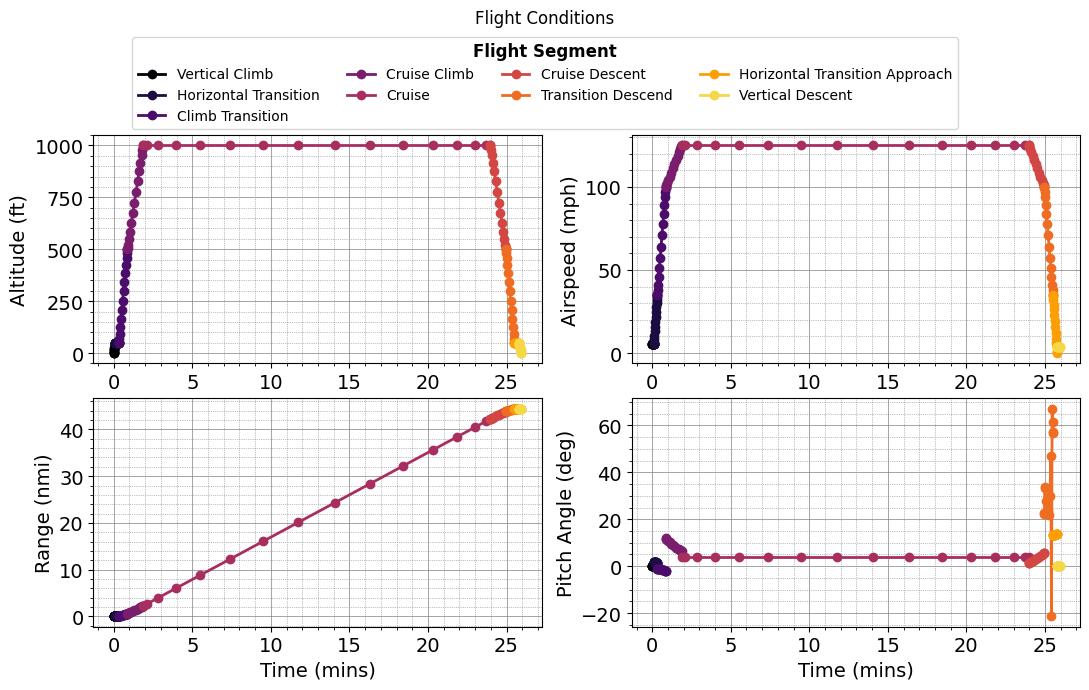

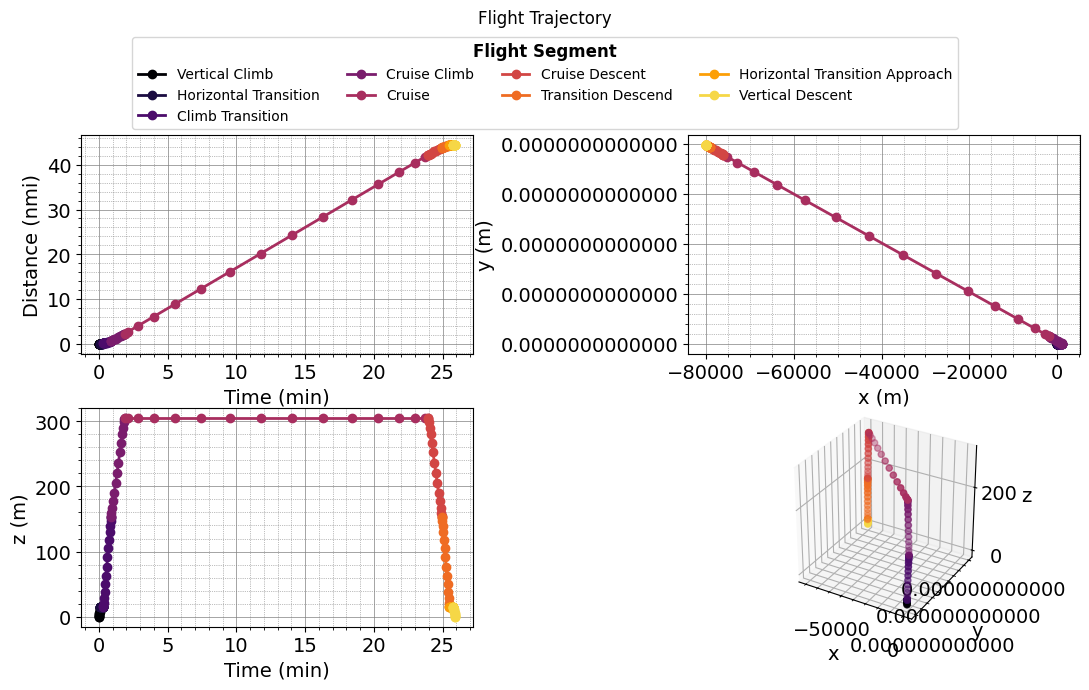

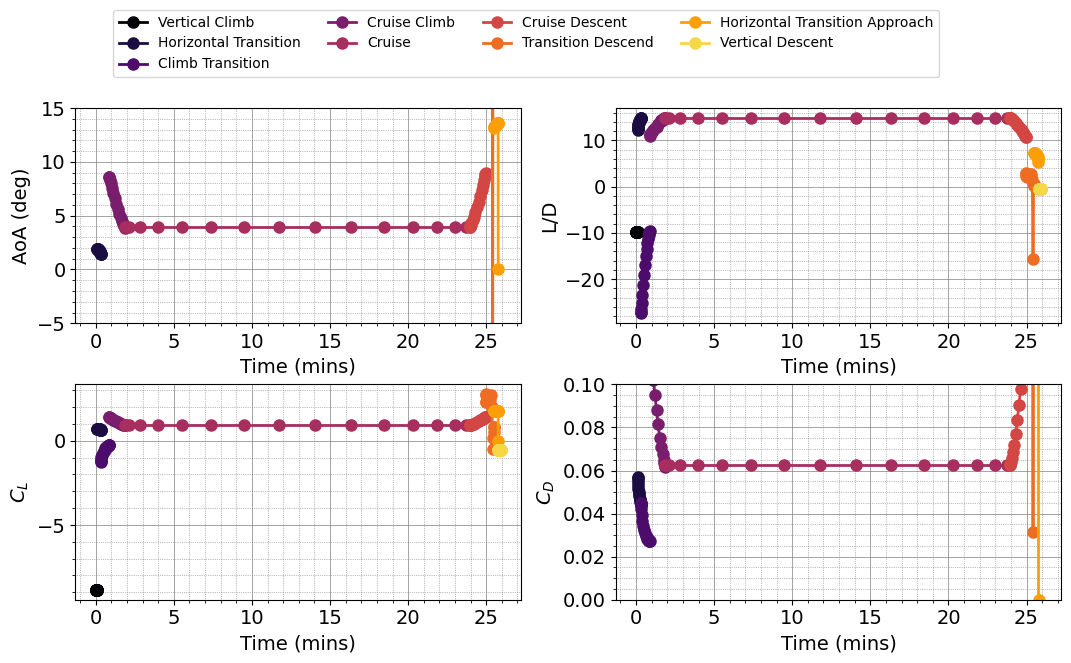

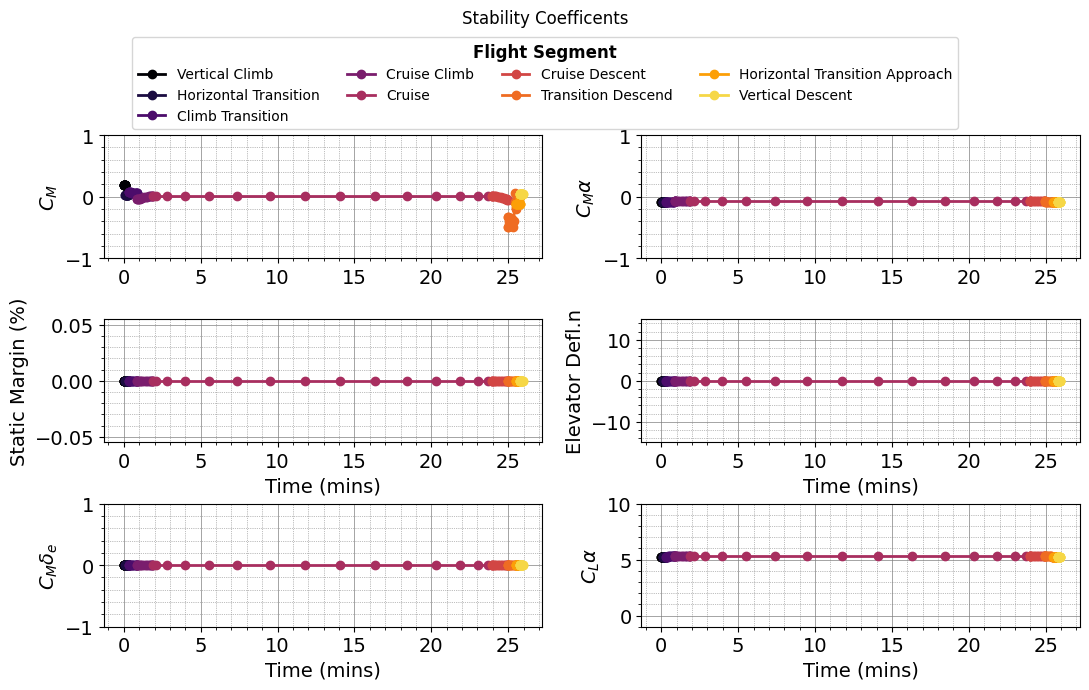

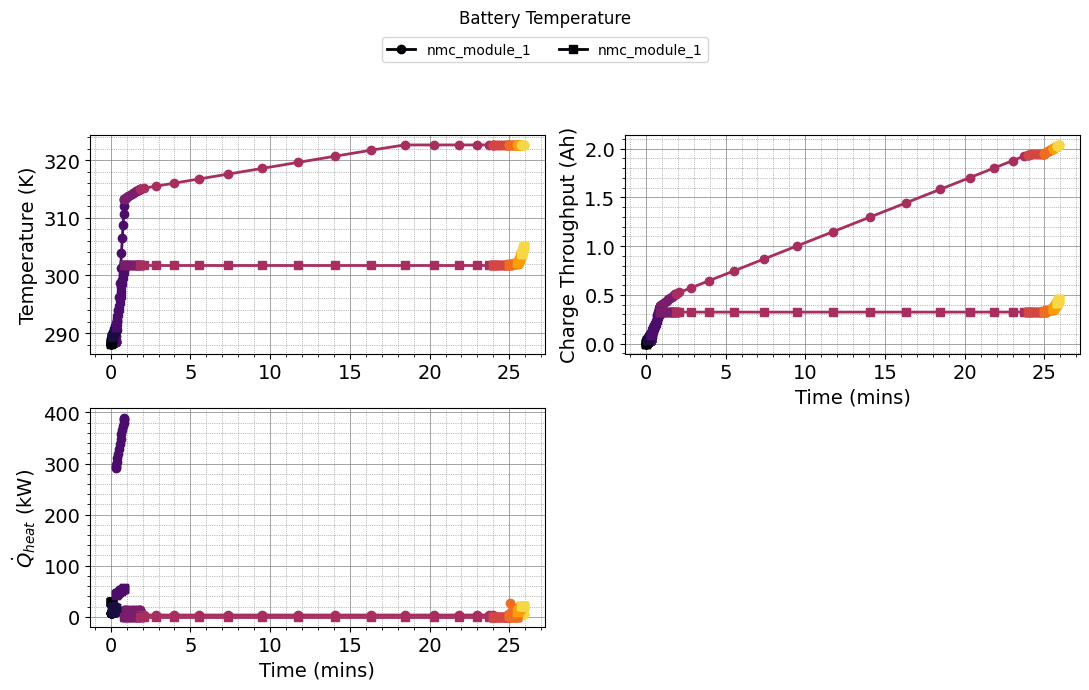

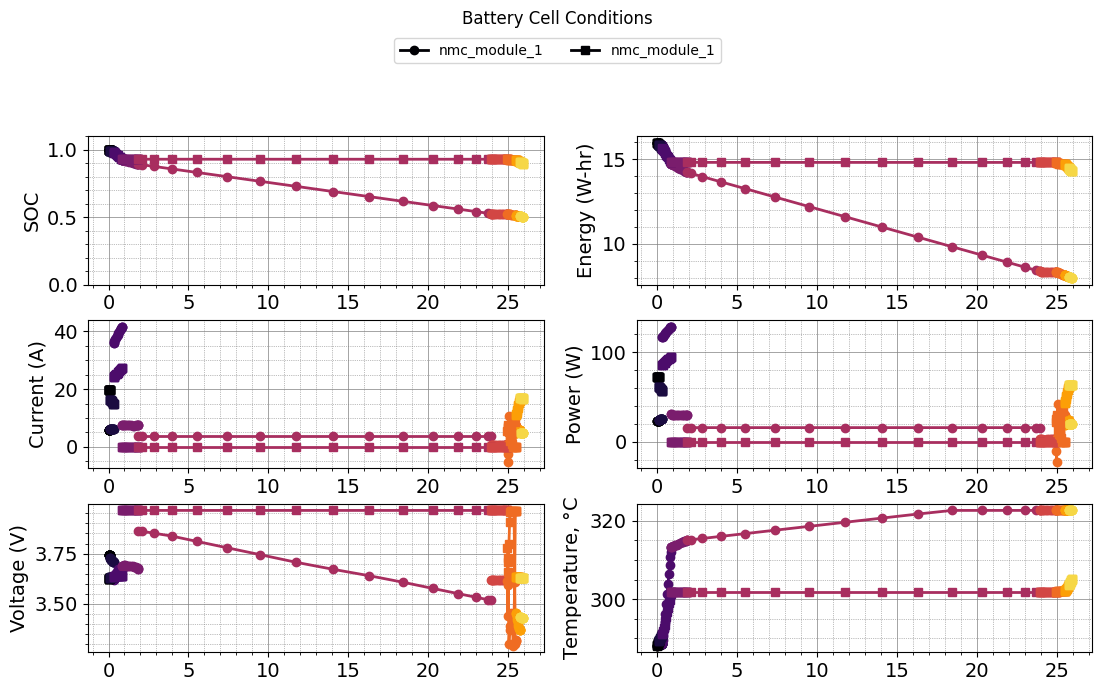

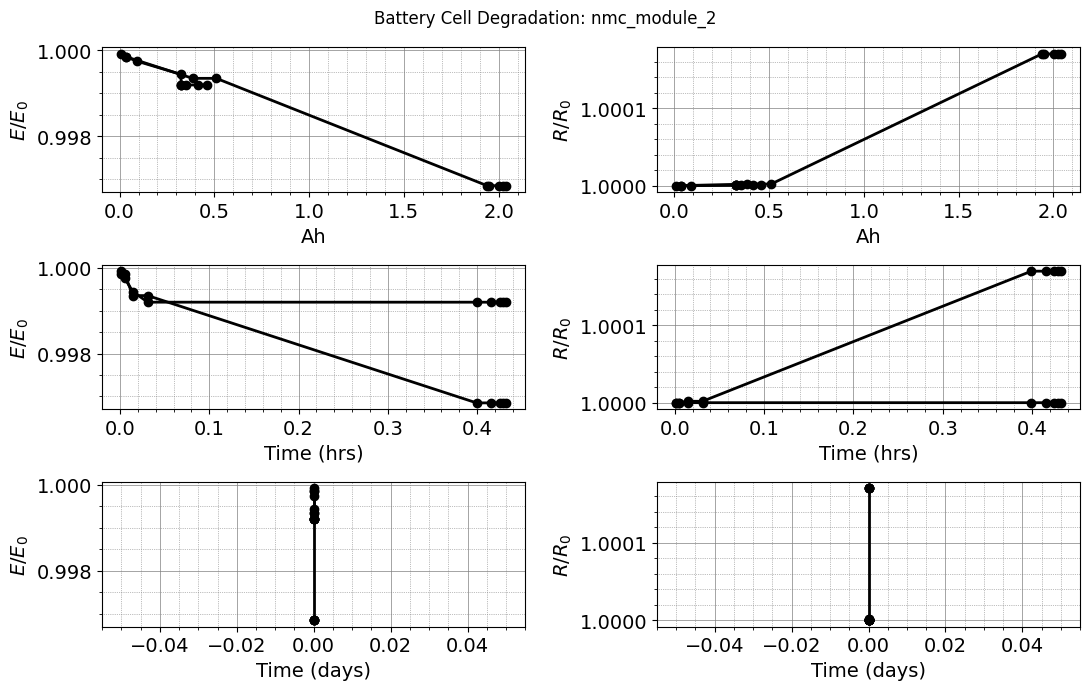

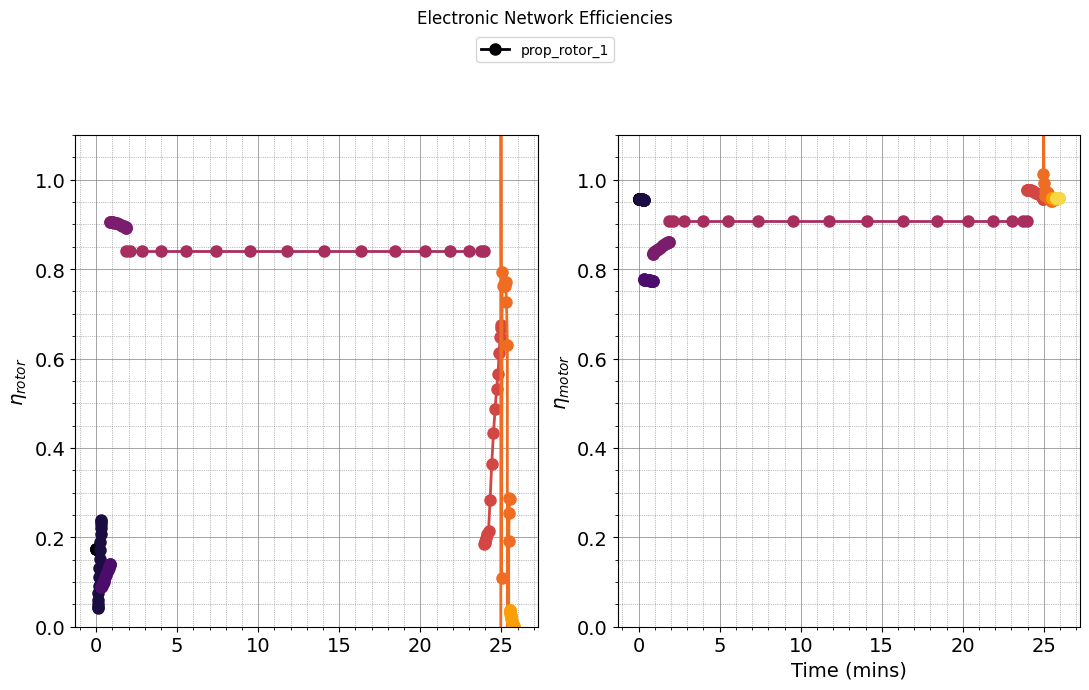

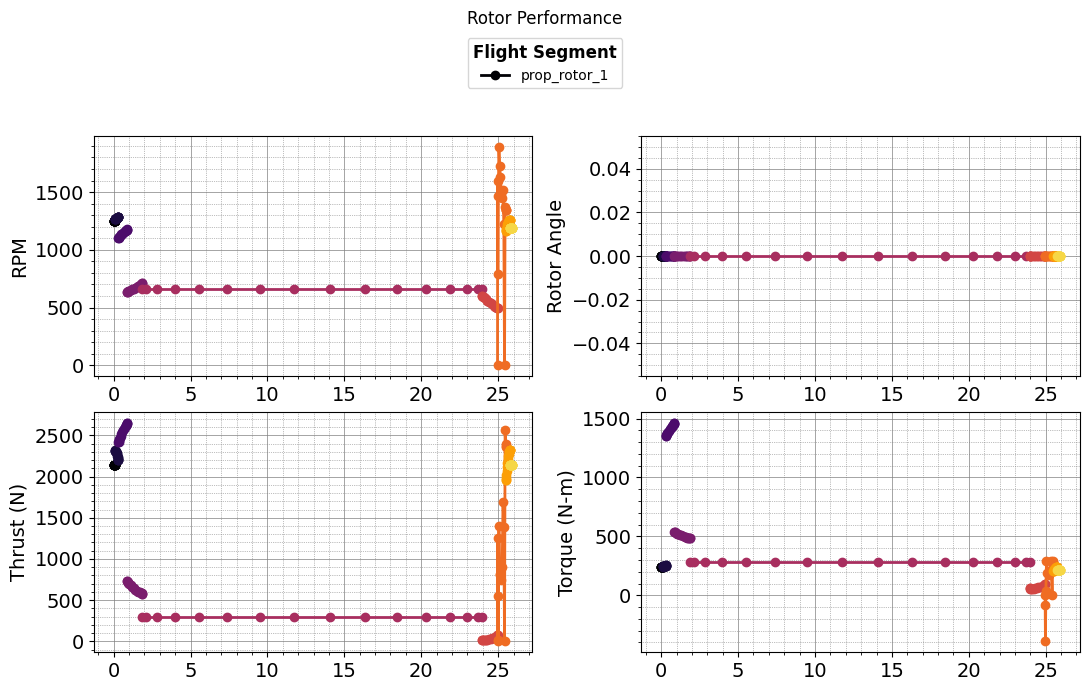

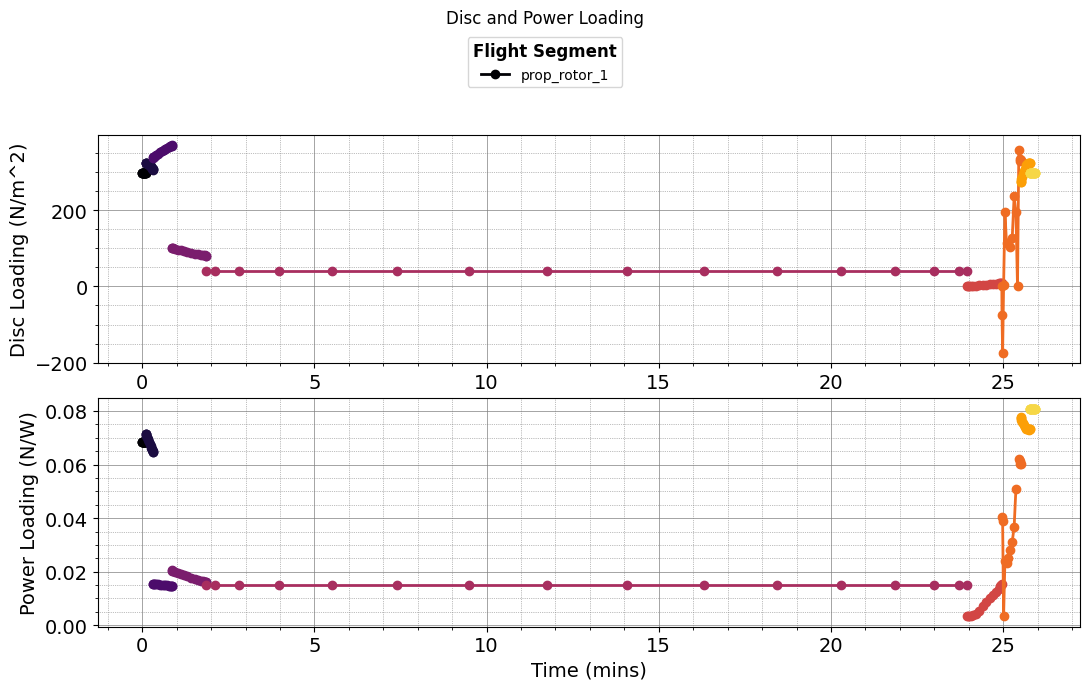

In [13]:
# vehicle data  
vehicle  = vehicle_setup()

# Set up configs
configs  = configs_setup(vehicle)

# vehicle analyses
analyses = analyses_setup(configs)

# mission analyses
mission  = mission_setup(analyses) 
missions = missions_setup(mission) 
    
results = missions.base_mission.evaluate() 
    
# plot the results 
plot_results(results)    

# plot vehicle 
plot_3d_vehicle(vehicle, 
                min_x_axis_limit            = -5,
                max_x_axis_limit            = 15,
                min_y_axis_limit            = -10,
                max_y_axis_limit            = 10,
                min_z_axis_limit            = -10,
                max_z_axis_limit            = 10,
                show_figure                 = False 
                )     